# Project 2 : Advance Lane Finding

 In this project, Our goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car.

## Camera Calibration

In [43]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [44]:
from importlib import reload
import utils; reload(utils)
from utils import *

In [45]:
calibration_dir = "camera_cal"
test_imgs_dir = "test_images"
output_imgs_dir = "output_images"
output_videos_dir = "output_videos"

### Finding Chessboard Corners

We must determine the number of inner corners horizontally cx and vertically cy for our sample chessboard pictures.

In [46]:
#find all the files matching specific pattern
calibration_images = glob.glob(calibration_dir + "/*.jpg")

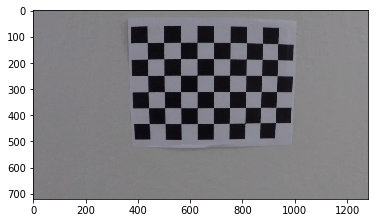

In [47]:
calibration_image = load_image(calibration_images[9])
plt.imshow(calibration_image)

Given sample chess board has 9 corners horizontally and 6 corners vertically

In [48]:
nx = 9
ny = 6

We submit grayscale images to findChessboardCorners so we must therefore define a utility method for this purpose.

True


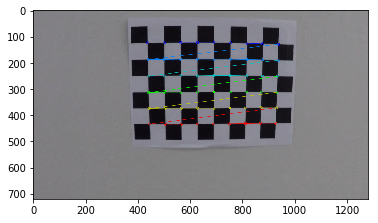

In [49]:
# Convert to grayscale
gray = cv2.cvtColor(calibration_image, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

print(ret)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(calibration_image, (nx, ny), corners, ret)
    plt.imshow(calibration_image)

We can see that corners are very well identified. Next we identify image and object points to calibrate the camera.

## Image Undistortion

### Identifying Image And Object Points

We find the mappings for coordinates of the images in 2D space (i.e. image points) to those of the undistorted image in the real-world (i.e. object points)

In [50]:
def findImgObjPoints(imgs_paths, nx, ny):
    
    # Arrays to store object points and image points from all the images
    objpoints = []
    imgpoints = []
    
    # Prepare object points like (0,0,0)...(7,5,0)
    objp = np.zeros((nx * ny, 3), np.float32)
    
    #mgrid returns the coordinate value for the given grid size 
    #and shape the coordinate back to two columns one for x and one for y
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) 
    
    #we need to perform the following steps for all the image in the camera_cal directory
    for img_path in imgs_paths:
        img = load_image(img_path)
        gray = to_grayscale(img)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        if ret:
            # Found the corners of an image
            imgpoints.append(corners)
            # Add the same object point since they don't change in the real world
            objpoints.append(objp)
    
    return objpoints, imgpoints

In [51]:
objpoints,imgpoints = findImgObjPoints(calibration_images,nx,ny)

### Undistort Image

mtx, dist parameters from calibration image is used to undistort the image using undistort function in opencv.

In [52]:
def undistort_image(img, objpoints, imgpoints):
    """
    Returns an undistorted image
    The desired object and image points must also be supplied to this function
    """
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, to_grayscale(img).shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

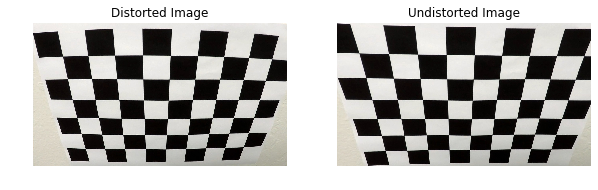

In [53]:
cal_img_sample = load_image(calibration_images[5])
cal_img_undist = undistort_image(cal_img_sample, objpoints, imgpoints)
fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(cal_img_sample)
ax[0].axis("off")
ax[0].set_title("Distorted Image")

ax[1].imshow(cal_img_undist)
ax[1].axis("off")
ax[1].set_title("Undistorted Image")

plt.show()

### Undistort Test Image

In [54]:
# Read all jpg files from the test folder
test_imgs_paths = glob.glob(test_imgs_dir + "/*.jpg")
print(test_imgs_paths)

['test_images/test6.jpg', 'test_images/test5.jpg', 'test_images/test4.jpg', 'test_images/test1.jpg', 'test_images/test3.jpg', 'test_images/test2.jpg', 'test_images/straight_lines2.jpg', 'test_images/straight_lines1.jpg']


In [55]:
#Remove directory path and pick only file name
test_img_names = np.asarray(list(map(lambda img_path: img_path.split("/")[-1].split(".")[0], test_imgs_paths)))
print(test_img_names)

['test6' 'test5' 'test4' 'test1' 'test3' 'test2' 'straight_lines2'
 'straight_lines1']


In [56]:
#Append the String undistorted in front of test file name
undist_test_img_names = np.asarray(list(map(lambda img_name: "{0}{1}".format("undistorted_", img_name), test_img_names)))
print(undist_test_img_names)

['undistorted_test6' 'undistorted_test5' 'undistorted_test4'
 'undistorted_test1' 'undistorted_test3' 'undistorted_test2'
 'undistorted_straight_lines2' 'undistorted_straight_lines1']


In [57]:
# load the test image 
test_imgs = np.asarray(list(map(lambda img_path: load_image(img_path), test_imgs_paths)))

#call the undistort function which returns the undistorted image
undist_test_imgs = np.asarray(list(map(lambda img: undistort_image(img, objpoints, imgpoints), test_imgs)))

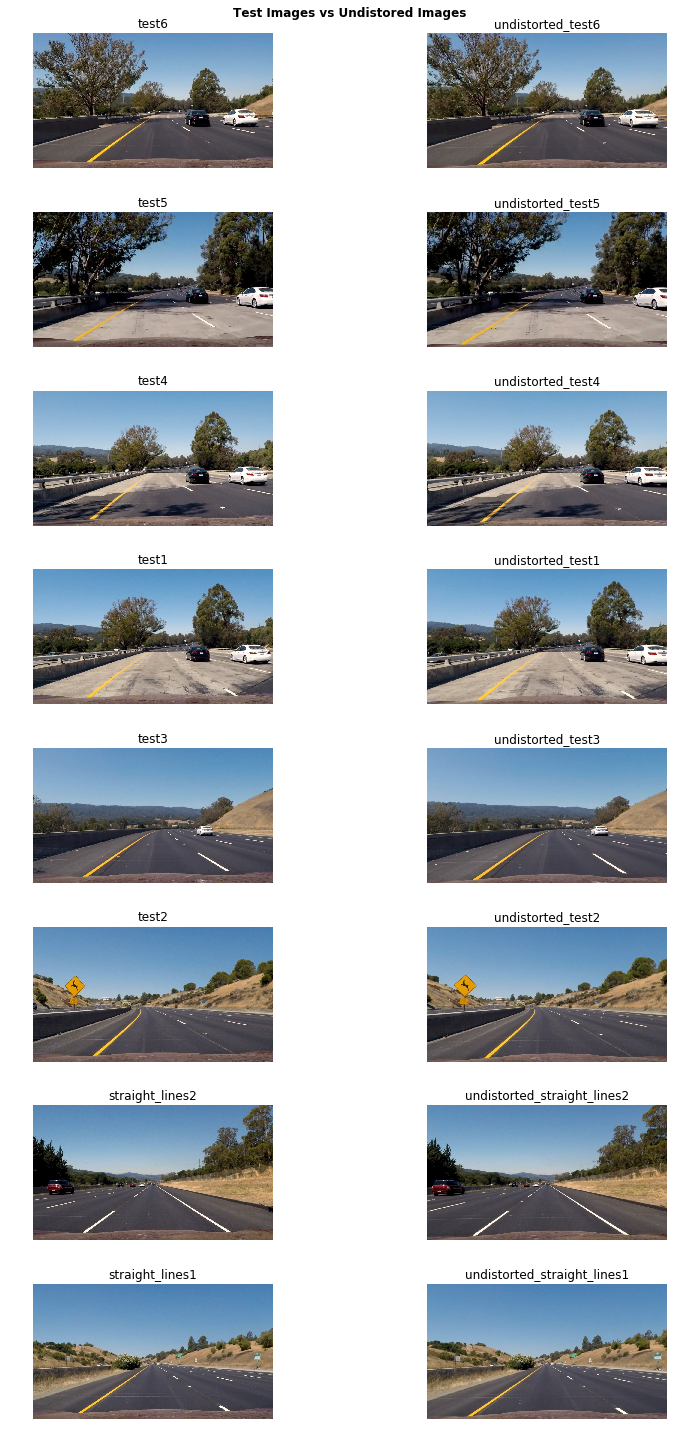

In [59]:
test_img_and_undist = np.asarray(list(zip(test_imgs, undist_test_imgs)))
test_img_and_undist_names = np.asarray(list(zip(test_img_names, undist_test_img_names)))



#show_image_list is defined in util function
show_image_list(test_img_and_undist, test_img_and_undist_names, "Test Images vs Undistored Images", fig_size=(12, 20), cols=2, show_ticks=False)

### Thresholding

We apply color and edge thresholding in this section to better detect the lines, and make it easier to find the polynomial that best describes our left and right lanes later.

We start with first exploring which color spaces we should adopt to increase our chances of detecting the lanes and facilitating the task of the gradient thresholding step.

In [60]:
def threshold_img(img, channel, thres=(0, 255)):
    """
    Applies a threshold mask to the input image
    """
    img_ch = img[:,:,channel]
    if thres is None:  
        return img_ch
    
    mask_ch = np.zeros_like(img_ch)
    mask_ch[ (thres[0] <= img_ch) & (thres[1] >= img_ch) ] = 1
    return mask_ch

In [61]:
test_img_path = test_imgs_paths[7]
test_img = load_image(test_img_path)
undistorted_test_img = undistort_image(test_img, objpoints, imgpoints)

### Color Thresholding

We experiment with different color spaces to see which color space and channel(s) we should use for the most effective separation of lane lines:

In [62]:
rgb_comp = np.asarray([[threshold_img(undistorted_test_img, 0, thres=None), threshold_img(undistorted_test_img, 1, thres=None), threshold_img(undistorted_test_img, 2, thres=None)]])
rgb_lbs = np.asarray([["Red Channel", "Green Channel", "Blue Channel"]])

In [63]:
#to_hls defined in util
hls_test_img = to_hls(undistorted_test_img)
hls_comp = np.asarray([[threshold_img(hls_test_img, 0, thres=None), threshold_img(hls_test_img, 1, thres=None), threshold_img(hls_test_img, 2, thres=None)]])
hls_lbs = np.asarray([["Hue Channel", "Lightness Channel", "Saturation Channel"]])

In [64]:
hsv_test_img = to_hsv(undistorted_test_img)
hsv_comp = np.asarray([[threshold_img(hsv_test_img, 0, thres=None), threshold_img(hsv_test_img, 1, thres=None), threshold_img(hsv_test_img, 2, thres=None)]])
hsv_lbs = np.asarray([["Hue Channel", "Saturation Channel", "Value Channel"]])

In [65]:
color_spaces_comps = np.concatenate((rgb_comp, hls_comp, hsv_comp))
color_spaces_lbs = np.concatenate((rgb_lbs, hls_lbs, hsv_lbs))

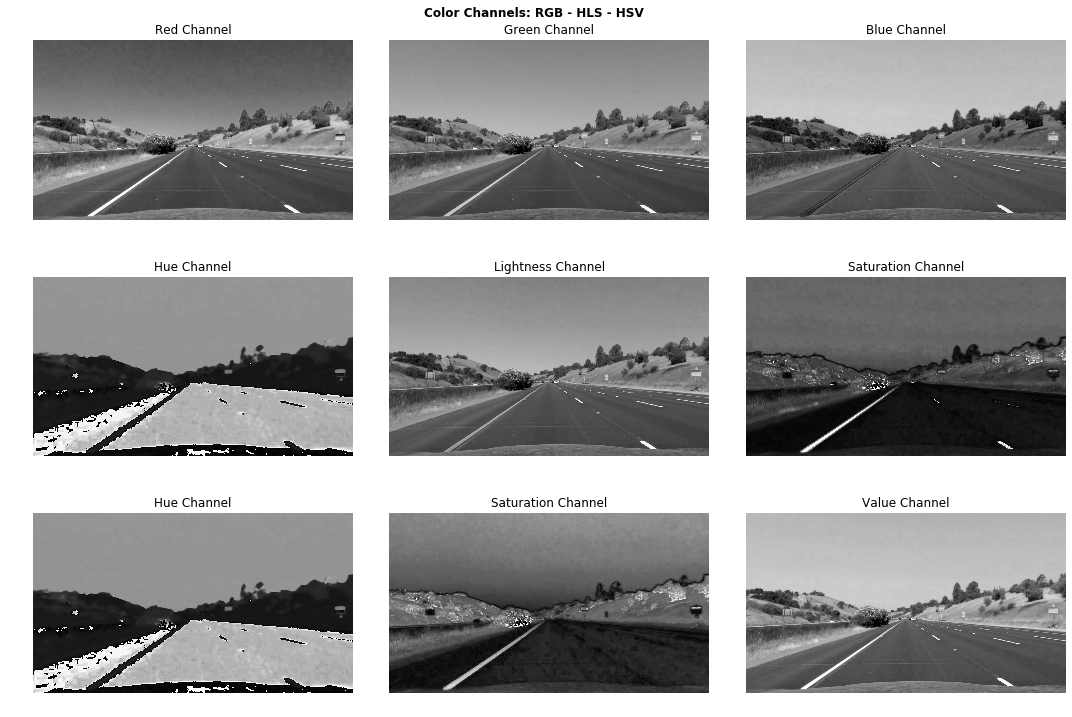

In [66]:
show_image_list(color_spaces_comps, color_spaces_lbs, "Color Channels: RGB - HLS - HSV ", cols=3, fig_size=(15, 10), show_ticks=False)

On the RGB components, we see that the blue channel is worst at identifying yellow lines, while the red channel seems to give best results.

For HLS and HSV, the hue channel produces an extremely noisy output, while the saturation channel of HLS seems to give the strong results; better than HSV's saturation channel. conversely, HSV's value channel is giving a very clear grayscale-ish image, especially on the yellow line, much better than HLS' lightness channel.

we choose to use **HLS because of its strong result on saturation channel.**

In [67]:
def compute_hls_white_yellow_binary(rgb_img):
    """
    Returns a binary thresholded image produced retaining only white and yellow elements on the picture
    The provided image should be in RGB format
    """
    hls_img = to_hls(rgb_img)
    
    # Compute a binary thresholded image where yellow is isolated from HLS components
    img_hls_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_yellow_bin[((hls_img[:,:,0] >= 15) & (hls_img[:,:,0] <= 35))
                 & ((hls_img[:,:,1] >= 30) & (hls_img[:,:,1] <= 204))
                 & ((hls_img[:,:,2] >= 115) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Compute a binary thresholded image where white is isolated from HLS components
    img_hls_white_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_bin[((hls_img[:,:,0] >= 0) & (hls_img[:,:,0] <= 255))
                 & ((hls_img[:,:,1] >= 200) & (hls_img[:,:,1] <= 255))
                 & ((hls_img[:,:,2] >= 0) & (hls_img[:,:,2] <= 255))                
                ] = 1
    
    # Now combine both
    img_hls_white_yellow_bin = np.zeros_like(hls_img[:,:,0])
    img_hls_white_yellow_bin[(img_hls_yellow_bin == 1) | (img_hls_white_bin == 1)] = 1

    return img_hls_white_yellow_bin

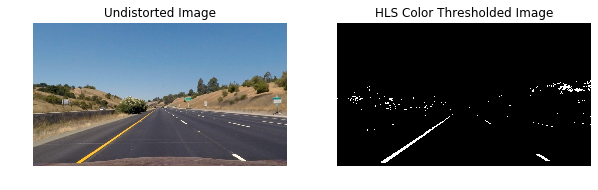

In [68]:
undistorted_yellow_white_hls_img_bin = compute_hls_white_yellow_binary(undistorted_test_img)

fig, ax = plt.subplots(1, 2, figsize=(10,7))
ax[0].imshow(undistorted_test_img)
ax[0].axis("off")
ax[0].set_title("Undistorted Image")

ax[1].imshow(undistorted_yellow_white_hls_img_bin, cmap='gray')
ax[1].axis("off")
ax[1].set_title("HLS Color Thresholded Image")

plt.show()

As you can see above, our HLS color thresholding achieve great results on the image. The thresholding somewhat struggles a little with the shadow of the tree on the yellow line further up ahead. We believe gradient thresholding can help in this case.

### Gradient Thresholding Via Sobel

We use the Sobel operator to identify gradients, that is change in color intensity in the image. Higher values would denote strong gradients, and therefore sharp changes in color.

In [69]:
undist_test_img_gray = to_grayscale(undistorted_test_img)

### Sobel In X or Y Directions

In [70]:
def abs_sobel(gray_img, x_dir=True, kernel_size=3, thres=(0, 255)):
    """
    Applies the sobel operator to a grayscale-like (i.e. single channel) image in either horizontal or vertical direction
    The function also computes the asbolute value of the resulting matrix and applies a binary threshold
    """
    sobel = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size) if x_dir else cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size) 
    sobel_abs = np.absolute(sobel)
    sobel_scaled = np.uint8(255 * sobel / np.max(sobel_abs))
    
    gradient_mask = np.zeros_like(sobel_scaled)
    gradient_mask[(thres[0] <= sobel_scaled) & (sobel_scaled <= thres[1])] = 1
    return gradient_mask

In [71]:
sobx_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, thres=(20, 120)), abs_sobel(undist_test_img_gray, thres=(50, 150)), abs_sobel(undist_test_img_gray, thres=(80, 200))]])
sobx_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobx_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobx_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobx_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobx_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobx_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobx_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [72]:
sobx_thres = np.concatenate((sobx_3x3_thres, sobx_7x7_thres, sobx_11x11_thres, sobx_15x15_thres))
sobx_thres_lbs = np.concatenate((sobx_3x3_thres_lbs, sobx_7x7_thres_lbs, sobx_11x11_thres_lbs, sobx_15x15_thres_lbs))

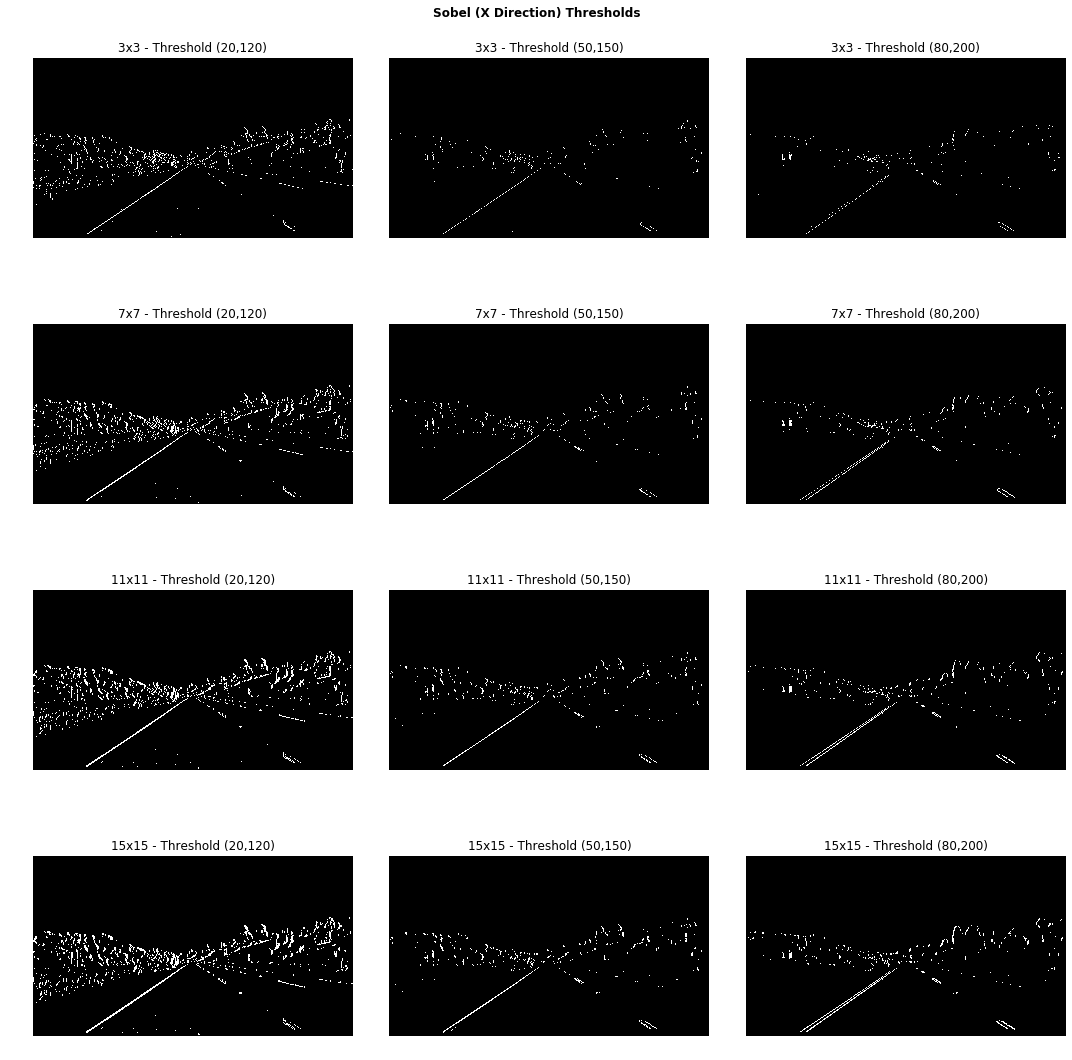

In [73]:
show_image_list(sobx_thres, sobx_thres_lbs, "Sobel (X Direction) Thresholds", cols=3, show_ticks=False)

We obtain the "best" results for Sobel in the X direction with thresholds values between in the interval [20,120], using a kernel size of 15 (lines are very crisp).

In [74]:
# Saving our best sobel results
sobx_best = abs_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 120))

In [75]:
soby_3x3_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, thres=(80, 200))]])
soby_7x7_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=7, thres=(80, 200))]])
soby_11x11_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=11, thres=(80, 200))]])
soby_15x15_thres = np.asarray([[abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(50, 150)), abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(80, 200))]])

soby_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,120)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
soby_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,120)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
soby_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,120)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
soby_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,120)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [76]:
soby_thres = np.concatenate((soby_3x3_thres, soby_7x7_thres, soby_11x11_thres, soby_15x15_thres))
soby_thres_lbs = np.concatenate((soby_3x3_thres_lbs, soby_7x7_thres_lbs, soby_11x11_thres_lbs, soby_15x15_thres_lbs))

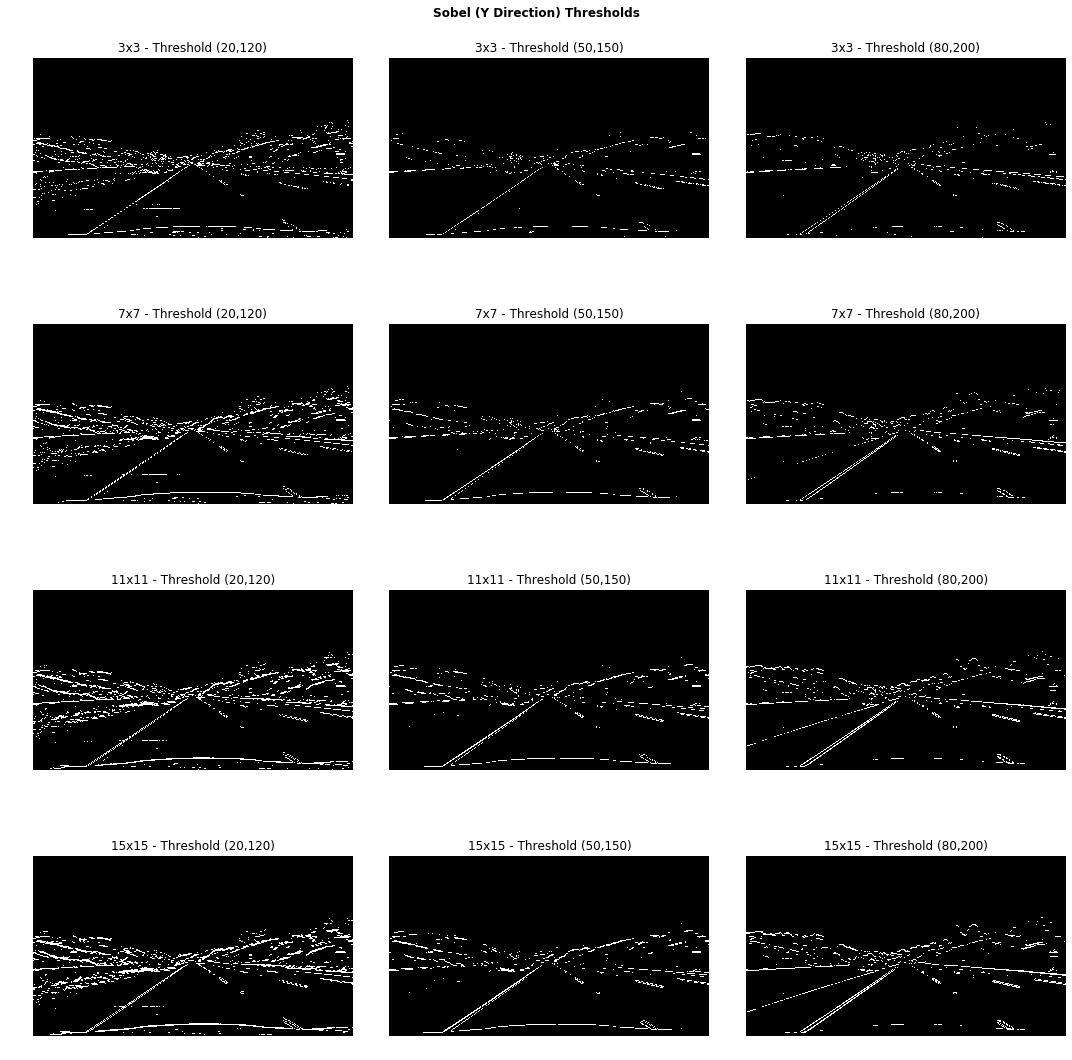

In [77]:
show_image_list(soby_thres, soby_thres_lbs, "Sobel (Y Direction) Thresholds", cols=3, show_ticks=False)

In the Y direction, our best Sobel configuration is with thresholds in the interval _[20,120]_ and kernel size 15.

In [78]:
# Saving our best sobel y result
soby_best = abs_sobel(undist_test_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))

### Sobel Magnitude in X and Y Directions

In [79]:
def mag_sobel(gray_img, kernel_size=3, thres=(0, 255)):
    """
    Computes sobel matrix in both x and y directions, merges them by computing the magnitude in both directions
    and applies a threshold value to only set pixels within the specified range
    """
    sx = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size)
    sy = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size)
    
    sxy = np.sqrt(np.square(sx) + np.square(sy))
    scaled_sxy = np.uint8(255 * sxy / np.max(sxy))
    
    sxy_binary = np.zeros_like(scaled_sxy)
    sxy_binary[(scaled_sxy >= thres[0]) & (scaled_sxy <= thres[1])] = 1
    
    return sxy_binary

In [80]:
sobxy_3x3_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=3, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=3, thres=(80, 200))]])
sobxy_7x7_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=7, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=7, thres=(80, 200))]])
sobxy_11x11_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=11, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=11, thres=(80, 200))]])
sobxy_15x15_thres = np.asarray([[mag_sobel(undist_test_img_gray, kernel_size=15, thres=(20, 80)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(50, 150)), mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))]])

sobxy_3x3_thres_lbs = np.asarray([["3x3 - Threshold (20,80)", "3x3 - Threshold (50,150)", "3x3 - Threshold (80,200)"]])
sobxy_7x7_thres_lbs = np.asarray([["7x7 - Threshold (20,80)", "7x7 - Threshold (50,150)", "7x7 - Threshold (80,200)"]])
sobxy_11x11_thres_lbs = np.asarray([["11x11 - Threshold (20,80)", "11x11 - Threshold (50,150)", "11x11 - Threshold (80,200)"]])
sobxy_15x15_thres_lbs = np.asarray([["15x15 - Threshold (20,80)", "15x15 - Threshold (50,150)", "15x15 - Threshold (80,200)"]])


In [81]:
sobxy_thres = np.concatenate((sobxy_3x3_thres, sobxy_7x7_thres, sobxy_11x11_thres, sobxy_15x15_thres))
sobxy_thres_lbs = np.concatenate((sobxy_3x3_thres_lbs, sobxy_7x7_thres_lbs, sobxy_11x11_thres_lbs, sobxy_15x15_thres_lbs))


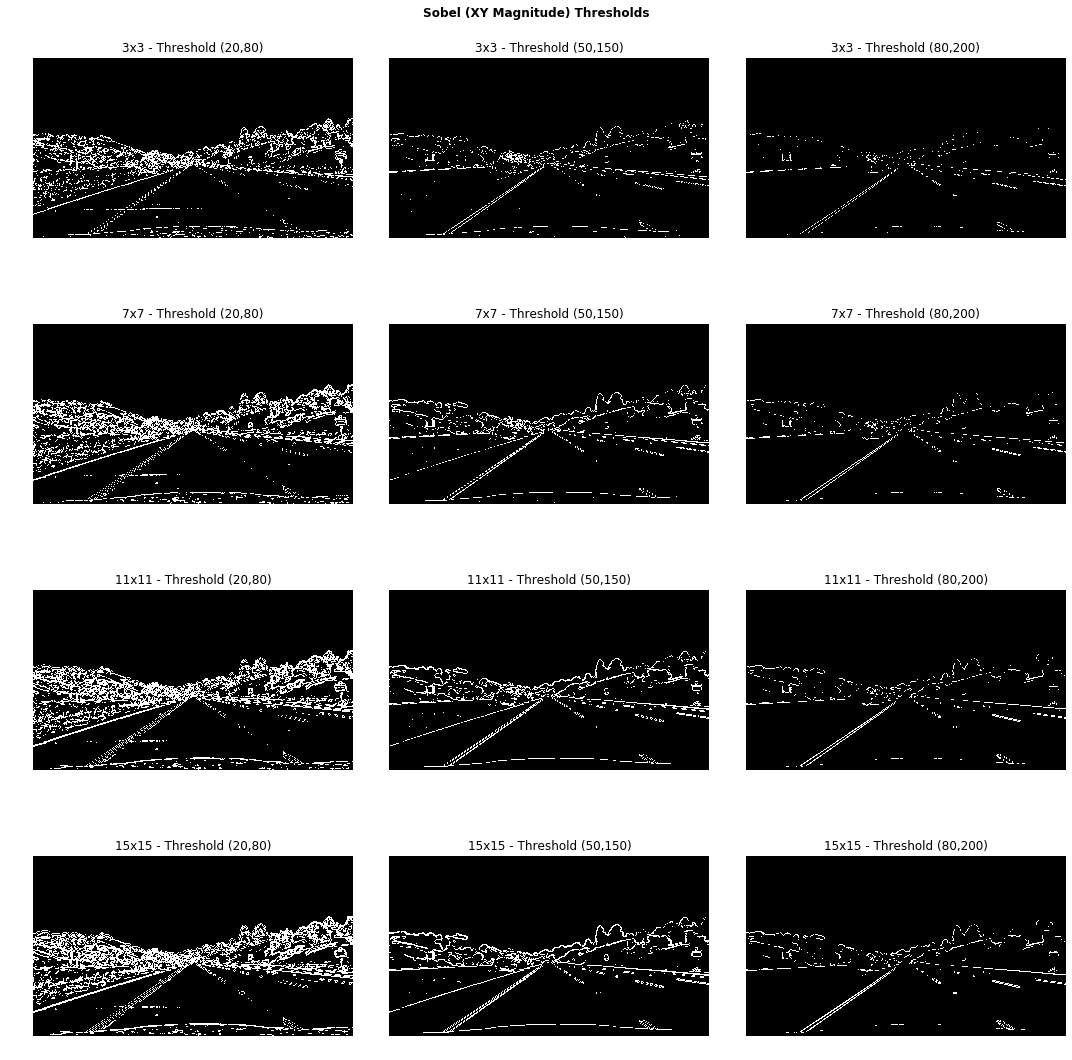

In [82]:
show_image_list(sobxy_thres, sobxy_thres_lbs, "Sobel (XY Magnitude) Thresholds", cols=3, show_ticks=False)

Since we plan to combine this Sobel result, we believe we get enough information for interval [80, 200] and kernel size 15.

In [83]:
# Saving our best Sobel XY magnitude results
sobxy_best = mag_sobel(undist_test_img_gray, kernel_size=15, thres=(80, 200))

#### Sobel With Gradient Direction

This Sobel operation is extremely noisy and it becomes quite hard to decipher the result if we do not combine it with our previous sobel operations and produce a binary output.

In [84]:
def dir_sobel(gray_img, kernel_size=3, thres=(0, np.pi/2)):
    """
    Computes sobel matrix in both x and y directions, gets their absolute values to find the direction of the gradient
    and applies a threshold value to only set pixels within the specified range
    """
    sx_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=kernel_size))
    sy_abs = np.absolute(cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=kernel_size))
    
    dir_sxy = np.arctan2(sx_abs, sy_abs)

    binary_output = np.zeros_like(dir_sxy)
    binary_output[(dir_sxy >= thres[0]) & (dir_sxy <= thres[1])] = 1
    
    return binary_output

In [85]:
def combined_sobels(sx_binary, sy_binary, sxy_magnitude_binary, gray_img, kernel_size=3, angle_thres=(0, np.pi/2)):
    sxy_direction_binary = dir_sobel(gray_img, kernel_size=kernel_size, thres=angle_thres)
    
    combined = np.zeros_like(sxy_direction_binary)
    # Sobel X returned the best output so we keep all of its results. We perform a binary and on all the other sobels    
    combined[(sx_binary == 1) | ((sy_binary == 1) & (sxy_magnitude_binary == 1) & (sxy_direction_binary == 1))] = 1
    
    return combined

In [86]:
cb = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray)

In [87]:
sobxy_combined_dir_3x3_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=3, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_7x7_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=7, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_11x11_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=11, angle_thres=(np.pi/3, np.pi/2))
                                           ]])

sobxy_combined_dir_15x15_thres = np.asarray([[combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(0, np.pi/4)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2)),
                                            combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/3, np.pi/2))
                                           ]])


sobxy_combined_dir_3x3_thres_lbs = np.asarray([["3x3 - Combined (0, pi/4)", "3x3 - Combined (pi/4, pi/2)", "3x3 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_7x7_thres_lbs = np.asarray([["7x7 - Combined (0, pi/4)", "7x7 - Combined (pi/4, pi/2)", "7x7 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_11x11_thres_lbs = np.asarray([["11x11 - Combined (0, pi/4)", "11x11 - Combined (pi/4, pi/2)", "11x11 - Combined (pi/3, pi/2)"]])
sobxy_combined_dir_15x15_thres_lbs = np.asarray([["15x15 - Combined (0, pi/4)", "15x15 - Combined (pi/4, pi/2)", "15x15 - Combined (pi/3, pi/2)"]])

In [88]:
sobxy_combined_dir_thres = np.concatenate((sobxy_combined_dir_3x3_thres, sobxy_combined_dir_7x7_thres, sobxy_combined_dir_11x11_thres, sobxy_combined_dir_15x15_thres))
sobxy_combined_dir_thres_lbs = np.concatenate((sobxy_combined_dir_3x3_thres_lbs, sobxy_combined_dir_7x7_thres_lbs, sobxy_combined_dir_11x11_thres_lbs, sobxy_combined_dir_15x15_thres_lbs))

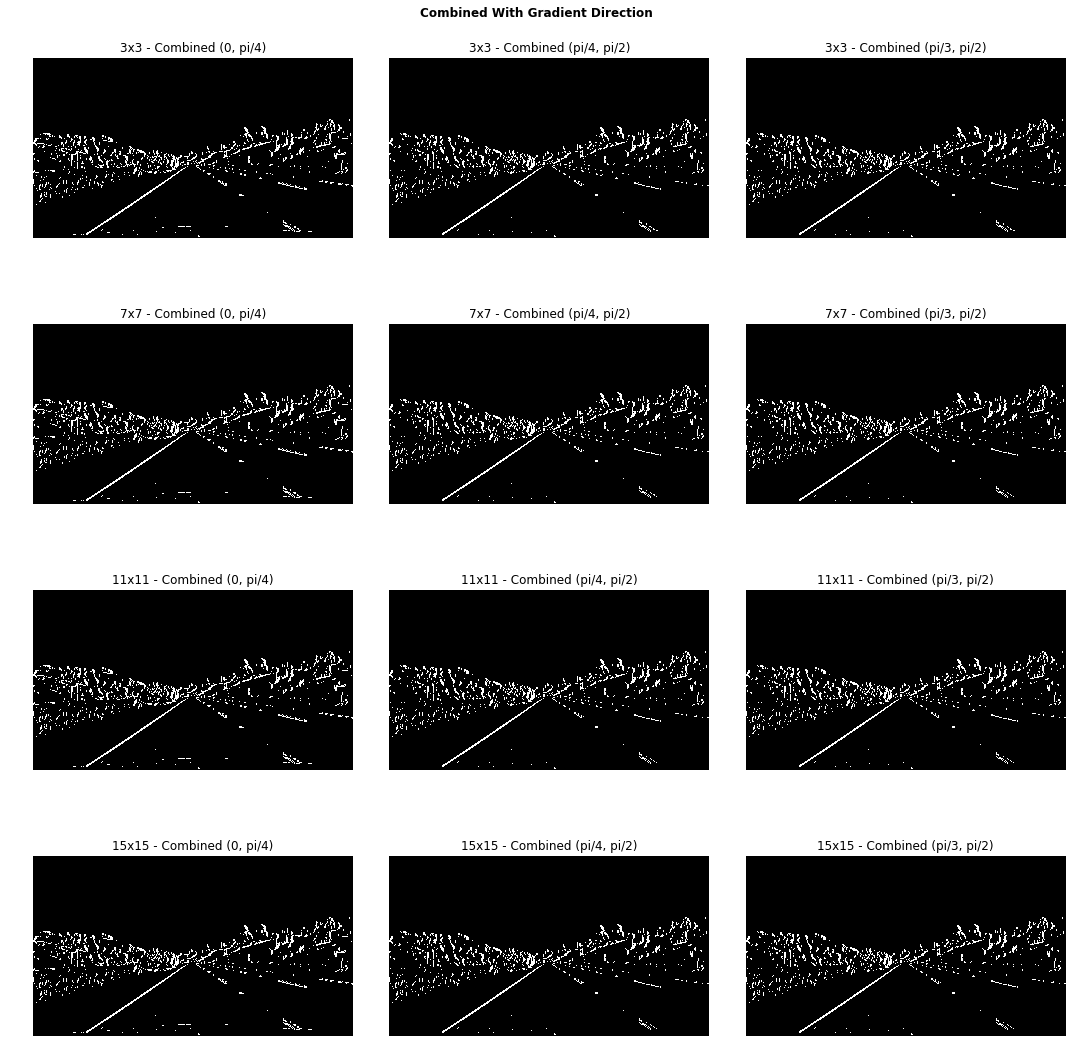

In [89]:
show_image_list(sobxy_combined_dir_thres, sobxy_combined_dir_thres_lbs, "Combined With Gradient Direction", cols=3, show_ticks=False)

Interestingly, the kernel size does not seem to affect the direction sobel operation so much. It's also hard to determine which one is the "best" result out of all our visualisations. Since we want to retain only information about lane lines, we are inclined to elect interval [pi/4, pi/2] as our best configuration as it gives us the most room for manoeuvre. Kernel size of 15x15 produces the least noise.

In [90]:
sobel_combined_best = combined_sobels(sobx_best, soby_best, sobxy_best, undist_test_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))                                                                            

The resulting image from combined variant of sobel operations shows promise. We should next combine it with the results we obtained from our HLS' color thresholding method.



### Combining Color And Gradient (Sobel) Thresholds

In [91]:
color_binary = np.dstack((np.zeros_like(sobel_combined_best), sobel_combined_best, undistorted_yellow_white_hls_img_bin)) * 255
color_binary = color_binary.astype(np.uint8)

In [92]:
combined_binary = np.zeros_like(undistorted_yellow_white_hls_img_bin)
combined_binary[(sobel_combined_best == 1) | (undistorted_yellow_white_hls_img_bin == 1)] = 1

In [93]:
combined_binaries = [[color_binary, combined_binary]]
combined_binaries_lbs = np.asarray([["Stacked Thresholds", "Combined Color And Gradient Thresholds"]])

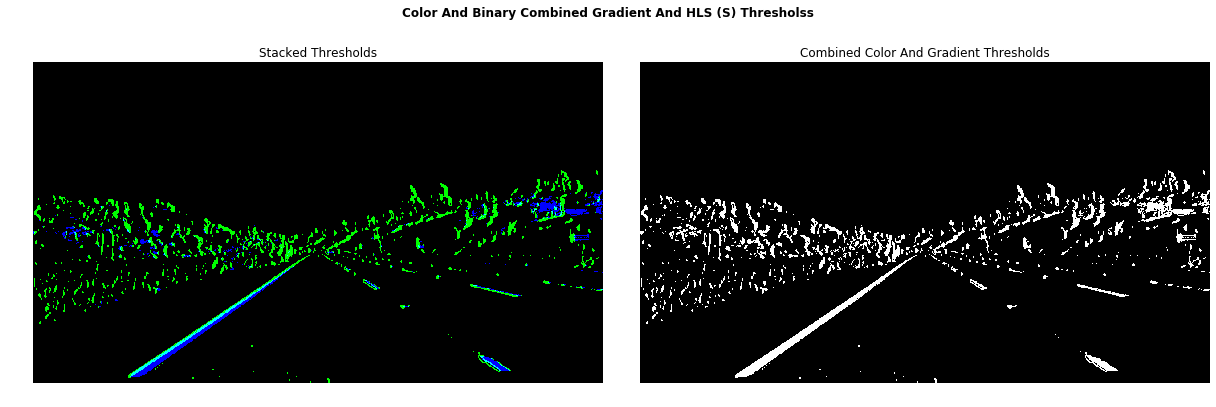

In [94]:
show_image_list(combined_binaries, combined_binaries_lbs, "Color And Binary Combined Gradient And HLS (S) Thresholss", cols=2, fig_size=(17, 6), show_ticks=False)

The results are very encouraging and it seems we have found the right parameters to detect lanes in a robust manner. We turn next to applying a perspective transform to our image and produce a bird's eye view of the lane.

## Perspective Transform

We now need to define a trapezoidal region in the 2D image that will go through a perspective transform to convert into a bird's eye view.

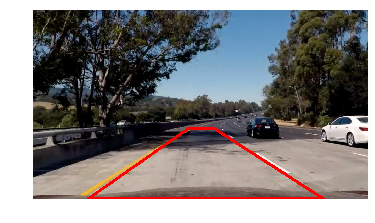

In [95]:
copy_combined = np.copy(undist_test_imgs[1])
(bottom_px, right_px) = (copy_combined.shape[0] - 1, copy_combined.shape[1] - 1) 
pts = np.array([[210,bottom_px],[595,450],[690,450], [1110, bottom_px]], np.int32)
cv2.polylines(copy_combined,[pts],True,(255,0,0), 10)
plt.axis('off')
plt.imshow(copy_combined)

In [96]:
def compute_perspective_transform_matrices(src, dst):
    """
    Returns the tuple (M, M_inv) where M represents the matrix to use for perspective transform
    and M_inv is the matrix used to revert the transformed image back to the original one
    """
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    return (M, M_inv)

In [97]:
def perspective_transform(img, src, dst):   
    """
    Applies a perspective 
    """
    M = cv2.getPerspectiveTransform(src, dst)
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

In [98]:
src_pts = pts.astype(np.float32)
dst_pts = np.array([[200, bottom_px], [200, 0], [1000, 0], [1000, bottom_px]], np.float32)

In [99]:
test_img_persp_tr = perspective_transform(undistorted_test_img, src_pts, dst_pts)

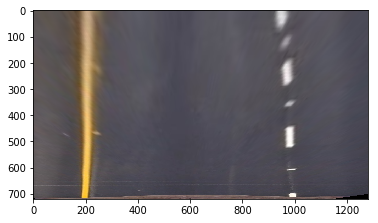

In [100]:
plt.imshow(test_img_persp_tr)

In [101]:
#Do perspective transform for all the undistorted images
test_imgs_pers_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

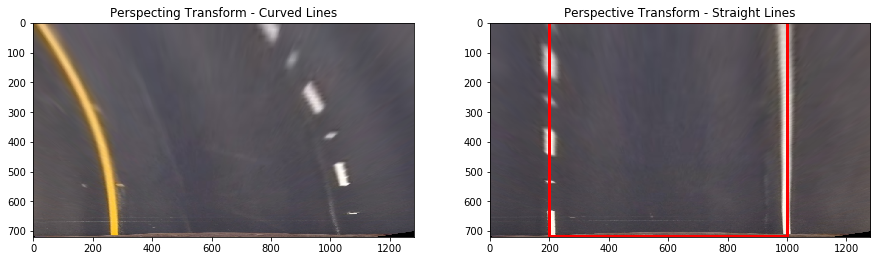

In [102]:
test_persp_img = np.copy(test_imgs_pers_tr[6])
dst = dst_pts.astype(np.int32)
cv2.polylines(test_persp_img,[dst],True,(255,0,0), 10)

fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].imshow(test_imgs_pers_tr[5])
ax[0].set_title("Perspecting Transform - Curved Lines")

ax[1].imshow(test_persp_img)
ax[1].set_title("Perspective Transform - Straight Lines")

plt.show()

We can see that our perspective transform keeps straight lines straight, which is a required sanity check.

In [103]:
test_undist_imgs_and_p_tr = np.asarray(list(zip(undist_test_imgs, test_imgs_pers_tr)))
test_undist_imgs_and_p_tr_names = np.asarray(list(zip(undist_test_img_names, undist_test_img_names)))

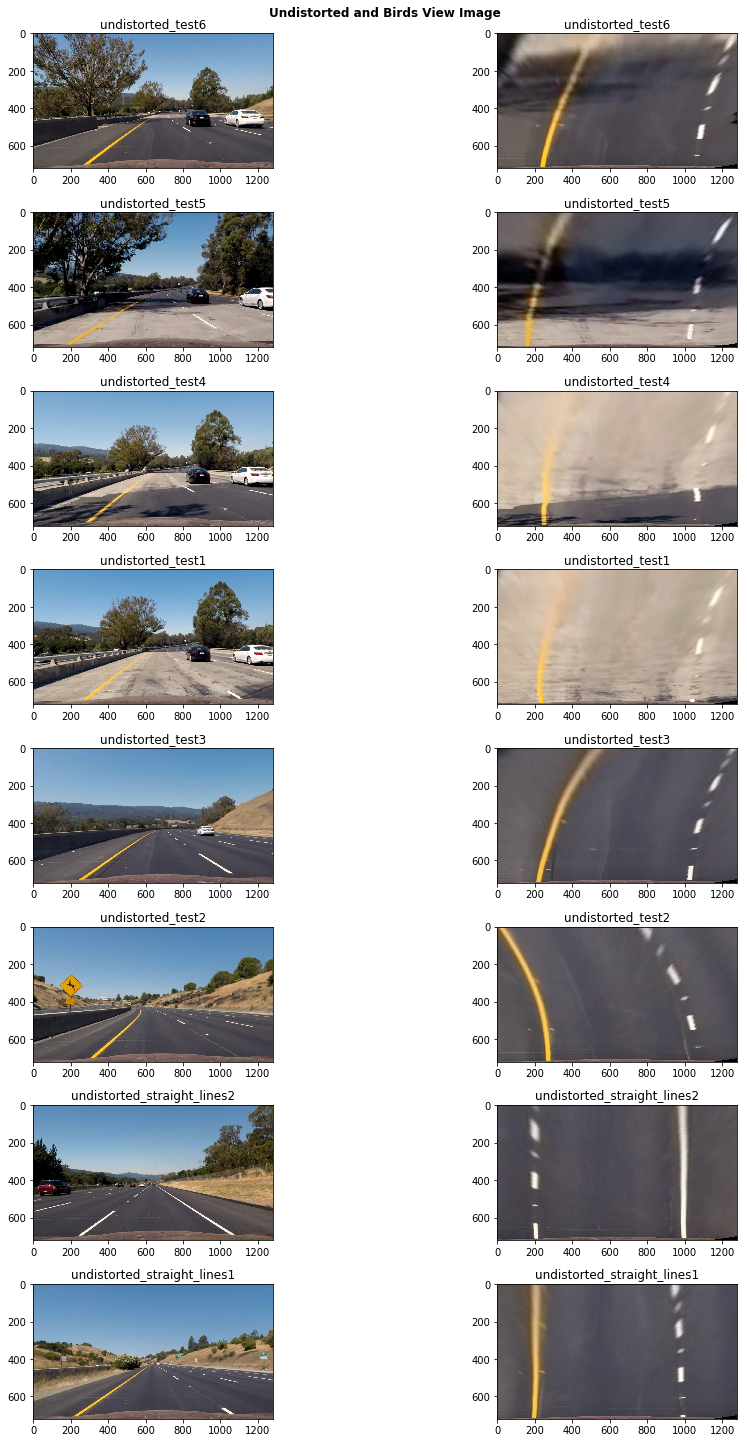

In [104]:
show_image_list(test_undist_imgs_and_p_tr, test_undist_imgs_and_p_tr_names, "Undistorted and Birds View Image", fig_size=(15, 20))

## Putting It All Together

In [105]:
def get_combined_binary_thresholded_img(undist_img):
    """
    Applies a combination of binary Sobel and color thresholding to an undistorted image
    Those binary images are then combined to produce the returned binary image
    """
    undist_img_gray = to_lab(undist_img)[:,:,0]
    sx = abs_sobel(undist_img_gray, kernel_size=15, thres=(20, 120))
    sy = abs_sobel(undist_img_gray, x_dir=False, kernel_size=15, thres=(20, 120))
    sxy = mag_sobel(undist_img_gray, kernel_size=15, thres=(80, 200))
    sxy_combined_dir = combined_sobels(sx, sy, sxy, undist_img_gray, kernel_size=15, angle_thres=(np.pi/4, np.pi/2))   
    
    hls_w_y_thres = compute_hls_white_yellow_binary(undist_img)
    
    combined_binary = np.zeros_like(hls_w_y_thres)
    combined_binary[(sxy_combined_dir == 1) | (hls_w_y_thres == 1)] = 1
        
    return combined_binary

In [106]:
test_imgs_combined_binary_thres = np.asarray(list(map(lambda img: get_combined_binary_thresholded_img(img), undist_test_imgs)))

In [107]:
test_imgs_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), undist_test_imgs))) 

In [108]:
test_imgs_combined_binary_psp_tr = np.asarray(list(map(lambda img: perspective_transform(img, src_pts, dst_pts), test_imgs_combined_binary_thres))) 

In [109]:
test_imgs_combined_binary_and_psp_tr = np.asarray(list(zip(test_imgs_psp_tr[:,:,:,0],test_imgs_combined_binary_thres, test_imgs_combined_binary_psp_tr)))
test_imgs_combined_binary_and_psp_tr_names = np.asarray(list(zip(undist_test_img_names,undist_test_img_names, undist_test_img_names)))

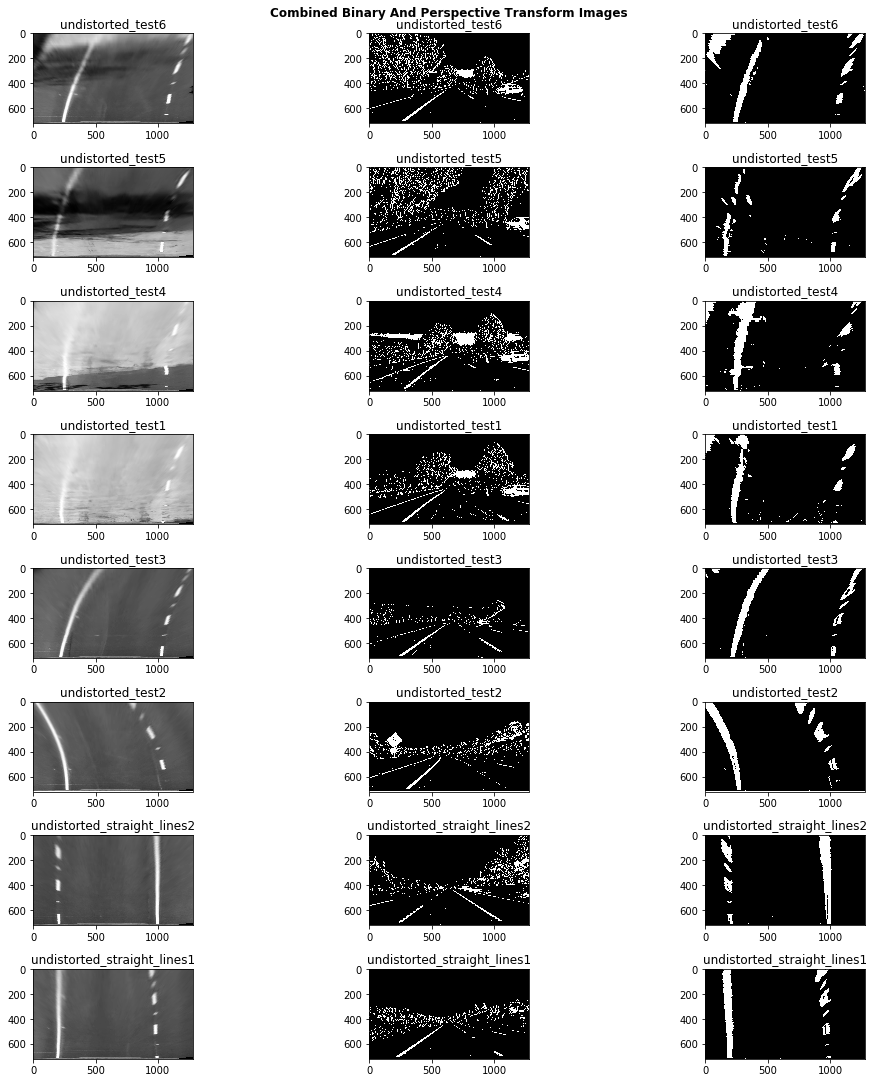

In [110]:
show_image_list(test_imgs_combined_binary_and_psp_tr, test_imgs_combined_binary_and_psp_tr_names, "Combined Binary And Perspective Transform Images", cols=3, fig_size=(15, 15))

The perspective transform, then application of color and gradient thresholding enable us to clearly identify the position of the lanes on the bird's eye view image. However, we also notice some small dots and other visual artifacts. We must build a robust lane finder in order not to be caught by these glitches.

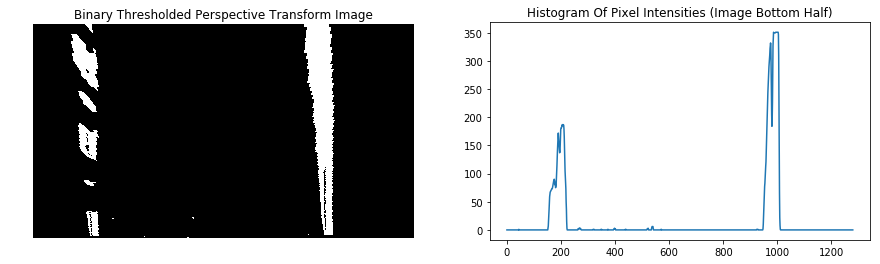

In [111]:
img_example = test_imgs_combined_binary_and_psp_tr[6][2]
histogram = np.sum(img_example[img_example.shape[0]//2:,:], axis=0)

fig, ax = plt.subplots(1, 2, figsize=(15,4))
ax[0].imshow(img_example, cmap='gray')
ax[0].axis("off")
ax[0].set_title("Binary Thresholded Perspective Transform Image")

ax[1].plot(histogram)
ax[1].set_title("Histogram Of Pixel Intensities (Image Bottom Half)")

plt.show()

## ------------------------------ -------------------------------- --------------------------------------- 

# Pipeline Definition

Let's now define our full pipeline for lane detection on video frames. We will use Python classes to encapsulate a information and use it across frames.

In [112]:
from collections import deque

def create_queue(length = 10):
    return deque(maxlen=length)

In [113]:
class LaneLine:
    def __init__(self):
        
        self.polynomial_coeff = None
        self.line_fit_x = None
        self.non_zero_x = []
        self.non_zero_y = []
        self.windows = []

In [114]:
import math

class LaneLineHistory:
    def __init__(self, queue_depth=2, test_points=[50, 300, 500, 700], poly_max_deviation_distance=150):
        self.lane_lines = create_queue(queue_depth)
        self.smoothed_poly = None
        self.test_points = test_points
        self.poly_max_deviation_distance = poly_max_deviation_distance
    
    def append(self, lane_line, force=False):
        if len(self.lane_lines) == 0 or force:
            self.lane_lines.append(lane_line)
            self.get_smoothed_polynomial()
            return True
        
        test_y_smooth = np.asarray(list(map(lambda x: self.smoothed_poly[0] * x**2 + self.smoothed_poly[1] * x + self.smoothed_poly[2], self.test_points)))
        test_y_new = np.asarray(list(map(lambda x: lane_line.polynomial_coeff[0] * x**2 + lane_line.polynomial_coeff[1] * x + lane_line.polynomial_coeff[2], self.test_points)))
        
        dist = np.absolute(test_y_smooth - test_y_new)
        
   
        max_dist = dist[np.argmax(dist)]
        
        if max_dist > self.poly_max_deviation_distance:
            print("**** Maximum DISTANCE BREACHED ****")
            print("y_smooth={0} - y_new={1} - distance={2} - max-distance={3}".format(test_y_smooth, test_y_new, max_dist, self.poly_max_deviation_distance))
            return False
        
        self.lane_lines.append(lane_line)
        self.get_smoothed_polynomial()
        
        return True
    
    def get_smoothed_polynomial(self):
        all_coeffs = np.asarray(list(map(lambda lane_line: lane_line.polynomial_coeff, self.lane_lines)))
        self.smoothed_poly = np.mean(all_coeffs, axis=0)
        
        return self.smoothed_poly
                                
        

In [115]:
class AdvancedLaneDetectorWithMemory:
    """
    The AdvancedLaneDetectorWithMemory is a class that can detect lines on the road
    """
    def __init__(self, objpts, imgpts, psp_src, psp_dst, sliding_windows_per_line, 
                 sliding_window_half_width, sliding_window_recenter_thres, 
                 small_img_size=(256, 144), small_img_x_offset=20, small_img_y_offset=10,
                 img_dimensions=(720, 1280), lane_width_px=800, 
                 lane_center_px_psp=600, real_world_lane_size_meters=(32, 3.7)):
        self.objpts = objpts
        self.imgpts = imgpts
        (self.M_psp, self.M_inv_psp) = compute_perspective_transform_matrices(psp_src, psp_dst)

        self.sliding_windows_per_line = sliding_windows_per_line
        self.sliding_window_half_width = sliding_window_half_width
        self.sliding_window_recenter_thres = sliding_window_recenter_thres
        
        self.small_img_size = small_img_size
        self.small_img_x_offset = small_img_x_offset
        self.small_img_y_offset = small_img_y_offset
        
        self.img_dimensions = img_dimensions
        self.lane_width_px = lane_width_px
        self.lane_center_px_psp = lane_center_px_psp 
        self.real_world_lane_size_meters = real_world_lane_size_meters

        # We can pre-compute some data here
        self.ym_per_px = self.real_world_lane_size_meters[0] / self.img_dimensions[0]
        self.xm_per_px = self.real_world_lane_size_meters[1] / self.lane_width_px
        self.ploty = np.linspace(0, self.img_dimensions[0] - 1, self.img_dimensions[0])
        
        self.previous_left_lane_line = None
        self.previous_right_lane_line = None
        
        self.previous_left_lane_lines = LaneLineHistory()
        self.previous_right_lane_lines = LaneLineHistory()
        
        self.total_img_count = 0
        
    
    def process_image(self, img):
        """
        Attempts to find lane lines on the given image and returns an image with lane area colored in green
        as well as small intermediate images overlaid on top to understand how the algorithm is performing
        """
        # First step - undistort the image using the instance's object and image points
        undist_img = undistort_image(img, self.objpts, self.imgpts)
        
        # Produce binary thresholded image from color and gradients
        thres_img = get_combined_binary_thresholded_img(undist_img)
        
        # Create the undistorted and binary perspective transforms
        img_size = (undist_img.shape[1], undist_img.shape[0])
        undist_img_psp = cv2.warpPerspective(undist_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        thres_img_psp = cv2.warpPerspective(thres_img, self.M_psp, img_size, flags=cv2.INTER_LINEAR)
        
        ll, rl = self.compute_lane_lines(thres_img_psp)
        lcr, rcr, lco = self.compute_lane_curvature(ll, rl)

        drawn_lines = self.draw_lane_lines(thres_img_psp, ll, rl)        
        #plt.imshow(drawn_lines)
        
        drawn_lines_regions = self.draw_lane_lines_regions(thres_img_psp, ll, rl)
        #plt.imshow(drawn_lines_regions)
        
        drawn_lane_area = self.draw_lane_area(thres_img_psp, undist_img, ll, rl)        
        #plt.imshow(drawn_lane_area)
        
        drawn_hotspots = self.draw_lines_hotspots(thres_img_psp, ll, rl)
        
        combined_lane_img = self.combine_images(drawn_lane_area, drawn_lines, drawn_lines_regions, drawn_hotspots, undist_img_psp)
        final_img = self.draw_lane_curvature_text(combined_lane_img, lcr, rcr, lco)
        
        self.total_img_count += 1
        self.previous_left_lane_line = ll
        self.previous_right_lane_line = rl
        
        return final_img
    
    def draw_lane_curvature_text(self, img, left_curvature_meters, right_curvature_meters, center_offset_meters):
        """
        Returns an image with curvature information inscribed
        """
        
        offset_y = self.small_img_size[1] * 1 + self.small_img_y_offset * 5
        offset_x = self.small_img_x_offset
        
        template = "{0:17}{1:17}{2:17}"
        txt_header = template.format("Left Curvature", "Right Curvature", "Center Alignment") 
        print(txt_header)
        txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Right".format(center_offset_meters))
        if center_offset_meters < 0.0:
            txt_values = template.format("{:.4f}m".format(left_curvature_meters), 
                                     "{:.4f}m".format(right_curvature_meters),
                                     "{:.4f}m Left".format(math.fabs(center_offset_meters)))
            
        
        print(txt_values)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(img, txt_header, (offset_x, offset_y), font, 1, (255,255,255), 1, cv2.LINE_AA)
        cv2.putText(img, txt_values, (offset_x, offset_y + self.small_img_y_offset * 5), font, 1, (255,255,255), 2, cv2.LINE_AA)
        
        return img
    
    def combine_images(self, lane_area_img, lines_img, lines_regions_img, lane_hotspots_img, psp_color_img):        
        """
        Returns a new image made up of the lane area image, and the remaining lane images are overlaid as
        small images in a row at the top of the the new image
        """
        small_lines = cv2.resize(lines_img, self.small_img_size)
        small_region = cv2.resize(lines_regions_img, self.small_img_size)
        small_hotspots = cv2.resize(lane_hotspots_img, self.small_img_size)
        small_color_psp = cv2.resize(psp_color_img, self.small_img_size)
                
        lane_area_img[self.small_img_y_offset: self.small_img_y_offset + self.small_img_size[1], self.small_img_x_offset: self.small_img_x_offset + self.small_img_size[0]] = small_lines
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 2 * self.small_img_x_offset + self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_region
        
        start_offset_y = self.small_img_y_offset 
        start_offset_x = 3 * self.small_img_x_offset + 2 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_hotspots

        start_offset_y = self.small_img_y_offset 
        start_offset_x = 4 * self.small_img_x_offset + 3 * self.small_img_size[0]
        lane_area_img[start_offset_y: start_offset_y + self.small_img_size[1], start_offset_x: start_offset_x + self.small_img_size[0]] = small_color_psp
        
        
        return lane_area_img
    
        
    def draw_lane_area(self, warped_img, undist_img, left_line, right_line):
        """
        Returns an image where the inside of the lane has been colored in bright green
        """
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped_img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_line.line_fit_x, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.M_inv_psp, (undist_img.shape[1], undist_img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
        
        return result
        
        
    def draw_lane_lines(self, warped_img, left_line, right_line):
        """
        Returns an image where the computed lane lines have been drawn on top of the original warped binary image
        """
        # Create an output image with 3 colors (RGB) from the binary warped image to draw on and  visualize the result
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        # Now draw the lines
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        pts_left = np.dstack((left_line.line_fit_x, ploty)).astype(np.int32)
        pts_right = np.dstack((right_line.line_fit_x, ploty)).astype(np.int32)

        cv2.polylines(out_img, pts_left, False,  (255, 140,0), 5)
        cv2.polylines(out_img, pts_right, False, (255, 140,0), 5)
        
        for low_pt, high_pt in left_line.windows:
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)

        for low_pt, high_pt in right_line.windows:            
            cv2.rectangle(out_img, low_pt, high_pt, (0, 255, 0), 3)           
        
        return out_img    
    
    def draw_lane_lines_regions(self, warped_img, left_line, right_line):
        """
        Returns an image where the computed left and right lane areas have been drawn on top of the original warped binary image
        """
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        margin = self.sliding_window_half_width
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0])
        
        left_line_window1 = np.array([np.transpose(np.vstack([left_line.line_fit_x - margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_line.line_fit_x + margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        
        right_line_window1 = np.array([np.transpose(np.vstack([right_line.line_fit_x - margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_line.line_fit_x + margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Create RGB image from binary warped image
        region_img = np.dstack((warped_img, warped_img, warped_img)) * 255

        # Draw the lane onto the warped blank image
        cv2.fillPoly(region_img, np.int_([left_line_pts]), (0, 255, 0))
        cv2.fillPoly(region_img, np.int_([right_line_pts]), (0, 255, 0))
        
        return region_img


    def draw_lines_hotspots(self, warped_img, left_line, right_line):
        """
        Returns a RGB image where the portions of the lane lines that were
        identified by our pipeline are colored in yellow (left) and blue (right)
        """
        out_img = np.dstack((warped_img, warped_img, warped_img))*255
        
        out_img[left_line.non_zero_y, left_line.non_zero_x] = [255, 255, 0]
        out_img[right_line.non_zero_y, right_line.non_zero_x] = [0, 0, 255]
        
        return out_img

    def compute_lane_curvature(self, left_line, right_line):
        """
        Returns the triple (left_curvature, right_curvature, lane_center_offset), which are all in meters
        """        
        ploty = self.ploty
        y_eval = np.max(ploty)
        # Define conversions in x and y from pixels space to meters
        
        leftx = left_line.line_fit_x
        rightx = right_line.line_fit_x
        
        # Fit new polynomials: find x for y in real-world space
        left_fit_cr = np.polyfit(ploty * self.ym_per_px, leftx * self.xm_per_px, 2)
        right_fit_cr = np.polyfit(ploty * self.ym_per_px, rightx * self.xm_per_px, 2)
        
        # Now calculate the radii of the curvature
        left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * self.ym_per_px + left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
        right_curverad = ((1 + (2 *right_fit_cr[0] * y_eval * self.ym_per_px + right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
        
        # Use our computed polynomial to determine the car's center position in image space, then
        left_fit = left_line.polynomial_coeff
        right_fit = right_line.polynomial_coeff
        
        center_offset_img_space = (((left_fit[0] * y_eval**2 + left_fit[1] * y_eval + left_fit[2]) + 
                   (right_fit[0] * y_eval**2 + right_fit[1] * y_eval + right_fit[2])) / 2) - self.lane_center_px_psp
        center_offset_real_world_m = center_offset_img_space * self.xm_per_px
        
        # Now our radius of curvature is in meters        
        return left_curverad, right_curverad, center_offset_real_world_m
        
        
        
    def compute_lane_lines(self, warped_img):
        """
        Returns the tuple (left_lane_line, right_lane_line) which represents respectively the LaneLine instances for
        the computed left and right lanes, for the supplied binary warped image
        """

        # Take a histogram of the bottom half of the image, summing pixel values column wise 
        histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines 
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint # don't forget to offset by midpoint!
        

        # Set height of windows
        window_height = np.int(warped_img.shape[0]//self.sliding_windows_per_line)
        # Identify the x and y positions of all nonzero pixels in the image
        # NOTE: nonzero returns a tuple of arrays in y and x directions
        nonzero = warped_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        total_non_zeros = len(nonzeroy)
        non_zero_found_pct = 0.0
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base    


        # Set the width of the windows +/- margin
        margin = self.sliding_window_half_width
        # Set minimum number of pixels found to recenter window
        minpix = self.sliding_window_recenter_thres
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Our lane line objects we store the result of this computation
        left_line = LaneLine()
        right_line = LaneLine()
                        
        if self.previous_left_lane_line is not None and self.previous_right_lane_line is not None:
            # We have already computed the lane lines polynomials from a previous image
            left_lane_inds = ((nonzerox > (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_left_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_left_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_left_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_left_lane_line.polynomial_coeff[2] + margin))) 

            right_lane_inds = ((nonzerox > (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                           + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                           + self.previous_right_lane_line.polynomial_coeff[2] - margin)) 
                              & (nonzerox < (self.previous_right_lane_line.polynomial_coeff[0] * (nonzeroy**2) 
                                            + self.previous_right_lane_line.polynomial_coeff[1] * nonzeroy 
                                            + self.previous_right_lane_line.polynomial_coeff[2] + margin))) 
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Previous lane] Found pct={0}".format(non_zero_found_pct))
            #print(left_lane_inds)
        
        if non_zero_found_pct < 0.85:
            print("Non zeros found below thresholds, begining sliding window - pct={0}".format(non_zero_found_pct))
            left_lane_inds = []
            right_lane_inds = []

            # Step through the windows one by one
            for window in range(self.sliding_windows_per_line):
                # Identify window boundaries in x and y (and right and left)
                # We are moving our windows from the bottom to the top of the screen (highest to lowest y value)
                win_y_low = warped_img.shape[0] - (window + 1)* window_height
                win_y_high = warped_img.shape[0] - window * window_height

                # Defining our window's coverage in the horizontal (i.e. x) direction 
                # Notice that the window's width is twice the margin
                win_xleft_low = leftx_current - margin
                win_xleft_high = leftx_current + margin
                win_xright_low = rightx_current - margin
                win_xright_high = rightx_current + margin

                left_line.windows.append([(win_xleft_low,win_y_low),(win_xleft_high,win_y_high)])
                right_line.windows.append([(win_xright_low,win_y_low),(win_xright_high,win_y_high)])

                # Super crytic and hard to understand...
                # Basically nonzerox and nonzeroy have the same size and any nonzero pixel is identified by
                # (nonzeroy[i],nonzerox[i]), therefore we just return the i indices within the window that are nonzero
                # and can then index into nonzeroy and nonzerox to find the ACTUAL pixel coordinates that are not zero
                good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
                good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
                            
                # Append these indices to the lists
                left_lane_inds.append(good_left_inds)
                right_lane_inds.append(good_right_inds)

                # If you found > minpix pixels, recenter next window on their mean position
                if len(good_left_inds) > minpix:
                    leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
                if len(good_right_inds) > minpix:        
                    rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            # Concatenate the arrays of indices since we now have a list of multiple arrays (e.g. ([1,3,6],[8,5,2]))
            # We want to create a single array with elements from all those lists (e.g. [1,3,6,8,5,2])
            # These are the indices that are non zero in our sliding windows
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
            
            non_zero_found_left = np.sum(left_lane_inds)
            non_zero_found_right = np.sum(right_lane_inds)
            non_zero_found_pct = (non_zero_found_left + non_zero_found_right) / total_non_zeros
           
            print("[Sliding windows] Found pct={0}".format(non_zero_found_pct))
            
    
        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        #print("[LEFT] Number of hot pixels={0}".format(len(leftx)))
        #print("[RIGHT] Number of hot pixels={0}".format(len(rightx)))
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        #print("Poly left {0}".format(left_fit))
        #print("Poly right {0}".format(right_fit))
        left_line.polynomial_coeff = left_fit
        right_line.polynomial_coeff = right_fit
        
        if not self.previous_left_lane_lines.append(left_line):
            left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            left_line.polynomial_coeff = left_fit
            self.previous_left_lane_lines.append(left_line, force=True)
            print("**** REVISED Poly left {0}".format(left_fit))            
        #else:
            #left_fit = self.previous_left_lane_lines.get_smoothed_polynomial()
            #left_line.polynomial_coeff = left_fit


        if not self.previous_right_lane_lines.append(right_line):
            right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            right_line.polynomial_coeff = right_fit
            self.previous_right_lane_lines.append(right_line, force=True)
            print("**** REVISED Poly right {0}".format(right_fit))
        #else:
            #right_fit = self.previous_right_lane_lines.get_smoothed_polynomial()
            #right_line.polynomial_coeff = right_fit


    
        # Generate x and y values for plotting
        ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[0] )
        left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
        right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]
        
        
        left_line.polynomial_coeff = left_fit
        left_line.line_fit_x = left_fitx
        left_line.non_zero_x = leftx  
        left_line.non_zero_y = lefty

        right_line.polynomial_coeff = right_fit
        right_line.line_fit_x = right_fitx
        right_line.non_zero_x = rightx
        right_line.non_zero_y = righty

        
        return (left_line, right_line)

In [116]:
ld = AdvancedLaneDetectorWithMemory(objpoints, imgpoints, src_pts, dst_pts, 20, 100, 50)

In [117]:
proc_img = ld.process_image(test_img)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=30514.088475751334
Left Curvature   Right Curvature  Center Alignment 
6027.9348m       4465.7227m       0.0276m Left     


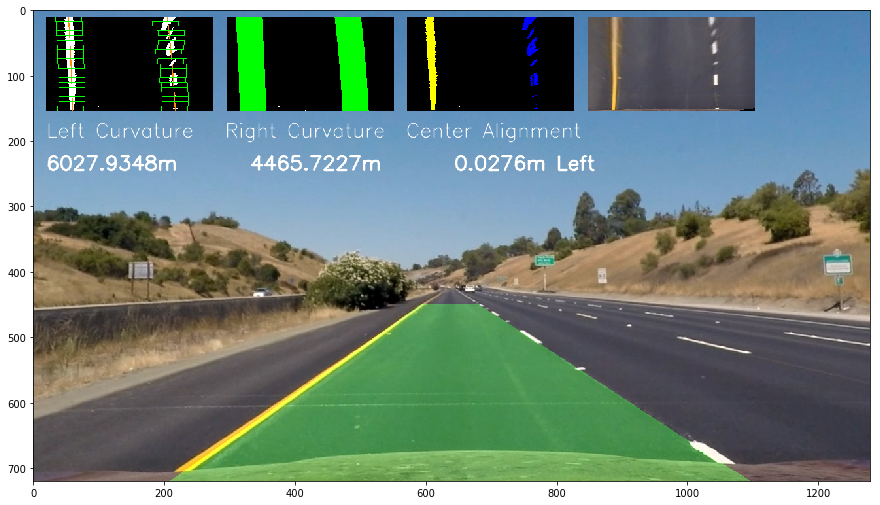

In [118]:
plt.figure(figsize=(15,10))
plt.imshow(proc_img)

## Normal video

In [119]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [120]:
project_video_path = "project_video.mp4"
project_video_sample_path = 'project_video_sample.mp4'
challenge_video_path = "challenge_video.mp4"
challenge_video_sample_path = "challenge_video_sample.mp4"



project_video_output_path = 'output_videos/lanes_project_video.mp4'
project_video_sample_output_path = 'output_videos/lanes_project_video_sample.mp4'
challenge_video_output_path = 'output_videos/lanes_challenge_video.mp4'
challenge_video_sample_output_path = 'output_videos/lanes_challenge_video_sample.mp4'

#### Project video sample

In [121]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(project_video_path, 22, 27, targetname=project_video_sample_path)


[MoviePy] Running:
>>> /Users/sathisr/Library/Application Support/imageio/ffmpeg/ffmpeg-osx-v3.2.4 -y -i project_video.mp4 -ss 22.00 -t 5.00 -vcodec copy -acodec copy project_video_sample.mp4
... command successful.


In [122]:
detector = AdvancedLaneDetectorWithMemory(objpoints, imgpoints, src_pts, dst_pts, 20, 50, 10)

clip1 = VideoFileClip(project_video_sample_path)
project_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_sample_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=14795.34371395617
Left Curvature   Right Curvature  Center Alignment 
1483.9492m       3167.8192m       0.0996m Right    
[MoviePy] >>>> Building video output_videos/lanes_project_video_sample.mp4
[MoviePy] Writing video output_videos/lanes_project_video_sample.mp4


  1%|          | 1/125 [00:01<02:24,  1.17s/it]

[Previous lane] Found pct=0.9068997131280868
Left Curvature   Right Curvature  Center Alignment 
1334.0390m       3362.2641m       0.1016m Right    


  2%|▏         | 2/125 [00:02<02:21,  1.15s/it]

[Previous lane] Found pct=0.9083784343299914
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3434.1070m       0.1023m Right    


  2%|▏         | 3/125 [00:03<02:16,  1.12s/it]

[Previous lane] Found pct=0.9087037529944104
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3450.3450m       0.1024m Right    


  3%|▎         | 4/125 [00:04<02:13,  1.10s/it]

[Previous lane] Found pct=0.9087924762665247
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3452.4203m       0.1024m Right    


  4%|▍         | 5/125 [00:05<02:11,  1.10s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


  5%|▍         | 6/125 [00:06<02:09,  1.09s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


  6%|▌         | 7/125 [00:07<02:10,  1.11s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


  6%|▋         | 8/125 [00:08<02:08,  1.10s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


  7%|▋         | 9/125 [00:09<02:06,  1.09s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


  8%|▊         | 10/125 [00:11<02:08,  1.12s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


  9%|▉         | 11/125 [00:12<02:07,  1.12s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 10%|▉         | 12/125 [00:13<02:03,  1.09s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 10%|█         | 13/125 [00:14<02:00,  1.08s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 11%|█         | 14/125 [00:15<01:58,  1.07s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 12%|█▏        | 15/125 [00:16<01:56,  1.06s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 13%|█▎        | 16/125 [00:17<01:55,  1.06s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 14%|█▎        | 17/125 [00:18<01:59,  1.11s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 14%|█▍        | 18/125 [00:19<02:01,  1.13s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 15%|█▌        | 19/125 [00:20<01:58,  1.12s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 16%|█▌        | 20/125 [00:21<01:55,  1.10s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 17%|█▋        | 21/125 [00:22<01:52,  1.09s/it]

[Previous lane] Found pct=0.9088220506905628
Left Curvature   Right Curvature  Center Alignment 
1336.4972m       3454.0655m       0.1024m Right    


 18%|█▊        | 22/125 [00:24<01:50,  1.07s/it]

[Previous lane] Found pct=0.8832915431958058
Left Curvature   Right Curvature  Center Alignment 
1149.2338m       2897.5190m       0.1011m Right    


 18%|█▊        | 23/125 [00:25<01:49,  1.08s/it]

[Previous lane] Found pct=0.8899844317592112
Left Curvature   Right Curvature  Center Alignment 
1157.2473m       3070.2735m       0.1040m Right    


 19%|█▉        | 24/125 [00:26<01:49,  1.08s/it]

[Previous lane] Found pct=0.8843622297782076
Left Curvature   Right Curvature  Center Alignment 
1017.3340m       3296.8939m       0.1145m Right    


 20%|██        | 25/125 [00:27<01:46,  1.07s/it]

[Previous lane] Found pct=0.870750600412678
Left Curvature   Right Curvature  Center Alignment 
822.0724m        3813.9553m       0.1178m Right    


 21%|██        | 26/125 [00:28<01:45,  1.07s/it]

[Previous lane] Found pct=0.8607212123204365
Left Curvature   Right Curvature  Center Alignment 
838.8134m        2547.9376m       0.1322m Right    


 22%|██▏       | 27/125 [00:29<01:43,  1.06s/it]

[Previous lane] Found pct=0.8931860036832413
Left Curvature   Right Curvature  Center Alignment 
1252.9051m       2891.3311m       0.1801m Right    


 22%|██▏       | 28/125 [00:30<01:42,  1.06s/it]

[Previous lane] Found pct=0.8916472991055708
Left Curvature   Right Curvature  Center Alignment 
1374.2549m       969.9903m        0.2087m Right    


 23%|██▎       | 29/125 [00:31<01:41,  1.06s/it]

[Previous lane] Found pct=0.8936295373542337
Left Curvature   Right Curvature  Center Alignment 
1687.2785m       780.7234m        0.2119m Right    


 24%|██▍       | 30/125 [00:32<01:41,  1.07s/it]

[Previous lane] Found pct=0.882543338209206
Left Curvature   Right Curvature  Center Alignment 
2532.7438m       842.2084m        0.2112m Right    


 25%|██▍       | 31/125 [00:33<01:41,  1.08s/it]

[Previous lane] Found pct=0.9044788197578512
Left Curvature   Right Curvature  Center Alignment 
3400.8444m       751.7638m        0.2190m Right    


 26%|██▌       | 32/125 [00:34<01:40,  1.08s/it]

[Previous lane] Found pct=0.8900443796780817
Left Curvature   Right Curvature  Center Alignment 
1797.0402m       841.9135m        0.1939m Right    


 26%|██▋       | 33/125 [00:35<01:41,  1.10s/it]

[Previous lane] Found pct=0.8914877427465511
Left Curvature   Right Curvature  Center Alignment 
1051.2119m       845.6215m        0.1658m Right    


 27%|██▋       | 34/125 [00:37<01:41,  1.12s/it]

[Previous lane] Found pct=0.9059175047369188
Left Curvature   Right Curvature  Center Alignment 
639.3996m        837.3837m        0.1376m Right    


 28%|██▊       | 35/125 [00:38<01:40,  1.11s/it]

[Previous lane] Found pct=0.9037276809021614
Left Curvature   Right Curvature  Center Alignment 
748.8109m        813.7042m        0.1303m Right    


 29%|██▉       | 36/125 [00:39<01:39,  1.12s/it]

[Previous lane] Found pct=0.8949881525095139
Left Curvature   Right Curvature  Center Alignment 
708.0181m        772.7521m        0.1379m Right    


 30%|██▉       | 37/125 [00:40<01:39,  1.13s/it]

[Previous lane] Found pct=0.9046292705285055
Left Curvature   Right Curvature  Center Alignment 
584.1126m        700.2371m        0.1272m Right    


 30%|███       | 38/125 [00:41<01:38,  1.14s/it]

[Previous lane] Found pct=0.888262910798122
Left Curvature   Right Curvature  Center Alignment 
487.3217m        937.5727m        0.1179m Right    


 31%|███       | 39/125 [00:42<01:38,  1.15s/it]

[Previous lane] Found pct=0.8909268219496643
Left Curvature   Right Curvature  Center Alignment 
560.5807m        1701.5025m       0.1011m Right    


 32%|███▏      | 40/125 [00:43<01:37,  1.15s/it]

[Previous lane] Found pct=0.907345513963161
Left Curvature   Right Curvature  Center Alignment 
627.6276m        419.2128m        0.1733m Right    


 33%|███▎      | 41/125 [00:45<01:36,  1.15s/it]

[Previous lane] Found pct=0.903732955815513
Left Curvature   Right Curvature  Center Alignment 
500.8815m        393.6282m        0.1525m Right    


 34%|███▎      | 42/125 [00:46<01:35,  1.15s/it]

[Previous lane] Found pct=0.8735130251468153
Left Curvature   Right Curvature  Center Alignment 
429.7437m        339.9272m        0.1395m Right    


 34%|███▍      | 43/125 [00:47<01:34,  1.15s/it]

[Previous lane] Found pct=0.8305501337381623
Non zeros found below thresholds, begining sliding window - pct=0.8305501337381623
[Sliding windows] Found pct=11640.069977589821
Left Curvature   Right Curvature  Center Alignment 
411.9685m        6439.7173m       0.0427m Right    


 35%|███▌      | 44/125 [00:48<01:34,  1.16s/it]

[Previous lane] Found pct=0.8433968356474008
Non zeros found below thresholds, begining sliding window - pct=0.8433968356474008
[Sliding windows] Found pct=11656.088293330464
Left Curvature   Right Curvature  Center Alignment 
4423.5157m       5454.0140m       0.0555m Right    


 36%|███▌      | 45/125 [00:49<01:32,  1.16s/it]

[Previous lane] Found pct=0.9050070700844784
Left Curvature   Right Curvature  Center Alignment 
2508.2517m       2731.0525m       0.0577m Right    


 37%|███▋      | 46/125 [00:50<01:32,  1.17s/it]

[Previous lane] Found pct=0.8763664757938574
Left Curvature   Right Curvature  Center Alignment 
2651.3825m       2527.6096m       0.0582m Right    


 38%|███▊      | 47/125 [00:52<01:31,  1.17s/it]

[Previous lane] Found pct=0.8945586839607719
Left Curvature   Right Curvature  Center Alignment 
4076.9189m       1961.5402m       0.0648m Right    


 38%|███▊      | 48/125 [00:53<01:29,  1.16s/it]

[Previous lane] Found pct=0.8846072983931521
Left Curvature   Right Curvature  Center Alignment 
3614.5080m       1495.6407m       0.0595m Right    


 39%|███▉      | 49/125 [00:54<01:27,  1.15s/it]

[Previous lane] Found pct=0.861794183690235
Left Curvature   Right Curvature  Center Alignment 
3662.7418m       977.6529m        0.0647m Right    


 40%|████      | 50/125 [00:55<01:26,  1.16s/it]

[Previous lane] Found pct=0.9050002944814183
Left Curvature   Right Curvature  Center Alignment 
5643.8238m       621.4254m        0.0990m Right    


 41%|████      | 51/125 [00:56<01:25,  1.16s/it]

[Previous lane] Found pct=0.8600712773654171
Left Curvature   Right Curvature  Center Alignment 
3367.7980m       520.1255m        0.1301m Right    


 42%|████▏     | 52/125 [00:57<01:24,  1.16s/it]

[Previous lane] Found pct=0.9002798968223479
Left Curvature   Right Curvature  Center Alignment 
4879.8788m       460.7488m        0.1506m Right    


 42%|████▏     | 53/125 [00:59<01:23,  1.16s/it]

[Previous lane] Found pct=0.8979374509584127
Left Curvature   Right Curvature  Center Alignment 
16100.5500m      431.0253m        0.1463m Right    


 43%|████▎     | 54/125 [01:00<01:22,  1.16s/it]

[Previous lane] Found pct=0.8948421821329078
Left Curvature   Right Curvature  Center Alignment 
1421.2413m       368.0198m        0.1586m Right    


 44%|████▍     | 55/125 [01:01<01:22,  1.18s/it]

[Previous lane] Found pct=0.8476263820892238
Non zeros found below thresholds, begining sliding window - pct=0.8476263820892238
[Sliding windows] Found pct=16479.815473898456
Left Curvature   Right Curvature  Center Alignment 
686.8538m        527.3549m        0.1130m Right    


 45%|████▍     | 56/125 [01:02<01:21,  1.18s/it]

[Previous lane] Found pct=0.9163761137860424
Left Curvature   Right Curvature  Center Alignment 
612.5613m        448.8446m        0.0981m Right    


 46%|████▌     | 57/125 [01:03<01:21,  1.19s/it]

[Previous lane] Found pct=0.9540822009356204
Left Curvature   Right Curvature  Center Alignment 
528.5098m        388.7999m        0.0837m Right    


 46%|████▋     | 58/125 [01:05<01:21,  1.21s/it]

[Previous lane] Found pct=0.9190463917525773
Left Curvature   Right Curvature  Center Alignment 
526.7391m        425.6071m        0.0608m Right    


 47%|████▋     | 59/125 [01:06<01:21,  1.23s/it]

[Previous lane] Found pct=0.9170067688632292
Left Curvature   Right Curvature  Center Alignment 
535.9572m        423.5665m        0.0442m Right    


 48%|████▊     | 60/125 [01:07<01:22,  1.27s/it]

[Previous lane] Found pct=0.914096323655309
Left Curvature   Right Curvature  Center Alignment 
521.4135m        419.9876m        0.0308m Right    


 49%|████▉     | 61/125 [01:09<01:22,  1.28s/it]

[Previous lane] Found pct=0.9137358672119317
Left Curvature   Right Curvature  Center Alignment 
519.9188m        439.6787m        0.0114m Right    


 50%|████▉     | 62/125 [01:10<01:21,  1.29s/it]

[Previous lane] Found pct=0.904247928142524
Left Curvature   Right Curvature  Center Alignment 
411.8401m        531.1996m        0.0141m Left     


 50%|█████     | 63/125 [01:11<01:21,  1.32s/it]

[Previous lane] Found pct=0.9059149722735674
Left Curvature   Right Curvature  Center Alignment 
339.8446m        745.1405m        0.0659m Left     


 51%|█████     | 64/125 [01:13<01:20,  1.32s/it]

[Previous lane] Found pct=0.9207345206237889
Left Curvature   Right Curvature  Center Alignment 
327.1854m        765.0124m        0.0845m Left     


 52%|█████▏    | 65/125 [01:14<01:19,  1.32s/it]

[Previous lane] Found pct=0.9198089101210977
Left Curvature   Right Curvature  Center Alignment 
330.9910m        849.5502m        0.0948m Left     


 53%|█████▎    | 66/125 [01:15<01:18,  1.32s/it]

[Previous lane] Found pct=0.9244865515167139
Left Curvature   Right Curvature  Center Alignment 
333.4914m        654.0331m        0.0878m Left     


 54%|█████▎    | 67/125 [01:16<01:16,  1.31s/it]

[Previous lane] Found pct=0.911653127706074
Left Curvature   Right Curvature  Center Alignment 
324.6065m        525.1932m        0.0800m Left     


 54%|█████▍    | 68/125 [01:18<01:14,  1.30s/it]

[Previous lane] Found pct=0.9332370371943837
Left Curvature   Right Curvature  Center Alignment 
329.9316m        531.3374m        0.0839m Left     


 55%|█████▌    | 69/125 [01:19<01:13,  1.30s/it]

[Previous lane] Found pct=0.8982973049769404
Left Curvature   Right Curvature  Center Alignment 
328.5377m        469.6804m        0.0854m Left     


 56%|█████▌    | 70/125 [01:20<01:11,  1.31s/it]

[Previous lane] Found pct=0.942516385516278
Left Curvature   Right Curvature  Center Alignment 
320.7352m        487.0053m        0.0846m Left     


 57%|█████▋    | 71/125 [01:22<01:11,  1.32s/it]

[Previous lane] Found pct=0.9472951597595698
Left Curvature   Right Curvature  Center Alignment 
320.4712m        459.3909m        0.0838m Left     


 58%|█████▊    | 72/125 [01:23<01:10,  1.33s/it]

[Previous lane] Found pct=0.9685166082112647
Left Curvature   Right Curvature  Center Alignment 
346.4888m        532.8559m        0.0868m Left     


 58%|█████▊    | 73/125 [01:24<01:09,  1.34s/it]

[Previous lane] Found pct=0.9629396325459317
Left Curvature   Right Curvature  Center Alignment 
365.0611m        567.4091m        0.0782m Left     


 59%|█████▉    | 74/125 [01:26<01:08,  1.34s/it]

[Previous lane] Found pct=0.9638667484161046
Left Curvature   Right Curvature  Center Alignment 
372.6083m        604.5288m        0.0764m Left     


 60%|██████    | 75/125 [01:27<01:07,  1.35s/it]

[Previous lane] Found pct=0.735604233521357
Non zeros found below thresholds, begining sliding window - pct=0.735604233521357
[Sliding windows] Found pct=23119.28548364593
Left Curvature   Right Curvature  Center Alignment 
317.9657m        423.6703m        0.0434m Left     


 61%|██████    | 76/125 [01:29<01:07,  1.37s/it]

[Previous lane] Found pct=0.8605465331129047
Left Curvature   Right Curvature  Center Alignment 
321.2357m        425.6810m        0.0307m Left     


 62%|██████▏   | 77/125 [01:30<01:05,  1.37s/it]

[Previous lane] Found pct=0.8790518024840958
Left Curvature   Right Curvature  Center Alignment 
318.9421m        412.7297m        0.0211m Left     


 62%|██████▏   | 78/125 [01:31<01:04,  1.36s/it]

[Previous lane] Found pct=0.8465337132003798
Non zeros found below thresholds, begining sliding window - pct=0.8465337132003798
[Sliding windows] Found pct=23368.788698955366
Left Curvature   Right Curvature  Center Alignment 
339.3174m        342.3656m        0.0077m Right    


 63%|██████▎   | 79/125 [01:33<01:02,  1.35s/it]

[Previous lane] Found pct=0.8194405643246263
Non zeros found below thresholds, begining sliding window - pct=0.8194405643246263
[Sliding windows] Found pct=25262.996944405644
Left Curvature   Right Curvature  Center Alignment 
381.3755m        319.6393m        0.0546m Right    


 64%|██████▍   | 80/125 [01:34<01:01,  1.36s/it]

[Previous lane] Found pct=0.7941749427043545
Non zeros found below thresholds, begining sliding window - pct=0.7941749427043545
[Sliding windows] Found pct=25051.930939648588
Left Curvature   Right Curvature  Center Alignment 
462.8301m        426.1410m        0.0382m Right    


 65%|██████▍   | 81/125 [01:35<00:59,  1.35s/it]

[Previous lane] Found pct=0.8971990081733859
Left Curvature   Right Curvature  Center Alignment 
523.4961m        599.0076m        0.0007m Right    


 66%|██████▌   | 82/125 [01:37<00:58,  1.35s/it]

[Previous lane] Found pct=0.9197884369870509
Left Curvature   Right Curvature  Center Alignment 
549.8394m        787.3950m        0.0125m Left     


 66%|██████▋   | 83/125 [01:38<00:56,  1.35s/it]

[Previous lane] Found pct=0.9859771969058181
Left Curvature   Right Curvature  Center Alignment 
665.4142m        804.2296m        0.0238m Left     


 67%|██████▋   | 84/125 [01:39<00:55,  1.37s/it]

[Previous lane] Found pct=0.9659173313995649
Left Curvature   Right Curvature  Center Alignment 
623.8342m        483.9522m        0.0037m Right    


 68%|██████▊   | 85/125 [01:41<00:54,  1.37s/it]

[Previous lane] Found pct=0.8714200267398494
Left Curvature   Right Curvature  Center Alignment 
725.9496m        459.7047m        0.0121m Left     


 69%|██████▉   | 86/125 [01:42<00:53,  1.38s/it]

[Previous lane] Found pct=0.769010727056019
Non zeros found below thresholds, begining sliding window - pct=0.769010727056019
[Sliding windows] Found pct=26898.377217776266
Left Curvature   Right Curvature  Center Alignment 
568.2713m        379.0922m        0.0108m Right    


 70%|██████▉   | 87/125 [01:44<00:52,  1.38s/it]

[Previous lane] Found pct=0.7958049119470402
Non zeros found below thresholds, begining sliding window - pct=0.7958049119470402
[Sliding windows] Found pct=24807.3956256972
Left Curvature   Right Curvature  Center Alignment 
515.8677m        312.4867m        0.0269m Right    


 70%|███████   | 88/125 [01:45<00:51,  1.39s/it]

[Previous lane] Found pct=0.8852340725096797
Left Curvature   Right Curvature  Center Alignment 
574.7398m        325.4821m        0.0302m Right    


 71%|███████   | 89/125 [01:46<00:50,  1.39s/it]

[Previous lane] Found pct=0.9223574927237879
Left Curvature   Right Curvature  Center Alignment 
594.8159m        348.1265m        0.0427m Right    


 72%|███████▏  | 90/125 [01:48<00:48,  1.40s/it]

[Previous lane] Found pct=0.8701596928848143
Left Curvature   Right Curvature  Center Alignment 
624.3020m        411.3457m        0.0511m Right    


 73%|███████▎  | 91/125 [01:49<00:47,  1.40s/it]

[Previous lane] Found pct=0.8029836688699397
Non zeros found below thresholds, begining sliding window - pct=0.8029836688699397
[Sliding windows] Found pct=28188.45971037893
Left Curvature   Right Curvature  Center Alignment 
1134.2656m       563.3854m        0.0471m Right    


 74%|███████▎  | 92/125 [01:51<00:46,  1.42s/it]

[Previous lane] Found pct=0.9898952598361757
Left Curvature   Right Curvature  Center Alignment 
1301.4031m       771.6422m        0.0230m Right    


 74%|███████▍  | 93/125 [01:52<00:45,  1.43s/it]

[Previous lane] Found pct=0.9822516821665304
Left Curvature   Right Curvature  Center Alignment 
1208.2982m       577.1799m        0.0596m Right    


 75%|███████▌  | 94/125 [01:54<00:44,  1.43s/it]

[Previous lane] Found pct=0.9667128747184197
Left Curvature   Right Curvature  Center Alignment 
1040.3147m       457.6363m        0.0857m Right    


 76%|███████▌  | 95/125 [01:55<00:43,  1.45s/it]

[Previous lane] Found pct=0.9855673268846922
Left Curvature   Right Curvature  Center Alignment 
833.9617m        440.0757m        0.1023m Right    


 77%|███████▋  | 96/125 [01:57<00:43,  1.48s/it]

[Previous lane] Found pct=0.9736533445372267
Left Curvature   Right Curvature  Center Alignment 
689.9668m        467.7063m        0.1051m Right    


 78%|███████▊  | 97/125 [01:58<00:42,  1.50s/it]

[Previous lane] Found pct=0.9841869041820333
Left Curvature   Right Curvature  Center Alignment 
630.4589m        511.5680m        0.1051m Right    


 78%|███████▊  | 98/125 [02:00<00:40,  1.50s/it]

[Previous lane] Found pct=0.9840272944850882
Left Curvature   Right Curvature  Center Alignment 
656.3829m        519.1151m        0.1095m Right    


 79%|███████▉  | 99/125 [02:01<00:39,  1.50s/it]

[Previous lane] Found pct=0.9517352069310011
Left Curvature   Right Curvature  Center Alignment 
639.9547m        531.4155m        0.1123m Right    


 80%|████████  | 100/125 [02:03<00:37,  1.50s/it]

[Previous lane] Found pct=0.9491071855238217
Left Curvature   Right Curvature  Center Alignment 
630.1527m        591.0743m        0.1158m Right    


 81%|████████  | 101/125 [02:04<00:35,  1.48s/it]

[Previous lane] Found pct=0.9303854522847373
Left Curvature   Right Curvature  Center Alignment 
604.7914m        552.5851m        0.1255m Right    


 82%|████████▏ | 102/125 [02:06<00:33,  1.47s/it]

[Previous lane] Found pct=0.9048035738958228
Left Curvature   Right Curvature  Center Alignment 
585.9865m        553.3466m        0.1281m Right    


 82%|████████▏ | 103/125 [02:07<00:32,  1.48s/it]

[Previous lane] Found pct=0.8884206025623406
Left Curvature   Right Curvature  Center Alignment 
539.2477m        527.1873m        0.1343m Right    


 83%|████████▎ | 104/125 [02:09<00:31,  1.48s/it]

[Previous lane] Found pct=0.866238573694946
Left Curvature   Right Curvature  Center Alignment 
526.9115m        531.0388m        0.1363m Right    


 84%|████████▍ | 105/125 [02:10<00:29,  1.47s/it]

[Previous lane] Found pct=0.8255659880034765
Non zeros found below thresholds, begining sliding window - pct=0.8255659880034765
[Sliding windows] Found pct=31862.7748728397
Left Curvature   Right Curvature  Center Alignment 
505.0444m        522.4347m        0.1604m Right    


 85%|████████▍ | 106/125 [02:11<00:27,  1.47s/it]

[Previous lane] Found pct=0.8338197424892704
Non zeros found below thresholds, begining sliding window - pct=0.8338197424892704
[Sliding windows] Found pct=31768.374048640915
Left Curvature   Right Curvature  Center Alignment 
519.3268m        543.6238m        0.1596m Right    


 86%|████████▌ | 107/125 [02:13<00:26,  1.45s/it]

[Previous lane] Found pct=0.8251104720488182
Non zeros found below thresholds, begining sliding window - pct=0.8251104720488182
[Sliding windows] Found pct=32000.02083187206
Left Curvature   Right Curvature  Center Alignment 
505.3050m        549.2110m        0.1661m Right    


 86%|████████▋ | 108/125 [02:14<00:24,  1.44s/it]

[Previous lane] Found pct=0.7885544769571454
Non zeros found below thresholds, begining sliding window - pct=0.7885544769571454
[Sliding windows] Found pct=32025.60560437877
Left Curvature   Right Curvature  Center Alignment 
468.5516m        574.7319m        0.1598m Right    


 87%|████████▋ | 109/125 [02:16<00:22,  1.43s/it]

[Previous lane] Found pct=0.8366845429971523
Non zeros found below thresholds, begining sliding window - pct=0.8366845429971523
[Sliding windows] Found pct=31370.293167001546
Left Curvature   Right Curvature  Center Alignment 
491.8708m        589.8181m        0.1576m Right    


 88%|████████▊ | 110/125 [02:17<00:21,  1.42s/it]

[Previous lane] Found pct=0.8296319260470097
Non zeros found below thresholds, begining sliding window - pct=0.8296319260470097
[Sliding windows] Found pct=32148.96894199876
Left Curvature   Right Curvature  Center Alignment 
500.3726m        623.2730m        0.1553m Right    


 89%|████████▉ | 111/125 [02:18<00:19,  1.41s/it]

[Previous lane] Found pct=0.8856309833330829
Left Curvature   Right Curvature  Center Alignment 
532.2554m        689.0037m        0.1432m Right    


 90%|████████▉ | 112/125 [02:20<00:18,  1.40s/it]

[Previous lane] Found pct=0.9272655197018949
Left Curvature   Right Curvature  Center Alignment 
546.3759m        735.3818m        0.1443m Right    


 90%|█████████ | 113/125 [02:21<00:16,  1.41s/it]

[Previous lane] Found pct=0.9380921293568778
Left Curvature   Right Curvature  Center Alignment 
557.0269m        736.7350m        0.1445m Right    


 91%|█████████ | 114/125 [02:23<00:15,  1.41s/it]

[Previous lane] Found pct=0.954397178387508
Left Curvature   Right Curvature  Center Alignment 
584.7289m        686.1148m        0.1467m Right    


 92%|█████████▏| 115/125 [02:24<00:14,  1.40s/it]

[Previous lane] Found pct=0.9236266477812294
Left Curvature   Right Curvature  Center Alignment 
573.0103m        580.9938m        0.1587m Right    


 93%|█████████▎| 116/125 [02:26<00:12,  1.41s/it]

[Previous lane] Found pct=0.9010106082480698
Left Curvature   Right Curvature  Center Alignment 
605.9520m        479.6485m        0.1711m Right    


 94%|█████████▎| 117/125 [02:27<00:11,  1.42s/it]

[Previous lane] Found pct=0.876715708954073
Left Curvature   Right Curvature  Center Alignment 
608.7438m        456.1224m        0.1870m Right    


 94%|█████████▍| 118/125 [02:28<00:10,  1.43s/it]

[Previous lane] Found pct=0.9161747532434291
Left Curvature   Right Curvature  Center Alignment 
630.3461m        489.5009m        0.1831m Right    


 95%|█████████▌| 119/125 [02:30<00:08,  1.45s/it]

[Previous lane] Found pct=0.9327345660268807
Left Curvature   Right Curvature  Center Alignment 
690.5724m        495.1501m        0.1831m Right    


 96%|█████████▌| 120/125 [02:31<00:07,  1.47s/it]

[Previous lane] Found pct=0.9506577362309063
Left Curvature   Right Curvature  Center Alignment 
716.2989m        484.7492m        0.1836m Right    


 97%|█████████▋| 121/125 [02:33<00:05,  1.46s/it]

[Previous lane] Found pct=0.9489639849950896
Left Curvature   Right Curvature  Center Alignment 
753.2958m        507.1654m        0.1824m Right    


 98%|█████████▊| 122/125 [02:34<00:04,  1.46s/it]

[Previous lane] Found pct=0.9295776928557549
Left Curvature   Right Curvature  Center Alignment 
772.4849m        556.1178m        0.1687m Right    


 98%|█████████▊| 123/125 [02:36<00:02,  1.46s/it]

[Previous lane] Found pct=0.945019105021663
Left Curvature   Right Curvature  Center Alignment 
845.4055m        590.6289m        0.1653m Right    


 99%|█████████▉| 124/125 [02:37<00:01,  1.51s/it]

[Previous lane] Found pct=0.9683285143649826
Left Curvature   Right Curvature  Center Alignment 
853.2262m        648.1773m        0.1626m Right    


100%|██████████| 125/125 [02:39<00:00,  1.55s/it]

[Previous lane] Found pct=0.9508851901192559
Left Curvature   Right Curvature  Center Alignment 
844.5143m        624.2091m        0.1670m Right    


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/lanes_project_video_sample.mp4 

CPU times: user 3min 35s, sys: 10 s, total: 3min 45s
Wall time: 2min 41s


In [123]:
 HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_sample_output_path))

#### Project Video

In [124]:
detector = AdvancedLaneDetectorWithMemory(objpoints, imgpoints, src_pts, dst_pts, 20, 50, 10)

video_clip_1 = VideoFileClip(project_video_path)
project_video_clip = video_clip_1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time project_video_clip.write_videofile(project_video_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=29291.815393535726
Left Curvature   Right Curvature  Center Alignment 
472.3622m        659.5819m        0.3226m Right    
[MoviePy] >>>> Building video output_videos/lanes_project_video.mp4
[MoviePy] Writing video output_videos/lanes_project_video.mp4


  0%|          | 1/1261 [00:01<21:20,  1.02s/it]

[Previous lane] Found pct=0.942701674050727
Left Curvature   Right Curvature  Center Alignment 
445.9994m        1101.0637m       0.3525m Right    


  0%|          | 2/1261 [00:02<22:25,  1.07s/it]

[Previous lane] Found pct=0.953921020417416
Left Curvature   Right Curvature  Center Alignment 
438.7039m        1131.3794m       0.3514m Right    


  0%|          | 3/1261 [00:03<22:25,  1.07s/it]

[Previous lane] Found pct=0.9543829890349549
Left Curvature   Right Curvature  Center Alignment 
460.9568m        993.1643m        0.3516m Right    


  0%|          | 4/1261 [00:04<22:51,  1.09s/it]

[Previous lane] Found pct=0.95334407980778
Left Curvature   Right Curvature  Center Alignment 
458.6836m        1034.5572m       0.3566m Right    


  0%|          | 5/1261 [00:05<22:36,  1.08s/it]

[Previous lane] Found pct=0.9554211849635195
Left Curvature   Right Curvature  Center Alignment 
439.5034m        1085.2745m       0.3581m Right    


  0%|          | 6/1261 [00:06<22:20,  1.07s/it]

[Previous lane] Found pct=0.9389242667259532
Left Curvature   Right Curvature  Center Alignment 
450.5923m        894.4166m        0.3596m Right    


  1%|          | 7/1261 [00:07<22:38,  1.08s/it]

[Previous lane] Found pct=0.9472213009901929
Left Curvature   Right Curvature  Center Alignment 
500.9079m        637.8124m        0.3591m Right    


  1%|          | 8/1261 [00:08<22:51,  1.09s/it]

[Previous lane] Found pct=0.9527134811342254
Left Curvature   Right Curvature  Center Alignment 
491.5354m        542.1777m        0.3479m Right    


  1%|          | 9/1261 [00:09<23:30,  1.13s/it]

[Previous lane] Found pct=0.9709230793190986
Left Curvature   Right Curvature  Center Alignment 
539.3599m        548.2603m        0.3613m Right    


  1%|          | 10/1261 [00:11<24:27,  1.17s/it]

[Previous lane] Found pct=0.9784505280491473
Left Curvature   Right Curvature  Center Alignment 
561.6649m        664.5695m        0.3784m Right    


  1%|          | 11/1261 [00:12<25:24,  1.22s/it]

[Previous lane] Found pct=0.973332489758474
Left Curvature   Right Curvature  Center Alignment 
603.7049m        793.4385m        0.3861m Right    


  1%|          | 12/1261 [00:13<25:25,  1.22s/it]

[Previous lane] Found pct=0.9503677050784333
Left Curvature   Right Curvature  Center Alignment 
628.7639m        722.1513m        0.3834m Right    


  1%|          | 13/1261 [00:15<25:49,  1.24s/it]

[Previous lane] Found pct=0.9659548562330242
Left Curvature   Right Curvature  Center Alignment 
728.3761m        858.9669m        0.3869m Right    


  1%|          | 14/1261 [00:16<26:10,  1.26s/it]

[Previous lane] Found pct=0.9676873678439972
Left Curvature   Right Curvature  Center Alignment 
743.9075m        832.6826m        0.3785m Right    


  1%|          | 15/1261 [00:17<25:52,  1.25s/it]

[Previous lane] Found pct=0.946371578709823
Left Curvature   Right Curvature  Center Alignment 
638.1211m        862.7854m        0.3630m Right    


  1%|▏         | 16/1261 [00:18<25:23,  1.22s/it]

[Previous lane] Found pct=0.9205302316514506
Left Curvature   Right Curvature  Center Alignment 
616.8164m        972.1392m        0.3543m Right    


  1%|▏         | 17/1261 [00:19<25:07,  1.21s/it]

[Previous lane] Found pct=0.9213731649464709
Left Curvature   Right Curvature  Center Alignment 
594.4243m        926.0406m        0.3450m Right    


  1%|▏         | 18/1261 [00:21<24:40,  1.19s/it]

[Previous lane] Found pct=0.9164791400216937
Left Curvature   Right Curvature  Center Alignment 
607.4978m        718.8225m        0.3333m Right    


  2%|▏         | 19/1261 [00:22<24:23,  1.18s/it]

[Previous lane] Found pct=0.9490552233108538
Left Curvature   Right Curvature  Center Alignment 
674.0126m        484.7212m        0.3180m Right    


  2%|▏         | 20/1261 [00:23<24:03,  1.16s/it]

[Previous lane] Found pct=0.9686407028807975
Left Curvature   Right Curvature  Center Alignment 
703.5323m        401.3282m        0.2963m Right    


  2%|▏         | 21/1261 [00:24<23:55,  1.16s/it]

[Previous lane] Found pct=0.9493265548659712
Left Curvature   Right Curvature  Center Alignment 
750.1098m        361.5978m        0.2773m Right    


  2%|▏         | 22/1261 [00:25<23:33,  1.14s/it]

[Previous lane] Found pct=0.9354194517337558
Left Curvature   Right Curvature  Center Alignment 
685.8626m        343.2340m        0.2679m Right    


  2%|▏         | 23/1261 [00:26<23:08,  1.12s/it]

[Previous lane] Found pct=0.9349412573223811
Left Curvature   Right Curvature  Center Alignment 
717.8569m        340.2570m        0.2628m Right    


  2%|▏         | 24/1261 [00:27<22:54,  1.11s/it]

[Previous lane] Found pct=0.9708879426043444
Left Curvature   Right Curvature  Center Alignment 
611.8366m        436.3308m        0.2742m Right    


  2%|▏         | 25/1261 [00:28<22:45,  1.10s/it]

[Previous lane] Found pct=0.972007018937889
Left Curvature   Right Curvature  Center Alignment 
598.3944m        555.0382m        0.2877m Right    


  2%|▏         | 26/1261 [00:29<22:45,  1.11s/it]

[Previous lane] Found pct=0.963454268090469
Left Curvature   Right Curvature  Center Alignment 
628.3747m        544.6918m        0.2895m Right    


  2%|▏         | 27/1261 [00:31<22:34,  1.10s/it]

[Previous lane] Found pct=0.9655195411497932
Left Curvature   Right Curvature  Center Alignment 
587.0153m        579.0784m        0.2883m Right    


  2%|▏         | 28/1261 [00:32<22:19,  1.09s/it]

[Previous lane] Found pct=0.935667845329075
Left Curvature   Right Curvature  Center Alignment 
579.5652m        535.6762m        0.2822m Right    


  2%|▏         | 29/1261 [00:33<22:54,  1.12s/it]

[Previous lane] Found pct=0.9657894311178687
Left Curvature   Right Curvature  Center Alignment 
600.4837m        567.5252m        0.2818m Right    


  2%|▏         | 30/1261 [00:34<22:42,  1.11s/it]

[Previous lane] Found pct=0.9665953763112334
Left Curvature   Right Curvature  Center Alignment 
503.6921m        650.2333m        0.2733m Right    


  2%|▏         | 31/1261 [00:35<22:33,  1.10s/it]

[Previous lane] Found pct=0.9331788335264581
Left Curvature   Right Curvature  Center Alignment 
464.4229m        801.2129m        0.2802m Right    


  3%|▎         | 32/1261 [00:36<22:14,  1.09s/it]

[Previous lane] Found pct=0.8965160400137978
Left Curvature   Right Curvature  Center Alignment 
435.7670m        745.2661m        0.2750m Right    


  3%|▎         | 33/1261 [00:37<22:09,  1.08s/it]

[Previous lane] Found pct=0.9394700619408121
Left Curvature   Right Curvature  Center Alignment 
437.3988m        506.8954m        0.2619m Right    


  3%|▎         | 34/1261 [00:38<22:00,  1.08s/it]

[Previous lane] Found pct=0.9502175133314622
Left Curvature   Right Curvature  Center Alignment 
424.8240m        424.3230m        0.2508m Right    


  3%|▎         | 35/1261 [00:39<21:43,  1.06s/it]

[Previous lane] Found pct=0.9618524823680645
Left Curvature   Right Curvature  Center Alignment 
400.9507m        442.9373m        0.2671m Right    


  3%|▎         | 36/1261 [00:40<21:46,  1.07s/it]

[Previous lane] Found pct=0.9587201802358327
Left Curvature   Right Curvature  Center Alignment 
391.4370m        561.8693m        0.2937m Right    


  3%|▎         | 37/1261 [00:41<21:54,  1.07s/it]

[Previous lane] Found pct=0.9610636452547471
Left Curvature   Right Curvature  Center Alignment 
352.8109m        546.7347m        0.2855m Right    


  3%|▎         | 38/1261 [00:42<21:58,  1.08s/it]

[Previous lane] Found pct=0.9513063492348911
Left Curvature   Right Curvature  Center Alignment 
332.2962m        506.0258m        0.2807m Right    


  3%|▎         | 39/1261 [00:44<22:11,  1.09s/it]

[Previous lane] Found pct=0.9271462854940704
Left Curvature   Right Curvature  Center Alignment 
311.9979m        532.4814m        0.2791m Right    


  3%|▎         | 40/1261 [00:45<22:32,  1.11s/it]

[Previous lane] Found pct=0.9510978760045924
Left Curvature   Right Curvature  Center Alignment 
333.3204m        568.4954m        0.2944m Right    


  3%|▎         | 41/1261 [00:46<22:58,  1.13s/it]

[Previous lane] Found pct=0.9468142743624937
Left Curvature   Right Curvature  Center Alignment 
328.9944m        503.4830m        0.2898m Right    


  3%|▎         | 42/1261 [00:47<23:04,  1.14s/it]

[Previous lane] Found pct=0.9509787913423683
Left Curvature   Right Curvature  Center Alignment 
330.1272m        421.6321m        0.2842m Right    


  3%|▎         | 43/1261 [00:48<23:15,  1.15s/it]

[Previous lane] Found pct=0.9585792408901402
Left Curvature   Right Curvature  Center Alignment 
351.1054m        344.5649m        0.2837m Right    


  3%|▎         | 44/1261 [00:49<23:11,  1.14s/it]

[Previous lane] Found pct=0.9549919031190593
Left Curvature   Right Curvature  Center Alignment 
399.9671m        311.4508m        0.2866m Right    


  4%|▎         | 45/1261 [00:50<22:58,  1.13s/it]

[Previous lane] Found pct=0.9553204103264287
Left Curvature   Right Curvature  Center Alignment 
407.2671m        311.0336m        0.2878m Right    


  4%|▎         | 46/1261 [00:52<22:51,  1.13s/it]

[Previous lane] Found pct=0.9581140624721266
Left Curvature   Right Curvature  Center Alignment 
417.5782m        319.1812m        0.2789m Right    


  4%|▎         | 47/1261 [00:53<23:14,  1.15s/it]

[Previous lane] Found pct=0.9524717177600113
Left Curvature   Right Curvature  Center Alignment 
450.2661m        363.9749m        0.3015m Right    


  4%|▍         | 48/1261 [00:54<22:55,  1.13s/it]

[Previous lane] Found pct=0.9721931024679732
Left Curvature   Right Curvature  Center Alignment 
460.9702m        442.1140m        0.3221m Right    


  4%|▍         | 49/1261 [00:55<22:43,  1.13s/it]

[Previous lane] Found pct=0.9653183294581211
Left Curvature   Right Curvature  Center Alignment 
528.3568m        461.8067m        0.3363m Right    


  4%|▍         | 50/1261 [00:56<22:42,  1.13s/it]

[Previous lane] Found pct=0.9732381801962533
Left Curvature   Right Curvature  Center Alignment 
587.8643m        492.3063m        0.3403m Right    


  4%|▍         | 51/1261 [00:57<22:35,  1.12s/it]

[Previous lane] Found pct=0.9625540934381348
Left Curvature   Right Curvature  Center Alignment 
645.1350m        530.0588m        0.3470m Right    


  4%|▍         | 52/1261 [00:58<22:42,  1.13s/it]

[Previous lane] Found pct=0.9576407319458025
Left Curvature   Right Curvature  Center Alignment 
629.0221m        550.8001m        0.3355m Right    


  4%|▍         | 53/1261 [00:59<22:40,  1.13s/it]

[Previous lane] Found pct=0.9547637545024367
Left Curvature   Right Curvature  Center Alignment 
665.1107m        605.5959m        0.3368m Right    


  4%|▍         | 54/1261 [01:01<22:39,  1.13s/it]

[Previous lane] Found pct=0.94161241169137
Left Curvature   Right Curvature  Center Alignment 
692.1718m        613.5358m        0.3317m Right    


  4%|▍         | 55/1261 [01:02<22:35,  1.12s/it]

[Previous lane] Found pct=0.9557088337243094
Left Curvature   Right Curvature  Center Alignment 
670.3487m        511.1960m        0.3177m Right    


  4%|▍         | 56/1261 [01:03<22:28,  1.12s/it]

[Previous lane] Found pct=0.9674129904677455
Left Curvature   Right Curvature  Center Alignment 
770.5606m        425.3498m        0.3080m Right    


  5%|▍         | 57/1261 [01:04<22:33,  1.12s/it]

[Previous lane] Found pct=0.9687982170409738
Left Curvature   Right Curvature  Center Alignment 
718.6030m        410.2836m        0.2996m Right    


  5%|▍         | 58/1261 [01:05<22:31,  1.12s/it]

[Previous lane] Found pct=0.9637830445094611
Left Curvature   Right Curvature  Center Alignment 
675.8819m        466.5343m        0.3050m Right    


  5%|▍         | 59/1261 [01:06<22:34,  1.13s/it]

[Previous lane] Found pct=0.9556171496737071
Left Curvature   Right Curvature  Center Alignment 
608.6639m        657.5822m        0.3192m Right    


  5%|▍         | 60/1261 [01:07<22:32,  1.13s/it]

[Previous lane] Found pct=0.9389080399735367
Left Curvature   Right Curvature  Center Alignment 
558.5273m        935.8856m        0.3193m Right    


  5%|▍         | 61/1261 [01:08<22:32,  1.13s/it]

[Previous lane] Found pct=0.935390911416148
Left Curvature   Right Curvature  Center Alignment 
536.9156m        773.9987m        0.2978m Right    


  5%|▍         | 62/1261 [01:10<22:40,  1.13s/it]

[Previous lane] Found pct=0.9126761040368464
Left Curvature   Right Curvature  Center Alignment 
541.1896m        900.9055m        0.2971m Right    


  5%|▍         | 63/1261 [01:11<22:50,  1.14s/it]

[Previous lane] Found pct=0.9240726396419657
Left Curvature   Right Curvature  Center Alignment 
522.4894m        550.0603m        0.2634m Right    


  5%|▌         | 64/1261 [01:12<23:13,  1.16s/it]

[Previous lane] Found pct=0.9267456307462933
Left Curvature   Right Curvature  Center Alignment 
516.9672m        419.9437m        0.2368m Right    


  5%|▌         | 65/1261 [01:13<23:31,  1.18s/it]

[Previous lane] Found pct=0.9538814140614694
Left Curvature   Right Curvature  Center Alignment 
534.5321m        378.3955m        0.2339m Right    


  5%|▌         | 66/1261 [01:14<23:51,  1.20s/it]

[Previous lane] Found pct=0.9403413211287126
Left Curvature   Right Curvature  Center Alignment 
534.1314m        390.7431m        0.2306m Right    


  5%|▌         | 67/1261 [01:16<23:59,  1.21s/it]

[Previous lane] Found pct=0.9327163077686309
Left Curvature   Right Curvature  Center Alignment 
624.5654m        425.1522m        0.2383m Right    


  5%|▌         | 68/1261 [01:17<24:04,  1.21s/it]

[Previous lane] Found pct=0.9286147075706359
Left Curvature   Right Curvature  Center Alignment 
587.3545m        426.8448m        0.2246m Right    


  5%|▌         | 69/1261 [01:18<24:02,  1.21s/it]

[Previous lane] Found pct=0.9239489767944397
Left Curvature   Right Curvature  Center Alignment 
541.1765m        493.5461m        0.2176m Right    


  6%|▌         | 70/1261 [01:19<24:00,  1.21s/it]

[Previous lane] Found pct=0.9234426780654147
Left Curvature   Right Curvature  Center Alignment 
586.9454m        482.3893m        0.2149m Right    


  6%|▌         | 71/1261 [01:21<24:00,  1.21s/it]

[Previous lane] Found pct=0.9310316907680598
Left Curvature   Right Curvature  Center Alignment 
577.1632m        493.7221m        0.2065m Right    


  6%|▌         | 72/1261 [01:22<23:54,  1.21s/it]

[Previous lane] Found pct=0.9534176538403702
Left Curvature   Right Curvature  Center Alignment 
602.1608m        539.2420m        0.2137m Right    


  6%|▌         | 73/1261 [01:23<23:45,  1.20s/it]

[Previous lane] Found pct=0.9660141787451645
Left Curvature   Right Curvature  Center Alignment 
666.6184m        554.7247m        0.2142m Right    


  6%|▌         | 74/1261 [01:24<23:30,  1.19s/it]

[Previous lane] Found pct=0.970177166997846
Left Curvature   Right Curvature  Center Alignment 
690.2123m        546.5181m        0.2060m Right    


  6%|▌         | 75/1261 [01:25<23:20,  1.18s/it]

[Previous lane] Found pct=0.9706470209286575
Left Curvature   Right Curvature  Center Alignment 
765.6005m        531.3490m        0.2033m Right    


  6%|▌         | 76/1261 [01:26<23:18,  1.18s/it]

[Previous lane] Found pct=0.9672653824324775
Left Curvature   Right Curvature  Center Alignment 
754.2161m        550.4688m        0.1992m Right    


  6%|▌         | 77/1261 [01:28<23:22,  1.18s/it]

[Previous lane] Found pct=0.9600876166270943
Left Curvature   Right Curvature  Center Alignment 
913.2517m        476.2419m        0.1921m Right    


  6%|▌         | 78/1261 [01:29<23:16,  1.18s/it]

[Previous lane] Found pct=0.9652100618120517
Left Curvature   Right Curvature  Center Alignment 
977.9812m        474.9480m        0.1880m Right    


  6%|▋         | 79/1261 [01:30<23:12,  1.18s/it]

[Previous lane] Found pct=0.9708498834651873
Left Curvature   Right Curvature  Center Alignment 
1025.5154m       447.3676m        0.1778m Right    


  6%|▋         | 80/1261 [01:31<23:52,  1.21s/it]

[Previous lane] Found pct=0.9754544857911662
Left Curvature   Right Curvature  Center Alignment 
942.1458m        438.9227m        0.1645m Right    


  6%|▋         | 81/1261 [01:33<24:19,  1.24s/it]

[Previous lane] Found pct=0.9764929579834761
Left Curvature   Right Curvature  Center Alignment 
853.5835m        418.4303m        0.1480m Right    


  7%|▋         | 82/1261 [01:34<24:11,  1.23s/it]

[Previous lane] Found pct=0.9823047551765319
Left Curvature   Right Curvature  Center Alignment 
813.1950m        383.4848m        0.1326m Right    


  7%|▋         | 83/1261 [01:35<24:10,  1.23s/it]

[Previous lane] Found pct=0.9757422736424942
Left Curvature   Right Curvature  Center Alignment 
781.4278m        403.3833m        0.1284m Right    


  7%|▋         | 84/1261 [01:36<24:03,  1.23s/it]

[Previous lane] Found pct=0.9357548204036886
Left Curvature   Right Curvature  Center Alignment 
905.5855m        386.2767m        0.1269m Right    


  7%|▋         | 85/1261 [01:37<24:18,  1.24s/it]

[Previous lane] Found pct=0.9630948273157878
Left Curvature   Right Curvature  Center Alignment 
853.1885m        443.2365m        0.1399m Right    


  7%|▋         | 86/1261 [01:39<24:19,  1.24s/it]

[Previous lane] Found pct=0.9760291901324661
Left Curvature   Right Curvature  Center Alignment 
775.2452m        524.6111m        0.1477m Right    


  7%|▋         | 87/1261 [01:40<24:19,  1.24s/it]

[Previous lane] Found pct=0.9507608967935872
Left Curvature   Right Curvature  Center Alignment 
636.6077m        697.7611m        0.1535m Right    


  7%|▋         | 88/1261 [01:41<24:16,  1.24s/it]

[Previous lane] Found pct=0.9456349393240082
Left Curvature   Right Curvature  Center Alignment 
578.1810m        835.9910m        0.1561m Right    


  7%|▋         | 89/1261 [01:42<24:04,  1.23s/it]

[Previous lane] Found pct=0.9529857641770942
Left Curvature   Right Curvature  Center Alignment 
550.4071m        831.9209m        0.1569m Right    


  7%|▋         | 90/1261 [01:44<23:55,  1.23s/it]

[Previous lane] Found pct=0.9020283685690234
Left Curvature   Right Curvature  Center Alignment 
466.0565m        841.2413m        0.1494m Right    


  7%|▋         | 91/1261 [01:45<23:45,  1.22s/it]

[Previous lane] Found pct=0.9480885437865932
Left Curvature   Right Curvature  Center Alignment 
489.1545m        575.1287m        0.1415m Right    


  7%|▋         | 92/1261 [01:46<23:51,  1.22s/it]

[Previous lane] Found pct=0.9592696409276688
Left Curvature   Right Curvature  Center Alignment 
495.3218m        441.5188m        0.1315m Right    


  7%|▋         | 93/1261 [01:47<24:04,  1.24s/it]

[Previous lane] Found pct=0.9563206898706492
Left Curvature   Right Curvature  Center Alignment 
466.9852m        443.1814m        0.1313m Right    


  7%|▋         | 94/1261 [01:49<24:31,  1.26s/it]

[Previous lane] Found pct=0.9481894588013511
Left Curvature   Right Curvature  Center Alignment 
480.1418m        457.5667m        0.1378m Right    


  8%|▊         | 95/1261 [01:50<24:23,  1.26s/it]

[Previous lane] Found pct=0.9505607581002824
Left Curvature   Right Curvature  Center Alignment 
477.9139m        436.9927m        0.1322m Right    


  8%|▊         | 96/1261 [01:51<24:16,  1.25s/it]

[Previous lane] Found pct=0.960111240928763
Left Curvature   Right Curvature  Center Alignment 
468.1373m        494.8047m        0.1421m Right    


  8%|▊         | 97/1261 [01:52<24:01,  1.24s/it]

[Previous lane] Found pct=0.9678376711072578
Left Curvature   Right Curvature  Center Alignment 
473.3780m        505.7739m        0.1407m Right    


  8%|▊         | 98/1261 [01:54<23:50,  1.23s/it]

[Previous lane] Found pct=0.9681479788415072
Left Curvature   Right Curvature  Center Alignment 
524.1772m        496.3023m        0.1479m Right    


  8%|▊         | 99/1261 [01:55<23:44,  1.23s/it]

[Previous lane] Found pct=0.9761118563615726
Left Curvature   Right Curvature  Center Alignment 
463.3957m        519.9243m        0.1410m Right    


  8%|▊         | 100/1261 [01:56<23:53,  1.23s/it]

[Previous lane] Found pct=0.9725744279504633
Left Curvature   Right Curvature  Center Alignment 
535.4267m        482.7867m        0.1494m Right    


  8%|▊         | 101/1261 [01:57<23:54,  1.24s/it]

[Previous lane] Found pct=0.9642741570124911
Left Curvature   Right Curvature  Center Alignment 
498.5905m        507.1128m        0.1544m Right    


  8%|▊         | 102/1261 [01:58<23:47,  1.23s/it]

[Previous lane] Found pct=0.9515342149184748
Left Curvature   Right Curvature  Center Alignment 
500.7322m        565.6632m        0.1607m Right    


  8%|▊         | 103/1261 [02:00<23:34,  1.22s/it]

[Previous lane] Found pct=0.9499340610451722
Left Curvature   Right Curvature  Center Alignment 
485.6367m        576.6166m        0.1662m Right    


  8%|▊         | 104/1261 [02:01<23:57,  1.24s/it]

[Previous lane] Found pct=0.9475229241962722
Left Curvature   Right Curvature  Center Alignment 
468.9628m        515.5909m        0.1599m Right    


  8%|▊         | 105/1261 [02:02<24:32,  1.27s/it]

[Previous lane] Found pct=0.9466362126245847
Left Curvature   Right Curvature  Center Alignment 
475.4028m        370.9594m        0.1467m Right    


  8%|▊         | 106/1261 [02:04<24:41,  1.28s/it]

[Previous lane] Found pct=0.9522325052768307
Left Curvature   Right Curvature  Center Alignment 
469.1665m        318.8276m        0.1389m Right    


  8%|▊         | 107/1261 [02:05<24:51,  1.29s/it]

[Previous lane] Found pct=0.9382870370370371
Left Curvature   Right Curvature  Center Alignment 
516.3788m        306.2959m        0.1459m Right    


  9%|▊         | 108/1261 [02:06<24:52,  1.29s/it]

[Previous lane] Found pct=0.9700497844793307
Left Curvature   Right Curvature  Center Alignment 
483.2786m        310.7228m        0.1368m Right    


  9%|▊         | 109/1261 [02:08<24:48,  1.29s/it]

[Previous lane] Found pct=0.9704757388967915
Left Curvature   Right Curvature  Center Alignment 
471.5698m        323.1279m        0.1436m Right    


  9%|▊         | 110/1261 [02:09<24:45,  1.29s/it]

[Previous lane] Found pct=0.969686552704772
Left Curvature   Right Curvature  Center Alignment 
468.3396m        358.0012m        0.1716m Right    


  9%|▉         | 111/1261 [02:10<24:28,  1.28s/it]

[Previous lane] Found pct=0.9708674517991713
Left Curvature   Right Curvature  Center Alignment 
458.3717m        373.3646m        0.1752m Right    


  9%|▉         | 112/1261 [02:11<24:25,  1.28s/it]

[Previous lane] Found pct=0.9437063157231912
Left Curvature   Right Curvature  Center Alignment 
490.1815m        368.3318m        0.1879m Right    


  9%|▉         | 113/1261 [02:13<24:17,  1.27s/it]

[Previous lane] Found pct=0.967448066817126
Left Curvature   Right Curvature  Center Alignment 
437.6323m        415.7415m        0.1939m Right    


  9%|▉         | 114/1261 [02:14<24:06,  1.26s/it]

[Previous lane] Found pct=0.9669587612676277
Left Curvature   Right Curvature  Center Alignment 
468.4054m        448.4853m        0.2151m Right    


  9%|▉         | 115/1261 [02:15<24:03,  1.26s/it]

[Previous lane] Found pct=0.9439219223088321
Left Curvature   Right Curvature  Center Alignment 
419.2726m        516.7329m        0.2223m Right    


  9%|▉         | 116/1261 [02:16<23:55,  1.25s/it]

[Previous lane] Found pct=0.9299905830773268
Left Curvature   Right Curvature  Center Alignment 
427.8450m        526.4951m        0.2278m Right    


  9%|▉         | 117/1261 [02:18<23:59,  1.26s/it]

[Previous lane] Found pct=0.9318686366072112
Left Curvature   Right Curvature  Center Alignment 
443.2902m        541.4451m        0.2349m Right    


  9%|▉         | 118/1261 [02:19<24:05,  1.26s/it]

[Previous lane] Found pct=0.9299338444416966
Left Curvature   Right Curvature  Center Alignment 
429.7376m        490.7307m        0.2317m Right    


  9%|▉         | 119/1261 [02:20<24:00,  1.26s/it]

[Previous lane] Found pct=0.9327732369116709
Left Curvature   Right Curvature  Center Alignment 
437.3019m        405.4788m        0.2288m Right    


 10%|▉         | 120/1261 [02:21<23:57,  1.26s/it]

[Previous lane] Found pct=0.9145300462249615
Left Curvature   Right Curvature  Center Alignment 
424.9462m        394.8682m        0.2335m Right    


 10%|▉         | 121/1261 [02:23<23:51,  1.26s/it]

[Previous lane] Found pct=0.946683661573376
Left Curvature   Right Curvature  Center Alignment 
427.8980m        417.8328m        0.2567m Right    


 10%|▉         | 122/1261 [02:24<23:49,  1.26s/it]

[Previous lane] Found pct=0.9518210679131502
Left Curvature   Right Curvature  Center Alignment 
437.1705m        483.6465m        0.2828m Right    


 10%|▉         | 123/1261 [02:25<23:45,  1.25s/it]

[Previous lane] Found pct=0.9409031071071706
Left Curvature   Right Curvature  Center Alignment 
425.2045m        525.5682m        0.2864m Right    


 10%|▉         | 124/1261 [02:26<23:42,  1.25s/it]

[Previous lane] Found pct=0.9395474556519487
Left Curvature   Right Curvature  Center Alignment 
414.1939m        538.1990m        0.2898m Right    


 10%|▉         | 125/1261 [02:28<23:43,  1.25s/it]

[Previous lane] Found pct=0.943239118895966
Left Curvature   Right Curvature  Center Alignment 
420.0091m        495.9343m        0.2882m Right    


 10%|▉         | 126/1261 [02:29<23:48,  1.26s/it]

[Previous lane] Found pct=0.9577893291145843
Left Curvature   Right Curvature  Center Alignment 
429.5259m        401.1983m        0.2758m Right    


 10%|█         | 127/1261 [02:30<23:49,  1.26s/it]

[Previous lane] Found pct=0.9640449438202248
Left Curvature   Right Curvature  Center Alignment 
436.1059m        368.5446m        0.2703m Right    


 10%|█         | 128/1261 [02:31<23:57,  1.27s/it]

[Previous lane] Found pct=0.9712251251268468
Left Curvature   Right Curvature  Center Alignment 
463.5399m        333.1275m        0.2717m Right    


 10%|█         | 129/1261 [02:33<24:02,  1.27s/it]

[Previous lane] Found pct=0.965389434119858
Left Curvature   Right Curvature  Center Alignment 
441.7232m        358.6837m        0.2786m Right    


 10%|█         | 130/1261 [02:34<24:03,  1.28s/it]

[Previous lane] Found pct=0.9835318361216863
Left Curvature   Right Curvature  Center Alignment 
468.4414m        364.0247m        0.2851m Right    


 10%|█         | 131/1261 [02:35<23:55,  1.27s/it]

[Previous lane] Found pct=0.9758576439387459
Left Curvature   Right Curvature  Center Alignment 
479.1277m        403.0935m        0.2959m Right    


 10%|█         | 132/1261 [02:37<23:50,  1.27s/it]

[Previous lane] Found pct=0.9525514012349867
Left Curvature   Right Curvature  Center Alignment 
450.9755m        450.1545m        0.3019m Right    


 11%|█         | 133/1261 [02:38<23:48,  1.27s/it]

[Previous lane] Found pct=0.9563285057313474
Left Curvature   Right Curvature  Center Alignment 
461.3058m        457.7912m        0.3127m Right    


 11%|█         | 134/1261 [02:39<23:43,  1.26s/it]

[Previous lane] Found pct=0.9656986169075295
Left Curvature   Right Curvature  Center Alignment 
467.8417m        552.4725m        0.3355m Right    


 11%|█         | 135/1261 [02:40<23:33,  1.25s/it]

[Previous lane] Found pct=0.9748293293032466
Left Curvature   Right Curvature  Center Alignment 
482.7612m        539.3845m        0.3334m Right    


 11%|█         | 136/1261 [02:42<23:29,  1.25s/it]

[Previous lane] Found pct=0.976075137659441
Left Curvature   Right Curvature  Center Alignment 
489.2122m        578.9834m        0.3396m Right    


 11%|█         | 137/1261 [02:43<23:30,  1.25s/it]

[Previous lane] Found pct=0.9697011765522507
Left Curvature   Right Curvature  Center Alignment 
504.1954m        585.2952m        0.3342m Right    


 11%|█         | 138/1261 [02:44<23:28,  1.25s/it]

[Previous lane] Found pct=0.9607275733774286
Left Curvature   Right Curvature  Center Alignment 
555.8322m        590.9987m        0.3400m Right    


 11%|█         | 139/1261 [02:45<23:29,  1.26s/it]

[Previous lane] Found pct=0.9719759604210246
Left Curvature   Right Curvature  Center Alignment 
560.6590m        666.4865m        0.3402m Right    


 11%|█         | 140/1261 [02:47<23:26,  1.25s/it]

[Previous lane] Found pct=0.972097150557071
Left Curvature   Right Curvature  Center Alignment 
598.9003m        698.2226m        0.3374m Right    


 11%|█         | 141/1261 [02:48<23:46,  1.27s/it]

[Previous lane] Found pct=0.9820210587419579
Left Curvature   Right Curvature  Center Alignment 
576.3484m        827.5114m        0.3336m Right    


 11%|█▏        | 142/1261 [02:49<23:57,  1.28s/it]

[Previous lane] Found pct=0.9765044939429465
Left Curvature   Right Curvature  Center Alignment 
587.0530m        818.2682m        0.3270m Right    


 11%|█▏        | 143/1261 [02:51<24:26,  1.31s/it]

[Previous lane] Found pct=0.938523394183068
Left Curvature   Right Curvature  Center Alignment 
533.1494m        705.4292m        0.3093m Right    


 11%|█▏        | 144/1261 [02:52<24:42,  1.33s/it]

[Previous lane] Found pct=0.9641201661667763
Left Curvature   Right Curvature  Center Alignment 
523.3154m        522.5178m        0.2903m Right    


 11%|█▏        | 145/1261 [02:53<24:56,  1.34s/it]

[Previous lane] Found pct=0.9770647348260222
Left Curvature   Right Curvature  Center Alignment 
528.3500m        479.1661m        0.2847m Right    


 12%|█▏        | 146/1261 [02:55<25:12,  1.36s/it]

[Previous lane] Found pct=0.982572997213658
Left Curvature   Right Curvature  Center Alignment 
500.0802m        522.1716m        0.2850m Right    


 12%|█▏        | 147/1261 [02:56<25:34,  1.38s/it]

[Previous lane] Found pct=0.9822204213938411
Left Curvature   Right Curvature  Center Alignment 
493.7234m        555.3603m        0.2925m Right    


 12%|█▏        | 148/1261 [02:57<25:21,  1.37s/it]

[Previous lane] Found pct=0.9526006150554887
Left Curvature   Right Curvature  Center Alignment 
441.5535m        574.1464m        0.2863m Right    


 12%|█▏        | 149/1261 [02:59<25:13,  1.36s/it]

[Previous lane] Found pct=0.9637342664469772
Left Curvature   Right Curvature  Center Alignment 
433.5763m        616.5355m        0.2992m Right    


 12%|█▏        | 150/1261 [03:00<25:03,  1.35s/it]

[Previous lane] Found pct=0.9691920463126101
Left Curvature   Right Curvature  Center Alignment 
468.8950m        589.9919m        0.3018m Right    


 12%|█▏        | 151/1261 [03:02<24:56,  1.35s/it]

[Previous lane] Found pct=0.9693665012785125
Left Curvature   Right Curvature  Center Alignment 
474.8624m        527.6028m        0.2852m Right    


 12%|█▏        | 152/1261 [03:03<24:59,  1.35s/it]

[Previous lane] Found pct=0.9696229508196721
Left Curvature   Right Curvature  Center Alignment 
506.0931m        460.8673m        0.2730m Right    


 12%|█▏        | 153/1261 [03:04<25:08,  1.36s/it]

[Previous lane] Found pct=0.962372960684675
Left Curvature   Right Curvature  Center Alignment 
473.3255m        456.4145m        0.2654m Right    


 12%|█▏        | 154/1261 [03:06<25:13,  1.37s/it]

[Previous lane] Found pct=0.9712588804557151
Left Curvature   Right Curvature  Center Alignment 
504.3458m        357.1699m        0.2568m Right    


 12%|█▏        | 155/1261 [03:07<25:00,  1.36s/it]

[Previous lane] Found pct=0.9721884177903259
Left Curvature   Right Curvature  Center Alignment 
483.5702m        350.3211m        0.2544m Right    


 12%|█▏        | 156/1261 [03:08<24:50,  1.35s/it]

[Previous lane] Found pct=0.9755690292458336
Left Curvature   Right Curvature  Center Alignment 
502.8935m        366.3868m        0.2559m Right    


 12%|█▏        | 157/1261 [03:10<24:18,  1.32s/it]

[Previous lane] Found pct=0.9807796702178191
Left Curvature   Right Curvature  Center Alignment 
499.1611m        390.2526m        0.2545m Right    


 13%|█▎        | 158/1261 [03:11<23:54,  1.30s/it]

[Previous lane] Found pct=0.9550237295005827
Left Curvature   Right Curvature  Center Alignment 
476.0613m        453.8062m        0.2492m Right    


 13%|█▎        | 159/1261 [03:12<23:41,  1.29s/it]

[Previous lane] Found pct=0.9767590655207595
Left Curvature   Right Curvature  Center Alignment 
479.0109m        551.0517m        0.2687m Right    


 13%|█▎        | 160/1261 [03:13<23:32,  1.28s/it]

[Previous lane] Found pct=0.9746351319658675
Left Curvature   Right Curvature  Center Alignment 
454.9903m        625.3363m        0.2675m Right    


 13%|█▎        | 161/1261 [03:15<23:37,  1.29s/it]

[Previous lane] Found pct=0.982130791934853
Left Curvature   Right Curvature  Center Alignment 
458.5233m        710.3375m        0.2840m Right    


 13%|█▎        | 162/1261 [03:16<23:39,  1.29s/it]

[Previous lane] Found pct=0.9838894313322784
Left Curvature   Right Curvature  Center Alignment 
474.0703m        603.9566m        0.2644m Right    


 13%|█▎        | 163/1261 [03:17<23:51,  1.30s/it]

[Previous lane] Found pct=0.9668705317712933
Left Curvature   Right Curvature  Center Alignment 
501.9198m        523.6668m        0.2576m Right    


 13%|█▎        | 164/1261 [03:19<23:39,  1.29s/it]

[Previous lane] Found pct=0.9572546145586556
Left Curvature   Right Curvature  Center Alignment 
471.5991m        578.3629m        0.2525m Right    


 13%|█▎        | 165/1261 [03:20<23:48,  1.30s/it]

[Previous lane] Found pct=0.919160682775128
Left Curvature   Right Curvature  Center Alignment 
452.2883m        577.4540m        0.2461m Right    


 13%|█▎        | 166/1261 [03:21<23:41,  1.30s/it]

[Previous lane] Found pct=0.936507102446885
Left Curvature   Right Curvature  Center Alignment 
461.2305m        534.2722m        0.2431m Right    


 13%|█▎        | 167/1261 [03:22<23:44,  1.30s/it]

[Previous lane] Found pct=0.8912895542701599
Left Curvature   Right Curvature  Center Alignment 
428.5384m        455.1797m        0.2293m Right    


 13%|█▎        | 168/1261 [03:24<23:50,  1.31s/it]

[Previous lane] Found pct=0.9413584467081425
Left Curvature   Right Curvature  Center Alignment 
492.6859m        330.0130m        0.2210m Right    


 13%|█▎        | 169/1261 [03:25<23:41,  1.30s/it]

[Previous lane] Found pct=0.955814196605917
Left Curvature   Right Curvature  Center Alignment 
504.6205m        297.4402m        0.2104m Right    


 13%|█▎        | 170/1261 [03:26<23:38,  1.30s/it]

[Previous lane] Found pct=0.9573708450855082
Left Curvature   Right Curvature  Center Alignment 
524.2103m        287.8726m        0.1957m Right    


 14%|█▎        | 171/1261 [03:28<23:33,  1.30s/it]

[Previous lane] Found pct=0.9688512652466776
Left Curvature   Right Curvature  Center Alignment 
544.5384m        261.1705m        0.1484m Right    


 14%|█▎        | 172/1261 [03:29<23:33,  1.30s/it]

[Previous lane] Found pct=0.9716807239010222
Left Curvature   Right Curvature  Center Alignment 
544.4339m        275.7447m        0.1512m Right    


 14%|█▎        | 173/1261 [03:30<23:31,  1.30s/it]

[Previous lane] Found pct=0.9658164606889298
Left Curvature   Right Curvature  Center Alignment 
521.9552m        303.2581m        0.1640m Right    


 14%|█▍        | 174/1261 [03:32<23:27,  1.30s/it]

[Previous lane] Found pct=0.9385355323701502
Left Curvature   Right Curvature  Center Alignment 
467.8776m        353.0912m        0.1732m Right    


 14%|█▍        | 175/1261 [03:33<23:26,  1.29s/it]

[Previous lane] Found pct=0.9223009762527941
Left Curvature   Right Curvature  Center Alignment 
439.1499m        349.8374m        0.1770m Right    


 14%|█▍        | 176/1261 [03:34<23:24,  1.29s/it]

[Previous lane] Found pct=0.915909177347583
Left Curvature   Right Curvature  Center Alignment 
427.0231m        318.1156m        0.1711m Right    


 14%|█▍        | 177/1261 [03:35<23:13,  1.29s/it]

[Previous lane] Found pct=0.9502200525167351
Left Curvature   Right Curvature  Center Alignment 
466.4054m        258.4137m        0.1544m Right    


 14%|█▍        | 178/1261 [03:37<22:57,  1.27s/it]

[Previous lane] Found pct=0.9794439571335952
Left Curvature   Right Curvature  Center Alignment 
454.4338m        242.8392m        0.1553m Right    


 14%|█▍        | 179/1261 [03:38<22:56,  1.27s/it]

[Previous lane] Found pct=0.9791399229781772
Left Curvature   Right Curvature  Center Alignment 
448.9799m        241.5026m        0.1654m Right    


 14%|█▍        | 180/1261 [03:39<22:45,  1.26s/it]

[Previous lane] Found pct=0.9650777978900408
Left Curvature   Right Curvature  Center Alignment 
424.9555m        250.8006m        0.1726m Right    


 14%|█▍        | 181/1261 [03:40<22:40,  1.26s/it]

[Previous lane] Found pct=0.9708934306027361
Left Curvature   Right Curvature  Center Alignment 
381.5359m        282.1931m        0.1773m Right    


 14%|█▍        | 182/1261 [03:42<22:36,  1.26s/it]

[Previous lane] Found pct=0.9654344345801193
Left Curvature   Right Curvature  Center Alignment 
380.9985m        283.5412m        0.1828m Right    


 15%|█▍        | 183/1261 [03:43<22:35,  1.26s/it]

[Previous lane] Found pct=0.9455863461185539
Left Curvature   Right Curvature  Center Alignment 
348.3041m        339.6492m        0.1987m Right    


 15%|█▍        | 184/1261 [03:44<22:41,  1.26s/it]

[Previous lane] Found pct=0.9198171551492337
Left Curvature   Right Curvature  Center Alignment 
320.1617m        439.6353m        0.2296m Right    


 15%|█▍        | 185/1261 [03:45<22:47,  1.27s/it]

[Previous lane] Found pct=0.9210409745293466
Left Curvature   Right Curvature  Center Alignment 
307.4077m        476.6494m        0.2340m Right    


 15%|█▍        | 186/1261 [03:47<22:59,  1.28s/it]

[Previous lane] Found pct=0.8629029245882045
Left Curvature   Right Curvature  Center Alignment 
281.1403m        468.1529m        0.2229m Right    


 15%|█▍        | 187/1261 [03:48<23:05,  1.29s/it]

[Previous lane] Found pct=0.8959269325346202
Left Curvature   Right Curvature  Center Alignment 
290.1855m        380.7157m        0.2167m Right    


 15%|█▍        | 188/1261 [03:49<23:09,  1.30s/it]

[Previous lane] Found pct=0.8981138306851125
Left Curvature   Right Curvature  Center Alignment 
280.4213m        346.2810m        0.2102m Right    


 15%|█▍        | 189/1261 [03:51<24:17,  1.36s/it]

[Previous lane] Found pct=0.9518752445363591
Left Curvature   Right Curvature  Center Alignment 
294.8638m        334.9567m        0.2191m Right    


 15%|█▌        | 190/1261 [03:52<24:21,  1.36s/it]

[Previous lane] Found pct=0.9414690339922105
Left Curvature   Right Curvature  Center Alignment 
303.5037m        349.3518m        0.2306m Right    


 15%|█▌        | 191/1261 [03:54<24:04,  1.35s/it]

[Previous lane] Found pct=0.9171796615152796
Left Curvature   Right Curvature  Center Alignment 
295.1884m        370.1144m        0.2345m Right    


 15%|█▌        | 192/1261 [03:55<23:51,  1.34s/it]

[Previous lane] Found pct=0.9360701974302726
Left Curvature   Right Curvature  Center Alignment 
315.5469m        346.9037m        0.2415m Right    


 15%|█▌        | 193/1261 [03:56<23:36,  1.33s/it]

[Previous lane] Found pct=0.9095380901876166
Left Curvature   Right Curvature  Center Alignment 
315.9590m        355.9769m        0.2494m Right    


 15%|█▌        | 194/1261 [03:57<23:21,  1.31s/it]

[Previous lane] Found pct=0.9159068828936552
Left Curvature   Right Curvature  Center Alignment 
328.6785m        330.1242m        0.2492m Right    


 15%|█▌        | 195/1261 [03:59<23:10,  1.30s/it]

[Previous lane] Found pct=0.9133577981651376
Left Curvature   Right Curvature  Center Alignment 
340.0370m        302.5410m        0.2425m Right    


 16%|█▌        | 196/1261 [04:00<22:50,  1.29s/it]

[Previous lane] Found pct=0.8590728965072344
Left Curvature   Right Curvature  Center Alignment 
382.8847m        283.2620m        0.2317m Right    


 16%|█▌        | 197/1261 [04:01<22:43,  1.28s/it]

[Previous lane] Found pct=0.8577039716467536
Left Curvature   Right Curvature  Center Alignment 
413.6388m        277.3430m        0.2229m Right    


 16%|█▌        | 198/1261 [04:03<22:35,  1.27s/it]

[Previous lane] Found pct=0.844849111792823
Non zeros found below thresholds, begining sliding window - pct=0.844849111792823
[Sliding windows] Found pct=25289.62611471784
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 632.60654051  866.16455574  984.42400606 1041.71726806] - y_new=[ 792.85212915  926.10459916 1002.73946327 1052.73689458] - distance=160.24558863146513 - max-distance=150
**** REVISED Poly right [-7.62077354e-04  1.20095913e+00  5.74463777e+02]
Left Curvature   Right Curvature  Center Alignment 
492.1414m        280.2671m        0.2183m Right    


 16%|█▌        | 199/1261 [04:04<22:32,  1.27s/it]

[Previous lane] Found pct=0.7773200574974581
Non zeros found below thresholds, begining sliding window - pct=0.7773200574974581
[Sliding windows] Found pct=25316.921098762403
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 641.24396871  871.94920036  987.56803117 1041.90210243] - y_new=[ 820.55621241  947.22821595 1014.79659011 1052.34787213] - distance=179.31224369698566 - max-distance=150
**** REVISED Poly right [-7.66059494e-04  1.19094175e+00  5.83612030e+02]
Left Curvature   Right Curvature  Center Alignment 
598.6849m        278.7963m        0.2157m Right    


 16%|█▌        | 200/1261 [04:05<22:31,  1.27s/it]

[Previous lane] Found pct=0.7915704486751851
Non zeros found below thresholds, begining sliding window - pct=0.7915704486751851
[Sliding windows] Found pct=26321.01980807718
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 636.92525461  869.05687805  985.99601862 1041.80968525] - y_new=[ 823.0712603   936.53042331 1008.36484684 1063.37001981] - distance=186.146005686129 - max-distance=150
**** REVISED Poly right [-7.64068424e-04  1.19595044e+00  5.79037904e+02]
Left Curvature   Right Curvature  Center Alignment 
599.4342m        279.5295m        0.2134m Right    


 16%|█▌        | 201/1261 [04:06<22:24,  1.27s/it]

[Previous lane] Found pct=0.777720310988021
Non zeros found below thresholds, begining sliding window - pct=0.777720310988021
[Sliding windows] Found pct=27785.103123227334
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 639.08461166  870.5030392   986.78202489 1041.85589384] - y_new=[ 856.95607171  933.65988688 1002.15103803 1076.9782772 ] - distance=217.87146004421004 - max-distance=150
**** REVISED Poly right [-7.65063959e-04  1.19344610e+00  5.81324967e+02]
Left Curvature   Right Curvature  Center Alignment 
661.8328m        279.1624m        0.2077m Right    


 16%|█▌        | 202/1261 [04:08<22:11,  1.26s/it]

[Previous lane] Found pct=0.8323684701967642
Non zeros found below thresholds, begining sliding window - pct=0.8323684701967642
[Sliding windows] Found pct=25649.959730404225
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 638.00493314  869.77995863  986.38902176 1041.83278954] - y_new=[ 811.96629736  930.86665087 1004.13832396 1057.98901064] - distance=173.961364220139 - max-distance=150
**** REVISED Poly right [-7.64566192e-04  1.19469827e+00  5.80181435e+02]
Left Curvature   Right Curvature  Center Alignment 
589.8743m        279.3458m        0.2030m Right    


 16%|█▌        | 203/1261 [04:09<22:15,  1.26s/it]

[Previous lane] Found pct=0.8708018417166189
Left Curvature   Right Curvature  Center Alignment 
517.5987m        299.9557m        0.2168m Right    


 16%|█▌        | 204/1261 [04:10<22:51,  1.30s/it]

[Previous lane] Found pct=0.9460038680675343
Left Curvature   Right Curvature  Center Alignment 
519.5144m        369.3194m        0.2198m Right    


 16%|█▋        | 205/1261 [04:12<23:20,  1.33s/it]

[Previous lane] Found pct=0.9828517777108541
Left Curvature   Right Curvature  Center Alignment 
469.9096m        389.1349m        0.2107m Right    


 16%|█▋        | 206/1261 [04:13<23:39,  1.35s/it]

[Previous lane] Found pct=0.9777990566372309
Left Curvature   Right Curvature  Center Alignment 
431.8642m        365.6181m        0.2047m Right    


 16%|█▋        | 207/1261 [04:14<23:50,  1.36s/it]

[Previous lane] Found pct=0.9261705536763397
Left Curvature   Right Curvature  Center Alignment 
374.6110m        428.7961m        0.2100m Right    


 16%|█▋        | 208/1261 [04:16<23:50,  1.36s/it]

[Previous lane] Found pct=0.9310977826245002
Left Curvature   Right Curvature  Center Alignment 
351.6556m        701.9267m        0.2672m Right    


 17%|█▋        | 209/1261 [04:17<24:16,  1.38s/it]

[Previous lane] Found pct=0.9615614636002827
Left Curvature   Right Curvature  Center Alignment 
380.0936m        630.3586m        0.2701m Right    


 17%|█▋        | 210/1261 [04:19<24:19,  1.39s/it]

[Previous lane] Found pct=0.9689608386149471
Left Curvature   Right Curvature  Center Alignment 
389.9850m        547.1509m        0.2519m Right    


 17%|█▋        | 211/1261 [04:20<24:46,  1.42s/it]

[Previous lane] Found pct=0.9293651784599468
Left Curvature   Right Curvature  Center Alignment 
434.8008m        468.1340m        0.2387m Right    


 17%|█▋        | 212/1261 [04:22<24:56,  1.43s/it]

[Previous lane] Found pct=0.9704672897196261
Left Curvature   Right Curvature  Center Alignment 
404.6178m        590.4009m        0.2463m Right    


 17%|█▋        | 213/1261 [04:23<24:45,  1.42s/it]

[Previous lane] Found pct=0.9824623876079409
Left Curvature   Right Curvature  Center Alignment 
420.0508m        649.2916m        0.2497m Right    


 17%|█▋        | 214/1261 [04:24<24:18,  1.39s/it]

[Previous lane] Found pct=0.976615955743194
Left Curvature   Right Curvature  Center Alignment 
395.5146m        836.6086m        0.2486m Right    


 17%|█▋        | 215/1261 [04:26<23:53,  1.37s/it]

[Previous lane] Found pct=0.9663728074161593
Left Curvature   Right Curvature  Center Alignment 
395.1383m        889.6585m        0.2376m Right    


 17%|█▋        | 216/1261 [04:27<23:24,  1.34s/it]

[Previous lane] Found pct=0.9658881263375396
Left Curvature   Right Curvature  Center Alignment 
395.2117m        997.0533m        0.2283m Right    


 17%|█▋        | 217/1261 [04:28<22:52,  1.31s/it]

[Previous lane] Found pct=0.9513048358432327
Left Curvature   Right Curvature  Center Alignment 
401.8046m        812.7388m        0.2134m Right    


 17%|█▋        | 218/1261 [04:29<22:29,  1.29s/it]

[Previous lane] Found pct=0.9668076858564586
Left Curvature   Right Curvature  Center Alignment 
416.9210m        491.7918m        0.1867m Right    


 17%|█▋        | 219/1261 [04:31<21:54,  1.26s/it]

[Previous lane] Found pct=0.9405263254684885
Left Curvature   Right Curvature  Center Alignment 
401.2794m        503.5838m        0.1814m Right    


 17%|█▋        | 220/1261 [04:32<21:35,  1.24s/it]

[Previous lane] Found pct=0.9744200098877557
Left Curvature   Right Curvature  Center Alignment 
435.7119m        415.3648m        0.1637m Right    


 18%|█▊        | 221/1261 [04:33<21:20,  1.23s/it]

[Previous lane] Found pct=0.9835433921498019
Left Curvature   Right Curvature  Center Alignment 
486.2012m        461.3139m        0.1778m Right    


 18%|█▊        | 222/1261 [04:34<21:15,  1.23s/it]

[Previous lane] Found pct=0.9867508914188492
Left Curvature   Right Curvature  Center Alignment 
504.0976m        513.5190m        0.1825m Right    


 18%|█▊        | 223/1261 [04:35<20:57,  1.21s/it]

[Previous lane] Found pct=0.983846098680436
Left Curvature   Right Curvature  Center Alignment 
545.4404m        585.1541m        0.1944m Right    


 18%|█▊        | 224/1261 [04:37<20:57,  1.21s/it]

[Previous lane] Found pct=0.9672855719590617
Left Curvature   Right Curvature  Center Alignment 
507.4909m        620.1673m        0.1868m Right    


 18%|█▊        | 225/1261 [04:38<21:20,  1.24s/it]

[Previous lane] Found pct=0.9836952574624156
Left Curvature   Right Curvature  Center Alignment 
515.2444m        621.1955m        0.1877m Right    


 18%|█▊        | 226/1261 [04:39<21:24,  1.24s/it]

[Previous lane] Found pct=0.9619098514723768
Left Curvature   Right Curvature  Center Alignment 
491.6286m        644.3787m        0.1774m Right    


 18%|█▊        | 227/1261 [04:40<21:23,  1.24s/it]

[Previous lane] Found pct=0.9659339856871623
Left Curvature   Right Curvature  Center Alignment 
534.9793m        585.1284m        0.1703m Right    


 18%|█▊        | 228/1261 [04:42<21:21,  1.24s/it]

[Previous lane] Found pct=0.9748221227902882
Left Curvature   Right Curvature  Center Alignment 
548.0077m        503.1208m        0.1571m Right    


 18%|█▊        | 229/1261 [04:43<21:21,  1.24s/it]

[Previous lane] Found pct=0.9644389273261651
Left Curvature   Right Curvature  Center Alignment 
544.7348m        399.7144m        0.1357m Right    


 18%|█▊        | 230/1261 [04:44<21:12,  1.23s/it]

[Previous lane] Found pct=0.9790072162694073
Left Curvature   Right Curvature  Center Alignment 
599.7625m        333.8990m        0.1189m Right    


 18%|█▊        | 231/1261 [04:45<21:03,  1.23s/it]

[Previous lane] Found pct=0.9796431587062667
Left Curvature   Right Curvature  Center Alignment 
591.9675m        352.5012m        0.1127m Right    


 18%|█▊        | 232/1261 [04:46<20:55,  1.22s/it]

[Previous lane] Found pct=0.968758524122129
Left Curvature   Right Curvature  Center Alignment 
628.2226m        320.4943m        0.0836m Right    


 18%|█▊        | 233/1261 [04:48<21:01,  1.23s/it]

[Previous lane] Found pct=0.9741249791330477
Left Curvature   Right Curvature  Center Alignment 
631.8054m        329.9853m        0.0690m Right    


 19%|█▊        | 234/1261 [04:49<21:07,  1.23s/it]

[Previous lane] Found pct=0.9803807558848354
Left Curvature   Right Curvature  Center Alignment 
639.4066m        383.1844m        0.0875m Right    


 19%|█▊        | 235/1261 [04:50<21:12,  1.24s/it]

[Previous lane] Found pct=0.9786452438820757
Left Curvature   Right Curvature  Center Alignment 
621.1099m        425.8554m        0.0921m Right    


 19%|█▊        | 236/1261 [04:51<21:23,  1.25s/it]

[Previous lane] Found pct=0.9367753726654863
Left Curvature   Right Curvature  Center Alignment 
536.1160m        419.8229m        0.0783m Right    


 19%|█▉        | 237/1261 [04:53<21:37,  1.27s/it]

[Previous lane] Found pct=0.9475673212047552
Left Curvature   Right Curvature  Center Alignment 
526.6198m        400.3796m        0.0782m Right    


 19%|█▉        | 238/1261 [04:54<21:42,  1.27s/it]

[Previous lane] Found pct=0.9339503496635313
Left Curvature   Right Curvature  Center Alignment 
507.2119m        369.0906m        0.0678m Right    


 19%|█▉        | 239/1261 [04:55<21:34,  1.27s/it]

[Previous lane] Found pct=0.938623946661728
Left Curvature   Right Curvature  Center Alignment 
478.0104m        323.8265m        0.0521m Right    


 19%|█▉        | 240/1261 [04:57<21:26,  1.26s/it]

[Previous lane] Found pct=0.9689167680928752
Left Curvature   Right Curvature  Center Alignment 
471.4046m        314.9027m        0.0552m Right    


 19%|█▉        | 241/1261 [04:58<21:16,  1.25s/it]

[Previous lane] Found pct=0.9652992752145625
Left Curvature   Right Curvature  Center Alignment 
483.5960m        337.8020m        0.0606m Right    


 19%|█▉        | 242/1261 [04:59<21:14,  1.25s/it]

[Previous lane] Found pct=0.9595519370931548
Left Curvature   Right Curvature  Center Alignment 
516.1325m        326.2755m        0.0607m Right    


 19%|█▉        | 243/1261 [05:00<20:55,  1.23s/it]

[Previous lane] Found pct=0.9522467190621091
Left Curvature   Right Curvature  Center Alignment 
466.9692m        382.2320m        0.0656m Right    


 19%|█▉        | 244/1261 [05:01<20:42,  1.22s/it]

[Previous lane] Found pct=0.941622342889972
Left Curvature   Right Curvature  Center Alignment 
471.7405m        384.0688m        0.0643m Right    


 19%|█▉        | 245/1261 [05:03<20:34,  1.22s/it]

[Previous lane] Found pct=0.9157537769818438
Left Curvature   Right Curvature  Center Alignment 
467.0254m        479.7528m        0.0857m Right    


 20%|█▉        | 246/1261 [05:04<20:31,  1.21s/it]

[Previous lane] Found pct=0.9263212158240416
Left Curvature   Right Curvature  Center Alignment 
455.5054m        482.2898m        0.0808m Right    


 20%|█▉        | 247/1261 [05:05<20:30,  1.21s/it]

[Previous lane] Found pct=0.9538464506917244
Left Curvature   Right Curvature  Center Alignment 
449.7012m        411.8065m        0.0563m Right    


 20%|█▉        | 248/1261 [05:06<20:29,  1.21s/it]

[Previous lane] Found pct=0.9138507451410007
Left Curvature   Right Curvature  Center Alignment 
431.4838m        370.7355m        0.0406m Right    


 20%|█▉        | 249/1261 [05:07<20:24,  1.21s/it]

[Previous lane] Found pct=0.978224938499385
Left Curvature   Right Curvature  Center Alignment 
449.3858m        279.9970m        0.0118m Right    


 20%|█▉        | 250/1261 [05:09<20:28,  1.21s/it]

[Previous lane] Found pct=0.9722932811677075
Left Curvature   Right Curvature  Center Alignment 
436.9813m        292.0080m        0.0144m Right    


 20%|█▉        | 251/1261 [05:10<20:20,  1.21s/it]

[Previous lane] Found pct=0.9773820715589228
Left Curvature   Right Curvature  Center Alignment 
462.3135m        297.9854m        0.0198m Right    


 20%|█▉        | 252/1261 [05:11<20:14,  1.20s/it]

[Previous lane] Found pct=0.9647594679441813
Left Curvature   Right Curvature  Center Alignment 
483.7446m        306.3894m        0.0239m Right    


 20%|██        | 253/1261 [05:12<20:07,  1.20s/it]

[Previous lane] Found pct=0.9692191245111643
Left Curvature   Right Curvature  Center Alignment 
478.6804m        343.3839m        0.0295m Right    


 20%|██        | 254/1261 [05:13<20:04,  1.20s/it]

[Previous lane] Found pct=0.9583519209150444
Left Curvature   Right Curvature  Center Alignment 
524.8387m        347.3711m        0.0361m Right    


 20%|██        | 255/1261 [05:15<20:02,  1.20s/it]

[Previous lane] Found pct=0.9450050543565006
Left Curvature   Right Curvature  Center Alignment 
497.7186m        393.5108m        0.0431m Right    


 20%|██        | 256/1261 [05:16<20:07,  1.20s/it]

[Previous lane] Found pct=0.9542274208193131
Left Curvature   Right Curvature  Center Alignment 
506.7166m        403.3712m        0.0418m Right    


 20%|██        | 257/1261 [05:17<20:01,  1.20s/it]

[Previous lane] Found pct=0.9483755232210485
Left Curvature   Right Curvature  Center Alignment 
489.6442m        412.8710m        0.0365m Right    


 20%|██        | 258/1261 [05:18<19:59,  1.20s/it]

[Previous lane] Found pct=0.9470259886186524
Left Curvature   Right Curvature  Center Alignment 
490.3628m        406.1815m        0.0336m Right    


 21%|██        | 259/1261 [05:19<19:52,  1.19s/it]

[Previous lane] Found pct=0.9728690605730866
Left Curvature   Right Curvature  Center Alignment 
485.9383m        308.8855m        0.0001m Right    


 21%|██        | 260/1261 [05:21<19:53,  1.19s/it]

[Previous lane] Found pct=0.9706647868994686
Left Curvature   Right Curvature  Center Alignment 
476.4607m        289.5021m        0.0024m Right    


 21%|██        | 261/1261 [05:22<19:56,  1.20s/it]

[Previous lane] Found pct=0.950994039333262
Left Curvature   Right Curvature  Center Alignment 
510.5094m        278.9555m        0.0085m Right    


 21%|██        | 262/1261 [05:23<19:53,  1.19s/it]

[Previous lane] Found pct=0.9816016338038351
Left Curvature   Right Curvature  Center Alignment 
522.0337m        292.0899m        0.0215m Right    


 21%|██        | 263/1261 [05:24<19:52,  1.20s/it]

[Previous lane] Found pct=0.9752378287632905
Left Curvature   Right Curvature  Center Alignment 
525.6903m        312.0138m        0.0340m Right    


 21%|██        | 264/1261 [05:25<19:41,  1.18s/it]

[Previous lane] Found pct=0.9784613243327882
Left Curvature   Right Curvature  Center Alignment 
540.9285m        330.7347m        0.0427m Right    


 21%|██        | 265/1261 [05:27<19:29,  1.17s/it]

[Previous lane] Found pct=0.9786651041756423
Left Curvature   Right Curvature  Center Alignment 
540.8423m        361.1441m        0.0500m Right    


 21%|██        | 266/1261 [05:28<19:22,  1.17s/it]

[Previous lane] Found pct=0.967406779661017
Left Curvature   Right Curvature  Center Alignment 
579.4641m        364.8934m        0.0559m Right    


 21%|██        | 267/1261 [05:29<19:17,  1.16s/it]

[Previous lane] Found pct=0.9842083228669514
Left Curvature   Right Curvature  Center Alignment 
557.6691m        424.5576m        0.0657m Right    


 21%|██▏       | 268/1261 [05:30<19:17,  1.17s/it]

[Previous lane] Found pct=0.9893704567274723
Left Curvature   Right Curvature  Center Alignment 
582.8695m        446.5026m        0.0709m Right    


 21%|██▏       | 269/1261 [05:31<19:22,  1.17s/it]

[Previous lane] Found pct=0.9786165641587329
Left Curvature   Right Curvature  Center Alignment 
602.7380m        457.3053m        0.0754m Right    


 21%|██▏       | 270/1261 [05:32<19:36,  1.19s/it]

[Previous lane] Found pct=0.9886253671290087
Left Curvature   Right Curvature  Center Alignment 
587.2751m        554.3355m        0.0891m Right    


 21%|██▏       | 271/1261 [05:34<19:37,  1.19s/it]

[Previous lane] Found pct=0.9873029472241261
Left Curvature   Right Curvature  Center Alignment 
593.8559m        845.6150m        0.1186m Right    


 22%|██▏       | 272/1261 [05:35<19:40,  1.19s/it]

[Previous lane] Found pct=0.9585176413221413
Left Curvature   Right Curvature  Center Alignment 
547.0866m        918.2540m        0.1173m Right    


 22%|██▏       | 273/1261 [05:36<19:43,  1.20s/it]

[Previous lane] Found pct=0.9789073305670816
Left Curvature   Right Curvature  Center Alignment 
561.7858m        805.9356m        0.1157m Right    


 22%|██▏       | 274/1261 [05:37<19:40,  1.20s/it]

[Previous lane] Found pct=0.937509609306934
Left Curvature   Right Curvature  Center Alignment 
547.3807m        570.7319m        0.0984m Right    


 22%|██▏       | 275/1261 [05:38<19:48,  1.21s/it]

[Previous lane] Found pct=0.9731588885891557
Left Curvature   Right Curvature  Center Alignment 
564.6703m        409.1195m        0.0829m Right    


 22%|██▏       | 276/1261 [05:40<19:51,  1.21s/it]

[Previous lane] Found pct=0.9783208711798063
Left Curvature   Right Curvature  Center Alignment 
593.0680m        407.0149m        0.0917m Right    


 22%|██▏       | 277/1261 [05:41<19:51,  1.21s/it]

[Previous lane] Found pct=0.9737729300941993
Left Curvature   Right Curvature  Center Alignment 
593.0191m        451.8179m        0.0951m Right    


 22%|██▏       | 278/1261 [05:42<20:08,  1.23s/it]

[Previous lane] Found pct=0.9853377908259372
Left Curvature   Right Curvature  Center Alignment 
637.9395m        459.1157m        0.1002m Right    


 22%|██▏       | 279/1261 [05:43<20:14,  1.24s/it]

[Previous lane] Found pct=0.9945783846974908
Left Curvature   Right Curvature  Center Alignment 
630.6951m        542.3070m        0.1078m Right    


 22%|██▏       | 280/1261 [05:45<20:14,  1.24s/it]

[Previous lane] Found pct=0.9926645314598616
Left Curvature   Right Curvature  Center Alignment 
685.2034m        608.3384m        0.1157m Right    


 22%|██▏       | 281/1261 [05:46<20:07,  1.23s/it]

[Previous lane] Found pct=0.9898514333542582
Left Curvature   Right Curvature  Center Alignment 
734.2761m        681.3550m        0.1322m Right    


 22%|██▏       | 282/1261 [05:47<20:10,  1.24s/it]

[Previous lane] Found pct=0.9862631615647445
Left Curvature   Right Curvature  Center Alignment 
689.1744m        888.3427m        0.1434m Right    


 22%|██▏       | 283/1261 [05:48<19:57,  1.22s/it]

[Previous lane] Found pct=0.9809160966317431
Left Curvature   Right Curvature  Center Alignment 
729.9198m        793.1113m        0.1465m Right    


 23%|██▎       | 284/1261 [05:50<19:52,  1.22s/it]

[Previous lane] Found pct=0.9776043899511275
Left Curvature   Right Curvature  Center Alignment 
750.4390m        654.8015m        0.1396m Right    


 23%|██▎       | 285/1261 [05:51<19:46,  1.22s/it]

[Previous lane] Found pct=0.9819207137446343
Left Curvature   Right Curvature  Center Alignment 
759.0574m        523.7162m        0.1293m Right    


 23%|██▎       | 286/1261 [05:52<19:46,  1.22s/it]

[Previous lane] Found pct=0.9729335148701629
Left Curvature   Right Curvature  Center Alignment 
805.9174m        417.0130m        0.1185m Right    


 23%|██▎       | 287/1261 [05:53<19:50,  1.22s/it]

[Previous lane] Found pct=0.9821345321345322
Left Curvature   Right Curvature  Center Alignment 
838.2841m        454.0175m        0.1322m Right    


 23%|██▎       | 288/1261 [05:54<20:05,  1.24s/it]

[Previous lane] Found pct=0.975796136564888
Left Curvature   Right Curvature  Center Alignment 
892.7134m        474.9780m        0.1450m Right    


 23%|██▎       | 289/1261 [05:56<20:58,  1.29s/it]

[Previous lane] Found pct=0.9883795582948125
Left Curvature   Right Curvature  Center Alignment 
838.4941m        523.3058m        0.1529m Right    


 23%|██▎       | 290/1261 [05:57<21:30,  1.33s/it]

[Previous lane] Found pct=0.987816488889606
Left Curvature   Right Curvature  Center Alignment 
925.0658m        533.0433m        0.1620m Right    


 23%|██▎       | 291/1261 [05:59<22:04,  1.37s/it]

[Previous lane] Found pct=0.991597609693288
Left Curvature   Right Curvature  Center Alignment 
889.7401m        697.1447m        0.1764m Right    


 23%|██▎       | 292/1261 [06:00<23:11,  1.44s/it]

[Previous lane] Found pct=0.992047411609766
Left Curvature   Right Curvature  Center Alignment 
914.2728m        863.3853m        0.1878m Right    


 23%|██▎       | 293/1261 [06:02<25:30,  1.58s/it]

[Previous lane] Found pct=0.9901409160382271
Left Curvature   Right Curvature  Center Alignment 
975.5151m        1106.2782m       0.2124m Right    


 23%|██▎       | 294/1261 [06:04<27:08,  1.68s/it]

[Previous lane] Found pct=0.9771853790170906
Left Curvature   Right Curvature  Center Alignment 
926.8586m        1249.8269m       0.2141m Right    


 23%|██▎       | 295/1261 [06:06<28:22,  1.76s/it]

[Previous lane] Found pct=0.9907374956190858
Left Curvature   Right Curvature  Center Alignment 
982.3937m        872.3641m        0.2008m Right    


 23%|██▎       | 296/1261 [06:08<28:59,  1.80s/it]

[Previous lane] Found pct=0.983494844181524
Left Curvature   Right Curvature  Center Alignment 
1054.3019m       702.5278m        0.1900m Right    


 24%|██▎       | 297/1261 [06:10<29:41,  1.85s/it]

[Previous lane] Found pct=0.9906879139615713
Left Curvature   Right Curvature  Center Alignment 
1022.8016m       625.7935m        0.1815m Right    


 24%|██▎       | 298/1261 [06:12<28:58,  1.81s/it]

[Previous lane] Found pct=0.9929683073949411
Left Curvature   Right Curvature  Center Alignment 
1053.5684m       568.6760m        0.1752m Right    


 24%|██▎       | 299/1261 [06:13<28:16,  1.76s/it]

[Previous lane] Found pct=0.9909353178375897
Left Curvature   Right Curvature  Center Alignment 
1133.1761m       603.4023m        0.1804m Right    


 24%|██▍       | 300/1261 [06:15<27:43,  1.73s/it]

[Previous lane] Found pct=0.987193135775006
Left Curvature   Right Curvature  Center Alignment 
1177.2872m       635.1278m        0.1850m Right    


 24%|██▍       | 301/1261 [06:17<26:36,  1.66s/it]

[Previous lane] Found pct=0.9932658316937792
Left Curvature   Right Curvature  Center Alignment 
1207.5752m       764.2236m        0.1907m Right    


 24%|██▍       | 302/1261 [06:18<25:50,  1.62s/it]

[Previous lane] Found pct=0.9824752506968251
Left Curvature   Right Curvature  Center Alignment 
1318.8831m       782.2708m        0.1951m Right    


 24%|██▍       | 303/1261 [06:20<25:47,  1.61s/it]

[Previous lane] Found pct=0.9940415007066684
Left Curvature   Right Curvature  Center Alignment 
1245.0219m       1038.3836m       0.1984m Right    


 24%|██▍       | 304/1261 [06:21<25:17,  1.59s/it]

[Previous lane] Found pct=0.9903286092508955
Left Curvature   Right Curvature  Center Alignment 
1289.2678m       1717.9164m       0.2087m Right    


 24%|██▍       | 305/1261 [06:23<25:10,  1.58s/it]

[Previous lane] Found pct=0.9904220960017819
Left Curvature   Right Curvature  Center Alignment 
1317.3449m       3169.4261m       0.2319m Right    


 24%|██▍       | 306/1261 [06:24<25:07,  1.58s/it]

[Previous lane] Found pct=0.9798385107467644
Left Curvature   Right Curvature  Center Alignment 
1392.0798m       4071.2734m       0.2514m Right    


 24%|██▍       | 307/1261 [06:26<24:24,  1.53s/it]

[Previous lane] Found pct=0.9877203280925259
Left Curvature   Right Curvature  Center Alignment 
1628.3225m       4808.8093m       0.2528m Right    


 24%|██▍       | 308/1261 [06:27<24:00,  1.51s/it]

[Previous lane] Found pct=0.953370943601046
Left Curvature   Right Curvature  Center Alignment 
1508.5995m       2757.8471m       0.2498m Right    


 25%|██▍       | 309/1261 [06:29<23:31,  1.48s/it]

[Previous lane] Found pct=0.983368287567673
Left Curvature   Right Curvature  Center Alignment 
1607.7916m       2914.3900m       0.2201m Right    


 25%|██▍       | 310/1261 [06:30<23:14,  1.47s/it]

[Previous lane] Found pct=0.9916651715082614
Left Curvature   Right Curvature  Center Alignment 
1814.9543m       1081.9287m       0.2001m Right    


 25%|██▍       | 311/1261 [06:31<22:50,  1.44s/it]

[Previous lane] Found pct=0.9935394708360391
Left Curvature   Right Curvature  Center Alignment 
2021.8224m       1277.4319m       0.2068m Right    


 25%|██▍       | 312/1261 [06:33<22:58,  1.45s/it]

[Previous lane] Found pct=0.9925653608179744
Left Curvature   Right Curvature  Center Alignment 
2377.7159m       2126.7112m       0.2158m Right    


 25%|██▍       | 313/1261 [06:34<22:33,  1.43s/it]

[Previous lane] Found pct=0.972107865019923
Left Curvature   Right Curvature  Center Alignment 
2718.5604m       2782.7626m       0.2149m Right    


 25%|██▍       | 314/1261 [06:36<22:27,  1.42s/it]

[Previous lane] Found pct=0.9869663519084985
Left Curvature   Right Curvature  Center Alignment 
3895.8957m       1971.1243m       0.2137m Right    


 25%|██▍       | 315/1261 [06:37<22:02,  1.40s/it]

[Previous lane] Found pct=0.9879231104699923
Left Curvature   Right Curvature  Center Alignment 
4220.9750m       1210.1837m       0.2031m Right    


 25%|██▌       | 316/1261 [06:38<21:57,  1.39s/it]

[Previous lane] Found pct=0.9869947275922671
Left Curvature   Right Curvature  Center Alignment 
6308.5440m       1185.2257m       0.1998m Right    


 25%|██▌       | 317/1261 [06:40<22:04,  1.40s/it]

[Previous lane] Found pct=0.9833425502320983
Left Curvature   Right Curvature  Center Alignment 
4267.8050m       873.2835m        0.1710m Right    


 25%|██▌       | 318/1261 [06:41<21:41,  1.38s/it]

[Previous lane] Found pct=0.9831103678929766
Left Curvature   Right Curvature  Center Alignment 
4210.6971m       754.5412m        0.1580m Right    


 25%|██▌       | 319/1261 [06:42<21:17,  1.36s/it]

[Previous lane] Found pct=0.9900139109697933
Left Curvature   Right Curvature  Center Alignment 
5490.5334m       652.3925m        0.1577m Right    


 25%|██▌       | 320/1261 [06:44<21:14,  1.35s/it]

[Previous lane] Found pct=0.9941690469349469
Left Curvature   Right Curvature  Center Alignment 
5816.9558m       827.8601m        0.1800m Right    


 25%|██▌       | 321/1261 [06:45<21:00,  1.34s/it]

[Previous lane] Found pct=0.9903472965738758
Left Curvature   Right Curvature  Center Alignment 
5696.7638m       901.8996m        0.1885m Right    


 26%|██▌       | 322/1261 [06:47<21:22,  1.37s/it]

[Previous lane] Found pct=0.9965287231146202
Left Curvature   Right Curvature  Center Alignment 
8765.5500m       1012.8425m       0.1988m Right    


 26%|██▌       | 323/1261 [06:48<22:17,  1.43s/it]

[Previous lane] Found pct=0.9937759336099585
Left Curvature   Right Curvature  Center Alignment 
17947.4090m      1290.3611m       0.2077m Right    


 26%|██▌       | 324/1261 [06:50<22:23,  1.43s/it]

[Previous lane] Found pct=0.9850088605776138
Left Curvature   Right Curvature  Center Alignment 
5379.6379m       1206.0927m       0.2022m Right    


 26%|██▌       | 325/1261 [06:51<22:46,  1.46s/it]

[Previous lane] Found pct=0.995910949568378
Left Curvature   Right Curvature  Center Alignment 
9412.0204m       1879.3358m       0.2138m Right    


 26%|██▌       | 326/1261 [06:52<22:19,  1.43s/it]

[Previous lane] Found pct=0.9966541334702599
Left Curvature   Right Curvature  Center Alignment 
10465.7637m      2957.6196m       0.2183m Right    


 26%|██▌       | 327/1261 [06:54<21:46,  1.40s/it]

[Previous lane] Found pct=0.9962636820014814
Left Curvature   Right Curvature  Center Alignment 
5919.7214m       3726.4250m       0.2172m Right    


 26%|██▌       | 328/1261 [06:55<21:10,  1.36s/it]

[Previous lane] Found pct=0.9932027836219453
Left Curvature   Right Curvature  Center Alignment 
5774.8002m       7316.8958m       0.2225m Right    


 26%|██▌       | 329/1261 [06:56<20:40,  1.33s/it]

[Previous lane] Found pct=0.9856270153776352
Left Curvature   Right Curvature  Center Alignment 
6957.1112m       45570.1604m      0.2493m Right    


 26%|██▌       | 330/1261 [06:58<20:44,  1.34s/it]

[Previous lane] Found pct=0.9825294220415165
Left Curvature   Right Curvature  Center Alignment 
6581.9123m       2510.3718m       0.2575m Right    


 26%|██▌       | 331/1261 [06:59<21:27,  1.38s/it]

[Previous lane] Found pct=0.9796316428982541
Left Curvature   Right Curvature  Center Alignment 
5865.8282m       3380.3571m       0.2436m Right    


 26%|██▋       | 332/1261 [07:00<21:12,  1.37s/it]

[Previous lane] Found pct=0.9516482786122558
Left Curvature   Right Curvature  Center Alignment 
6558.4816m       19553.9949m      0.2211m Right    


 26%|██▋       | 333/1261 [07:02<21:00,  1.36s/it]

[Previous lane] Found pct=0.988690604886324
Left Curvature   Right Curvature  Center Alignment 
5565.7901m       2531.0062m       0.2056m Right    


 26%|██▋       | 334/1261 [07:03<20:24,  1.32s/it]

[Previous lane] Found pct=0.9959231895633652
Left Curvature   Right Curvature  Center Alignment 
4279.4203m       3499.0064m       0.2112m Right    


 27%|██▋       | 335/1261 [07:04<19:43,  1.28s/it]

[Previous lane] Found pct=0.9971580049527166
Left Curvature   Right Curvature  Center Alignment 
5203.1039m       3876.9874m       0.2158m Right    


 27%|██▋       | 336/1261 [07:05<19:07,  1.24s/it]

[Previous lane] Found pct=0.9622840628653072
Left Curvature   Right Curvature  Center Alignment 
6772.9659m       2333.3355m       0.2199m Right    


 27%|██▋       | 337/1261 [07:07<18:37,  1.21s/it]

[Previous lane] Found pct=0.9906906955357286
Left Curvature   Right Curvature  Center Alignment 
6057.1930m       2207.9191m       0.2161m Right    


 27%|██▋       | 338/1261 [07:08<18:24,  1.20s/it]

[Previous lane] Found pct=0.9949040230540044
Left Curvature   Right Curvature  Center Alignment 
23973.2250m      3219.9970m       0.2247m Right    


 27%|██▋       | 339/1261 [07:09<18:03,  1.17s/it]

[Previous lane] Found pct=0.998073909636981
Left Curvature   Right Curvature  Center Alignment 
14398.1739m      5168.0759m       0.2241m Right    


 27%|██▋       | 340/1261 [07:10<17:47,  1.16s/it]

[Previous lane] Found pct=0.9830664612086293
Left Curvature   Right Curvature  Center Alignment 
8136.9097m       38159.1774m      0.2262m Right    


 27%|██▋       | 341/1261 [07:11<17:28,  1.14s/it]

[Previous lane] Found pct=0.9942224850071797
Left Curvature   Right Curvature  Center Alignment 
6819.3295m       29005.5537m      0.2319m Right    


 27%|██▋       | 342/1261 [07:12<17:20,  1.13s/it]

[Previous lane] Found pct=0.9686752538048582
Left Curvature   Right Curvature  Center Alignment 
4089.2176m       3473.3871m       0.2093m Right    


 27%|██▋       | 343/1261 [07:13<17:19,  1.13s/it]

[Previous lane] Found pct=0.9941261317623342
Left Curvature   Right Curvature  Center Alignment 
3864.3000m       1375.8865m       0.1914m Right    


 27%|██▋       | 344/1261 [07:14<17:22,  1.14s/it]

[Previous lane] Found pct=0.9906412478336222
Left Curvature   Right Curvature  Center Alignment 
3317.4213m       1089.9908m       0.1856m Right    


 27%|██▋       | 345/1261 [07:16<17:25,  1.14s/it]

[Previous lane] Found pct=0.9845215441076526
Left Curvature   Right Curvature  Center Alignment 
3615.7309m       1084.9209m       0.1896m Right    


 27%|██▋       | 346/1261 [07:17<17:20,  1.14s/it]

[Previous lane] Found pct=0.9799110152352704
Left Curvature   Right Curvature  Center Alignment 
2848.7483m       1145.7885m       0.1896m Right    


 28%|██▊       | 347/1261 [07:18<17:15,  1.13s/it]

[Previous lane] Found pct=0.9932154882154882
Left Curvature   Right Curvature  Center Alignment 
2754.2385m       1211.8308m       0.1954m Right    


 28%|██▊       | 348/1261 [07:19<17:10,  1.13s/it]

[Previous lane] Found pct=0.9862771580544578
Left Curvature   Right Curvature  Center Alignment 
2426.3266m       1394.0131m       0.2038m Right    


 28%|██▊       | 349/1261 [07:20<16:55,  1.11s/it]

[Previous lane] Found pct=0.9937448642484614
Left Curvature   Right Curvature  Center Alignment 
2984.5159m       2084.9929m       0.2145m Right    


 28%|██▊       | 350/1261 [07:21<16:50,  1.11s/it]

[Previous lane] Found pct=0.9918318755270424
Left Curvature   Right Curvature  Center Alignment 
2461.8194m       2138.7141m       0.2125m Right    


 28%|██▊       | 351/1261 [07:22<16:40,  1.10s/it]

[Previous lane] Found pct=0.9955727078321305
Left Curvature   Right Curvature  Center Alignment 
3233.3943m       2683.4967m       0.2165m Right    


 28%|██▊       | 352/1261 [07:23<16:41,  1.10s/it]

[Previous lane] Found pct=0.9928458275844448
Left Curvature   Right Curvature  Center Alignment 
2977.6512m       3848.3056m       0.2172m Right    


 28%|██▊       | 353/1261 [07:24<16:39,  1.10s/it]

[Previous lane] Found pct=0.986655013613903
Left Curvature   Right Curvature  Center Alignment 
2521.6569m       3953.1120m       0.2184m Right    


 28%|██▊       | 354/1261 [07:25<16:33,  1.10s/it]

[Previous lane] Found pct=0.9947090841475371
Left Curvature   Right Curvature  Center Alignment 
2984.9504m       13122.9488m      0.2261m Right    


 28%|██▊       | 355/1261 [07:27<16:32,  1.10s/it]

[Previous lane] Found pct=0.9955332404157781
Left Curvature   Right Curvature  Center Alignment 
3237.5865m       56777.3292m      0.2312m Right    


 28%|██▊       | 356/1261 [07:28<16:24,  1.09s/it]

[Previous lane] Found pct=0.9890866637338838
Left Curvature   Right Curvature  Center Alignment 
5237.9860m       7110.4590m       0.2268m Right    


 28%|██▊       | 357/1261 [07:29<16:15,  1.08s/it]

[Previous lane] Found pct=0.9603630145104214
Left Curvature   Right Curvature  Center Alignment 
27903.0772m      2465.9744m       0.2203m Right    


 28%|██▊       | 358/1261 [07:30<16:16,  1.08s/it]

[Previous lane] Found pct=0.9915966386554622
Left Curvature   Right Curvature  Center Alignment 
4617.6856m       993.9587m        0.2108m Right    


 28%|██▊       | 359/1261 [07:31<16:14,  1.08s/it]

[Previous lane] Found pct=0.9830862916987319
Left Curvature   Right Curvature  Center Alignment 
2471.2280m       1511.1057m       0.2344m Right    


 29%|██▊       | 360/1261 [07:32<16:19,  1.09s/it]

[Previous lane] Found pct=0.9883430058034821
Left Curvature   Right Curvature  Center Alignment 
1798.6283m       1388.7995m       0.2412m Right    


 29%|██▊       | 361/1261 [07:33<16:21,  1.09s/it]

[Previous lane] Found pct=0.9925093027018281
Left Curvature   Right Curvature  Center Alignment 
1800.5232m       1846.3755m       0.2471m Right    


 29%|██▊       | 362/1261 [07:34<16:18,  1.09s/it]

[Previous lane] Found pct=0.9959886344643155
Left Curvature   Right Curvature  Center Alignment 
1579.1035m       3230.5359m       0.2503m Right    


 29%|██▉       | 363/1261 [07:35<16:31,  1.10s/it]

[Previous lane] Found pct=0.994472647117761
Left Curvature   Right Curvature  Center Alignment 
1405.6706m       7047.6614m       0.2619m Right    


 29%|██▉       | 364/1261 [07:36<16:19,  1.09s/it]

[Previous lane] Found pct=0.9744385026737968
Left Curvature   Right Curvature  Center Alignment 
1409.7557m       6099.7019m       0.2567m Right    


 29%|██▉       | 365/1261 [07:37<16:09,  1.08s/it]

[Previous lane] Found pct=0.9949343933584268
Left Curvature   Right Curvature  Center Alignment 
1409.4904m       2363.7470m       0.2481m Right    


 29%|██▉       | 366/1261 [07:38<16:06,  1.08s/it]

[Previous lane] Found pct=0.9958188153310105
Left Curvature   Right Curvature  Center Alignment 
1287.3740m       1927.6626m       0.2412m Right    


 29%|██▉       | 367/1261 [07:40<16:13,  1.09s/it]

[Previous lane] Found pct=0.9911902693310165
Left Curvature   Right Curvature  Center Alignment 
1404.0047m       1996.4479m       0.2401m Right    


 29%|██▉       | 368/1261 [07:41<16:10,  1.09s/it]

[Previous lane] Found pct=0.9886991072810775
Left Curvature   Right Curvature  Center Alignment 
1599.9305m       1711.3376m       0.2300m Right    


 29%|██▉       | 369/1261 [07:42<16:06,  1.08s/it]

[Previous lane] Found pct=0.9931219941045664
Left Curvature   Right Curvature  Center Alignment 
1735.6877m       1675.9036m       0.2208m Right    


 29%|██▉       | 370/1261 [07:43<16:09,  1.09s/it]

[Previous lane] Found pct=0.9879586270776514
Left Curvature   Right Curvature  Center Alignment 
2230.2622m       1649.5340m       0.2182m Right    


 29%|██▉       | 371/1261 [07:44<16:14,  1.09s/it]

[Previous lane] Found pct=0.9963699251725142
Left Curvature   Right Curvature  Center Alignment 
3205.0001m       3121.9542m       0.2186m Right    


 30%|██▉       | 372/1261 [07:45<16:14,  1.10s/it]

[Previous lane] Found pct=0.9935280479057897
Left Curvature   Right Curvature  Center Alignment 
3318.9123m       3038.9221m       0.2127m Right    


 30%|██▉       | 373/1261 [07:46<16:07,  1.09s/it]

[Previous lane] Found pct=0.9927922805491914
Left Curvature   Right Curvature  Center Alignment 
4038.6236m       2807.3526m       0.2066m Right    


 30%|██▉       | 374/1261 [07:47<16:08,  1.09s/it]

[Previous lane] Found pct=0.9981121451992183
Left Curvature   Right Curvature  Center Alignment 
24742.5425m      12885.1540m      0.1962m Right    


 30%|██▉       | 375/1261 [07:48<16:00,  1.08s/it]

[Previous lane] Found pct=0.9981528937997138
Left Curvature   Right Curvature  Center Alignment 
122438.2705m     8561.8980m       0.1962m Right    


 30%|██▉       | 376/1261 [07:49<16:00,  1.08s/it]

[Previous lane] Found pct=0.9789674634794157
Left Curvature   Right Curvature  Center Alignment 
5815.9672m       2610.1516m       0.1939m Right    


 30%|██▉       | 377/1261 [07:50<15:58,  1.08s/it]

[Previous lane] Found pct=0.9947535528125372
Left Curvature   Right Curvature  Center Alignment 
3704.0652m       2013.1870m       0.2046m Right    


 30%|██▉       | 378/1261 [07:52<15:55,  1.08s/it]

[Previous lane] Found pct=0.9937442155417681
Left Curvature   Right Curvature  Center Alignment 
3096.0852m       9814.1038m       0.1728m Right    


 30%|███       | 379/1261 [07:53<15:52,  1.08s/it]

[Previous lane] Found pct=0.9900106553010123
Left Curvature   Right Curvature  Center Alignment 
2748.6140m       3470.2742m       0.1679m Right    


 30%|███       | 380/1261 [07:54<15:50,  1.08s/it]

[Previous lane] Found pct=0.9877399686907803
Left Curvature   Right Curvature  Center Alignment 
1928.3579m       5767.1283m       0.1761m Right    


 30%|███       | 381/1261 [07:55<15:44,  1.07s/it]

[Previous lane] Found pct=0.9909368089526235
Left Curvature   Right Curvature  Center Alignment 
2272.6112m       13683.2975m      0.1850m Right    


 30%|███       | 382/1261 [07:56<15:45,  1.08s/it]

[Previous lane] Found pct=0.9919545974880286
Left Curvature   Right Curvature  Center Alignment 
2245.2821m       10520.4667m      0.1823m Right    


 30%|███       | 383/1261 [07:57<15:43,  1.08s/it]

[Previous lane] Found pct=0.9952018476952604
Left Curvature   Right Curvature  Center Alignment 
1942.6275m       2875.3627m       0.1750m Right    


 30%|███       | 384/1261 [07:58<15:41,  1.07s/it]

[Previous lane] Found pct=0.9938489726475592
Left Curvature   Right Curvature  Center Alignment 
2353.8988m       2717.1723m       0.1810m Right    


 31%|███       | 385/1261 [07:59<15:46,  1.08s/it]

[Previous lane] Found pct=0.9951909017059302
Left Curvature   Right Curvature  Center Alignment 
2148.7877m       3453.2910m       0.1883m Right    


 31%|███       | 386/1261 [08:00<15:50,  1.09s/it]

[Previous lane] Found pct=0.9953013211964441
Left Curvature   Right Curvature  Center Alignment 
2277.6607m       3896.3717m       0.1899m Right    


 31%|███       | 387/1261 [08:01<16:26,  1.13s/it]

[Previous lane] Found pct=0.9900553734885298
Left Curvature   Right Curvature  Center Alignment 
2750.5827m       2808.8774m       0.1906m Right    


 31%|███       | 388/1261 [08:03<16:40,  1.15s/it]

[Previous lane] Found pct=0.9931693989071039
Left Curvature   Right Curvature  Center Alignment 
2203.4074m       7963.1844m       0.1961m Right    


 31%|███       | 389/1261 [08:04<16:35,  1.14s/it]

[Previous lane] Found pct=0.9914532671095917
Left Curvature   Right Curvature  Center Alignment 
2292.8444m       12093.9644m      0.1934m Right    


 31%|███       | 390/1261 [08:05<16:46,  1.16s/it]

[Previous lane] Found pct=0.990024140301514
Left Curvature   Right Curvature  Center Alignment 
2141.7374m       29484.5785m      0.1976m Right    


 31%|███       | 391/1261 [08:06<16:42,  1.15s/it]

[Previous lane] Found pct=0.9928417925542001
Left Curvature   Right Curvature  Center Alignment 
2393.0493m       3077.6064m       0.2090m Right    


 31%|███       | 392/1261 [08:07<16:41,  1.15s/it]

[Previous lane] Found pct=0.992262297140346
Left Curvature   Right Curvature  Center Alignment 
2513.1171m       2097.0570m       0.2165m Right    


 31%|███       | 393/1261 [08:08<16:39,  1.15s/it]

[Previous lane] Found pct=0.9879891330251179
Left Curvature   Right Curvature  Center Alignment 
2629.4620m       1087.0890m       0.2282m Right    


 31%|███       | 394/1261 [08:09<16:33,  1.15s/it]

[Previous lane] Found pct=0.9947646478469813
Left Curvature   Right Curvature  Center Alignment 
2487.7842m       1107.3088m       0.2241m Right    


 31%|███▏      | 395/1261 [08:11<16:23,  1.14s/it]

[Previous lane] Found pct=0.9966952859225661
Left Curvature   Right Curvature  Center Alignment 
2145.6354m       1051.8510m       0.2158m Right    


 31%|███▏      | 396/1261 [08:12<16:08,  1.12s/it]

[Previous lane] Found pct=0.9956702176328345
Left Curvature   Right Curvature  Center Alignment 
2632.9068m       1296.7365m       0.2032m Right    


 31%|███▏      | 397/1261 [08:13<15:56,  1.11s/it]

[Previous lane] Found pct=0.9946800746087098
Left Curvature   Right Curvature  Center Alignment 
2835.9617m       1234.2354m       0.2022m Right    


 32%|███▏      | 398/1261 [08:14<15:48,  1.10s/it]

[Previous lane] Found pct=0.9884902911844274
Left Curvature   Right Curvature  Center Alignment 
2468.7663m       1535.7240m       0.1895m Right    


 32%|███▏      | 399/1261 [08:15<15:46,  1.10s/it]

[Previous lane] Found pct=0.9886258986994103
Left Curvature   Right Curvature  Center Alignment 
2444.9571m       2566.5731m       0.1786m Right    


 32%|███▏      | 400/1261 [08:16<15:48,  1.10s/it]

[Previous lane] Found pct=0.9841096515531798
Left Curvature   Right Curvature  Center Alignment 
3073.8405m       17491.6369m      0.1664m Right    


 32%|███▏      | 401/1261 [08:17<15:48,  1.10s/it]

[Previous lane] Found pct=0.9931024479863338
Left Curvature   Right Curvature  Center Alignment 
4383.3622m       1699.4893m       0.1360m Right    


 32%|███▏      | 402/1261 [08:18<15:52,  1.11s/it]

[Previous lane] Found pct=0.9951413918483352
Left Curvature   Right Curvature  Center Alignment 
4108.5623m       1911.7717m       0.1343m Right    


 32%|███▏      | 403/1261 [08:19<15:48,  1.11s/it]

[Previous lane] Found pct=0.9908660775835056
Left Curvature   Right Curvature  Center Alignment 
6364.4608m       30204.1892m      0.1666m Right    


 32%|███▏      | 404/1261 [08:20<15:48,  1.11s/it]

[Previous lane] Found pct=0.9878876490958061
Left Curvature   Right Curvature  Center Alignment 
23244.4338m      27039.3302m      0.1678m Right    


 32%|███▏      | 405/1261 [08:22<15:48,  1.11s/it]

[Previous lane] Found pct=0.9913862463912159
Left Curvature   Right Curvature  Center Alignment 
8049.6058m       2158.8570m       0.1819m Right    


 32%|███▏      | 406/1261 [08:23<15:47,  1.11s/it]

[Previous lane] Found pct=0.993510071634115
Left Curvature   Right Curvature  Center Alignment 
95631.0479m      1972.6393m       0.1816m Right    


 32%|███▏      | 407/1261 [08:24<15:49,  1.11s/it]

[Previous lane] Found pct=0.9953391946491533
Left Curvature   Right Curvature  Center Alignment 
45823.6144m      1418.6817m       0.1826m Right    


 32%|███▏      | 408/1261 [08:25<15:44,  1.11s/it]

[Previous lane] Found pct=0.9941802004936166
Left Curvature   Right Curvature  Center Alignment 
44767.0996m      1289.9531m       0.1758m Right    


 32%|███▏      | 409/1261 [08:26<15:40,  1.10s/it]

[Previous lane] Found pct=0.994652902268653
Left Curvature   Right Curvature  Center Alignment 
44426.5465m      1409.8475m       0.1668m Right    


 33%|███▎      | 410/1261 [08:27<15:48,  1.11s/it]

[Previous lane] Found pct=0.9868896426599353
Left Curvature   Right Curvature  Center Alignment 
4491.8606m       1188.8999m       0.1539m Right    


 33%|███▎      | 411/1261 [08:28<16:20,  1.15s/it]

[Previous lane] Found pct=0.9830346363108958
Left Curvature   Right Curvature  Center Alignment 
4353.7119m       1684.0708m       0.1433m Right    


 33%|███▎      | 412/1261 [08:30<16:48,  1.19s/it]

[Previous lane] Found pct=0.9792592352349755
Left Curvature   Right Curvature  Center Alignment 
3940.6573m       1354614.8542m    0.1220m Right    


 33%|███▎      | 413/1261 [08:31<16:45,  1.19s/it]

[Previous lane] Found pct=0.9934256830251456
Left Curvature   Right Curvature  Center Alignment 
3986.8609m       1604.3520m       0.0821m Right    


 33%|███▎      | 414/1261 [08:32<16:35,  1.17s/it]

[Previous lane] Found pct=0.9930938564097646
Left Curvature   Right Curvature  Center Alignment 
4000.1942m       2445.2455m       0.0945m Right    


 33%|███▎      | 415/1261 [08:33<16:26,  1.17s/it]

[Previous lane] Found pct=0.9876060114741831
Left Curvature   Right Curvature  Center Alignment 
2575.9804m       5649.4476m       0.1188m Right    


 33%|███▎      | 416/1261 [08:34<16:13,  1.15s/it]

[Previous lane] Found pct=0.9864027194561088
Left Curvature   Right Curvature  Center Alignment 
2239.2699m       5985.5394m       0.1120m Right    


 33%|███▎      | 417/1261 [08:35<16:09,  1.15s/it]

[Previous lane] Found pct=0.994684759329029
Left Curvature   Right Curvature  Center Alignment 
1837.2434m       1787.0093m       0.1235m Right    


 33%|███▎      | 418/1261 [08:37<16:06,  1.15s/it]

[Previous lane] Found pct=0.9942764076314565
Left Curvature   Right Curvature  Center Alignment 
1765.9329m       1363.7480m       0.1264m Right    


 33%|███▎      | 419/1261 [08:38<16:11,  1.15s/it]

[Previous lane] Found pct=0.9952937485292964
Left Curvature   Right Curvature  Center Alignment 
2337.9849m       1709.2591m       0.1211m Right    


 33%|███▎      | 420/1261 [08:39<16:11,  1.16s/it]

[Previous lane] Found pct=0.9906650559312195
Left Curvature   Right Curvature  Center Alignment 
1802.5323m       1611.7424m       0.1145m Right    


 33%|███▎      | 421/1261 [08:40<16:08,  1.15s/it]

[Previous lane] Found pct=0.9918871418259423
Left Curvature   Right Curvature  Center Alignment 
2191.0267m       2025.9037m       0.1088m Right    


 33%|███▎      | 422/1261 [08:41<16:09,  1.16s/it]

[Previous lane] Found pct=0.9698298544115067
Left Curvature   Right Curvature  Center Alignment 
1953.7243m       4210.7825m       0.0967m Right    


 34%|███▎      | 423/1261 [08:42<15:59,  1.14s/it]

[Previous lane] Found pct=0.9966155949383971
Left Curvature   Right Curvature  Center Alignment 
1979.9307m       2123.5113m       0.0747m Right    


 34%|███▎      | 424/1261 [08:43<15:51,  1.14s/it]

[Previous lane] Found pct=0.993470593842341
Left Curvature   Right Curvature  Center Alignment 
2203.5382m       2200.4979m       0.0682m Right    


 34%|███▎      | 425/1261 [08:45<15:49,  1.14s/it]

[Previous lane] Found pct=0.9955409565520962
Left Curvature   Right Curvature  Center Alignment 
2113.7532m       1848.4966m       0.0481m Right    


 34%|███▍      | 426/1261 [08:46<15:45,  1.13s/it]

[Previous lane] Found pct=0.9851088380215804
Left Curvature   Right Curvature  Center Alignment 
2125.0610m       1870.2996m       0.0477m Right    


 34%|███▍      | 427/1261 [08:47<15:43,  1.13s/it]

[Previous lane] Found pct=0.9974306187261615
Left Curvature   Right Curvature  Center Alignment 
2412.5838m       3368.7513m       0.0600m Right    


 34%|███▍      | 428/1261 [08:48<15:37,  1.13s/it]

[Previous lane] Found pct=0.9964703493729404
Left Curvature   Right Curvature  Center Alignment 
2476.3219m       55008.9658m      0.0732m Right    


 34%|███▍      | 429/1261 [08:49<15:57,  1.15s/it]

[Previous lane] Found pct=0.9935289452815226
Left Curvature   Right Curvature  Center Alignment 
3597.2969m       2453.9461m       0.0880m Right    


 34%|███▍      | 430/1261 [08:50<16:09,  1.17s/it]

[Previous lane] Found pct=0.9967325990978786
Left Curvature   Right Curvature  Center Alignment 
4433.6932m       2131.8181m       0.0833m Right    


 34%|███▍      | 431/1261 [08:51<15:59,  1.16s/it]

[Previous lane] Found pct=0.9937952592639135
Left Curvature   Right Curvature  Center Alignment 
5523.1603m       2340.1175m       0.0812m Right    


 34%|███▍      | 432/1261 [08:53<15:41,  1.14s/it]

[Previous lane] Found pct=0.9911767932423325
Left Curvature   Right Curvature  Center Alignment 
56759.6682m      2454.1490m       0.0793m Right    


 34%|███▍      | 433/1261 [08:54<15:36,  1.13s/it]

[Previous lane] Found pct=0.9867582528336408
Left Curvature   Right Curvature  Center Alignment 
87468.9975m      4171.6488m       0.0703m Right    


 34%|███▍      | 434/1261 [08:55<15:23,  1.12s/it]

[Previous lane] Found pct=0.9912098605254622
Left Curvature   Right Curvature  Center Alignment 
160000.8514m     5449.9384m       0.0608m Right    


 34%|███▍      | 435/1261 [08:56<15:23,  1.12s/it]

[Previous lane] Found pct=0.9884916397022491
Left Curvature   Right Curvature  Center Alignment 
25453.5564m      9269.9124m       0.0513m Right    


 35%|███▍      | 436/1261 [08:57<15:39,  1.14s/it]

[Previous lane] Found pct=0.9907606570199452
Left Curvature   Right Curvature  Center Alignment 
11021.9894m      1966.7779m       0.0352m Right    


 35%|███▍      | 437/1261 [08:58<16:22,  1.19s/it]

[Previous lane] Found pct=0.9898836702754159
Left Curvature   Right Curvature  Center Alignment 
8864.1125m       2477.5041m       0.0278m Right    


 35%|███▍      | 438/1261 [09:00<16:56,  1.23s/it]

[Previous lane] Found pct=0.9956306247554454
Left Curvature   Right Curvature  Center Alignment 
9629.1455m       2710.1497m       0.0307m Right    


 35%|███▍      | 439/1261 [09:01<17:10,  1.25s/it]

[Previous lane] Found pct=0.9840498745040888
Left Curvature   Right Curvature  Center Alignment 
5330.2582m       5265.3134m       0.0586m Right    


 35%|███▍      | 440/1261 [09:02<17:55,  1.31s/it]

[Previous lane] Found pct=0.9765890749016207
Left Curvature   Right Curvature  Center Alignment 
3907.8676m       5503.2109m       0.0544m Right    


 35%|███▍      | 441/1261 [09:04<18:43,  1.37s/it]

[Previous lane] Found pct=0.996537805475334
Left Curvature   Right Curvature  Center Alignment 
3793.3878m       11607.8873m      0.0420m Right    


 35%|███▌      | 442/1261 [09:06<19:40,  1.44s/it]

[Previous lane] Found pct=0.9928502478689812
Left Curvature   Right Curvature  Center Alignment 
5430.7474m       1963.2466m       0.0194m Right    


 35%|███▌      | 443/1261 [09:07<20:39,  1.51s/it]

[Previous lane] Found pct=0.9558515269760393
Left Curvature   Right Curvature  Center Alignment 
3648.6287m       2590.5853m       0.0279m Right    


 35%|███▌      | 444/1261 [09:09<20:49,  1.53s/it]

[Previous lane] Found pct=0.9941708284489265
Left Curvature   Right Curvature  Center Alignment 
3886.9933m       2214.8774m       0.0181m Right    


 35%|███▌      | 445/1261 [09:10<20:41,  1.52s/it]

[Previous lane] Found pct=0.9910764621555015
Left Curvature   Right Curvature  Center Alignment 
5513.9034m       1914.1861m       0.0099m Right    


 35%|███▌      | 446/1261 [09:12<20:39,  1.52s/it]

[Previous lane] Found pct=0.9952244813211736
Left Curvature   Right Curvature  Center Alignment 
4588.5898m       1521.4971m       0.0042m Right    


 35%|███▌      | 447/1261 [09:13<19:47,  1.46s/it]

[Previous lane] Found pct=0.9917684247685371
Left Curvature   Right Curvature  Center Alignment 
4261.7523m       2237.3486m       0.0058m Right    


 36%|███▌      | 448/1261 [09:14<18:57,  1.40s/it]

[Previous lane] Found pct=0.9930922196579305
Left Curvature   Right Curvature  Center Alignment 
5826.9796m       2272.6785m       0.0012m Left     


 36%|███▌      | 449/1261 [09:16<18:20,  1.36s/it]

[Previous lane] Found pct=0.9940254043082564
Left Curvature   Right Curvature  Center Alignment 
8107.7375m       6564.1739m       0.0033m Right    


 36%|███▌      | 450/1261 [09:17<17:57,  1.33s/it]

[Previous lane] Found pct=0.9974793174767321
Left Curvature   Right Curvature  Center Alignment 
5941.6590m       35560.0735m      0.0067m Right    


 36%|███▌      | 451/1261 [09:18<17:27,  1.29s/it]

[Previous lane] Found pct=0.9937737913603649
Left Curvature   Right Curvature  Center Alignment 
11075.2507m      60411.3887m      0.0007m Right    


 36%|███▌      | 452/1261 [09:19<17:01,  1.26s/it]

[Previous lane] Found pct=0.9950311330569401
Left Curvature   Right Curvature  Center Alignment 
46692.0922m      4467.3319m       0.0096m Right    


 36%|███▌      | 453/1261 [09:21<16:46,  1.25s/it]

[Previous lane] Found pct=0.9958971376881824
Left Curvature   Right Curvature  Center Alignment 
19674.3166m      2137.1891m       0.0199m Right    


 36%|███▌      | 454/1261 [09:22<16:29,  1.23s/it]

[Previous lane] Found pct=0.9856484259054596
Left Curvature   Right Curvature  Center Alignment 
5621.9185m       6085.6932m       0.0067m Right    


 36%|███▌      | 455/1261 [09:23<16:21,  1.22s/it]

[Previous lane] Found pct=0.9968532759644869
Left Curvature   Right Curvature  Center Alignment 
3683.7443m       3128.8065m       0.0079m Left     


 36%|███▌      | 456/1261 [09:24<16:09,  1.20s/it]

[Previous lane] Found pct=0.9962061596063684
Left Curvature   Right Curvature  Center Alignment 
3275.1592m       3077.4198m       0.0045m Left     


 36%|███▌      | 457/1261 [09:25<16:04,  1.20s/it]

[Previous lane] Found pct=0.9970519936099079
Left Curvature   Right Curvature  Center Alignment 
2497.2028m       3843.3739m       0.0007m Left     


 36%|███▋      | 458/1261 [09:27<16:09,  1.21s/it]

[Previous lane] Found pct=0.9948272261401789
Left Curvature   Right Curvature  Center Alignment 
2408.2973m       7598.5814m       0.0068m Right    


 36%|███▋      | 459/1261 [09:28<16:09,  1.21s/it]

[Previous lane] Found pct=0.994090726615817
Left Curvature   Right Curvature  Center Alignment 
2120.3415m       4025.2791m       0.0180m Right    


 36%|███▋      | 460/1261 [09:29<16:08,  1.21s/it]

[Previous lane] Found pct=0.9963068741382707
Left Curvature   Right Curvature  Center Alignment 
1992.4986m       3119.4483m       0.0192m Right    


 37%|███▋      | 461/1261 [09:30<16:00,  1.20s/it]

[Previous lane] Found pct=0.994817582068198
Left Curvature   Right Curvature  Center Alignment 
1843.0348m       1832.0906m       0.0361m Right    


 37%|███▋      | 462/1261 [09:31<15:55,  1.20s/it]

[Previous lane] Found pct=0.991570206341218
Left Curvature   Right Curvature  Center Alignment 
1844.6631m       2149.2840m       0.0302m Right    


 37%|███▋      | 463/1261 [09:32<15:50,  1.19s/it]

[Previous lane] Found pct=0.9881078884860608
Left Curvature   Right Curvature  Center Alignment 
1870.7154m       2273.5137m       0.0333m Right    


 37%|███▋      | 464/1261 [09:34<15:55,  1.20s/it]

[Previous lane] Found pct=0.990912102996166
Left Curvature   Right Curvature  Center Alignment 
1472.2457m       1052.2575m       0.0480m Right    


 37%|███▋      | 465/1261 [09:35<15:56,  1.20s/it]

[Previous lane] Found pct=0.9964904652462886
Left Curvature   Right Curvature  Center Alignment 
1552.7929m       918.2041m        0.0519m Right    


 37%|███▋      | 466/1261 [09:36<15:56,  1.20s/it]

[Previous lane] Found pct=0.9844255440013886
Left Curvature   Right Curvature  Center Alignment 
1928.7524m       1141.5375m       0.0489m Right    


 37%|███▋      | 467/1261 [09:37<15:54,  1.20s/it]

[Previous lane] Found pct=0.9902609871119372
Left Curvature   Right Curvature  Center Alignment 
2043.6614m       3416.3505m       0.0250m Right    


 37%|███▋      | 468/1261 [09:39<15:51,  1.20s/it]

[Previous lane] Found pct=0.991591733711942
Left Curvature   Right Curvature  Center Alignment 
2177.8260m       9449.4433m       0.0208m Right    


 37%|███▋      | 469/1261 [09:40<15:42,  1.19s/it]

[Previous lane] Found pct=0.992689342958522
Left Curvature   Right Curvature  Center Alignment 
2576.6109m       9102.1929m       0.0210m Right    


 37%|███▋      | 470/1261 [09:41<15:41,  1.19s/it]

[Previous lane] Found pct=0.9675418523425268
Left Curvature   Right Curvature  Center Alignment 
3090.8207m       8161.0837m       0.0224m Right    


 37%|███▋      | 471/1261 [09:42<15:36,  1.19s/it]

[Previous lane] Found pct=0.9924220388542735
Left Curvature   Right Curvature  Center Alignment 
2452.3086m       6821.8712m       0.0164m Right    


 37%|███▋      | 472/1261 [09:43<15:37,  1.19s/it]

[Previous lane] Found pct=0.9916518221068205
Left Curvature   Right Curvature  Center Alignment 
3101.6597m       17194.7183m      0.0165m Right    


 38%|███▊      | 473/1261 [09:44<15:36,  1.19s/it]

[Previous lane] Found pct=0.9915739103297618
Left Curvature   Right Curvature  Center Alignment 
3713.1058m       3629.7190m       0.0001m Left     


 38%|███▊      | 474/1261 [09:46<15:42,  1.20s/it]

[Previous lane] Found pct=0.9867537787611943
Left Curvature   Right Curvature  Center Alignment 
4028.5892m       11380.4606m      0.0256m Right    


 38%|███▊      | 475/1261 [09:47<15:49,  1.21s/it]

[Previous lane] Found pct=0.96706511393539
Left Curvature   Right Curvature  Center Alignment 
7030.4055m       105585.0168m     0.0286m Right    


 38%|███▊      | 476/1261 [09:48<15:53,  1.21s/it]

[Previous lane] Found pct=0.985751389312091
Left Curvature   Right Curvature  Center Alignment 
7909.3391m       5204.3382m       0.0381m Right    


 38%|███▊      | 477/1261 [09:50<16:40,  1.28s/it]

[Previous lane] Found pct=0.9806116576690143
Left Curvature   Right Curvature  Center Alignment 
23179.6987m      4009.7148m       0.0502m Right    


 38%|███▊      | 478/1261 [09:51<16:45,  1.28s/it]

[Previous lane] Found pct=0.9876923076923076
Left Curvature   Right Curvature  Center Alignment 
21636.8156m      3001.2955m       0.0554m Right    


 38%|███▊      | 479/1261 [09:52<17:02,  1.31s/it]

[Previous lane] Found pct=0.9841859204553154
Left Curvature   Right Curvature  Center Alignment 
127041.9051m     2943.5538m       0.0556m Right    


 38%|███▊      | 480/1261 [09:54<17:12,  1.32s/it]

[Previous lane] Found pct=0.9872673026011682
Left Curvature   Right Curvature  Center Alignment 
13988.6037m      3393.7740m       0.0564m Right    


 38%|███▊      | 481/1261 [09:55<17:05,  1.31s/it]

[Previous lane] Found pct=0.9801297983982326
Left Curvature   Right Curvature  Center Alignment 
57960.4636m      2311.2293m       0.0552m Right    


 38%|███▊      | 482/1261 [09:56<16:51,  1.30s/it]

[Previous lane] Found pct=0.9857942434368855
Left Curvature   Right Curvature  Center Alignment 
53174.0939m      3232.9455m       0.0502m Right    


 38%|███▊      | 483/1261 [09:57<16:30,  1.27s/it]

[Previous lane] Found pct=0.9848011104723714
Left Curvature   Right Curvature  Center Alignment 
11037.2937m      3307.1897m       0.0485m Right    


 38%|███▊      | 484/1261 [09:59<16:16,  1.26s/it]

[Previous lane] Found pct=0.9659840532323754
Left Curvature   Right Curvature  Center Alignment 
4772.9159m       14268.2804m      0.0366m Right    


 38%|███▊      | 485/1261 [10:00<16:08,  1.25s/it]

[Previous lane] Found pct=0.9827160134899406
Left Curvature   Right Curvature  Center Alignment 
4932.5648m       1463.9479m       0.0050m Left     


 39%|███▊      | 486/1261 [10:01<16:19,  1.26s/it]

[Previous lane] Found pct=0.9660435267857143
Left Curvature   Right Curvature  Center Alignment 
4196.3183m       2032.6902m       0.0126m Right    


 39%|███▊      | 487/1261 [10:02<16:27,  1.28s/it]

[Previous lane] Found pct=0.9836956521739131
Left Curvature   Right Curvature  Center Alignment 
4975.5868m       3115.0548m       0.0305m Right    


 39%|███▊      | 488/1261 [10:04<16:36,  1.29s/it]

[Previous lane] Found pct=0.9679868927197607
Left Curvature   Right Curvature  Center Alignment 
4876.9443m       5470.6927m       0.0553m Right    


 39%|███▉      | 489/1261 [10:05<16:49,  1.31s/it]

[Previous lane] Found pct=0.9851714550509731
Left Curvature   Right Curvature  Center Alignment 
5280.9355m       3049.1795m       0.0643m Right    


 39%|███▉      | 490/1261 [10:06<16:36,  1.29s/it]

[Previous lane] Found pct=0.9909674078761902
Left Curvature   Right Curvature  Center Alignment 
4526.0152m       4217.8838m       0.0585m Right    


 39%|███▉      | 491/1261 [10:08<16:23,  1.28s/it]

[Previous lane] Found pct=0.9825558896198613
Left Curvature   Right Curvature  Center Alignment 
6651.0291m       17861.4679m      0.0539m Right    


 39%|███▉      | 492/1261 [10:09<16:18,  1.27s/it]

[Previous lane] Found pct=0.9877924574313953
Left Curvature   Right Curvature  Center Alignment 
7934.3621m       3047.8337m       0.0499m Right    


 39%|███▉      | 493/1261 [10:10<16:09,  1.26s/it]

[Previous lane] Found pct=0.9909741994188265
Left Curvature   Right Curvature  Center Alignment 
7029.1705m       1825.7936m       0.0455m Right    


 39%|███▉      | 494/1261 [10:11<16:04,  1.26s/it]

[Previous lane] Found pct=0.9784723511849492
Left Curvature   Right Curvature  Center Alignment 
7660.3561m       1934.7186m       0.0452m Right    


 39%|███▉      | 495/1261 [10:12<15:47,  1.24s/it]

[Previous lane] Found pct=0.9832785048340061
Left Curvature   Right Curvature  Center Alignment 
4371.9441m       1716.3025m       0.0393m Right    


 39%|███▉      | 496/1261 [10:14<15:44,  1.24s/it]

[Previous lane] Found pct=0.9877647261800354
Left Curvature   Right Curvature  Center Alignment 
3721.5067m       1282.3189m       0.0235m Right    


 39%|███▉      | 497/1261 [10:15<15:35,  1.22s/it]

[Previous lane] Found pct=0.9895822724032068
Left Curvature   Right Curvature  Center Alignment 
2919.4618m       1472.9374m       0.0197m Right    


 39%|███▉      | 498/1261 [10:16<15:31,  1.22s/it]

[Previous lane] Found pct=0.984895563611255
Left Curvature   Right Curvature  Center Alignment 
3027.0662m       9483.1214m       0.0524m Right    


 40%|███▉      | 499/1261 [10:17<15:43,  1.24s/it]

[Previous lane] Found pct=0.9903594068607732
Left Curvature   Right Curvature  Center Alignment 
2672.6131m       10495.3569m      0.0496m Right    


 40%|███▉      | 500/1261 [10:19<15:43,  1.24s/it]

[Previous lane] Found pct=0.9712655616024816
Left Curvature   Right Curvature  Center Alignment 
3884.3567m       6152.9805m       0.0536m Right    


 40%|███▉      | 501/1261 [10:20<15:46,  1.25s/it]

[Previous lane] Found pct=0.9672543743389962
Left Curvature   Right Curvature  Center Alignment 
3278.1700m       12362.0450m      0.0591m Right    


 40%|███▉      | 502/1261 [10:21<15:39,  1.24s/it]

[Previous lane] Found pct=0.9595832440539962
Left Curvature   Right Curvature  Center Alignment 
3681.4259m       7353.7136m       0.0646m Right    


 40%|███▉      | 503/1261 [10:22<15:35,  1.23s/it]

[Previous lane] Found pct=0.9716799672600778
Left Curvature   Right Curvature  Center Alignment 
3045.2539m       2502.9269m       0.0878m Right    


 40%|███▉      | 504/1261 [10:24<15:35,  1.24s/it]

[Previous lane] Found pct=0.980903740069153
Left Curvature   Right Curvature  Center Alignment 
2087.1666m       2033.6827m       0.0837m Right    


 40%|████      | 505/1261 [10:25<15:32,  1.23s/it]

[Previous lane] Found pct=0.9874167283493709
Left Curvature   Right Curvature  Center Alignment 
1673.3137m       2233.4288m       0.0789m Right    


 40%|████      | 506/1261 [10:26<15:36,  1.24s/it]

[Previous lane] Found pct=0.9884716181554589
Left Curvature   Right Curvature  Center Alignment 
1404.7338m       1844.4816m       0.0772m Right    


 40%|████      | 507/1261 [10:27<15:34,  1.24s/it]

[Previous lane] Found pct=0.9943227782272044
Left Curvature   Right Curvature  Center Alignment 
1439.9864m       2261.8753m       0.0765m Right    


 40%|████      | 508/1261 [10:29<15:30,  1.24s/it]

[Previous lane] Found pct=0.9751470525401279
Left Curvature   Right Curvature  Center Alignment 
1605.7584m       2099.0836m       0.0803m Right    


 40%|████      | 509/1261 [10:30<15:22,  1.23s/it]

[Previous lane] Found pct=0.9816793007986317
Left Curvature   Right Curvature  Center Alignment 
1850.6861m       7098.8148m       0.0630m Right    


 40%|████      | 510/1261 [10:31<15:20,  1.23s/it]

[Previous lane] Found pct=0.9708157162008869
Left Curvature   Right Curvature  Center Alignment 
2687.7312m       2952.5124m       0.0479m Right    


 41%|████      | 511/1261 [10:32<15:16,  1.22s/it]

[Previous lane] Found pct=0.9890343747229037
Left Curvature   Right Curvature  Center Alignment 
2472.2872m       1381.1853m       0.0230m Right    


 41%|████      | 512/1261 [10:33<15:05,  1.21s/it]

[Previous lane] Found pct=0.990845235996003
Left Curvature   Right Curvature  Center Alignment 
3725.0091m       1941.3349m       0.0467m Right    


 41%|████      | 513/1261 [10:35<14:57,  1.20s/it]

[Previous lane] Found pct=0.9789899768696994
Left Curvature   Right Curvature  Center Alignment 
5118.7845m       10438.4884m      0.0647m Right    


 41%|████      | 514/1261 [10:36<14:52,  1.20s/it]

[Previous lane] Found pct=0.989460913290066
Left Curvature   Right Curvature  Center Alignment 
4713.7863m       108450.0904m     0.0700m Right    


 41%|████      | 515/1261 [10:37<14:51,  1.19s/it]

[Previous lane] Found pct=0.9920810093357593
Left Curvature   Right Curvature  Center Alignment 
3291.4055m       7958.4738m       0.0754m Right    


 41%|████      | 516/1261 [10:38<14:43,  1.19s/it]

[Previous lane] Found pct=0.9890278132176575
Left Curvature   Right Curvature  Center Alignment 
3926.9913m       6098.4970m       0.0740m Right    


 41%|████      | 517/1261 [10:39<14:39,  1.18s/it]

[Previous lane] Found pct=0.9916465764783563
Left Curvature   Right Curvature  Center Alignment 
3572.2509m       89106.6428m      0.0680m Right    


 41%|████      | 518/1261 [10:40<14:40,  1.18s/it]

[Previous lane] Found pct=0.9897108444673093
Left Curvature   Right Curvature  Center Alignment 
4882.1510m       4702.2308m       0.0641m Right    


 41%|████      | 519/1261 [10:42<14:36,  1.18s/it]

[Previous lane] Found pct=0.9767869247570987
Left Curvature   Right Curvature  Center Alignment 
7343.6442m       2308.9733m       0.0643m Right    


 41%|████      | 520/1261 [10:43<14:34,  1.18s/it]

[Previous lane] Found pct=0.978818197234341
Left Curvature   Right Curvature  Center Alignment 
76366.2698m      2209.1604m       0.0670m Right    


 41%|████▏     | 521/1261 [10:44<14:31,  1.18s/it]

[Previous lane] Found pct=0.9695031410622501
Left Curvature   Right Curvature  Center Alignment 
68045.4410m      14468.3735m      0.0858m Right    


 41%|████▏     | 522/1261 [10:45<14:29,  1.18s/it]

[Previous lane] Found pct=0.9398610233733418
Left Curvature   Right Curvature  Center Alignment 
19958.1739m      3889.3620m       0.1077m Right    


 41%|████▏     | 523/1261 [10:46<14:39,  1.19s/it]

[Previous lane] Found pct=0.8684904416611734
Left Curvature   Right Curvature  Center Alignment 
6179.5934m       61763.4127m      0.0922m Right    


 42%|████▏     | 524/1261 [10:48<14:43,  1.20s/it]

[Previous lane] Found pct=0.8151516855512132
Non zeros found below thresholds, begining sliding window - pct=0.8151516855512132
[Sliding windows] Found pct=33290.895928810416
Left Curvature   Right Curvature  Center Alignment 
2446.3507m       42726.3741m      0.0798m Right    


 42%|████▏     | 525/1261 [10:49<14:51,  1.21s/it]

[Previous lane] Found pct=0.7366288492706645
Non zeros found below thresholds, begining sliding window - pct=0.7366288492706645
[Sliding windows] Found pct=33100.10139113993
Left Curvature   Right Curvature  Center Alignment 
2517.5861m       689.6331m        0.0253m Right    


 42%|████▏     | 526/1261 [10:50<14:55,  1.22s/it]

[Previous lane] Found pct=0.845891458639256
Non zeros found below thresholds, begining sliding window - pct=0.845891458639256
[Sliding windows] Found pct=30638.42267804699
Left Curvature   Right Curvature  Center Alignment 
3571.1415m       27216.5684m      0.0740m Right    


 42%|████▏     | 527/1261 [10:51<14:56,  1.22s/it]

[Previous lane] Found pct=0.8139214541316684
Non zeros found below thresholds, begining sliding window - pct=0.8139214541316684
[Sliding windows] Found pct=31484.154142149157
Left Curvature   Right Curvature  Center Alignment 
1609.9698m       1965.7183m       0.0511m Right    


 42%|████▏     | 528/1261 [10:53<14:53,  1.22s/it]

[Previous lane] Found pct=0.8033917153183209
Non zeros found below thresholds, begining sliding window - pct=0.8033917153183209
[Sliding windows] Found pct=33217.1759382819
Left Curvature   Right Curvature  Center Alignment 
1567.4082m       1700.5311m       0.0475m Right    


 42%|████▏     | 529/1261 [10:54<14:56,  1.22s/it]

[Previous lane] Found pct=0.7566825643300799
Non zeros found below thresholds, begining sliding window - pct=0.7566825643300799
[Sliding windows] Found pct=32355.763711734693
Left Curvature   Right Curvature  Center Alignment 
1639.8450m       1256.1995m       0.0490m Right    


 42%|████▏     | 530/1261 [10:55<14:51,  1.22s/it]

[Previous lane] Found pct=0.6864014922628274
Non zeros found below thresholds, begining sliding window - pct=0.6864014922628274
[Sliding windows] Found pct=31487.19869689725
Left Curvature   Right Curvature  Center Alignment 
2840.1036m       10508.6885m      0.0697m Right    


 42%|████▏     | 531/1261 [10:56<14:50,  1.22s/it]

[Previous lane] Found pct=0.7213474596113323
Non zeros found below thresholds, begining sliding window - pct=0.7213474596113323
[Sliding windows] Found pct=28604.121663544836
Left Curvature   Right Curvature  Center Alignment 
16219.8363m      2239.6722m       0.0923m Right    


 42%|████▏     | 532/1261 [10:57<14:41,  1.21s/it]

[Previous lane] Found pct=0.7109273559762181
Non zeros found below thresholds, begining sliding window - pct=0.7109273559762181
[Sliding windows] Found pct=24684.552484111256
Left Curvature   Right Curvature  Center Alignment 
29595.3939m      1391.2128m       0.0963m Right    


 42%|████▏     | 533/1261 [10:59<14:30,  1.20s/it]

[Previous lane] Found pct=0.6873350707249513
Non zeros found below thresholds, begining sliding window - pct=0.6873350707249513
[Sliding windows] Found pct=24704.427136090213
Left Curvature   Right Curvature  Center Alignment 
17830.3463m      816.4911m        0.1475m Right    


 42%|████▏     | 534/1261 [11:00<14:27,  1.19s/it]

[Previous lane] Found pct=0.6842782696050731
Non zeros found below thresholds, begining sliding window - pct=0.6842782696050731
[Sliding windows] Found pct=24924.594666289948
Left Curvature   Right Curvature  Center Alignment 
2164.8878m       646.9984m        0.1634m Right    


 42%|████▏     | 535/1261 [11:01<14:24,  1.19s/it]

[Previous lane] Found pct=0.7201602573649877
Non zeros found below thresholds, begining sliding window - pct=0.7201602573649877
[Sliding windows] Found pct=25665.356006672424
Left Curvature   Right Curvature  Center Alignment 
1411.0132m       822.3192m        0.1517m Right    


 43%|████▎     | 536/1261 [11:02<14:21,  1.19s/it]

[Previous lane] Found pct=0.7361569248361701
Non zeros found below thresholds, begining sliding window - pct=0.7361569248361701
[Sliding windows] Found pct=26566.73372329976
Left Curvature   Right Curvature  Center Alignment 
1546.0572m       749.7109m        0.1572m Right    


 43%|████▎     | 537/1261 [11:03<14:16,  1.18s/it]

[Previous lane] Found pct=0.7256045097166592
Non zeros found below thresholds, begining sliding window - pct=0.7256045097166592
[Sliding windows] Found pct=25850.832858626316
Left Curvature   Right Curvature  Center Alignment 
2163.2943m       696.2755m        0.1497m Right    


 43%|████▎     | 538/1261 [11:04<14:12,  1.18s/it]

[Previous lane] Found pct=0.7314610948850445
Non zeros found below thresholds, begining sliding window - pct=0.7314610948850445
[Sliding windows] Found pct=25841.23970643301
Left Curvature   Right Curvature  Center Alignment 
1384.4442m       746.0564m        0.1511m Right    


 43%|████▎     | 539/1261 [11:06<14:12,  1.18s/it]

[Previous lane] Found pct=0.7504400484457004
Non zeros found below thresholds, begining sliding window - pct=0.7504400484457004
[Sliding windows] Found pct=24090.255744852646
Left Curvature   Right Curvature  Center Alignment 
1934.2866m       781.4688m        0.1301m Right    


 43%|████▎     | 540/1261 [11:07<14:11,  1.18s/it]

[Previous lane] Found pct=0.720429610453649
Non zeros found below thresholds, begining sliding window - pct=0.720429610453649
[Sliding windows] Found pct=24289.08378020217
Left Curvature   Right Curvature  Center Alignment 
1256.4843m       1370.3565m       0.1119m Right    


 43%|████▎     | 541/1261 [11:08<14:10,  1.18s/it]

[Previous lane] Found pct=0.7262774265526218
Non zeros found below thresholds, begining sliding window - pct=0.7262774265526218
[Sliding windows] Found pct=24876.42272963927
Left Curvature   Right Curvature  Center Alignment 
8267.6467m       2607.5307m       0.0813m Right    


 43%|████▎     | 542/1261 [11:09<14:17,  1.19s/it]

[Previous lane] Found pct=0.7740081950484324
Non zeros found below thresholds, begining sliding window - pct=0.7740081950484324
[Sliding windows] Found pct=24618.464134888614
Left Curvature   Right Curvature  Center Alignment 
4930.5262m       3182.5623m       0.0732m Right    


 43%|████▎     | 543/1261 [11:10<14:43,  1.23s/it]

[Previous lane] Found pct=0.7952747938413801
Non zeros found below thresholds, begining sliding window - pct=0.7952747938413801
[Sliding windows] Found pct=23115.31019072834
Left Curvature   Right Curvature  Center Alignment 
5527.5715m       2744.8123m       0.0739m Right    


 43%|████▎     | 544/1261 [11:12<15:10,  1.27s/it]

[Previous lane] Found pct=0.7955254286177865
Non zeros found below thresholds, begining sliding window - pct=0.7955254286177865
[Sliding windows] Found pct=21751.71010834881
Left Curvature   Right Curvature  Center Alignment 
3936.3891m       3240.0575m       0.0688m Right    


 43%|████▎     | 545/1261 [11:13<15:13,  1.28s/it]

[Previous lane] Found pct=0.8035371984520235
Non zeros found below thresholds, begining sliding window - pct=0.8035371984520235
[Sliding windows] Found pct=20967.268852399724
Left Curvature   Right Curvature  Center Alignment 
4178.5636m       26972.9898m      0.0552m Right    


 43%|████▎     | 546/1261 [11:14<15:10,  1.27s/it]

[Previous lane] Found pct=0.7885786344802739
Non zeros found below thresholds, begining sliding window - pct=0.7885786344802739
[Sliding windows] Found pct=20437.180940371105
Left Curvature   Right Curvature  Center Alignment 
6453.8103m       12869.4310m      0.0628m Right    


 43%|████▎     | 547/1261 [11:16<15:22,  1.29s/it]

[Previous lane] Found pct=0.7758335968518323
Non zeros found below thresholds, begining sliding window - pct=0.7758335968518323
[Sliding windows] Found pct=20492.030462738483
Left Curvature   Right Curvature  Center Alignment 
6018.4321m       4657.7265m       0.0714m Right    


 43%|████▎     | 548/1261 [11:17<15:31,  1.31s/it]

[Previous lane] Found pct=0.7998852285565697
Non zeros found below thresholds, begining sliding window - pct=0.7998852285565697
[Sliding windows] Found pct=20435.70071552822
Left Curvature   Right Curvature  Center Alignment 
19353.1739m      6093.4255m       0.0757m Right    


 44%|████▎     | 549/1261 [11:18<15:21,  1.29s/it]

[Previous lane] Found pct=0.7992422907488986
Non zeros found below thresholds, begining sliding window - pct=0.7992422907488986
[Sliding windows] Found pct=20911.745691629956
Left Curvature   Right Curvature  Center Alignment 
552192.0390m     36507.4284m      0.0778m Right    


 44%|████▎     | 550/1261 [11:20<15:15,  1.29s/it]

[Previous lane] Found pct=0.7807724957555179
Non zeros found below thresholds, begining sliding window - pct=0.7807724957555179
[Sliding windows] Found pct=22200.031800966437
Left Curvature   Right Curvature  Center Alignment 
2626.8600m       8806.5917m       0.0781m Right    


 44%|████▎     | 551/1261 [11:21<15:05,  1.28s/it]

[Previous lane] Found pct=0.8020870524846636
Non zeros found below thresholds, begining sliding window - pct=0.8020870524846636
[Sliding windows] Found pct=22244.829854912525
Left Curvature   Right Curvature  Center Alignment 
3049.4810m       5399.1564m       0.0848m Right    


 44%|████▍     | 552/1261 [11:22<14:57,  1.27s/it]

[Previous lane] Found pct=0.7846561444887805
Non zeros found below thresholds, begining sliding window - pct=0.7846561444887805
[Sliding windows] Found pct=21634.31329057689
Left Curvature   Right Curvature  Center Alignment 
6070.4331m       7405.9791m       0.0875m Right    


 44%|████▍     | 553/1261 [11:23<14:45,  1.25s/it]

[Previous lane] Found pct=0.7857179998266748
Non zeros found below thresholds, begining sliding window - pct=0.7857179998266748
[Sliding windows] Found pct=19927.02223762891
Left Curvature   Right Curvature  Center Alignment 
2165.4155m       6032.1863m       0.0882m Right    


 44%|████▍     | 554/1261 [11:25<14:34,  1.24s/it]

[Previous lane] Found pct=0.7781293437705757
Non zeros found below thresholds, begining sliding window - pct=0.7781293437705757
[Sliding windows] Found pct=18472.820085595144
Left Curvature   Right Curvature  Center Alignment 
2912.2983m       5579.3115m       0.0877m Right    


 44%|████▍     | 555/1261 [11:26<14:29,  1.23s/it]

[Previous lane] Found pct=0.7764292032667504
Non zeros found below thresholds, begining sliding window - pct=0.7764292032667504
[Sliding windows] Found pct=16467.064100717944
Left Curvature   Right Curvature  Center Alignment 
4354.8537m       924.7667m        0.0514m Right    


 44%|████▍     | 556/1261 [11:27<14:45,  1.26s/it]

[Previous lane] Found pct=0.7756889943420332
Non zeros found below thresholds, begining sliding window - pct=0.7756889943420332
[Sliding windows] Found pct=16822.581898562188
Left Curvature   Right Curvature  Center Alignment 
6642.9587m       2534.8131m       0.0874m Right    


 44%|████▍     | 557/1261 [11:28<14:38,  1.25s/it]

[Previous lane] Found pct=0.7226362011937801
Non zeros found below thresholds, begining sliding window - pct=0.7226362011937801
[Sliding windows] Found pct=16634.91413526974
Left Curvature   Right Curvature  Center Alignment 
2013.6486m       17406.3146m      0.0971m Right    


 44%|████▍     | 558/1261 [11:29<14:25,  1.23s/it]

[Previous lane] Found pct=0.7050582073254243
Non zeros found below thresholds, begining sliding window - pct=0.7050582073254243
[Sliding windows] Found pct=17493.833558512706
Left Curvature   Right Curvature  Center Alignment 
1399.1388m       7558.4907m       0.0871m Right    


 44%|████▍     | 559/1261 [11:31<14:15,  1.22s/it]

[Previous lane] Found pct=0.7464674519026091
Non zeros found below thresholds, begining sliding window - pct=0.7464674519026091
[Sliding windows] Found pct=17065.058994060048
Left Curvature   Right Curvature  Center Alignment 
1721.9458m       2242.8519m       0.0795m Right    


 44%|████▍     | 560/1261 [11:32<14:20,  1.23s/it]

[Previous lane] Found pct=0.6023710095592456
Non zeros found below thresholds, begining sliding window - pct=0.6023710095592456
[Sliding windows] Found pct=17759.681497021393
Left Curvature   Right Curvature  Center Alignment 
1973.8719m       1454.2940m       0.0893m Right    


 44%|████▍     | 561/1261 [11:33<14:12,  1.22s/it]

[Previous lane] Found pct=0.7811436617514765
Non zeros found below thresholds, begining sliding window - pct=0.7811436617514765
[Sliding windows] Found pct=18391.03009739117
Left Curvature   Right Curvature  Center Alignment 
2164.0387m       1564.4567m       0.0842m Right    


 45%|████▍     | 562/1261 [11:34<14:06,  1.21s/it]

[Previous lane] Found pct=0.8089391162695989
Non zeros found below thresholds, begining sliding window - pct=0.8089391162695989
[Sliding windows] Found pct=18571.66621869273
Left Curvature   Right Curvature  Center Alignment 
1678.3753m       1195.7256m       0.1080m Right    


 45%|████▍     | 563/1261 [11:35<13:56,  1.20s/it]

[Previous lane] Found pct=0.618105451676865
Non zeros found below thresholds, begining sliding window - pct=0.618105451676865
[Sliding windows] Found pct=18235.652239728803
Left Curvature   Right Curvature  Center Alignment 
3148.3393m       18824.0682m      0.1055m Right    


 45%|████▍     | 564/1261 [11:37<13:49,  1.19s/it]

[Previous lane] Found pct=0.7653396324249583
Non zeros found below thresholds, begining sliding window - pct=0.7653396324249583
[Sliding windows] Found pct=13822.382007259319
Left Curvature   Right Curvature  Center Alignment 
1150.9530m       1522.2642m       0.1041m Right    


 45%|████▍     | 565/1261 [11:38<13:42,  1.18s/it]

[Previous lane] Found pct=0.7590167046317388
Non zeros found below thresholds, begining sliding window - pct=0.7590167046317388
[Sliding windows] Found pct=12929.003669956974
Left Curvature   Right Curvature  Center Alignment 
1463.6256m       1064.1929m       0.0597m Right    


 45%|████▍     | 566/1261 [11:39<13:34,  1.17s/it]

[Previous lane] Found pct=0.7804892854974808
Non zeros found below thresholds, begining sliding window - pct=0.7804892854974808
[Sliding windows] Found pct=13736.81566806289
Left Curvature   Right Curvature  Center Alignment 
5257.5290m       2723.3597m       0.0999m Right    


 45%|████▍     | 567/1261 [11:40<13:29,  1.17s/it]

[Previous lane] Found pct=0.8843864229765013
Left Curvature   Right Curvature  Center Alignment 
122568.3901m     2574.4965m       0.0972m Right    


 45%|████▌     | 568/1261 [11:41<13:33,  1.17s/it]

[Previous lane] Found pct=0.9040371329879102
Left Curvature   Right Curvature  Center Alignment 
1686.9690m       4154.5385m       0.1062m Right    


 45%|████▌     | 569/1261 [11:42<13:31,  1.17s/it]

[Previous lane] Found pct=0.8927605409705648
Left Curvature   Right Curvature  Center Alignment 
1603.5979m       3038.3028m       0.1059m Right    


 45%|████▌     | 570/1261 [11:44<13:27,  1.17s/it]

[Previous lane] Found pct=0.8806782499476659
Left Curvature   Right Curvature  Center Alignment 
1478.2044m       4900.5986m       0.1136m Right    


 45%|████▌     | 571/1261 [11:45<13:33,  1.18s/it]

[Previous lane] Found pct=0.8453849111288557
Non zeros found below thresholds, begining sliding window - pct=0.8453849111288557
[Sliding windows] Found pct=14795.34371395617
Left Curvature   Right Curvature  Center Alignment 
1483.9492m       3167.8192m       0.0996m Right    


 45%|████▌     | 572/1261 [11:46<13:48,  1.20s/it]

[Previous lane] Found pct=0.8810690677000228
Left Curvature   Right Curvature  Center Alignment 
1147.7139m       2864.4256m       0.1005m Right    


 45%|████▌     | 573/1261 [11:47<14:08,  1.23s/it]

[Previous lane] Found pct=0.8897537911549328
Left Curvature   Right Curvature  Center Alignment 
1157.2473m       3063.2815m       0.1040m Right    


 46%|████▌     | 574/1261 [11:49<14:16,  1.25s/it]

[Previous lane] Found pct=0.8842374520385563
Left Curvature   Right Curvature  Center Alignment 
1017.3340m       3284.8537m       0.1144m Right    


 46%|████▌     | 575/1261 [11:50<14:36,  1.28s/it]

[Previous lane] Found pct=0.870750600412678
Left Curvature   Right Curvature  Center Alignment 
822.0724m        3813.9553m       0.1178m Right    


 46%|████▌     | 576/1261 [11:52<15:19,  1.34s/it]

[Previous lane] Found pct=0.8607212123204365
Left Curvature   Right Curvature  Center Alignment 
838.8134m        2547.9376m       0.1322m Right    


 46%|████▌     | 577/1261 [11:53<15:38,  1.37s/it]

[Previous lane] Found pct=0.8931860036832413
Left Curvature   Right Curvature  Center Alignment 
1252.9051m       2891.3311m       0.1801m Right    


 46%|████▌     | 578/1261 [11:55<16:08,  1.42s/it]

[Previous lane] Found pct=0.8916472991055708
Left Curvature   Right Curvature  Center Alignment 
1374.2549m       969.9903m        0.2087m Right    


 46%|████▌     | 579/1261 [11:56<16:08,  1.42s/it]

[Previous lane] Found pct=0.8936295373542337
Left Curvature   Right Curvature  Center Alignment 
1687.2785m       780.7234m        0.2119m Right    


 46%|████▌     | 580/1261 [11:57<16:13,  1.43s/it]

[Previous lane] Found pct=0.882543338209206
Left Curvature   Right Curvature  Center Alignment 
2532.7438m       842.2084m        0.2112m Right    


 46%|████▌     | 581/1261 [11:59<15:53,  1.40s/it]

[Previous lane] Found pct=0.9044788197578512
Left Curvature   Right Curvature  Center Alignment 
3400.8444m       751.7638m        0.2190m Right    


 46%|████▌     | 582/1261 [12:00<15:34,  1.38s/it]

[Previous lane] Found pct=0.8900443796780817
Left Curvature   Right Curvature  Center Alignment 
1797.0402m       841.9135m        0.1939m Right    


 46%|████▌     | 583/1261 [12:01<15:30,  1.37s/it]

[Previous lane] Found pct=0.8914877427465511
Left Curvature   Right Curvature  Center Alignment 
1051.2119m       845.6215m        0.1658m Right    


 46%|████▋     | 584/1261 [12:03<15:30,  1.37s/it]

[Previous lane] Found pct=0.9059175047369188
Left Curvature   Right Curvature  Center Alignment 
639.3996m        837.3837m        0.1376m Right    


 46%|████▋     | 585/1261 [12:04<15:14,  1.35s/it]

[Previous lane] Found pct=0.9037276809021614
Left Curvature   Right Curvature  Center Alignment 
748.8109m        813.7042m        0.1303m Right    


 46%|████▋     | 586/1261 [12:05<15:01,  1.34s/it]

[Previous lane] Found pct=0.8949881525095139
Left Curvature   Right Curvature  Center Alignment 
708.0181m        772.7521m        0.1379m Right    


 47%|████▋     | 587/1261 [12:07<14:51,  1.32s/it]

[Previous lane] Found pct=0.9046292705285055
Left Curvature   Right Curvature  Center Alignment 
584.1126m        700.2371m        0.1272m Right    


 47%|████▋     | 588/1261 [12:08<14:41,  1.31s/it]

[Previous lane] Found pct=0.888262910798122
Left Curvature   Right Curvature  Center Alignment 
487.3217m        937.5727m        0.1179m Right    


 47%|████▋     | 589/1261 [12:09<14:34,  1.30s/it]

[Previous lane] Found pct=0.8909268219496643
Left Curvature   Right Curvature  Center Alignment 
560.5807m        1701.5025m       0.1011m Right    


 47%|████▋     | 590/1261 [12:11<14:28,  1.29s/it]

[Previous lane] Found pct=0.907345513963161
Left Curvature   Right Curvature  Center Alignment 
627.6276m        419.2128m        0.1733m Right    


 47%|████▋     | 591/1261 [12:12<14:33,  1.30s/it]

[Previous lane] Found pct=0.903732955815513
Left Curvature   Right Curvature  Center Alignment 
500.8815m        393.6282m        0.1525m Right    


 47%|████▋     | 592/1261 [12:13<14:18,  1.28s/it]

[Previous lane] Found pct=0.8735130251468153
Left Curvature   Right Curvature  Center Alignment 
429.7437m        339.9272m        0.1395m Right    


 47%|████▋     | 593/1261 [12:14<14:13,  1.28s/it]

[Previous lane] Found pct=0.8305501337381623
Non zeros found below thresholds, begining sliding window - pct=0.8305501337381623
[Sliding windows] Found pct=11640.069977589821
Left Curvature   Right Curvature  Center Alignment 
411.9685m        6439.7173m       0.0427m Right    


 47%|████▋     | 594/1261 [12:16<14:03,  1.26s/it]

[Previous lane] Found pct=0.8433968356474008
Non zeros found below thresholds, begining sliding window - pct=0.8433968356474008
[Sliding windows] Found pct=11656.088293330464
Left Curvature   Right Curvature  Center Alignment 
4423.5157m       5454.0140m       0.0555m Right    


 47%|████▋     | 595/1261 [12:17<13:50,  1.25s/it]

[Previous lane] Found pct=0.9050070700844784
Left Curvature   Right Curvature  Center Alignment 
2508.2517m       2731.0525m       0.0577m Right    


 47%|████▋     | 596/1261 [12:18<13:53,  1.25s/it]

[Previous lane] Found pct=0.8763664757938574
Left Curvature   Right Curvature  Center Alignment 
2651.3825m       2527.6096m       0.0582m Right    


 47%|████▋     | 597/1261 [12:19<13:43,  1.24s/it]

[Previous lane] Found pct=0.8945586839607719
Left Curvature   Right Curvature  Center Alignment 
4076.9189m       1961.5402m       0.0648m Right    


 47%|████▋     | 598/1261 [12:20<13:40,  1.24s/it]

[Previous lane] Found pct=0.8846072983931521
Left Curvature   Right Curvature  Center Alignment 
3614.5080m       1495.6407m       0.0595m Right    


 48%|████▊     | 599/1261 [12:22<13:31,  1.23s/it]

[Previous lane] Found pct=0.861794183690235
Left Curvature   Right Curvature  Center Alignment 
3662.7418m       977.6529m        0.0647m Right    


 48%|████▊     | 600/1261 [12:23<13:31,  1.23s/it]

[Previous lane] Found pct=0.9050002944814183
Left Curvature   Right Curvature  Center Alignment 
5643.8238m       621.4254m        0.0990m Right    


 48%|████▊     | 601/1261 [12:24<13:24,  1.22s/it]

[Previous lane] Found pct=0.8600712773654171
Left Curvature   Right Curvature  Center Alignment 
3367.7980m       520.1255m        0.1301m Right    


 48%|████▊     | 602/1261 [12:25<13:22,  1.22s/it]

[Previous lane] Found pct=0.9002798968223479
Left Curvature   Right Curvature  Center Alignment 
4879.8788m       460.7488m        0.1506m Right    


 48%|████▊     | 603/1261 [12:27<13:17,  1.21s/it]

[Previous lane] Found pct=0.8979374509584127
Left Curvature   Right Curvature  Center Alignment 
16100.5500m      431.0253m        0.1463m Right    


 48%|████▊     | 604/1261 [12:28<13:18,  1.22s/it]

[Previous lane] Found pct=0.8948421821329078
Left Curvature   Right Curvature  Center Alignment 
1421.2413m       368.0198m        0.1586m Right    


 48%|████▊     | 605/1261 [12:29<13:17,  1.22s/it]

[Previous lane] Found pct=0.8476263820892238
Non zeros found below thresholds, begining sliding window - pct=0.8476263820892238
[Sliding windows] Found pct=16479.815473898456
Left Curvature   Right Curvature  Center Alignment 
686.8538m        527.3549m        0.1130m Right    


 48%|████▊     | 606/1261 [12:30<13:18,  1.22s/it]

[Previous lane] Found pct=0.9163761137860424
Left Curvature   Right Curvature  Center Alignment 
612.5613m        448.8446m        0.0981m Right    


 48%|████▊     | 607/1261 [12:31<13:14,  1.22s/it]

[Previous lane] Found pct=0.9540822009356204
Left Curvature   Right Curvature  Center Alignment 
528.5098m        388.7999m        0.0837m Right    


 48%|████▊     | 608/1261 [12:33<13:10,  1.21s/it]

[Previous lane] Found pct=0.9190463917525773
Left Curvature   Right Curvature  Center Alignment 
526.7391m        425.6071m        0.0608m Right    


 48%|████▊     | 609/1261 [12:34<13:11,  1.21s/it]

[Previous lane] Found pct=0.9170067688632292
Left Curvature   Right Curvature  Center Alignment 
535.9572m        423.5665m        0.0442m Right    


 48%|████▊     | 610/1261 [12:35<13:16,  1.22s/it]

[Previous lane] Found pct=0.914096323655309
Left Curvature   Right Curvature  Center Alignment 
521.4135m        419.9876m        0.0308m Right    


 48%|████▊     | 611/1261 [12:36<13:30,  1.25s/it]

[Previous lane] Found pct=0.9137358672119317
Left Curvature   Right Curvature  Center Alignment 
519.9188m        439.6787m        0.0114m Right    


 49%|████▊     | 612/1261 [12:38<13:50,  1.28s/it]

[Previous lane] Found pct=0.904247928142524
Left Curvature   Right Curvature  Center Alignment 
411.8401m        531.1996m        0.0141m Left     


 49%|████▊     | 613/1261 [12:39<13:59,  1.30s/it]

[Previous lane] Found pct=0.9059149722735674
Left Curvature   Right Curvature  Center Alignment 
339.8446m        745.1405m        0.0659m Left     


 49%|████▊     | 614/1261 [12:40<13:52,  1.29s/it]

[Previous lane] Found pct=0.9207345206237889
Left Curvature   Right Curvature  Center Alignment 
327.1854m        765.0124m        0.0845m Left     


 49%|████▉     | 615/1261 [12:42<13:37,  1.26s/it]

[Previous lane] Found pct=0.9198089101210977
Left Curvature   Right Curvature  Center Alignment 
330.9910m        849.5502m        0.0948m Left     


 49%|████▉     | 616/1261 [12:43<13:29,  1.25s/it]

[Previous lane] Found pct=0.9244865515167139
Left Curvature   Right Curvature  Center Alignment 
333.4914m        654.0331m        0.0878m Left     


 49%|████▉     | 617/1261 [12:44<13:14,  1.23s/it]

[Previous lane] Found pct=0.911653127706074
Left Curvature   Right Curvature  Center Alignment 
324.6065m        525.1932m        0.0800m Left     


 49%|████▉     | 618/1261 [12:45<13:08,  1.23s/it]

[Previous lane] Found pct=0.9332370371943837
Left Curvature   Right Curvature  Center Alignment 
329.9316m        531.3374m        0.0839m Left     


 49%|████▉     | 619/1261 [12:46<13:06,  1.23s/it]

[Previous lane] Found pct=0.8982973049769404
Left Curvature   Right Curvature  Center Alignment 
328.5377m        469.6804m        0.0854m Left     


 49%|████▉     | 620/1261 [12:48<13:16,  1.24s/it]

[Previous lane] Found pct=0.942516385516278
Left Curvature   Right Curvature  Center Alignment 
320.7352m        487.0053m        0.0846m Left     


 49%|████▉     | 621/1261 [12:49<13:20,  1.25s/it]

[Previous lane] Found pct=0.9472951597595698
Left Curvature   Right Curvature  Center Alignment 
320.4712m        459.3909m        0.0838m Left     


 49%|████▉     | 622/1261 [12:50<13:14,  1.24s/it]

[Previous lane] Found pct=0.9685166082112647
Left Curvature   Right Curvature  Center Alignment 
346.4888m        532.8559m        0.0868m Left     


 49%|████▉     | 623/1261 [12:51<13:15,  1.25s/it]

[Previous lane] Found pct=0.9629396325459317
Left Curvature   Right Curvature  Center Alignment 
365.0611m        567.4091m        0.0782m Left     


 49%|████▉     | 624/1261 [12:53<13:11,  1.24s/it]

[Previous lane] Found pct=0.9638667484161046
Left Curvature   Right Curvature  Center Alignment 
372.6083m        604.5288m        0.0764m Left     


 50%|████▉     | 625/1261 [12:54<13:06,  1.24s/it]

[Previous lane] Found pct=0.735604233521357
Non zeros found below thresholds, begining sliding window - pct=0.735604233521357
[Sliding windows] Found pct=23119.28548364593
Left Curvature   Right Curvature  Center Alignment 
317.9657m        423.6703m        0.0434m Left     


 50%|████▉     | 626/1261 [12:55<13:03,  1.23s/it]

[Previous lane] Found pct=0.8605465331129047
Left Curvature   Right Curvature  Center Alignment 
321.2357m        425.6810m        0.0307m Left     


 50%|████▉     | 627/1261 [12:56<12:59,  1.23s/it]

[Previous lane] Found pct=0.8790518024840958
Left Curvature   Right Curvature  Center Alignment 
318.9421m        412.7297m        0.0211m Left     


 50%|████▉     | 628/1261 [12:58<12:57,  1.23s/it]

[Previous lane] Found pct=0.8465337132003798
Non zeros found below thresholds, begining sliding window - pct=0.8465337132003798
[Sliding windows] Found pct=23368.788698955366
Left Curvature   Right Curvature  Center Alignment 
339.3174m        342.3656m        0.0077m Right    


 50%|████▉     | 629/1261 [12:59<12:53,  1.22s/it]

[Previous lane] Found pct=0.8194405643246263
Non zeros found below thresholds, begining sliding window - pct=0.8194405643246263
[Sliding windows] Found pct=25262.996944405644
Left Curvature   Right Curvature  Center Alignment 
381.3755m        319.6393m        0.0546m Right    


 50%|████▉     | 630/1261 [13:00<12:52,  1.22s/it]

[Previous lane] Found pct=0.7941749427043545
Non zeros found below thresholds, begining sliding window - pct=0.7941749427043545
[Sliding windows] Found pct=25051.930939648588
Left Curvature   Right Curvature  Center Alignment 
462.8301m        426.1410m        0.0382m Right    


 50%|█████     | 631/1261 [13:01<12:47,  1.22s/it]

[Previous lane] Found pct=0.8971990081733859
Left Curvature   Right Curvature  Center Alignment 
523.4961m        599.0076m        0.0007m Right    


 50%|█████     | 632/1261 [13:02<12:47,  1.22s/it]

[Previous lane] Found pct=0.9197884369870509
Left Curvature   Right Curvature  Center Alignment 
549.8394m        787.3950m        0.0125m Left     


 50%|█████     | 633/1261 [13:04<12:45,  1.22s/it]

[Previous lane] Found pct=0.9859771969058181
Left Curvature   Right Curvature  Center Alignment 
665.4142m        804.2296m        0.0238m Left     


 50%|█████     | 634/1261 [13:05<12:42,  1.22s/it]

[Previous lane] Found pct=0.9659173313995649
Left Curvature   Right Curvature  Center Alignment 
623.8342m        483.9522m        0.0037m Right    


 50%|█████     | 635/1261 [13:06<12:45,  1.22s/it]

[Previous lane] Found pct=0.8714200267398494
Left Curvature   Right Curvature  Center Alignment 
725.9496m        459.7047m        0.0121m Left     


 50%|█████     | 636/1261 [13:07<12:48,  1.23s/it]

[Previous lane] Found pct=0.769010727056019
Non zeros found below thresholds, begining sliding window - pct=0.769010727056019
[Sliding windows] Found pct=26898.377217776266
Left Curvature   Right Curvature  Center Alignment 
568.2713m        379.0922m        0.0108m Right    


 51%|█████     | 637/1261 [13:09<12:52,  1.24s/it]

[Previous lane] Found pct=0.7958049119470402
Non zeros found below thresholds, begining sliding window - pct=0.7958049119470402
[Sliding windows] Found pct=24807.3956256972
Left Curvature   Right Curvature  Center Alignment 
515.8677m        312.4867m        0.0269m Right    


 51%|█████     | 638/1261 [13:10<12:52,  1.24s/it]

[Previous lane] Found pct=0.8852340725096797
Left Curvature   Right Curvature  Center Alignment 
574.7398m        325.4821m        0.0302m Right    


 51%|█████     | 639/1261 [13:11<12:54,  1.24s/it]

[Previous lane] Found pct=0.9223574927237879
Left Curvature   Right Curvature  Center Alignment 
594.8159m        348.1265m        0.0427m Right    


 51%|█████     | 640/1261 [13:12<12:54,  1.25s/it]

[Previous lane] Found pct=0.8701596928848143
Left Curvature   Right Curvature  Center Alignment 
624.3020m        411.3457m        0.0511m Right    


 51%|█████     | 641/1261 [13:14<12:56,  1.25s/it]

[Previous lane] Found pct=0.8029836688699397
Non zeros found below thresholds, begining sliding window - pct=0.8029836688699397
[Sliding windows] Found pct=28188.45971037893
Left Curvature   Right Curvature  Center Alignment 
1134.2656m       563.3854m        0.0471m Right    


 51%|█████     | 642/1261 [13:15<12:59,  1.26s/it]

[Previous lane] Found pct=0.9898952598361757
Left Curvature   Right Curvature  Center Alignment 
1301.4031m       771.6422m        0.0230m Right    


 51%|█████     | 643/1261 [13:16<12:54,  1.25s/it]

[Previous lane] Found pct=0.9822516821665304
Left Curvature   Right Curvature  Center Alignment 
1208.2982m       577.1799m        0.0596m Right    


 51%|█████     | 644/1261 [13:17<12:55,  1.26s/it]

[Previous lane] Found pct=0.9667128747184197
Left Curvature   Right Curvature  Center Alignment 
1040.3147m       457.6363m        0.0857m Right    


 51%|█████     | 645/1261 [13:19<12:50,  1.25s/it]

[Previous lane] Found pct=0.9855673268846922
Left Curvature   Right Curvature  Center Alignment 
833.9617m        440.0757m        0.1023m Right    


 51%|█████     | 646/1261 [13:20<12:50,  1.25s/it]

[Previous lane] Found pct=0.9736533445372267
Left Curvature   Right Curvature  Center Alignment 
689.9668m        467.7063m        0.1051m Right    


 51%|█████▏    | 647/1261 [13:21<12:48,  1.25s/it]

[Previous lane] Found pct=0.9841869041820333
Left Curvature   Right Curvature  Center Alignment 
630.4589m        511.5680m        0.1051m Right    


 51%|█████▏    | 648/1261 [13:22<12:47,  1.25s/it]

[Previous lane] Found pct=0.9840272944850882
Left Curvature   Right Curvature  Center Alignment 
656.3829m        519.1151m        0.1095m Right    


 51%|█████▏    | 649/1261 [13:24<12:47,  1.25s/it]

[Previous lane] Found pct=0.9517352069310011
Left Curvature   Right Curvature  Center Alignment 
639.9547m        531.4155m        0.1123m Right    


 52%|█████▏    | 650/1261 [13:25<12:46,  1.25s/it]

[Previous lane] Found pct=0.9491071855238217
Left Curvature   Right Curvature  Center Alignment 
630.1527m        591.0743m        0.1158m Right    


 52%|█████▏    | 651/1261 [13:26<12:38,  1.24s/it]

[Previous lane] Found pct=0.9303854522847373
Left Curvature   Right Curvature  Center Alignment 
604.7914m        552.5851m        0.1255m Right    


 52%|█████▏    | 652/1261 [13:27<12:32,  1.23s/it]

[Previous lane] Found pct=0.9048035738958228
Left Curvature   Right Curvature  Center Alignment 
585.9865m        553.3466m        0.1281m Right    


 52%|█████▏    | 653/1261 [13:29<12:23,  1.22s/it]

[Previous lane] Found pct=0.8884206025623406
Left Curvature   Right Curvature  Center Alignment 
539.2477m        527.1873m        0.1343m Right    


 52%|█████▏    | 654/1261 [13:30<12:24,  1.23s/it]

[Previous lane] Found pct=0.866238573694946
Left Curvature   Right Curvature  Center Alignment 
526.9115m        531.0388m        0.1363m Right    


 52%|█████▏    | 655/1261 [13:31<12:21,  1.22s/it]

[Previous lane] Found pct=0.8255659880034765
Non zeros found below thresholds, begining sliding window - pct=0.8255659880034765
[Sliding windows] Found pct=31862.7748728397
Left Curvature   Right Curvature  Center Alignment 
505.0444m        522.4347m        0.1604m Right    


 52%|█████▏    | 656/1261 [13:32<12:22,  1.23s/it]

[Previous lane] Found pct=0.8338197424892704
Non zeros found below thresholds, begining sliding window - pct=0.8338197424892704
[Sliding windows] Found pct=31768.374048640915
Left Curvature   Right Curvature  Center Alignment 
519.3268m        543.6238m        0.1596m Right    


 52%|█████▏    | 657/1261 [13:33<12:26,  1.24s/it]

[Previous lane] Found pct=0.8251104720488182
Non zeros found below thresholds, begining sliding window - pct=0.8251104720488182
[Sliding windows] Found pct=32000.02083187206
Left Curvature   Right Curvature  Center Alignment 
505.3050m        549.2110m        0.1661m Right    


 52%|█████▏    | 658/1261 [13:35<12:31,  1.25s/it]

[Previous lane] Found pct=0.7885544769571454
Non zeros found below thresholds, begining sliding window - pct=0.7885544769571454
[Sliding windows] Found pct=32025.60560437877
Left Curvature   Right Curvature  Center Alignment 
468.5516m        574.7319m        0.1598m Right    


 52%|█████▏    | 659/1261 [13:36<12:29,  1.24s/it]

[Previous lane] Found pct=0.8366845429971523
Non zeros found below thresholds, begining sliding window - pct=0.8366845429971523
[Sliding windows] Found pct=31370.293167001546
Left Curvature   Right Curvature  Center Alignment 
491.8708m        589.8181m        0.1576m Right    


 52%|█████▏    | 660/1261 [13:37<12:23,  1.24s/it]

[Previous lane] Found pct=0.8296319260470097
Non zeros found below thresholds, begining sliding window - pct=0.8296319260470097
[Sliding windows] Found pct=32148.96894199876
Left Curvature   Right Curvature  Center Alignment 
500.3726m        623.2730m        0.1553m Right    


 52%|█████▏    | 661/1261 [13:38<12:19,  1.23s/it]

[Previous lane] Found pct=0.8856309833330829
Left Curvature   Right Curvature  Center Alignment 
532.2554m        689.0037m        0.1432m Right    


 52%|█████▏    | 662/1261 [13:40<12:14,  1.23s/it]

[Previous lane] Found pct=0.9272655197018949
Left Curvature   Right Curvature  Center Alignment 
546.3759m        735.3818m        0.1443m Right    


 53%|█████▎    | 663/1261 [13:41<12:15,  1.23s/it]

[Previous lane] Found pct=0.9380921293568778
Left Curvature   Right Curvature  Center Alignment 
557.0269m        736.7350m        0.1445m Right    


 53%|█████▎    | 664/1261 [13:42<12:15,  1.23s/it]

[Previous lane] Found pct=0.954397178387508
Left Curvature   Right Curvature  Center Alignment 
584.7289m        686.1148m        0.1467m Right    


 53%|█████▎    | 665/1261 [13:43<12:19,  1.24s/it]

[Previous lane] Found pct=0.9236266477812294
Left Curvature   Right Curvature  Center Alignment 
573.0103m        580.9938m        0.1587m Right    


 53%|█████▎    | 666/1261 [13:45<12:15,  1.24s/it]

[Previous lane] Found pct=0.9010106082480698
Left Curvature   Right Curvature  Center Alignment 
605.9520m        479.6485m        0.1711m Right    


 53%|█████▎    | 667/1261 [13:46<12:10,  1.23s/it]

[Previous lane] Found pct=0.876715708954073
Left Curvature   Right Curvature  Center Alignment 
608.7438m        456.1224m        0.1870m Right    


 53%|█████▎    | 668/1261 [13:47<12:11,  1.23s/it]

[Previous lane] Found pct=0.9161747532434291
Left Curvature   Right Curvature  Center Alignment 
630.3461m        489.5009m        0.1831m Right    


 53%|█████▎    | 669/1261 [13:48<12:09,  1.23s/it]

[Previous lane] Found pct=0.9327345660268807
Left Curvature   Right Curvature  Center Alignment 
690.5724m        495.1501m        0.1831m Right    


 53%|█████▎    | 670/1261 [13:49<12:03,  1.22s/it]

[Previous lane] Found pct=0.9506577362309063
Left Curvature   Right Curvature  Center Alignment 
716.2989m        484.7492m        0.1836m Right    


 53%|█████▎    | 671/1261 [13:51<11:57,  1.22s/it]

[Previous lane] Found pct=0.9489639849950896
Left Curvature   Right Curvature  Center Alignment 
753.2958m        507.1654m        0.1824m Right    


 53%|█████▎    | 672/1261 [13:52<11:57,  1.22s/it]

[Previous lane] Found pct=0.9295776928557549
Left Curvature   Right Curvature  Center Alignment 
772.4849m        556.1178m        0.1687m Right    


 53%|█████▎    | 673/1261 [13:53<11:52,  1.21s/it]

[Previous lane] Found pct=0.945019105021663
Left Curvature   Right Curvature  Center Alignment 
845.4055m        590.6289m        0.1653m Right    


 53%|█████▎    | 674/1261 [13:54<11:52,  1.21s/it]

[Previous lane] Found pct=0.9683285143649826
Left Curvature   Right Curvature  Center Alignment 
853.2262m        648.1773m        0.1626m Right    


 54%|█████▎    | 675/1261 [13:56<11:56,  1.22s/it]

[Previous lane] Found pct=0.9508851901192559
Left Curvature   Right Curvature  Center Alignment 
844.5143m        624.2091m        0.1670m Right    


 54%|█████▎    | 676/1261 [13:57<12:01,  1.23s/it]

[Previous lane] Found pct=0.9252863407816742
Left Curvature   Right Curvature  Center Alignment 
911.8366m        556.5304m        0.1713m Right    


 54%|█████▎    | 677/1261 [13:58<12:09,  1.25s/it]

[Previous lane] Found pct=0.9380816682864155
Left Curvature   Right Curvature  Center Alignment 
808.2038m        518.1733m        0.1798m Right    


 54%|█████▍    | 678/1261 [13:59<12:15,  1.26s/it]

[Previous lane] Found pct=0.9411452282157676
Left Curvature   Right Curvature  Center Alignment 
908.0483m        534.8560m        0.1791m Right    


 54%|█████▍    | 679/1261 [14:01<12:36,  1.30s/it]

[Previous lane] Found pct=0.8900406791374138
Left Curvature   Right Curvature  Center Alignment 
750.5851m        471.4468m        0.2036m Right    


 54%|█████▍    | 680/1261 [14:02<13:15,  1.37s/it]

[Previous lane] Found pct=0.9066293335059722
Left Curvature   Right Curvature  Center Alignment 
735.5891m        499.8562m        0.1963m Right    


 54%|█████▍    | 681/1261 [14:04<13:16,  1.37s/it]

[Previous lane] Found pct=0.9027575508136516
Left Curvature   Right Curvature  Center Alignment 
667.4440m        528.8370m        0.1935m Right    


 54%|█████▍    | 682/1261 [14:05<13:17,  1.38s/it]

[Previous lane] Found pct=0.916119655662562
Left Curvature   Right Curvature  Center Alignment 
677.7537m        524.6763m        0.1944m Right    


 54%|█████▍    | 683/1261 [14:06<13:12,  1.37s/it]

[Previous lane] Found pct=0.9025042740454632
Left Curvature   Right Curvature  Center Alignment 
649.8887m        561.1201m        0.1962m Right    


 54%|█████▍    | 684/1261 [14:08<13:02,  1.36s/it]

[Previous lane] Found pct=0.8998790696213466
Left Curvature   Right Curvature  Center Alignment 
668.5720m        547.7002m        0.1985m Right    


 54%|█████▍    | 685/1261 [14:09<12:46,  1.33s/it]

[Previous lane] Found pct=0.9479963980189104
Left Curvature   Right Curvature  Center Alignment 
674.0803m        585.3133m        0.1940m Right    


 54%|█████▍    | 686/1261 [14:10<12:29,  1.30s/it]

[Previous lane] Found pct=0.8757113728354484
Left Curvature   Right Curvature  Center Alignment 
551.0106m        576.8856m        0.2043m Right    


 54%|█████▍    | 687/1261 [14:12<12:33,  1.31s/it]

[Previous lane] Found pct=0.9647816389668321
Left Curvature   Right Curvature  Center Alignment 
588.6596m        531.3221m        0.2027m Right    


 55%|█████▍    | 688/1261 [14:13<12:17,  1.29s/it]

[Previous lane] Found pct=0.9134347513068519
Left Curvature   Right Curvature  Center Alignment 
552.6914m        537.9280m        0.2074m Right    


 55%|█████▍    | 689/1261 [14:14<12:06,  1.27s/it]

[Previous lane] Found pct=0.985527453714326
Left Curvature   Right Curvature  Center Alignment 
595.1239m        588.6616m        0.2043m Right    


 55%|█████▍    | 690/1261 [14:15<12:09,  1.28s/it]

[Previous lane] Found pct=0.9945289083095591
Left Curvature   Right Curvature  Center Alignment 
550.5797m        517.5341m        0.2152m Right    


 55%|█████▍    | 691/1261 [14:17<12:23,  1.30s/it]

[Previous lane] Found pct=0.978905378452385
Left Curvature   Right Curvature  Center Alignment 
544.1808m        480.7688m        0.2204m Right    


 55%|█████▍    | 692/1261 [14:18<12:21,  1.30s/it]

[Previous lane] Found pct=0.9970707397333232
Left Curvature   Right Curvature  Center Alignment 
511.8902m        441.2049m        0.2293m Right    


 55%|█████▍    | 693/1261 [14:19<12:16,  1.30s/it]

[Previous lane] Found pct=0.9613037679226408
Left Curvature   Right Curvature  Center Alignment 
468.7017m        442.6022m        0.2297m Right    


 55%|█████▌    | 694/1261 [14:21<12:01,  1.27s/it]

[Previous lane] Found pct=0.9886099160730658
Left Curvature   Right Curvature  Center Alignment 
484.9417m        470.6536m        0.2149m Right    


 55%|█████▌    | 695/1261 [14:22<11:53,  1.26s/it]

[Previous lane] Found pct=0.9897214050873854
Left Curvature   Right Curvature  Center Alignment 
492.3795m        470.6925m        0.2101m Right    


 55%|█████▌    | 696/1261 [14:23<11:48,  1.25s/it]

[Previous lane] Found pct=0.9640433138179368
Left Curvature   Right Curvature  Center Alignment 
513.4177m        495.5729m        0.1986m Right    


 55%|█████▌    | 697/1261 [14:24<11:43,  1.25s/it]

[Previous lane] Found pct=0.980113841054831
Left Curvature   Right Curvature  Center Alignment 
505.6058m        501.0022m        0.1937m Right    


 55%|█████▌    | 698/1261 [14:25<11:35,  1.23s/it]

[Previous lane] Found pct=0.8964047383377503
Left Curvature   Right Curvature  Center Alignment 
457.6674m        485.9275m        0.1967m Right    


 55%|█████▌    | 699/1261 [14:27<11:40,  1.25s/it]

[Previous lane] Found pct=0.9097400369275012
Left Curvature   Right Curvature  Center Alignment 
479.5695m        456.2281m        0.1983m Right    


 56%|█████▌    | 700/1261 [14:28<11:38,  1.25s/it]

[Previous lane] Found pct=0.8829063722179465
Left Curvature   Right Curvature  Center Alignment 
456.0422m        397.5539m        0.2007m Right    


 56%|█████▌    | 701/1261 [14:29<11:41,  1.25s/it]

[Previous lane] Found pct=0.9266158378097383
Left Curvature   Right Curvature  Center Alignment 
498.1458m        387.5494m        0.1952m Right    


 56%|█████▌    | 702/1261 [14:30<11:42,  1.26s/it]

[Previous lane] Found pct=0.8892700199171699
Left Curvature   Right Curvature  Center Alignment 
512.7326m        388.5632m        0.1973m Right    


 56%|█████▌    | 703/1261 [14:32<11:40,  1.26s/it]

[Previous lane] Found pct=0.9206969059777711
Left Curvature   Right Curvature  Center Alignment 
528.2582m        381.5081m        0.2009m Right    


 56%|█████▌    | 704/1261 [14:33<11:39,  1.26s/it]

[Previous lane] Found pct=0.9350462626228454
Left Curvature   Right Curvature  Center Alignment 
532.7386m        380.1648m        0.2033m Right    


 56%|█████▌    | 705/1261 [14:34<11:36,  1.25s/it]

[Previous lane] Found pct=0.8933446280727552
Left Curvature   Right Curvature  Center Alignment 
544.1190m        382.7936m        0.1931m Right    


 56%|█████▌    | 706/1261 [14:35<11:30,  1.24s/it]

[Previous lane] Found pct=0.9365134013874783
Left Curvature   Right Curvature  Center Alignment 
579.4811m        391.7629m        0.1854m Right    


 56%|█████▌    | 707/1261 [14:37<11:31,  1.25s/it]

[Previous lane] Found pct=0.9373803299978355
Left Curvature   Right Curvature  Center Alignment 
618.5760m        406.0693m        0.1768m Right    


 56%|█████▌    | 708/1261 [14:38<11:29,  1.25s/it]

[Previous lane] Found pct=0.9580271537546364
Left Curvature   Right Curvature  Center Alignment 
654.2929m        433.9225m        0.1626m Right    


 56%|█████▌    | 709/1261 [14:39<11:24,  1.24s/it]

[Previous lane] Found pct=0.9374946935864563
Left Curvature   Right Curvature  Center Alignment 
687.3462m        444.3988m        0.1534m Right    


 56%|█████▋    | 710/1261 [14:40<11:16,  1.23s/it]

[Previous lane] Found pct=0.9196966168790127
Left Curvature   Right Curvature  Center Alignment 
638.0493m        449.6158m        0.1534m Right    


 56%|█████▋    | 711/1261 [14:42<11:14,  1.23s/it]

[Previous lane] Found pct=0.9003650624113249
Left Curvature   Right Curvature  Center Alignment 
620.0821m        439.3010m        0.1608m Right    


 56%|█████▋    | 712/1261 [14:43<11:10,  1.22s/it]

[Previous lane] Found pct=0.935631292264625
Left Curvature   Right Curvature  Center Alignment 
636.4176m        435.6375m        0.1594m Right    


 57%|█████▋    | 713/1261 [14:44<11:08,  1.22s/it]

[Previous lane] Found pct=0.9609582963620231
Left Curvature   Right Curvature  Center Alignment 
636.3086m        455.9563m        0.1552m Right    


 57%|█████▋    | 714/1261 [14:45<11:03,  1.21s/it]

[Previous lane] Found pct=0.9702052333631281
Left Curvature   Right Curvature  Center Alignment 
582.8268m        411.3892m        0.1649m Right    


 57%|█████▋    | 715/1261 [14:46<11:00,  1.21s/it]

[Previous lane] Found pct=0.9806958515817372
Left Curvature   Right Curvature  Center Alignment 
626.5496m        402.4616m        0.1611m Right    


 57%|█████▋    | 716/1261 [14:48<11:02,  1.22s/it]

[Previous lane] Found pct=0.9688647029820493
Left Curvature   Right Curvature  Center Alignment 
611.4084m        402.2245m        0.1707m Right    


 57%|█████▋    | 717/1261 [14:49<11:06,  1.23s/it]

[Previous lane] Found pct=0.994062440145566
Left Curvature   Right Curvature  Center Alignment 
636.0439m        421.0156m        0.1690m Right    


 57%|█████▋    | 718/1261 [14:50<11:10,  1.23s/it]

[Previous lane] Found pct=0.9700329367721964
Left Curvature   Right Curvature  Center Alignment 
616.3761m        445.9824m        0.1726m Right    


 57%|█████▋    | 719/1261 [14:51<11:09,  1.23s/it]

[Previous lane] Found pct=0.9742604408352669
Left Curvature   Right Curvature  Center Alignment 
606.7037m        460.7045m        0.1712m Right    


 57%|█████▋    | 720/1261 [14:53<11:09,  1.24s/it]

[Previous lane] Found pct=0.989251888900713
Left Curvature   Right Curvature  Center Alignment 
574.6303m        477.3439m        0.1717m Right    


 57%|█████▋    | 721/1261 [14:54<11:12,  1.25s/it]

[Previous lane] Found pct=0.9597088772184603
Left Curvature   Right Curvature  Center Alignment 
631.5716m        480.0689m        0.1732m Right    


 57%|█████▋    | 722/1261 [14:55<11:09,  1.24s/it]

[Previous lane] Found pct=0.9582675427426611
Left Curvature   Right Curvature  Center Alignment 
642.6529m        537.3649m        0.1666m Right    


 57%|█████▋    | 723/1261 [14:56<11:03,  1.23s/it]

[Previous lane] Found pct=0.9438220730724308
Left Curvature   Right Curvature  Center Alignment 
650.1248m        536.7246m        0.1744m Right    


 57%|█████▋    | 724/1261 [14:58<10:59,  1.23s/it]

[Previous lane] Found pct=0.9484985768900416
Left Curvature   Right Curvature  Center Alignment 
648.6647m        575.3465m        0.1748m Right    


 57%|█████▋    | 725/1261 [14:59<10:56,  1.22s/it]

[Previous lane] Found pct=0.9488925048982167
Left Curvature   Right Curvature  Center Alignment 
620.9115m        592.5893m        0.1823m Right    


 58%|█████▊    | 726/1261 [15:00<10:57,  1.23s/it]

[Previous lane] Found pct=0.9764862778128729
Left Curvature   Right Curvature  Center Alignment 
590.9720m        602.7374m        0.1862m Right    


 58%|█████▊    | 727/1261 [15:01<11:00,  1.24s/it]

[Previous lane] Found pct=0.9527373455834279
Left Curvature   Right Curvature  Center Alignment 
587.5053m        558.3085m        0.1919m Right    


 58%|█████▊    | 728/1261 [15:03<10:59,  1.24s/it]

[Previous lane] Found pct=0.9704950317787128
Left Curvature   Right Curvature  Center Alignment 
550.7028m        518.9169m        0.2073m Right    


 58%|█████▊    | 729/1261 [15:04<10:57,  1.24s/it]

[Previous lane] Found pct=0.9492165218266617
Left Curvature   Right Curvature  Center Alignment 
545.0112m        480.0728m        0.2159m Right    


 58%|█████▊    | 730/1261 [15:05<10:55,  1.23s/it]

[Previous lane] Found pct=0.9756933459875566
Left Curvature   Right Curvature  Center Alignment 
543.2625m        475.9488m        0.2252m Right    


 58%|█████▊    | 731/1261 [15:06<10:49,  1.23s/it]

[Previous lane] Found pct=0.9449991392666552
Left Curvature   Right Curvature  Center Alignment 
517.2763m        429.2890m        0.2370m Right    


 58%|█████▊    | 732/1261 [15:07<10:46,  1.22s/it]

[Previous lane] Found pct=0.9452987057512643
Left Curvature   Right Curvature  Center Alignment 
480.9260m        441.5556m        0.2309m Right    


 58%|█████▊    | 733/1261 [15:09<10:43,  1.22s/it]

[Previous lane] Found pct=0.9218502463397225
Left Curvature   Right Curvature  Center Alignment 
457.6057m        426.8684m        0.2377m Right    


 58%|█████▊    | 734/1261 [15:10<10:39,  1.21s/it]

[Previous lane] Found pct=0.9022152758901876
Left Curvature   Right Curvature  Center Alignment 
493.1263m        453.3961m        0.2280m Right    


 58%|█████▊    | 735/1261 [15:11<10:36,  1.21s/it]

[Previous lane] Found pct=0.935965848452508
Left Curvature   Right Curvature  Center Alignment 
476.6435m        462.7575m        0.2347m Right    


 58%|█████▊    | 736/1261 [15:12<10:41,  1.22s/it]

[Previous lane] Found pct=0.8842282411964564
Left Curvature   Right Curvature  Center Alignment 
484.3527m        455.0744m        0.2387m Right    


 58%|█████▊    | 737/1261 [15:13<10:35,  1.21s/it]

[Previous lane] Found pct=0.8886798933577585
Left Curvature   Right Curvature  Center Alignment 
543.4832m        471.1995m        0.2345m Right    


 59%|█████▊    | 738/1261 [15:15<10:37,  1.22s/it]

[Previous lane] Found pct=0.8867777326290126
Left Curvature   Right Curvature  Center Alignment 
526.9005m        438.2328m        0.2434m Right    


 59%|█████▊    | 739/1261 [15:16<10:35,  1.22s/it]

[Previous lane] Found pct=0.8710944622167708
Left Curvature   Right Curvature  Center Alignment 
520.9915m        459.9650m        0.2491m Right    


 59%|█████▊    | 740/1261 [15:17<10:54,  1.26s/it]

[Previous lane] Found pct=0.8501732371944939
Left Curvature   Right Curvature  Center Alignment 
552.3878m        413.4855m        0.2558m Right    


 59%|█████▉    | 741/1261 [15:19<11:09,  1.29s/it]

[Previous lane] Found pct=0.8542793212754055
Left Curvature   Right Curvature  Center Alignment 
546.7285m        398.1274m        0.2624m Right    


 59%|█████▉    | 742/1261 [15:20<11:08,  1.29s/it]

[Previous lane] Found pct=0.8741356350976272
Left Curvature   Right Curvature  Center Alignment 
607.5736m        376.8232m        0.2626m Right    


 59%|█████▉    | 743/1261 [15:21<11:07,  1.29s/it]

[Previous lane] Found pct=0.8617369269753513
Left Curvature   Right Curvature  Center Alignment 
588.6616m        393.2030m        0.2608m Right    


 59%|█████▉    | 744/1261 [15:22<11:09,  1.29s/it]

[Previous lane] Found pct=0.8679402646859804
Left Curvature   Right Curvature  Center Alignment 
609.6173m        407.5701m        0.2552m Right    


 59%|█████▉    | 745/1261 [15:24<11:11,  1.30s/it]

[Previous lane] Found pct=0.8828214604307378
Left Curvature   Right Curvature  Center Alignment 
637.8863m        426.1751m        0.2573m Right    


 59%|█████▉    | 746/1261 [15:25<11:18,  1.32s/it]

[Previous lane] Found pct=0.8971464059364948
Left Curvature   Right Curvature  Center Alignment 
724.3589m        455.1002m        0.2558m Right    


 59%|█████▉    | 747/1261 [15:26<11:18,  1.32s/it]

[Previous lane] Found pct=0.8785368070281733
Left Curvature   Right Curvature  Center Alignment 
767.5867m        466.5562m        0.2657m Right    


 59%|█████▉    | 748/1261 [15:28<11:13,  1.31s/it]

[Previous lane] Found pct=0.922404104568776
Left Curvature   Right Curvature  Center Alignment 
823.3967m        482.0158m        0.2701m Right    


 59%|█████▉    | 749/1261 [15:29<11:02,  1.29s/it]

[Previous lane] Found pct=0.9079843500941892
Left Curvature   Right Curvature  Center Alignment 
849.5870m        545.3961m        0.2705m Right    


 59%|█████▉    | 750/1261 [15:30<10:54,  1.28s/it]

[Previous lane] Found pct=0.9203973352770668
Left Curvature   Right Curvature  Center Alignment 
844.9250m        550.3350m        0.2749m Right    


 60%|█████▉    | 751/1261 [15:31<10:42,  1.26s/it]

[Previous lane] Found pct=0.9169712527412747
Left Curvature   Right Curvature  Center Alignment 
784.5139m        601.7199m        0.2713m Right    


 60%|█████▉    | 752/1261 [15:33<10:42,  1.26s/it]

[Previous lane] Found pct=0.9087804208286135
Left Curvature   Right Curvature  Center Alignment 
816.0359m        850.0878m        0.2485m Right    


 60%|█████▉    | 753/1261 [15:34<10:35,  1.25s/it]

[Previous lane] Found pct=0.8932731123022963
Left Curvature   Right Curvature  Center Alignment 
772.9905m        707.9017m        0.2745m Right    


 60%|█████▉    | 754/1261 [15:35<10:35,  1.25s/it]

[Previous lane] Found pct=0.8712772502785306
Left Curvature   Right Curvature  Center Alignment 
667.2408m        608.0135m        0.3012m Right    


 60%|█████▉    | 755/1261 [15:36<10:31,  1.25s/it]

[Previous lane] Found pct=0.8955698852692404
Left Curvature   Right Curvature  Center Alignment 
642.7700m        544.2775m        0.3220m Right    


 60%|█████▉    | 756/1261 [15:38<10:34,  1.26s/it]

[Previous lane] Found pct=0.8774993591386824
Left Curvature   Right Curvature  Center Alignment 
646.2368m        593.1932m        0.3321m Right    


 60%|██████    | 757/1261 [15:39<10:31,  1.25s/it]

[Previous lane] Found pct=0.8914360784957714
Left Curvature   Right Curvature  Center Alignment 
686.4535m        619.5073m        0.3393m Right    


 60%|██████    | 758/1261 [15:40<10:31,  1.26s/it]

[Previous lane] Found pct=0.9087782563691609
Left Curvature   Right Curvature  Center Alignment 
643.0622m        615.7439m        0.3510m Right    


 60%|██████    | 759/1261 [15:42<10:28,  1.25s/it]

[Previous lane] Found pct=0.917367915141908
Left Curvature   Right Curvature  Center Alignment 
592.9462m        594.4009m        0.3673m Right    


 60%|██████    | 760/1261 [15:43<10:32,  1.26s/it]

[Previous lane] Found pct=0.9220408572000801
Left Curvature   Right Curvature  Center Alignment 
590.9943m        627.2657m        0.3715m Right    


 60%|██████    | 761/1261 [15:44<10:32,  1.27s/it]

[Previous lane] Found pct=0.9330155069445639
Left Curvature   Right Curvature  Center Alignment 
549.4890m        699.1258m        0.3734m Right    


 60%|██████    | 762/1261 [15:45<10:22,  1.25s/it]

[Previous lane] Found pct=0.9525643769170412
Left Curvature   Right Curvature  Center Alignment 
554.6005m        715.8317m        0.3795m Right    


 61%|██████    | 763/1261 [15:46<10:16,  1.24s/it]

[Previous lane] Found pct=0.9343465998119712
Left Curvature   Right Curvature  Center Alignment 
579.3381m        996.0931m        0.3641m Right    


 61%|██████    | 764/1261 [15:48<10:10,  1.23s/it]

[Previous lane] Found pct=0.9295343870140965
Left Curvature   Right Curvature  Center Alignment 
555.7376m        2737.0061m       0.3260m Right    


 61%|██████    | 765/1261 [15:49<10:07,  1.22s/it]

[Previous lane] Found pct=0.9368518453856629
Left Curvature   Right Curvature  Center Alignment 
555.6910m        1503.0140m       0.3496m Right    


 61%|██████    | 766/1261 [15:50<10:03,  1.22s/it]

[Previous lane] Found pct=0.9348098904453414
Left Curvature   Right Curvature  Center Alignment 
543.1898m        952.8036m        0.3759m Right    


 61%|██████    | 767/1261 [15:51<10:01,  1.22s/it]

[Previous lane] Found pct=0.974381779498448
Left Curvature   Right Curvature  Center Alignment 
561.9577m        833.8567m        0.3883m Right    


 61%|██████    | 768/1261 [15:53<10:02,  1.22s/it]

[Previous lane] Found pct=0.9809964226507285
Left Curvature   Right Curvature  Center Alignment 
537.7270m        667.5600m        0.4001m Right    


 61%|██████    | 769/1261 [15:54<09:59,  1.22s/it]

[Previous lane] Found pct=0.9418655378003263
Left Curvature   Right Curvature  Center Alignment 
525.2180m        624.3419m        0.4046m Right    


 61%|██████    | 770/1261 [15:55<09:57,  1.22s/it]

[Previous lane] Found pct=0.9625266578653398
Left Curvature   Right Curvature  Center Alignment 
522.2568m        711.7545m        0.4035m Right    


 61%|██████    | 771/1261 [15:56<09:53,  1.21s/it]

[Previous lane] Found pct=0.922281894439667
Left Curvature   Right Curvature  Center Alignment 
537.5018m        724.1683m        0.4118m Right    


 61%|██████    | 772/1261 [15:57<09:51,  1.21s/it]

[Previous lane] Found pct=0.9225190416620481
Left Curvature   Right Curvature  Center Alignment 
597.1314m        788.6955m        0.4117m Right    


 61%|██████▏   | 773/1261 [15:59<09:50,  1.21s/it]

[Previous lane] Found pct=0.9304631504515797
Left Curvature   Right Curvature  Center Alignment 
612.7948m        792.2840m        0.4104m Right    


 61%|██████▏   | 774/1261 [16:00<09:48,  1.21s/it]

[Previous lane] Found pct=0.9111503856041131
Left Curvature   Right Curvature  Center Alignment 
611.2981m        812.7780m        0.4129m Right    


 61%|██████▏   | 775/1261 [16:01<09:57,  1.23s/it]

[Previous lane] Found pct=0.9039986969622933
Left Curvature   Right Curvature  Center Alignment 
658.2477m        797.3928m        0.4087m Right    


 62%|██████▏   | 776/1261 [16:02<09:59,  1.24s/it]

[Previous lane] Found pct=0.8705122780624638
Left Curvature   Right Curvature  Center Alignment 
623.9201m        672.7004m        0.4203m Right    


 62%|██████▏   | 777/1261 [16:04<10:01,  1.24s/it]

[Previous lane] Found pct=0.8858527498894992
Left Curvature   Right Curvature  Center Alignment 
607.5451m        552.6761m        0.4396m Right    


 62%|██████▏   | 778/1261 [16:05<10:05,  1.25s/it]

[Previous lane] Found pct=0.8900084739234265
Left Curvature   Right Curvature  Center Alignment 
625.3508m        494.7291m        0.4362m Right    


 62%|██████▏   | 779/1261 [16:06<10:01,  1.25s/it]

[Previous lane] Found pct=0.9105950472395599
Left Curvature   Right Curvature  Center Alignment 
640.8068m        514.2790m        0.4338m Right    


 62%|██████▏   | 780/1261 [16:07<10:01,  1.25s/it]

[Previous lane] Found pct=0.8862788797266177
Left Curvature   Right Curvature  Center Alignment 
695.2397m        557.6460m        0.4270m Right    


 62%|██████▏   | 781/1261 [16:09<10:02,  1.26s/it]

[Previous lane] Found pct=0.9289298707815833
Left Curvature   Right Curvature  Center Alignment 
745.1582m        535.1050m        0.4326m Right    


 62%|██████▏   | 782/1261 [16:10<10:05,  1.26s/it]

[Previous lane] Found pct=0.9588331160365059
Left Curvature   Right Curvature  Center Alignment 
786.0779m        567.5827m        0.4318m Right    


 62%|██████▏   | 783/1261 [16:11<10:00,  1.26s/it]

[Previous lane] Found pct=0.9552125984251969
Left Curvature   Right Curvature  Center Alignment 
821.1439m        693.1294m        0.4156m Right    


 62%|██████▏   | 784/1261 [16:12<09:56,  1.25s/it]

[Previous lane] Found pct=0.9461765827612509
Left Curvature   Right Curvature  Center Alignment 
879.1696m        644.0022m        0.4210m Right    


 62%|██████▏   | 785/1261 [16:14<09:49,  1.24s/it]

[Previous lane] Found pct=0.9535224418829287
Left Curvature   Right Curvature  Center Alignment 
959.8494m        719.0189m        0.4164m Right    


 62%|██████▏   | 786/1261 [16:15<09:43,  1.23s/it]

[Previous lane] Found pct=0.9256847561756048
Left Curvature   Right Curvature  Center Alignment 
922.8355m        673.0775m        0.4215m Right    


 62%|██████▏   | 787/1261 [16:16<09:41,  1.23s/it]

[Previous lane] Found pct=0.9403760940704903
Left Curvature   Right Curvature  Center Alignment 
1014.1924m       669.5634m        0.4157m Right    


 62%|██████▏   | 788/1261 [16:17<09:44,  1.24s/it]

[Previous lane] Found pct=0.9318376434320945
Left Curvature   Right Curvature  Center Alignment 
999.6284m        663.0498m        0.4063m Right    


 63%|██████▎   | 789/1261 [16:19<09:43,  1.24s/it]

[Previous lane] Found pct=0.9111704338373989
Left Curvature   Right Curvature  Center Alignment 
1086.8440m       530.5532m        0.4261m Right    


 63%|██████▎   | 790/1261 [16:20<09:48,  1.25s/it]

[Previous lane] Found pct=0.900705513457016
Left Curvature   Right Curvature  Center Alignment 
1167.7268m       609.3662m        0.4085m Right    


 63%|██████▎   | 791/1261 [16:21<09:44,  1.24s/it]

[Previous lane] Found pct=0.9171093228156112
Left Curvature   Right Curvature  Center Alignment 
1184.8471m       676.3698m        0.4103m Right    


 63%|██████▎   | 792/1261 [16:22<09:39,  1.23s/it]

[Previous lane] Found pct=0.9490975135413151
Left Curvature   Right Curvature  Center Alignment 
1213.9705m       665.3161m        0.4131m Right    


 63%|██████▎   | 793/1261 [16:23<09:36,  1.23s/it]

[Previous lane] Found pct=0.9390940488841658
Left Curvature   Right Curvature  Center Alignment 
1304.3002m       922.0900m        0.3943m Right    


 63%|██████▎   | 794/1261 [16:25<09:32,  1.23s/it]

[Previous lane] Found pct=0.94888962000329
Left Curvature   Right Curvature  Center Alignment 
1403.4454m       1138.8335m       0.3887m Right    


 63%|██████▎   | 795/1261 [16:26<09:33,  1.23s/it]

[Previous lane] Found pct=0.9462641410155223
Left Curvature   Right Curvature  Center Alignment 
1301.1572m       1050.4063m       0.3940m Right    


 63%|██████▎   | 796/1261 [16:27<09:29,  1.23s/it]

[Previous lane] Found pct=0.9194106896662285
Left Curvature   Right Curvature  Center Alignment 
1156.1784m       744.8920m        0.4127m Right    


 63%|██████▎   | 797/1261 [16:28<09:26,  1.22s/it]

[Previous lane] Found pct=0.9395741353187469
Left Curvature   Right Curvature  Center Alignment 
1252.9677m       755.8137m        0.4116m Right    


 63%|██████▎   | 798/1261 [16:30<09:22,  1.21s/it]

[Previous lane] Found pct=0.9526536405043238
Left Curvature   Right Curvature  Center Alignment 
1278.6257m       711.7997m        0.4141m Right    


 63%|██████▎   | 799/1261 [16:31<09:23,  1.22s/it]

[Previous lane] Found pct=0.976284786563079
Left Curvature   Right Curvature  Center Alignment 
1173.5046m       760.3944m        0.4221m Right    


 63%|██████▎   | 800/1261 [16:32<09:19,  1.21s/it]

[Previous lane] Found pct=0.9916347159288951
Left Curvature   Right Curvature  Center Alignment 
1392.2265m       850.0023m        0.4142m Right    


 64%|██████▎   | 801/1261 [16:33<09:14,  1.21s/it]

[Previous lane] Found pct=0.9928978488183047
Left Curvature   Right Curvature  Center Alignment 
1257.2936m       758.8818m        0.4268m Right    


 64%|██████▎   | 802/1261 [16:34<09:12,  1.20s/it]

[Previous lane] Found pct=0.9942104572590698
Left Curvature   Right Curvature  Center Alignment 
1408.7918m       756.2093m        0.4287m Right    


 64%|██████▎   | 803/1261 [16:36<09:10,  1.20s/it]

[Previous lane] Found pct=0.9931595335895058
Left Curvature   Right Curvature  Center Alignment 
1159.2624m       761.5537m        0.4275m Right    


 64%|██████▍   | 804/1261 [16:37<09:11,  1.21s/it]

[Previous lane] Found pct=0.9821489116430461
Left Curvature   Right Curvature  Center Alignment 
873.3128m        886.5482m        0.4201m Right    


 64%|██████▍   | 805/1261 [16:38<09:09,  1.20s/it]

[Previous lane] Found pct=0.98112654187872
Left Curvature   Right Curvature  Center Alignment 
730.6985m        742.2346m        0.4299m Right    


 64%|██████▍   | 806/1261 [16:39<09:09,  1.21s/it]

[Previous lane] Found pct=0.990207222173647
Left Curvature   Right Curvature  Center Alignment 
695.8504m        632.6458m        0.4357m Right    


 64%|██████▍   | 807/1261 [16:40<09:07,  1.20s/it]

[Previous lane] Found pct=0.9916423338520448
Left Curvature   Right Curvature  Center Alignment 
704.6660m        596.7986m        0.4365m Right    


 64%|██████▍   | 808/1261 [16:42<09:03,  1.20s/it]

[Previous lane] Found pct=0.9722715060576874
Left Curvature   Right Curvature  Center Alignment 
636.6633m        514.8733m        0.4405m Right    


 64%|██████▍   | 809/1261 [16:43<09:19,  1.24s/it]

[Previous lane] Found pct=0.9867408854391757
Left Curvature   Right Curvature  Center Alignment 
660.5116m        526.9165m        0.4415m Right    


 64%|██████▍   | 810/1261 [16:44<09:18,  1.24s/it]

[Previous lane] Found pct=0.9873448317535954
Left Curvature   Right Curvature  Center Alignment 
674.7767m        521.5551m        0.4413m Right    


 64%|██████▍   | 811/1261 [16:45<09:15,  1.24s/it]

[Previous lane] Found pct=0.9930246882751502
Left Curvature   Right Curvature  Center Alignment 
716.1280m        472.3512m        0.4526m Right    


 64%|██████▍   | 812/1261 [16:47<09:12,  1.23s/it]

[Previous lane] Found pct=0.9880739516210654
Left Curvature   Right Curvature  Center Alignment 
757.7879m        466.1287m        0.4595m Right    


 64%|██████▍   | 813/1261 [16:48<09:20,  1.25s/it]

[Previous lane] Found pct=0.9922755497844146
Left Curvature   Right Curvature  Center Alignment 
742.9031m        425.7453m        0.4604m Right    


 65%|██████▍   | 814/1261 [16:49<09:15,  1.24s/it]

[Previous lane] Found pct=0.9903831780357766
Left Curvature   Right Curvature  Center Alignment 
767.9351m        438.0088m        0.4412m Right    


 65%|██████▍   | 815/1261 [16:50<09:04,  1.22s/it]

[Previous lane] Found pct=0.9939196878556332
Left Curvature   Right Curvature  Center Alignment 
755.3711m        428.4888m        0.4205m Right    


 65%|██████▍   | 816/1261 [16:52<09:03,  1.22s/it]

[Previous lane] Found pct=0.9817276582904464
Left Curvature   Right Curvature  Center Alignment 
729.4033m        409.1508m        0.4035m Right    


 65%|██████▍   | 817/1261 [16:53<09:00,  1.22s/it]

[Previous lane] Found pct=0.9690803471917322
Left Curvature   Right Curvature  Center Alignment 
701.0563m        415.5375m        0.3810m Right    


 65%|██████▍   | 818/1261 [16:54<08:56,  1.21s/it]

[Previous lane] Found pct=0.9581159587248819
Left Curvature   Right Curvature  Center Alignment 
698.3967m        412.1753m        0.3671m Right    


 65%|██████▍   | 819/1261 [16:55<08:56,  1.21s/it]

[Previous lane] Found pct=0.963045821222117
Left Curvature   Right Curvature  Center Alignment 
781.6956m        427.1267m        0.3586m Right    


 65%|██████▌   | 820/1261 [16:56<08:53,  1.21s/it]

[Previous lane] Found pct=0.9693438336946818
Left Curvature   Right Curvature  Center Alignment 
886.4911m        437.5882m        0.3391m Right    


 65%|██████▌   | 821/1261 [16:58<08:46,  1.20s/it]

[Previous lane] Found pct=0.9927727429161409
Left Curvature   Right Curvature  Center Alignment 
1031.5756m       456.7664m        0.3244m Right    


 65%|██████▌   | 822/1261 [16:59<08:52,  1.21s/it]

[Previous lane] Found pct=0.99238055009504
Left Curvature   Right Curvature  Center Alignment 
1086.0019m       494.0537m        0.3062m Right    


 65%|██████▌   | 823/1261 [17:00<08:44,  1.20s/it]

[Previous lane] Found pct=0.9963824811131863
Left Curvature   Right Curvature  Center Alignment 
1242.5284m       488.6009m        0.2888m Right    


 65%|██████▌   | 824/1261 [17:01<08:41,  1.19s/it]

[Previous lane] Found pct=0.9952086706539338
Left Curvature   Right Curvature  Center Alignment 
1377.9246m       469.6023m        0.2792m Right    


 65%|██████▌   | 825/1261 [17:02<08:36,  1.18s/it]

[Previous lane] Found pct=0.9890300423460372
Left Curvature   Right Curvature  Center Alignment 
1425.6097m       415.1139m        0.2772m Right    


 66%|██████▌   | 826/1261 [17:03<08:32,  1.18s/it]

[Previous lane] Found pct=0.991021938995652
Left Curvature   Right Curvature  Center Alignment 
1031.1941m       379.1800m        0.2795m Right    


 66%|██████▌   | 827/1261 [17:05<08:29,  1.17s/it]

[Previous lane] Found pct=0.9903163331181407
Left Curvature   Right Curvature  Center Alignment 
901.1895m        392.1001m        0.2672m Right    


 66%|██████▌   | 828/1261 [17:06<08:24,  1.17s/it]

[Previous lane] Found pct=0.9922416852156521
Left Curvature   Right Curvature  Center Alignment 
865.4602m        394.2597m        0.2600m Right    


 66%|██████▌   | 829/1261 [17:07<08:23,  1.17s/it]

[Previous lane] Found pct=0.995050240063357
Left Curvature   Right Curvature  Center Alignment 
844.8606m        430.6812m        0.2464m Right    


 66%|██████▌   | 830/1261 [17:08<08:21,  1.16s/it]

[Previous lane] Found pct=0.9924290325801192
Left Curvature   Right Curvature  Center Alignment 
835.6878m        447.5962m        0.2381m Right    


 66%|██████▌   | 831/1261 [17:09<08:19,  1.16s/it]

[Previous lane] Found pct=0.9942047753945771
Left Curvature   Right Curvature  Center Alignment 
833.6198m        475.9431m        0.2327m Right    


 66%|██████▌   | 832/1261 [17:10<08:17,  1.16s/it]

[Previous lane] Found pct=0.9954508693894056
Left Curvature   Right Curvature  Center Alignment 
754.2850m        479.0527m        0.2301m Right    


 66%|██████▌   | 833/1261 [17:12<08:18,  1.16s/it]

[Previous lane] Found pct=0.996375566854473
Left Curvature   Right Curvature  Center Alignment 
731.2895m        513.0976m        0.2186m Right    


 66%|██████▌   | 834/1261 [17:13<08:17,  1.17s/it]

[Previous lane] Found pct=0.9948235536905826
Left Curvature   Right Curvature  Center Alignment 
771.1057m        542.0388m        0.2048m Right    


 66%|██████▌   | 835/1261 [17:14<08:14,  1.16s/it]

[Previous lane] Found pct=0.9968301002653068
Left Curvature   Right Curvature  Center Alignment 
733.2095m        662.2727m        0.1687m Right    


 66%|██████▋   | 836/1261 [17:15<08:13,  1.16s/it]

[Previous lane] Found pct=0.9981663837011885
Left Curvature   Right Curvature  Center Alignment 
719.4219m        663.9599m        0.1714m Right    


 66%|██████▋   | 837/1261 [17:16<08:09,  1.15s/it]

[Previous lane] Found pct=0.9964252178640265
Left Curvature   Right Curvature  Center Alignment 
735.6157m        717.2102m        0.1623m Right    


 66%|██████▋   | 838/1261 [17:17<08:08,  1.16s/it]

[Previous lane] Found pct=0.9854523364187169
Left Curvature   Right Curvature  Center Alignment 
636.8780m        522.4847m        0.1790m Right    


 67%|██████▋   | 839/1261 [17:18<08:07,  1.16s/it]

[Previous lane] Found pct=0.9876164366491168
Left Curvature   Right Curvature  Center Alignment 
555.0705m        461.1192m        0.1850m Right    


 67%|██████▋   | 840/1261 [17:20<08:07,  1.16s/it]

[Previous lane] Found pct=0.984637542006721
Left Curvature   Right Curvature  Center Alignment 
547.5678m        469.5751m        0.1653m Right    


 67%|██████▋   | 841/1261 [17:21<08:08,  1.16s/it]

[Previous lane] Found pct=0.9941671762547627
Left Curvature   Right Curvature  Center Alignment 
589.9967m        486.6382m        0.1532m Right    


 67%|██████▋   | 842/1261 [17:22<08:08,  1.17s/it]

[Previous lane] Found pct=0.9844543682764759
Left Curvature   Right Curvature  Center Alignment 
597.1704m        516.3085m        0.1448m Right    


 67%|██████▋   | 843/1261 [17:23<08:10,  1.17s/it]

[Previous lane] Found pct=0.9955246456361396
Left Curvature   Right Curvature  Center Alignment 
608.4902m        525.8183m        0.1307m Right    


 67%|██████▋   | 844/1261 [17:24<08:10,  1.18s/it]

[Previous lane] Found pct=0.991579210005146
Left Curvature   Right Curvature  Center Alignment 
635.6326m        518.6486m        0.1202m Right    


 67%|██████▋   | 845/1261 [17:26<08:09,  1.18s/it]

[Previous lane] Found pct=0.989192434704293
Left Curvature   Right Curvature  Center Alignment 
671.0945m        596.2608m        0.0996m Right    


 67%|██████▋   | 846/1261 [17:27<08:08,  1.18s/it]

[Previous lane] Found pct=0.9846735830370335
Left Curvature   Right Curvature  Center Alignment 
706.8396m        745.2285m        0.0726m Right    


 67%|██████▋   | 847/1261 [17:28<08:04,  1.17s/it]

[Previous lane] Found pct=0.9955881632052811
Left Curvature   Right Curvature  Center Alignment 
811.2941m        1087.9802m       0.0292m Right    


 67%|██████▋   | 848/1261 [17:29<08:05,  1.18s/it]

[Previous lane] Found pct=0.9965235208168887
Left Curvature   Right Curvature  Center Alignment 
903.3003m        1084.9891m       0.0290m Right    


 67%|██████▋   | 849/1261 [17:30<08:00,  1.17s/it]

[Previous lane] Found pct=0.9963250440829914
Left Curvature   Right Curvature  Center Alignment 
1049.0985m       950.9402m        0.0344m Right    


 67%|██████▋   | 850/1261 [17:31<07:56,  1.16s/it]

[Previous lane] Found pct=0.9933097660895995
Left Curvature   Right Curvature  Center Alignment 
1025.8812m       781.4912m        0.0460m Right    


 67%|██████▋   | 851/1261 [17:33<07:54,  1.16s/it]

[Previous lane] Found pct=0.9860451779399114
Left Curvature   Right Curvature  Center Alignment 
1083.9065m       651.8121m        0.0544m Right    


 68%|██████▊   | 852/1261 [17:34<07:51,  1.15s/it]

[Previous lane] Found pct=0.9873489159572967
Left Curvature   Right Curvature  Center Alignment 
1015.3148m       599.8900m        0.0652m Right    


 68%|██████▊   | 853/1261 [17:35<07:53,  1.16s/it]

[Previous lane] Found pct=0.9872715505285543
Left Curvature   Right Curvature  Center Alignment 
986.1768m        539.8975m        0.0704m Right    


 68%|██████▊   | 854/1261 [17:36<07:51,  1.16s/it]

[Previous lane] Found pct=0.9870909314176951
Left Curvature   Right Curvature  Center Alignment 
992.6352m        539.1651m        0.0752m Right    


 68%|██████▊   | 855/1261 [17:37<07:51,  1.16s/it]

[Previous lane] Found pct=0.9881676756839605
Left Curvature   Right Curvature  Center Alignment 
994.5335m        562.9798m        0.0724m Right    


 68%|██████▊   | 856/1261 [17:38<07:49,  1.16s/it]

[Previous lane] Found pct=0.9932528464554016
Left Curvature   Right Curvature  Center Alignment 
1014.8199m       572.6437m        0.0717m Right    


 68%|██████▊   | 857/1261 [17:39<07:45,  1.15s/it]

[Previous lane] Found pct=0.9961245966499651
Left Curvature   Right Curvature  Center Alignment 
1156.9148m       594.4843m        0.0659m Right    


 68%|██████▊   | 858/1261 [17:41<07:45,  1.16s/it]

[Previous lane] Found pct=0.9970682045168981
Left Curvature   Right Curvature  Center Alignment 
1208.5853m       697.7711m        0.0435m Right    


 68%|██████▊   | 859/1261 [17:42<07:43,  1.15s/it]

[Previous lane] Found pct=0.9980635292586083
Left Curvature   Right Curvature  Center Alignment 
1166.6144m       829.0675m        0.0314m Right    


 68%|██████▊   | 860/1261 [17:43<07:43,  1.16s/it]

[Previous lane] Found pct=0.996933179992333
Left Curvature   Right Curvature  Center Alignment 
1243.9471m       706.4453m        0.0424m Right    


 68%|██████▊   | 861/1261 [17:44<07:39,  1.15s/it]

[Previous lane] Found pct=0.9957023951078647
Left Curvature   Right Curvature  Center Alignment 
1331.2443m       544.2054m        0.0642m Right    


 68%|██████▊   | 862/1261 [17:45<07:36,  1.14s/it]

[Previous lane] Found pct=0.9990003932878867
Left Curvature   Right Curvature  Center Alignment 
1259.5274m       516.7629m        0.0706m Right    


 68%|██████▊   | 863/1261 [17:46<07:36,  1.15s/it]

[Previous lane] Found pct=0.9968370525780406
Left Curvature   Right Curvature  Center Alignment 
1360.6769m       497.8067m        0.0718m Right    


 69%|██████▊   | 864/1261 [17:48<07:41,  1.16s/it]

[Previous lane] Found pct=0.9941937392008219
Left Curvature   Right Curvature  Center Alignment 
1355.1423m       507.7569m        0.0749m Right    


 69%|██████▊   | 865/1261 [17:49<07:40,  1.16s/it]

[Previous lane] Found pct=0.9903792439947862
Left Curvature   Right Curvature  Center Alignment 
1213.4009m       546.3084m        0.0756m Right    


 69%|██████▊   | 866/1261 [17:50<07:39,  1.16s/it]

[Previous lane] Found pct=0.9840036424343603
Left Curvature   Right Curvature  Center Alignment 
1144.5934m       476.8009m        0.0829m Right    


 69%|██████▉   | 867/1261 [17:51<07:37,  1.16s/it]

[Previous lane] Found pct=0.9759212451775975
Left Curvature   Right Curvature  Center Alignment 
995.3576m        519.2217m        0.0848m Right    


 69%|██████▉   | 868/1261 [17:52<07:34,  1.16s/it]

[Previous lane] Found pct=0.984342268230401
Left Curvature   Right Curvature  Center Alignment 
1018.6079m       518.8075m        0.0798m Right    


 69%|██████▉   | 869/1261 [17:53<07:33,  1.16s/it]

[Previous lane] Found pct=0.9748516400104273
Left Curvature   Right Curvature  Center Alignment 
998.6569m        553.6982m        0.0704m Right    


 69%|██████▉   | 870/1261 [17:55<07:34,  1.16s/it]

[Previous lane] Found pct=0.9880672713412263
Left Curvature   Right Curvature  Center Alignment 
1147.8059m       644.0788m        0.0469m Right    


 69%|██████▉   | 871/1261 [17:56<07:36,  1.17s/it]

[Previous lane] Found pct=0.969500254421538
Left Curvature   Right Curvature  Center Alignment 
1269.9578m       1227.6380m       0.0023m Right    


 69%|██████▉   | 872/1261 [17:57<07:33,  1.17s/it]

[Previous lane] Found pct=0.9890397750100441
Left Curvature   Right Curvature  Center Alignment 
1377.1917m       1077.4593m       0.0199m Right    


 69%|██████▉   | 873/1261 [17:58<07:31,  1.16s/it]

[Previous lane] Found pct=0.987112921278448
Left Curvature   Right Curvature  Center Alignment 
1297.7201m       1777.6275m       0.0092m Right    


 69%|██████▉   | 874/1261 [17:59<07:28,  1.16s/it]

[Previous lane] Found pct=0.987638057015058
Left Curvature   Right Curvature  Center Alignment 
1325.0165m       1557.9930m       0.0215m Right    


 69%|██████▉   | 875/1261 [18:00<07:24,  1.15s/it]

[Previous lane] Found pct=0.9851714975107663
Left Curvature   Right Curvature  Center Alignment 
1064.6215m       1535.1928m       0.0337m Right    


 69%|██████▉   | 876/1261 [18:01<07:22,  1.15s/it]

[Previous lane] Found pct=0.9737060614447828
Left Curvature   Right Curvature  Center Alignment 
877.2292m        957.5682m        0.0616m Right    


 70%|██████▉   | 877/1261 [18:03<07:34,  1.18s/it]

[Previous lane] Found pct=0.9937729211885338
Left Curvature   Right Curvature  Center Alignment 
830.3740m        935.0897m        0.0729m Right    


 70%|██████▉   | 878/1261 [18:04<07:48,  1.22s/it]

[Previous lane] Found pct=0.993179487941513
Left Curvature   Right Curvature  Center Alignment 
875.5092m        846.9857m        0.0766m Right    


 70%|██████▉   | 879/1261 [18:05<08:02,  1.26s/it]

[Previous lane] Found pct=0.9691583899634083
Left Curvature   Right Curvature  Center Alignment 
804.9599m        684.6838m        0.0879m Right    


 70%|██████▉   | 880/1261 [18:07<08:01,  1.26s/it]

[Previous lane] Found pct=0.9874242784178644
Left Curvature   Right Curvature  Center Alignment 
796.4915m        702.9937m        0.0869m Right    


 70%|██████▉   | 881/1261 [18:08<07:57,  1.26s/it]

[Previous lane] Found pct=0.9894611408585843
Left Curvature   Right Curvature  Center Alignment 
856.9191m        698.4817m        0.0842m Right    


 70%|██████▉   | 882/1261 [18:09<07:55,  1.25s/it]

[Previous lane] Found pct=0.986832290572529
Left Curvature   Right Curvature  Center Alignment 
865.3756m        664.5111m        0.0892m Right    


 70%|███████   | 883/1261 [18:10<07:49,  1.24s/it]

[Previous lane] Found pct=0.9874468849123227
Left Curvature   Right Curvature  Center Alignment 
865.6806m        888.5513m        0.0624m Right    


 70%|███████   | 884/1261 [18:12<07:48,  1.24s/it]

[Previous lane] Found pct=0.981153816996437
Left Curvature   Right Curvature  Center Alignment 
1090.3103m       1342.9716m       0.0393m Right    


 70%|███████   | 885/1261 [18:13<07:51,  1.25s/it]

[Previous lane] Found pct=0.9866637887174111
Left Curvature   Right Curvature  Center Alignment 
1198.7656m       1384.5705m       0.0447m Right    


 70%|███████   | 886/1261 [18:14<07:48,  1.25s/it]

[Previous lane] Found pct=0.9778536238822566
Left Curvature   Right Curvature  Center Alignment 
1495.6458m       676.2673m        0.0716m Right    


 70%|███████   | 887/1261 [18:15<07:40,  1.23s/it]

[Previous lane] Found pct=0.9926791161371922
Left Curvature   Right Curvature  Center Alignment 
1426.8632m       659.7139m        0.0796m Right    


 70%|███████   | 888/1261 [18:16<07:35,  1.22s/it]

[Previous lane] Found pct=0.991928424113833
Left Curvature   Right Curvature  Center Alignment 
1585.9168m       593.8000m        0.0815m Right    


 70%|███████   | 889/1261 [18:18<07:34,  1.22s/it]

[Previous lane] Found pct=0.9916167124892955
Left Curvature   Right Curvature  Center Alignment 
1702.3630m       634.5149m        0.0803m Right    


 71%|███████   | 890/1261 [18:19<07:31,  1.22s/it]

[Previous lane] Found pct=0.9861083818305495
Left Curvature   Right Curvature  Center Alignment 
1682.6981m       624.8738m        0.0840m Right    


 71%|███████   | 891/1261 [18:20<07:31,  1.22s/it]

[Previous lane] Found pct=0.9918521730030349
Left Curvature   Right Curvature  Center Alignment 
1796.9971m       705.6261m        0.0847m Right    


 71%|███████   | 892/1261 [18:21<07:30,  1.22s/it]

[Previous lane] Found pct=0.9925813777441332
Left Curvature   Right Curvature  Center Alignment 
1669.2809m       830.3917m        0.0864m Right    


 71%|███████   | 893/1261 [18:23<07:37,  1.24s/it]

[Previous lane] Found pct=0.9928906605565059
Left Curvature   Right Curvature  Center Alignment 
1805.4465m       868.2903m        0.0817m Right    


 71%|███████   | 894/1261 [18:24<07:35,  1.24s/it]

[Previous lane] Found pct=0.9918013401655499
Left Curvature   Right Curvature  Center Alignment 
2159.5816m       1265.5749m       0.0588m Right    


 71%|███████   | 895/1261 [18:25<07:33,  1.24s/it]

[Previous lane] Found pct=0.982039107890298
Left Curvature   Right Curvature  Center Alignment 
2132.3565m       953.5255m        0.0831m Right    


 71%|███████   | 896/1261 [18:26<07:25,  1.22s/it]

[Previous lane] Found pct=0.9776511359260686
Left Curvature   Right Curvature  Center Alignment 
2278.9033m       889.4319m        0.0955m Right    


 71%|███████   | 897/1261 [18:28<07:20,  1.21s/it]

[Previous lane] Found pct=0.9930883211563649
Left Curvature   Right Curvature  Center Alignment 
2506.4152m       762.0140m        0.1154m Right    


 71%|███████   | 898/1261 [18:29<07:19,  1.21s/it]

[Previous lane] Found pct=0.9846652105144235
Left Curvature   Right Curvature  Center Alignment 
2573.2690m       623.2379m        0.1326m Right    


 71%|███████▏  | 899/1261 [18:30<07:16,  1.21s/it]

[Previous lane] Found pct=0.9847961402150281
Left Curvature   Right Curvature  Center Alignment 
2812.9065m       578.2644m        0.1356m Right    


 71%|███████▏  | 900/1261 [18:31<07:15,  1.21s/it]

[Previous lane] Found pct=0.9775702604888075
Left Curvature   Right Curvature  Center Alignment 
2083.3709m       471.5435m        0.1512m Right    


 71%|███████▏  | 901/1261 [18:32<07:09,  1.19s/it]

[Previous lane] Found pct=0.9747212114962509
Left Curvature   Right Curvature  Center Alignment 
1540.0344m       451.1369m        0.1546m Right    


 72%|███████▏  | 902/1261 [18:33<07:04,  1.18s/it]

[Previous lane] Found pct=0.9766184954256745
Left Curvature   Right Curvature  Center Alignment 
1208.5843m       473.1947m        0.1597m Right    


 72%|███████▏  | 903/1261 [18:35<06:58,  1.17s/it]

[Previous lane] Found pct=0.9832243262168323
Left Curvature   Right Curvature  Center Alignment 
1400.8059m       478.8637m        0.1555m Right    


 72%|███████▏  | 904/1261 [18:36<06:56,  1.17s/it]

[Previous lane] Found pct=0.9839251476340211
Left Curvature   Right Curvature  Center Alignment 
1193.0267m       481.2686m        0.1641m Right    


 72%|███████▏  | 905/1261 [18:37<06:55,  1.17s/it]

[Previous lane] Found pct=0.9778498783303176
Left Curvature   Right Curvature  Center Alignment 
1178.4411m       473.4692m        0.1643m Right    


 72%|███████▏  | 906/1261 [18:38<06:53,  1.17s/it]

[Previous lane] Found pct=0.9866028109055623
Left Curvature   Right Curvature  Center Alignment 
1183.1312m       548.9663m        0.1476m Right    


 72%|███████▏  | 907/1261 [18:39<06:52,  1.17s/it]

[Previous lane] Found pct=0.9838364779874214
Left Curvature   Right Curvature  Center Alignment 
1034.9902m       649.3590m        0.1344m Right    


 72%|███████▏  | 908/1261 [18:40<06:50,  1.16s/it]

[Previous lane] Found pct=0.9650612296427219
Left Curvature   Right Curvature  Center Alignment 
974.5455m        650.5114m        0.1296m Right    


 72%|███████▏  | 909/1261 [18:42<06:47,  1.16s/it]

[Previous lane] Found pct=0.9799638491467786
Left Curvature   Right Curvature  Center Alignment 
926.1802m        573.9929m        0.1378m Right    


 72%|███████▏  | 910/1261 [18:43<06:47,  1.16s/it]

[Previous lane] Found pct=0.9743915343915344
Left Curvature   Right Curvature  Center Alignment 
830.2704m        465.7192m        0.1483m Right    


 72%|███████▏  | 911/1261 [18:44<06:45,  1.16s/it]

[Previous lane] Found pct=0.9843557715973419
Left Curvature   Right Curvature  Center Alignment 
794.2439m        449.1916m        0.1504m Right    


 72%|███████▏  | 912/1261 [18:45<06:44,  1.16s/it]

[Previous lane] Found pct=0.9848286449632004
Left Curvature   Right Curvature  Center Alignment 
752.3493m        465.5481m        0.1466m Right    


 72%|███████▏  | 913/1261 [18:46<06:44,  1.16s/it]

[Previous lane] Found pct=0.9692942389862973
Left Curvature   Right Curvature  Center Alignment 
677.3619m        473.6536m        0.1403m Right    


 72%|███████▏  | 914/1261 [18:47<06:46,  1.17s/it]

[Previous lane] Found pct=0.979515223174697
Left Curvature   Right Curvature  Center Alignment 
638.5782m        497.7578m        0.1367m Right    


 73%|███████▎  | 915/1261 [18:49<06:51,  1.19s/it]

[Previous lane] Found pct=0.9770080886492252
Left Curvature   Right Curvature  Center Alignment 
683.2056m        520.6708m        0.1265m Right    


 73%|███████▎  | 916/1261 [18:50<06:50,  1.19s/it]

[Previous lane] Found pct=0.9795085136326379
Left Curvature   Right Curvature  Center Alignment 
627.9390m        618.3060m        0.1192m Right    


 73%|███████▎  | 917/1261 [18:51<06:50,  1.19s/it]

[Previous lane] Found pct=0.9846242581546074
Left Curvature   Right Curvature  Center Alignment 
658.2973m        850.2361m        0.0851m Right    


 73%|███████▎  | 918/1261 [18:52<06:50,  1.20s/it]

[Previous lane] Found pct=0.9782631492217578
Left Curvature   Right Curvature  Center Alignment 
674.3936m        1824.5985m       0.0340m Right    


 73%|███████▎  | 919/1261 [18:53<06:50,  1.20s/it]

[Previous lane] Found pct=0.9855243355623478
Left Curvature   Right Curvature  Center Alignment 
772.4363m        1549.9363m       0.0395m Right    


 73%|███████▎  | 920/1261 [18:55<06:48,  1.20s/it]

[Previous lane] Found pct=0.9747806197957933
Left Curvature   Right Curvature  Center Alignment 
832.9068m        1002.8830m       0.0540m Right    


 73%|███████▎  | 921/1261 [18:56<06:48,  1.20s/it]

[Previous lane] Found pct=0.9883065737655256
Left Curvature   Right Curvature  Center Alignment 
818.5515m        658.9870m        0.0795m Right    


 73%|███████▎  | 922/1261 [18:57<06:48,  1.20s/it]

[Previous lane] Found pct=0.9909059375329905
Left Curvature   Right Curvature  Center Alignment 
940.4215m        616.4047m        0.0755m Right    


 73%|███████▎  | 923/1261 [18:58<06:44,  1.20s/it]

[Previous lane] Found pct=0.9898541819653214
Left Curvature   Right Curvature  Center Alignment 
912.1859m        575.7514m        0.0809m Right    


 73%|███████▎  | 924/1261 [18:59<06:43,  1.20s/it]

[Previous lane] Found pct=0.9895452169367486
Left Curvature   Right Curvature  Center Alignment 
962.1828m        565.9319m        0.0791m Right    


 73%|███████▎  | 925/1261 [19:01<06:39,  1.19s/it]

[Previous lane] Found pct=0.982656468813961
Left Curvature   Right Curvature  Center Alignment 
926.5166m        526.1555m        0.0776m Right    


 73%|███████▎  | 926/1261 [19:02<06:37,  1.19s/it]

[Previous lane] Found pct=0.9816745124411567
Left Curvature   Right Curvature  Center Alignment 
1109.9842m       566.5156m        0.0675m Right    


 74%|███████▎  | 927/1261 [19:03<06:33,  1.18s/it]

[Previous lane] Found pct=0.9901924096423114
Left Curvature   Right Curvature  Center Alignment 
1374.6320m       573.5594m        0.0645m Right    


 74%|███████▎  | 928/1261 [19:04<06:30,  1.17s/it]

[Previous lane] Found pct=0.9771950509678671
Left Curvature   Right Curvature  Center Alignment 
1416.5169m       595.4665m        0.0646m Right    


 74%|███████▎  | 929/1261 [19:05<06:32,  1.18s/it]

[Previous lane] Found pct=0.9914892962125059
Left Curvature   Right Curvature  Center Alignment 
1905.3277m       622.3381m        0.0579m Right    


 74%|███████▍  | 930/1261 [19:06<06:30,  1.18s/it]

[Previous lane] Found pct=0.9796385447083892
Left Curvature   Right Curvature  Center Alignment 
1582.6250m       579.1125m        0.0685m Right    


 74%|███████▍  | 931/1261 [19:08<06:32,  1.19s/it]

[Previous lane] Found pct=0.9835243330538216
Left Curvature   Right Curvature  Center Alignment 
1524.9611m       487.3274m        0.0861m Right    


 74%|███████▍  | 932/1261 [19:09<06:31,  1.19s/it]

[Previous lane] Found pct=0.9918403924158098
Left Curvature   Right Curvature  Center Alignment 
1500.1805m       454.0550m        0.0980m Right    


 74%|███████▍  | 933/1261 [19:10<06:31,  1.19s/it]

[Previous lane] Found pct=0.9887084835981669
Left Curvature   Right Curvature  Center Alignment 
1388.4220m       392.4485m        0.1166m Right    


 74%|███████▍  | 934/1261 [19:11<06:32,  1.20s/it]

[Previous lane] Found pct=0.9943910753021382
Left Curvature   Right Curvature  Center Alignment 
1351.1843m       412.0051m        0.1194m Right    


 74%|███████▍  | 935/1261 [19:12<06:32,  1.20s/it]

[Previous lane] Found pct=0.9824999616899337
Left Curvature   Right Curvature  Center Alignment 
1091.1422m       387.6950m        0.1258m Right    


 74%|███████▍  | 936/1261 [19:14<06:31,  1.20s/it]

[Previous lane] Found pct=0.9894243163076732
Left Curvature   Right Curvature  Center Alignment 
993.8478m        399.8508m        0.1280m Right    


 74%|███████▍  | 937/1261 [19:15<06:31,  1.21s/it]

[Previous lane] Found pct=0.9805761708583072
Left Curvature   Right Curvature  Center Alignment 
852.7788m        417.8896m        0.1299m Right    


 74%|███████▍  | 938/1261 [19:16<06:29,  1.21s/it]

[Previous lane] Found pct=0.9852348580393122
Left Curvature   Right Curvature  Center Alignment 
813.9387m        436.5956m        0.1291m Right    


 74%|███████▍  | 939/1261 [19:17<06:27,  1.20s/it]

[Previous lane] Found pct=0.9918474008700279
Left Curvature   Right Curvature  Center Alignment 
842.8601m        478.1008m        0.1197m Right    


 75%|███████▍  | 940/1261 [19:19<06:25,  1.20s/it]

[Previous lane] Found pct=0.9779468837987977
Left Curvature   Right Curvature  Center Alignment 
815.8666m        545.3043m        0.1035m Right    


 75%|███████▍  | 941/1261 [19:20<06:23,  1.20s/it]

[Previous lane] Found pct=0.978180334044958
Left Curvature   Right Curvature  Center Alignment 
831.9232m        757.3216m        0.0612m Right    


 75%|███████▍  | 942/1261 [19:21<06:24,  1.20s/it]

[Previous lane] Found pct=0.9930547847458971
Left Curvature   Right Curvature  Center Alignment 
875.2696m        767.6055m        0.0637m Right    


 75%|███████▍  | 943/1261 [19:22<06:21,  1.20s/it]

[Previous lane] Found pct=0.9818045629037795
Left Curvature   Right Curvature  Center Alignment 
816.3325m        652.4537m        0.0845m Right    


 75%|███████▍  | 944/1261 [19:23<06:20,  1.20s/it]

[Previous lane] Found pct=0.9888833128031996
Left Curvature   Right Curvature  Center Alignment 
947.4398m        746.4427m        0.0708m Right    


 75%|███████▍  | 945/1261 [19:25<06:19,  1.20s/it]

[Previous lane] Found pct=0.9810216307678237
Left Curvature   Right Curvature  Center Alignment 
776.0569m        583.5571m        0.0948m Right    


 75%|███████▌  | 946/1261 [19:26<06:31,  1.24s/it]

[Previous lane] Found pct=0.9924652300168119
Left Curvature   Right Curvature  Center Alignment 
821.5606m        571.9413m        0.1007m Right    


 75%|███████▌  | 947/1261 [19:27<06:32,  1.25s/it]

[Previous lane] Found pct=0.9879368776220122
Left Curvature   Right Curvature  Center Alignment 
900.9635m        578.6578m        0.0995m Right    


 75%|███████▌  | 948/1261 [19:28<06:31,  1.25s/it]

[Previous lane] Found pct=0.9751138630071741
Left Curvature   Right Curvature  Center Alignment 
817.7522m        561.4199m        0.1046m Right    


 75%|███████▌  | 949/1261 [19:30<06:30,  1.25s/it]

[Previous lane] Found pct=0.9858586449452333
Left Curvature   Right Curvature  Center Alignment 
879.4877m        577.1017m        0.1048m Right    


 75%|███████▌  | 950/1261 [19:31<06:30,  1.26s/it]

[Previous lane] Found pct=0.9841520698889328
Left Curvature   Right Curvature  Center Alignment 
1084.9386m       694.8944m        0.0886m Right    


 75%|███████▌  | 951/1261 [19:32<06:26,  1.25s/it]

[Previous lane] Found pct=0.9905428808071681
Left Curvature   Right Curvature  Center Alignment 
1160.7912m       773.2279m        0.0826m Right    


 75%|███████▌  | 952/1261 [19:33<06:25,  1.25s/it]

[Previous lane] Found pct=0.9801022354467078
Left Curvature   Right Curvature  Center Alignment 
1292.6903m       771.2400m        0.0799m Right    


 76%|███████▌  | 953/1261 [19:35<06:22,  1.24s/it]

[Previous lane] Found pct=0.9633113242805531
Left Curvature   Right Curvature  Center Alignment 
1134.6872m       2177.3248m       0.0332m Right    


 76%|███████▌  | 954/1261 [19:36<06:18,  1.23s/it]

[Previous lane] Found pct=0.988578561398034
Left Curvature   Right Curvature  Center Alignment 
1283.1462m       2166.2785m       0.0444m Right    


 76%|███████▌  | 955/1261 [19:37<06:15,  1.23s/it]

[Previous lane] Found pct=0.9773356236282088
Left Curvature   Right Curvature  Center Alignment 
1380.3851m       1992.5894m       0.0582m Right    


 76%|███████▌  | 956/1261 [19:38<06:10,  1.22s/it]

[Previous lane] Found pct=0.9540516280797325
Left Curvature   Right Curvature  Center Alignment 
1315.4158m       1094.0612m       0.0875m Right    


 76%|███████▌  | 957/1261 [19:39<06:09,  1.21s/it]

[Previous lane] Found pct=0.9639272027679084
Left Curvature   Right Curvature  Center Alignment 
1311.4463m       1091.4191m       0.0982m Right    


 76%|███████▌  | 958/1261 [19:41<06:08,  1.22s/it]

[Previous lane] Found pct=0.9175766685824601
Left Curvature   Right Curvature  Center Alignment 
972.6687m        752.7654m        0.1313m Right    


 76%|███████▌  | 959/1261 [19:42<06:06,  1.21s/it]

[Previous lane] Found pct=0.9402724992113446
Left Curvature   Right Curvature  Center Alignment 
1014.7423m       823.3618m        0.1416m Right    


 76%|███████▌  | 960/1261 [19:43<06:03,  1.21s/it]

[Previous lane] Found pct=0.8871462913082515
Left Curvature   Right Curvature  Center Alignment 
907.0980m        737.1541m        0.1547m Right    


 76%|███████▌  | 961/1261 [19:44<06:01,  1.21s/it]

[Previous lane] Found pct=0.8560929250263991
Left Curvature   Right Curvature  Center Alignment 
971.9108m        775.2358m        0.1614m Right    


 76%|███████▋  | 962/1261 [19:45<06:01,  1.21s/it]

[Previous lane] Found pct=0.8532301151868554
Left Curvature   Right Curvature  Center Alignment 
1036.2822m       974.6621m        0.1681m Right    


 76%|███████▋  | 963/1261 [19:47<05:59,  1.21s/it]

[Previous lane] Found pct=0.8039918779971487
Non zeros found below thresholds, begining sliding window - pct=0.8039918779971487
[Sliding windows] Found pct=31367.831626848692
Left Curvature   Right Curvature  Center Alignment 
889.1251m        944.5913m        0.1863m Right    


 76%|███████▋  | 964/1261 [19:48<05:59,  1.21s/it]

[Previous lane] Found pct=0.7948736545881807
Non zeros found below thresholds, begining sliding window - pct=0.7948736545881807
[Sliding windows] Found pct=30748.527793089444
Left Curvature   Right Curvature  Center Alignment 
866.8383m        1289.8099m       0.1890m Right    


 77%|███████▋  | 965/1261 [19:49<05:56,  1.20s/it]

[Previous lane] Found pct=0.7434914616219483
Non zeros found below thresholds, begining sliding window - pct=0.7434914616219483
[Sliding windows] Found pct=31331.733215183613
Left Curvature   Right Curvature  Center Alignment 
1018.7385m       1384.7664m       0.1842m Right    


 77%|███████▋  | 966/1261 [19:50<05:55,  1.21s/it]

[Previous lane] Found pct=0.6953733579943567
Non zeros found below thresholds, begining sliding window - pct=0.6953733579943567
[Sliding windows] Found pct=31054.419759420016
Left Curvature   Right Curvature  Center Alignment 
1229.7070m       1028.5546m       0.2005m Right    


 77%|███████▋  | 967/1261 [19:51<05:52,  1.20s/it]

[Previous lane] Found pct=0.6770274493463201
Non zeros found below thresholds, begining sliding window - pct=0.6770274493463201
[Sliding windows] Found pct=31434.5777644669
Left Curvature   Right Curvature  Center Alignment 
1144.8620m       932.4894m        0.2133m Right    


 77%|███████▋  | 968/1261 [19:53<05:51,  1.20s/it]

[Previous lane] Found pct=0.6145431711145997
Non zeros found below thresholds, begining sliding window - pct=0.6145431711145997
[Sliding windows] Found pct=31125.610248037676
Left Curvature   Right Curvature  Center Alignment 
1575.6903m       1217.5824m       0.2078m Right    


 77%|███████▋  | 969/1261 [19:54<05:49,  1.20s/it]

[Previous lane] Found pct=0.6357823685286014
Non zeros found below thresholds, begining sliding window - pct=0.6357823685286014
[Sliding windows] Found pct=30426.035318313054
Left Curvature   Right Curvature  Center Alignment 
1875.8028m       745.0499m        0.2359m Right    


 77%|███████▋  | 970/1261 [19:55<05:47,  1.19s/it]

[Previous lane] Found pct=0.6747867101338697
Non zeros found below thresholds, begining sliding window - pct=0.6747867101338697
[Sliding windows] Found pct=29727.066699035862
Left Curvature   Right Curvature  Center Alignment 
2085.5082m       794.3530m        0.2391m Right    


 77%|███████▋  | 971/1261 [19:56<05:48,  1.20s/it]

[Previous lane] Found pct=0.6724391558280779
Non zeros found below thresholds, begining sliding window - pct=0.6724391558280779
[Sliding windows] Found pct=28791.94254212849
Left Curvature   Right Curvature  Center Alignment 
2659.5207m       870.4251m        0.2448m Right    


 77%|███████▋  | 972/1261 [19:57<05:46,  1.20s/it]

[Previous lane] Found pct=0.6830289193302892
Non zeros found below thresholds, begining sliding window - pct=0.6830289193302892
[Sliding windows] Found pct=27770.372496194825
Left Curvature   Right Curvature  Center Alignment 
1635.5232m       820.9670m        0.2548m Right    


 77%|███████▋  | 973/1261 [19:59<05:44,  1.20s/it]

[Previous lane] Found pct=0.633524392161347
Non zeros found below thresholds, begining sliding window - pct=0.633524392161347
[Sliding windows] Found pct=28867.260345049384
Left Curvature   Right Curvature  Center Alignment 
830.5247m        814.0473m        0.2664m Right    


 77%|███████▋  | 974/1261 [20:00<05:46,  1.21s/it]

[Previous lane] Found pct=0.697481750113329
Non zeros found below thresholds, begining sliding window - pct=0.697481750113329
[Sliding windows] Found pct=27676.254544886124
Left Curvature   Right Curvature  Center Alignment 
1271.1901m       2637.5115m       0.2451m Right    


 77%|███████▋  | 975/1261 [20:01<05:46,  1.21s/it]

[Previous lane] Found pct=0.671627175239196
Non zeros found below thresholds, begining sliding window - pct=0.671627175239196
[Sliding windows] Found pct=26581.32679958903
Left Curvature   Right Curvature  Center Alignment 
1150.5707m       971.0865m        0.2628m Right    


 77%|███████▋  | 976/1261 [20:02<05:49,  1.23s/it]

[Previous lane] Found pct=0.6396791460540895
Non zeros found below thresholds, begining sliding window - pct=0.6396791460540895
[Sliding windows] Found pct=26427.33945598402
Left Curvature   Right Curvature  Center Alignment 
959.7882m        742.1099m        0.2784m Right    


 77%|███████▋  | 977/1261 [20:04<05:50,  1.24s/it]

[Previous lane] Found pct=0.6636411731640379
Non zeros found below thresholds, begining sliding window - pct=0.6636411731640379
[Sliding windows] Found pct=25300.818238931322
Left Curvature   Right Curvature  Center Alignment 
807.9162m        804.6920m        0.2857m Right    


 78%|███████▊  | 978/1261 [20:05<05:51,  1.24s/it]

[Previous lane] Found pct=0.609197929952647
Non zeros found below thresholds, begining sliding window - pct=0.609197929952647
[Sliding windows] Found pct=26581.708184896863
Left Curvature   Right Curvature  Center Alignment 
632.8463m        642.0849m        0.3044m Right    


 78%|███████▊  | 979/1261 [20:06<05:55,  1.26s/it]

[Previous lane] Found pct=0.6307378034126412
Non zeros found below thresholds, begining sliding window - pct=0.6307378034126412
[Sliding windows] Found pct=26355.043454097573
Left Curvature   Right Curvature  Center Alignment 
751.5218m        528.7286m        0.3148m Right    


 78%|███████▊  | 980/1261 [20:07<05:53,  1.26s/it]

[Previous lane] Found pct=0.6303127622023551
Non zeros found below thresholds, begining sliding window - pct=0.6303127622023551
[Sliding windows] Found pct=26687.961273616296
Left Curvature   Right Curvature  Center Alignment 
653.1630m        535.5953m        0.3144m Right    


 78%|███████▊  | 981/1261 [20:09<05:50,  1.25s/it]

[Previous lane] Found pct=0.6503248424479348
Non zeros found below thresholds, begining sliding window - pct=0.6503248424479348
[Sliding windows] Found pct=28137.50241371155
Left Curvature   Right Curvature  Center Alignment 
1057.5536m       519.5303m        0.3090m Right    


 78%|███████▊  | 982/1261 [20:10<05:49,  1.25s/it]

[Previous lane] Found pct=0.6843666127908183
Non zeros found below thresholds, begining sliding window - pct=0.6843666127908183
[Sliding windows] Found pct=27232.412446803777
Left Curvature   Right Curvature  Center Alignment 
1040.5746m       478.3191m        0.3166m Right    


 78%|███████▊  | 983/1261 [20:11<05:55,  1.28s/it]

[Previous lane] Found pct=0.6949840407862621
Non zeros found below thresholds, begining sliding window - pct=0.6949840407862621
[Sliding windows] Found pct=28490.690275711666
Left Curvature   Right Curvature  Center Alignment 
1167.9640m       494.4692m        0.3084m Right    


 78%|███████▊  | 984/1261 [20:13<06:05,  1.32s/it]

[Previous lane] Found pct=0.7492096611026808
Non zeros found below thresholds, begining sliding window - pct=0.7492096611026808
[Sliding windows] Found pct=27393.31295839656
Left Curvature   Right Curvature  Center Alignment 
1300.4875m       500.1499m        0.3091m Right    


 78%|███████▊  | 985/1261 [20:14<06:06,  1.33s/it]

[Previous lane] Found pct=0.7585396652866802
Non zeros found below thresholds, begining sliding window - pct=0.7585396652866802
[Sliding windows] Found pct=27362.785888972365
Left Curvature   Right Curvature  Center Alignment 
1436.3544m       512.0873m        0.2958m Right    


 78%|███████▊  | 986/1261 [20:15<06:10,  1.35s/it]

[Previous lane] Found pct=0.7412764981488156
Non zeros found below thresholds, begining sliding window - pct=0.7412764981488156
[Sliding windows] Found pct=26544.29907276957
Left Curvature   Right Curvature  Center Alignment 
1273.8817m       471.8819m        0.3015m Right    


 78%|███████▊  | 987/1261 [20:17<06:30,  1.42s/it]

[Previous lane] Found pct=0.775061665390831
Non zeros found below thresholds, begining sliding window - pct=0.775061665390831
[Sliding windows] Found pct=26261.46511865272
Left Curvature   Right Curvature  Center Alignment 
994.8812m        452.5952m        0.3035m Right    


 78%|███████▊  | 988/1261 [20:19<06:54,  1.52s/it]

[Previous lane] Found pct=0.683948041788223
Non zeros found below thresholds, begining sliding window - pct=0.683948041788223
[Sliding windows] Found pct=25740.401486382973
Left Curvature   Right Curvature  Center Alignment 
928.9510m        488.2395m        0.2868m Right    


 78%|███████▊  | 989/1261 [20:21<07:24,  1.63s/it]

[Previous lane] Found pct=0.7470785860356413
Non zeros found below thresholds, begining sliding window - pct=0.7470785860356413
[Sliding windows] Found pct=24194.787722757814
Left Curvature   Right Curvature  Center Alignment 
1483.0804m       483.1058m        0.2795m Right    


 79%|███████▊  | 990/1261 [20:23<07:58,  1.77s/it]

[Previous lane] Found pct=0.8047174877190191
Non zeros found below thresholds, begining sliding window - pct=0.8047174877190191
[Sliding windows] Found pct=23046.42791511704
Left Curvature   Right Curvature  Center Alignment 
2378.1409m       495.2299m        0.2614m Right    


 79%|███████▊  | 991/1261 [20:25<08:16,  1.84s/it]

[Previous lane] Found pct=0.7600399220569365
Non zeros found below thresholds, begining sliding window - pct=0.7600399220569365
[Sliding windows] Found pct=27875.624415823077
Left Curvature   Right Curvature  Center Alignment 
634.1257m        498.3667m        0.2741m Right    


 79%|███████▊  | 992/1261 [20:27<08:25,  1.88s/it]

[Previous lane] Found pct=0.8816645418587166
Left Curvature   Right Curvature  Center Alignment 
582.9751m        691.0369m        0.2500m Right    


 79%|███████▊  | 993/1261 [20:28<08:14,  1.85s/it]

[Previous lane] Found pct=0.8082074328119918
Non zeros found below thresholds, begining sliding window - pct=0.8082074328119918
[Sliding windows] Found pct=29343.051577329035
Left Curvature   Right Curvature  Center Alignment 
537.1660m        621.8544m        0.2497m Right    


 79%|███████▉  | 994/1261 [20:30<07:49,  1.76s/it]

[Previous lane] Found pct=0.810834400912252
Non zeros found below thresholds, begining sliding window - pct=0.810834400912252
[Sliding windows] Found pct=30585.456126025932
Left Curvature   Right Curvature  Center Alignment 
669.3702m        530.0482m        0.2379m Right    


 79%|███████▉  | 995/1261 [20:31<07:21,  1.66s/it]

[Previous lane] Found pct=0.7674704690011882
Non zeros found below thresholds, begining sliding window - pct=0.7674704690011882
[Sliding windows] Found pct=29964.41649542182
Left Curvature   Right Curvature  Center Alignment 
746.4675m        489.7015m        0.2246m Right    


 79%|███████▉  | 996/1261 [20:33<07:00,  1.59s/it]

[Previous lane] Found pct=0.7659817681956301
Non zeros found below thresholds, begining sliding window - pct=0.7659817681956301
[Sliding windows] Found pct=29205.06139487773
Left Curvature   Right Curvature  Center Alignment 
740.8839m        463.3026m        0.2230m Right    


 79%|███████▉  | 997/1261 [20:34<06:42,  1.52s/it]

[Previous lane] Found pct=0.8273530516585278
Non zeros found below thresholds, begining sliding window - pct=0.8273530516585278
[Sliding windows] Found pct=26823.503927877315
Left Curvature   Right Curvature  Center Alignment 
832.7197m        493.4504m        0.2116m Right    


 79%|███████▉  | 998/1261 [20:36<06:27,  1.48s/it]

[Previous lane] Found pct=0.8307419508430887
Non zeros found below thresholds, begining sliding window - pct=0.8307419508430887
[Sliding windows] Found pct=26325.283448536295
Left Curvature   Right Curvature  Center Alignment 
910.7403m        489.1661m        0.1908m Right    


 79%|███████▉  | 999/1261 [20:37<06:14,  1.43s/it]

[Previous lane] Found pct=0.8901212971684512
Left Curvature   Right Curvature  Center Alignment 
925.6190m        515.7360m        0.1714m Right    


 79%|███████▉  | 1000/1261 [20:38<06:02,  1.39s/it]

[Previous lane] Found pct=0.8729812994250505
Left Curvature   Right Curvature  Center Alignment 
1586.4096m       471.9166m        0.1545m Right    


 79%|███████▉  | 1001/1261 [20:40<05:51,  1.35s/it]

[Previous lane] Found pct=0.9297842545184019
Left Curvature   Right Curvature  Center Alignment 
4034.0314m       330.3804m        0.2141m Right    


 79%|███████▉  | 1002/1261 [20:41<05:43,  1.33s/it]

[Previous lane] Found pct=0.922147105387018
Left Curvature   Right Curvature  Center Alignment 
2664.5003m       325.1936m        0.2193m Right    


 80%|███████▉  | 1003/1261 [20:42<05:36,  1.30s/it]

[Previous lane] Found pct=0.9156818405269885
Left Curvature   Right Curvature  Center Alignment 
2973.4982m       348.8063m        0.1932m Right    


 80%|███████▉  | 1004/1261 [20:43<05:32,  1.29s/it]

[Previous lane] Found pct=0.8539677282846682
Left Curvature   Right Curvature  Center Alignment 
1826.2728m       434.2977m        0.1628m Right    


 80%|███████▉  | 1005/1261 [20:45<05:31,  1.30s/it]

[Previous lane] Found pct=0.9520452118846876
Left Curvature   Right Curvature  Center Alignment 
7884.4335m       326.5164m        0.1823m Right    


 80%|███████▉  | 1006/1261 [20:46<05:59,  1.41s/it]

[Previous lane] Found pct=0.6127018625691829
Non zeros found below thresholds, begining sliding window - pct=0.6127018625691829
[Sliding windows] Found pct=18974.24658192019
Left Curvature   Right Curvature  Center Alignment 
793.1781m        484.4939m        0.1079m Right    


 80%|███████▉  | 1007/1261 [20:48<06:31,  1.54s/it]

[Previous lane] Found pct=0.9526528147558532
Left Curvature   Right Curvature  Center Alignment 
883.2526m        625.6616m        0.0956m Right    


 80%|███████▉  | 1008/1261 [20:50<06:53,  1.63s/it]

[Previous lane] Found pct=0.7038070267435763
Non zeros found below thresholds, begining sliding window - pct=0.7038070267435763
[Sliding windows] Found pct=21243.36174095438
Left Curvature   Right Curvature  Center Alignment 
2449.5249m       439.2149m        0.1231m Right    


 80%|████████  | 1009/1261 [20:51<06:42,  1.60s/it]

[Previous lane] Found pct=0.8642149264947631
Left Curvature   Right Curvature  Center Alignment 
2201.1765m       436.0524m        0.1107m Right    


 80%|████████  | 1010/1261 [20:53<06:20,  1.52s/it]

[Previous lane] Found pct=0.9370157329341002
Left Curvature   Right Curvature  Center Alignment 
1274.4786m       447.8182m        0.0911m Right    


 80%|████████  | 1011/1261 [20:54<05:56,  1.43s/it]

[Previous lane] Found pct=0.9138534603050258
Left Curvature   Right Curvature  Center Alignment 
4158.9811m       450.0221m        0.0618m Right    


 80%|████████  | 1012/1261 [20:55<05:34,  1.34s/it]

[Previous lane] Found pct=0.8969683381909673
Left Curvature   Right Curvature  Center Alignment 
1926.1746m       517.1292m        0.0524m Right    


 80%|████████  | 1013/1261 [20:56<05:20,  1.29s/it]

[Previous lane] Found pct=0.9852204152603048
Left Curvature   Right Curvature  Center Alignment 
2756.1952m       488.1446m        0.0352m Right    


 80%|████████  | 1014/1261 [20:58<05:10,  1.26s/it]

[Previous lane] Found pct=0.9876802238003013
Left Curvature   Right Curvature  Center Alignment 
4226.0579m       509.2250m        0.0382m Right    


 80%|████████  | 1015/1261 [20:59<05:08,  1.26s/it]

[Previous lane] Found pct=0.9767423710294233
Left Curvature   Right Curvature  Center Alignment 
6555.5893m       641.4585m        0.0030m Right    


 81%|████████  | 1016/1261 [21:00<05:11,  1.27s/it]

[Previous lane] Found pct=0.9463535494990843
Left Curvature   Right Curvature  Center Alignment 
20258.3897m      716.5926m        0.0139m Left     


 81%|████████  | 1017/1261 [21:01<05:17,  1.30s/it]

[Previous lane] Found pct=0.9449756888168558
Left Curvature   Right Curvature  Center Alignment 
15892.3060m      6221.2218m       0.0683m Left     


 81%|████████  | 1018/1261 [21:03<05:25,  1.34s/it]

[Previous lane] Found pct=0.9470079399304939
Left Curvature   Right Curvature  Center Alignment 
7013.1014m       2256.1746m       0.0457m Left     


 81%|████████  | 1019/1261 [21:04<05:38,  1.40s/it]

[Previous lane] Found pct=0.9730338712022096
Left Curvature   Right Curvature  Center Alignment 
3031.5878m       1616.3188m       0.0251m Left     


 81%|████████  | 1020/1261 [21:06<05:45,  1.43s/it]

[Previous lane] Found pct=0.9829174265333919
Left Curvature   Right Curvature  Center Alignment 
4259.9350m       2030.5218m       0.0236m Left     


 81%|████████  | 1021/1261 [21:07<05:51,  1.47s/it]

[Previous lane] Found pct=0.9391030037031958
Left Curvature   Right Curvature  Center Alignment 
6826.7291m       747.6134m        0.0031m Right    


 81%|████████  | 1022/1261 [21:09<06:01,  1.51s/it]

[Previous lane] Found pct=0.9449145919392654
Left Curvature   Right Curvature  Center Alignment 
4644.3677m       789.6803m        0.0075m Right    


 81%|████████  | 1023/1261 [21:11<06:07,  1.54s/it]

[Previous lane] Found pct=0.9716700365767772
Left Curvature   Right Curvature  Center Alignment 
4421.2456m       789.1103m        0.0019m Left     


 81%|████████  | 1024/1261 [21:12<06:11,  1.57s/it]

[Previous lane] Found pct=0.9389934470357214
Left Curvature   Right Curvature  Center Alignment 
1844.3526m       799.0718m        0.0035m Right    


 81%|████████▏ | 1025/1261 [21:14<06:17,  1.60s/it]

[Previous lane] Found pct=0.8724833614988212
Left Curvature   Right Curvature  Center Alignment 
1223.4154m       751.2189m        0.0148m Right    


 81%|████████▏ | 1026/1261 [21:16<06:19,  1.62s/it]

[Previous lane] Found pct=0.8260060251291974
Non zeros found below thresholds, begining sliding window - pct=0.8260060251291974
[Sliding windows] Found pct=18771.012344167135
Left Curvature   Right Curvature  Center Alignment 
983.0357m        577.6766m        0.0332m Right    


 81%|████████▏ | 1027/1261 [21:17<06:23,  1.64s/it]

[Previous lane] Found pct=0.9345500122279286
Left Curvature   Right Curvature  Center Alignment 
913.2592m        457.2253m        0.0451m Right    


 82%|████████▏ | 1028/1261 [21:19<06:22,  1.64s/it]

[Previous lane] Found pct=0.9198268096358934
Left Curvature   Right Curvature  Center Alignment 
591.2446m        346.8684m        0.0742m Right    


 82%|████████▏ | 1029/1261 [21:21<06:20,  1.64s/it]

[Previous lane] Found pct=0.9469196453780564
Left Curvature   Right Curvature  Center Alignment 
505.6921m        316.4438m        0.0726m Right    


 82%|████████▏ | 1030/1261 [21:22<06:15,  1.62s/it]

[Previous lane] Found pct=0.9221245144583513
Left Curvature   Right Curvature  Center Alignment 
542.3474m        326.3113m        0.0517m Right    


 82%|████████▏ | 1031/1261 [21:24<06:04,  1.58s/it]

[Previous lane] Found pct=0.8975301189007585
Left Curvature   Right Curvature  Center Alignment 
514.2184m        306.4010m        0.0358m Right    


 82%|████████▏ | 1032/1261 [21:25<05:53,  1.55s/it]

[Previous lane] Found pct=0.9005995738565978
Left Curvature   Right Curvature  Center Alignment 
623.3341m        319.8294m        0.0084m Right    


 82%|████████▏ | 1033/1261 [21:27<05:48,  1.53s/it]

[Previous lane] Found pct=0.8972458877115144
Left Curvature   Right Curvature  Center Alignment 
709.9453m        347.9291m        0.0077m Left     


 82%|████████▏ | 1034/1261 [21:28<05:44,  1.52s/it]

[Previous lane] Found pct=0.8934762663576223
Left Curvature   Right Curvature  Center Alignment 
600.7642m        367.4934m        0.0153m Left     


 82%|████████▏ | 1035/1261 [21:30<05:42,  1.51s/it]

[Previous lane] Found pct=0.9081211996289807
Left Curvature   Right Curvature  Center Alignment 
608.2655m        396.9801m        0.0221m Left     


 82%|████████▏ | 1036/1261 [21:31<05:36,  1.50s/it]

[Previous lane] Found pct=0.8933724075743913
Left Curvature   Right Curvature  Center Alignment 
562.7333m        382.2430m        0.0302m Left     


 82%|████████▏ | 1037/1261 [21:33<05:30,  1.48s/it]

[Previous lane] Found pct=0.89440522875817
Left Curvature   Right Curvature  Center Alignment 
609.8196m        396.0920m        0.0444m Left     


 82%|████████▏ | 1038/1261 [21:34<05:28,  1.47s/it]

[Previous lane] Found pct=0.8867571847659597
Left Curvature   Right Curvature  Center Alignment 
417.0942m        452.0749m        0.0501m Left     


 82%|████████▏ | 1039/1261 [21:35<05:24,  1.46s/it]

[Previous lane] Found pct=0.8744413705043627
Left Curvature   Right Curvature  Center Alignment 
383.0622m        445.3236m        0.0554m Left     


 82%|████████▏ | 1040/1261 [21:37<05:23,  1.46s/it]

[Previous lane] Found pct=0.9417798724701968
Left Curvature   Right Curvature  Center Alignment 
431.1978m        482.0062m        0.0553m Left     


 83%|████████▎ | 1041/1261 [21:38<05:19,  1.45s/it]

[Previous lane] Found pct=0.9584921160121398
Left Curvature   Right Curvature  Center Alignment 
414.2330m        520.2797m        0.0605m Left     


 83%|████████▎ | 1042/1261 [21:40<05:14,  1.44s/it]

[Previous lane] Found pct=0.9562090120583879
Left Curvature   Right Curvature  Center Alignment 
380.8195m        470.0779m        0.0578m Left     


 83%|████████▎ | 1043/1261 [21:41<05:11,  1.43s/it]

[Previous lane] Found pct=0.969045892923834
Left Curvature   Right Curvature  Center Alignment 
437.0297m        495.5695m        0.0651m Left     


 83%|████████▎ | 1044/1261 [21:43<05:08,  1.42s/it]

[Previous lane] Found pct=0.9722882197935115
Left Curvature   Right Curvature  Center Alignment 
458.2459m        527.5558m        0.0733m Left     


 83%|████████▎ | 1045/1261 [21:44<05:05,  1.41s/it]

[Previous lane] Found pct=0.8796694012987806
Left Curvature   Right Curvature  Center Alignment 
526.5467m        589.5461m        0.0624m Left     


 83%|████████▎ | 1046/1261 [21:45<05:03,  1.41s/it]

[Previous lane] Found pct=0.9073051846605703
Left Curvature   Right Curvature  Center Alignment 
501.1131m        758.5941m        0.1121m Left     


 83%|████████▎ | 1047/1261 [21:47<04:57,  1.39s/it]

[Previous lane] Found pct=0.9735019889293457
Left Curvature   Right Curvature  Center Alignment 
585.7785m        945.8560m        0.1296m Left     


 83%|████████▎ | 1048/1261 [21:48<04:55,  1.39s/it]

[Previous lane] Found pct=0.8099529483190407
Non zeros found below thresholds, begining sliding window - pct=0.8099529483190407
[Sliding windows] Found pct=23930.675191621765
Left Curvature   Right Curvature  Center Alignment 
634.3404m        794.0711m        0.1320m Left     


 83%|████████▎ | 1049/1261 [21:49<04:51,  1.38s/it]

[Previous lane] Found pct=0.9772142594634325
Left Curvature   Right Curvature  Center Alignment 
717.0137m        850.6321m        0.1330m Left     


 83%|████████▎ | 1050/1261 [21:51<04:51,  1.38s/it]

[Previous lane] Found pct=0.9730169050715215
Left Curvature   Right Curvature  Center Alignment 
1039.4924m       925.5304m        0.1491m Left     


 83%|████████▎ | 1051/1261 [21:52<04:52,  1.39s/it]

[Previous lane] Found pct=0.8936359590565198
Left Curvature   Right Curvature  Center Alignment 
1061.8005m       1425.2079m       0.1589m Left     


 83%|████████▎ | 1052/1261 [21:54<04:51,  1.40s/it]

[Previous lane] Found pct=0.9677117838050572
Left Curvature   Right Curvature  Center Alignment 
1351.5679m       1620.9896m       0.1590m Left     


 84%|████████▎ | 1053/1261 [21:55<04:51,  1.40s/it]

[Previous lane] Found pct=0.9923016701461378
Left Curvature   Right Curvature  Center Alignment 
2221.6003m       1600.0606m       0.1508m Left     


 84%|████████▎ | 1054/1261 [21:56<04:50,  1.40s/it]

[Previous lane] Found pct=0.7703116555575572
Non zeros found below thresholds, begining sliding window - pct=0.7703116555575572
[Sliding windows] Found pct=29066.22331766594
Left Curvature   Right Curvature  Center Alignment 
1090.1516m       682.9779m        0.0862m Left     


 84%|████████▎ | 1055/1261 [21:58<04:48,  1.40s/it]

[Previous lane] Found pct=0.939162007363971
Left Curvature   Right Curvature  Center Alignment 
1080.4391m       587.0111m        0.0676m Left     


 84%|████████▎ | 1056/1261 [21:59<04:46,  1.40s/it]

[Previous lane] Found pct=0.9840109244278504
Left Curvature   Right Curvature  Center Alignment 
1022.0785m       611.6873m        0.0568m Left     


 84%|████████▍ | 1057/1261 [22:01<04:45,  1.40s/it]

[Previous lane] Found pct=0.9623542965573326
Left Curvature   Right Curvature  Center Alignment 
1005.6409m       536.1792m        0.0416m Left     


 84%|████████▍ | 1058/1261 [22:02<04:47,  1.42s/it]

[Previous lane] Found pct=0.960195274750908
Left Curvature   Right Curvature  Center Alignment 
1075.5070m       499.8285m        0.0241m Left     


 84%|████████▍ | 1059/1261 [22:04<04:51,  1.44s/it]

[Previous lane] Found pct=0.8723541640418294
Left Curvature   Right Curvature  Center Alignment 
881.8690m        414.1194m        0.0074m Right    


 84%|████████▍ | 1060/1261 [22:05<04:53,  1.46s/it]

[Previous lane] Found pct=0.8090955996167171
Non zeros found below thresholds, begining sliding window - pct=0.8090955996167171
[Sliding windows] Found pct=26573.798216260042
Left Curvature   Right Curvature  Center Alignment 
610.6276m        370.8657m        0.0833m Right    


 84%|████████▍ | 1061/1261 [22:07<04:53,  1.47s/it]

[Previous lane] Found pct=0.7309112516446671
Non zeros found below thresholds, begining sliding window - pct=0.7309112516446671
[Sliding windows] Found pct=28217.771486779
Left Curvature   Right Curvature  Center Alignment 
596.2463m        341.1459m        0.0843m Right    


 84%|████████▍ | 1062/1261 [22:08<04:51,  1.46s/it]

[Previous lane] Found pct=0.7402588278275043
Non zeros found below thresholds, begining sliding window - pct=0.7402588278275043
[Sliding windows] Found pct=28954.544592296992
Left Curvature   Right Curvature  Center Alignment 
590.0731m        380.3622m        0.0895m Right    


 84%|████████▍ | 1063/1261 [22:10<04:48,  1.46s/it]

[Previous lane] Found pct=0.7807952636743111
Non zeros found below thresholds, begining sliding window - pct=0.7807952636743111
[Sliding windows] Found pct=28243.886564334538
Left Curvature   Right Curvature  Center Alignment 
813.2609m        427.4117m        0.0892m Right    


 84%|████████▍ | 1064/1261 [22:11<04:47,  1.46s/it]

[Previous lane] Found pct=0.9615098646101706
Left Curvature   Right Curvature  Center Alignment 
1019.8494m       481.2921m        0.0802m Right    


 84%|████████▍ | 1065/1261 [22:12<04:42,  1.44s/it]

[Previous lane] Found pct=0.9092940712501644
Left Curvature   Right Curvature  Center Alignment 
1140.2495m       557.4855m        0.0762m Right    


 85%|████████▍ | 1066/1261 [22:14<04:38,  1.43s/it]

[Previous lane] Found pct=0.9473406012553683
Left Curvature   Right Curvature  Center Alignment 
1366.9089m       644.9234m        0.0752m Right    


 85%|████████▍ | 1067/1261 [22:15<04:36,  1.43s/it]

[Previous lane] Found pct=0.9967354776764282
Left Curvature   Right Curvature  Center Alignment 
1751.7239m       544.2745m        0.0849m Right    


 85%|████████▍ | 1068/1261 [22:17<04:34,  1.42s/it]

[Previous lane] Found pct=0.9948717948717949
Left Curvature   Right Curvature  Center Alignment 
1624.0669m       563.5561m        0.0898m Right    


 85%|████████▍ | 1069/1261 [22:18<04:36,  1.44s/it]

[Previous lane] Found pct=0.9836765125797138
Left Curvature   Right Curvature  Center Alignment 
1618.6758m       560.9766m        0.0909m Right    


 85%|████████▍ | 1070/1261 [22:19<04:32,  1.43s/it]

[Previous lane] Found pct=0.9915273531516294
Left Curvature   Right Curvature  Center Alignment 
1492.3084m       568.6571m        0.0900m Right    


 85%|████████▍ | 1071/1261 [22:21<04:29,  1.42s/it]

[Previous lane] Found pct=0.9906802427780174
Left Curvature   Right Curvature  Center Alignment 
1689.7052m       621.0120m        0.0864m Right    


 85%|████████▌ | 1072/1261 [22:22<04:27,  1.42s/it]

[Previous lane] Found pct=0.9938782318598832
Left Curvature   Right Curvature  Center Alignment 
1509.3395m       1141.6624m       0.0456m Right    


 85%|████████▌ | 1073/1261 [22:24<04:25,  1.41s/it]

[Previous lane] Found pct=0.9963284957223512
Left Curvature   Right Curvature  Center Alignment 
1452.0407m       1329.5898m       0.0561m Right    


 85%|████████▌ | 1074/1261 [22:25<04:24,  1.41s/it]

[Previous lane] Found pct=0.9985393844548774
Left Curvature   Right Curvature  Center Alignment 
1412.0325m       1365.5872m       0.0661m Right    


 85%|████████▌ | 1075/1261 [22:27<04:23,  1.42s/it]

[Previous lane] Found pct=0.997757356040806
Left Curvature   Right Curvature  Center Alignment 
1404.5514m       978.9051m        0.0886m Right    


 85%|████████▌ | 1076/1261 [22:28<04:23,  1.42s/it]

[Previous lane] Found pct=0.9982533749040988
Left Curvature   Right Curvature  Center Alignment 
1474.0875m       1016.4104m       0.1011m Right    


 85%|████████▌ | 1077/1261 [22:29<04:21,  1.42s/it]

[Previous lane] Found pct=0.9561917293836353
Left Curvature   Right Curvature  Center Alignment 
1340.6940m       559.2978m        0.1385m Right    


 85%|████████▌ | 1078/1261 [22:31<04:20,  1.43s/it]

[Previous lane] Found pct=0.9924520373034217
Left Curvature   Right Curvature  Center Alignment 
1037.3452m       543.4649m        0.1546m Right    


 86%|████████▌ | 1079/1261 [22:32<04:22,  1.44s/it]

[Previous lane] Found pct=0.9893046441191318
Left Curvature   Right Curvature  Center Alignment 
1054.0338m       579.9454m        0.1601m Right    


 86%|████████▌ | 1080/1261 [22:34<04:22,  1.45s/it]

[Previous lane] Found pct=0.9939308465122175
Left Curvature   Right Curvature  Center Alignment 
996.8844m        599.7063m        0.1709m Right    


 86%|████████▌ | 1081/1261 [22:35<04:22,  1.46s/it]

[Previous lane] Found pct=0.9648663678890379
Left Curvature   Right Curvature  Center Alignment 
1146.2125m       706.2011m        0.1714m Right    


 86%|████████▌ | 1082/1261 [22:37<04:22,  1.47s/it]

[Previous lane] Found pct=0.995177203797103
Left Curvature   Right Curvature  Center Alignment 
1098.8377m       603.9241m        0.1822m Right    


 86%|████████▌ | 1083/1261 [22:38<04:22,  1.47s/it]

[Previous lane] Found pct=0.990990990990991
Left Curvature   Right Curvature  Center Alignment 
1101.0098m       561.2050m        0.1943m Right    


 86%|████████▌ | 1084/1261 [22:40<04:18,  1.46s/it]

[Previous lane] Found pct=0.994744950359466
Left Curvature   Right Curvature  Center Alignment 
1063.2170m       498.1891m        0.2139m Right    


 86%|████████▌ | 1085/1261 [22:41<04:15,  1.45s/it]

[Previous lane] Found pct=0.9867188914306404
Left Curvature   Right Curvature  Center Alignment 
1074.4703m       634.9335m        0.1902m Right    


 86%|████████▌ | 1086/1261 [22:42<04:10,  1.43s/it]

[Previous lane] Found pct=0.9826790216430372
Left Curvature   Right Curvature  Center Alignment 
1111.9490m       725.6803m        0.1878m Right    


 86%|████████▌ | 1087/1261 [22:44<04:10,  1.44s/it]

[Previous lane] Found pct=0.9779705089070853
Left Curvature   Right Curvature  Center Alignment 
1084.8207m       907.4018m        0.1755m Right    


 86%|████████▋ | 1088/1261 [22:45<04:08,  1.43s/it]

[Previous lane] Found pct=0.970440849984142
Left Curvature   Right Curvature  Center Alignment 
1003.0595m       814.9584m        0.1828m Right    


 86%|████████▋ | 1089/1261 [22:47<04:05,  1.43s/it]

[Previous lane] Found pct=0.9833671335817259
Left Curvature   Right Curvature  Center Alignment 
1142.8033m       709.6674m        0.1909m Right    


 86%|████████▋ | 1090/1261 [22:48<04:03,  1.42s/it]

[Previous lane] Found pct=0.9860809583198608
Left Curvature   Right Curvature  Center Alignment 
1349.3648m       529.7982m        0.1951m Right    


 87%|████████▋ | 1091/1261 [22:50<04:00,  1.41s/it]

[Previous lane] Found pct=0.9838361746112593
Left Curvature   Right Curvature  Center Alignment 
1492.6974m       550.3850m        0.1926m Right    


 87%|████████▋ | 1092/1261 [22:51<03:59,  1.42s/it]

[Previous lane] Found pct=0.992495538506124
Left Curvature   Right Curvature  Center Alignment 
1562.7123m       576.9180m        0.1922m Right    


 87%|████████▋ | 1093/1261 [22:52<03:56,  1.41s/it]

[Previous lane] Found pct=0.9912259396441799
Left Curvature   Right Curvature  Center Alignment 
1619.9273m       611.6203m        0.1926m Right    


 87%|████████▋ | 1094/1261 [22:54<03:54,  1.41s/it]

[Previous lane] Found pct=0.9899847356780163
Left Curvature   Right Curvature  Center Alignment 
2232.7330m       665.4294m        0.1812m Right    


 87%|████████▋ | 1095/1261 [22:55<03:51,  1.39s/it]

[Previous lane] Found pct=0.9638146994499304
Left Curvature   Right Curvature  Center Alignment 
2309.3718m       999.9379m        0.1396m Right    


 87%|████████▋ | 1096/1261 [22:57<03:47,  1.38s/it]

[Previous lane] Found pct=0.9829780489737697
Left Curvature   Right Curvature  Center Alignment 
3930.0971m       3035.6010m       0.1086m Right    


 87%|████████▋ | 1097/1261 [22:58<03:44,  1.37s/it]

[Previous lane] Found pct=0.9897658309802025
Left Curvature   Right Curvature  Center Alignment 
9746.9090m       1667.4723m       0.1303m Right    


 87%|████████▋ | 1098/1261 [22:59<03:42,  1.37s/it]

[Previous lane] Found pct=0.9845121008683528
Left Curvature   Right Curvature  Center Alignment 
4570.6015m       1057.6484m       0.1590m Right    


 87%|████████▋ | 1099/1261 [23:01<03:40,  1.36s/it]

[Previous lane] Found pct=0.9933224536239913
Left Curvature   Right Curvature  Center Alignment 
5205.7894m       971.3619m        0.1745m Right    


 87%|████████▋ | 1100/1261 [23:02<03:38,  1.36s/it]

[Previous lane] Found pct=0.9823474484578103
Left Curvature   Right Curvature  Center Alignment 
2377.3351m       757.1720m        0.2031m Right    


 87%|████████▋ | 1101/1261 [23:03<03:36,  1.35s/it]

[Previous lane] Found pct=0.9699585086235561
Left Curvature   Right Curvature  Center Alignment 
1843.1944m       651.8215m        0.2232m Right    


 87%|████████▋ | 1102/1261 [23:05<03:36,  1.36s/it]

[Previous lane] Found pct=0.8998045309445796
Left Curvature   Right Curvature  Center Alignment 
1200.6134m       912.1540m        0.2323m Right    


 87%|████████▋ | 1103/1261 [23:06<03:36,  1.37s/it]

[Previous lane] Found pct=0.9826926658738915
Left Curvature   Right Curvature  Center Alignment 
1550.8518m       718.9006m        0.2522m Right    


 88%|████████▊ | 1104/1261 [23:07<03:36,  1.38s/it]

[Previous lane] Found pct=0.9818614415675297
Left Curvature   Right Curvature  Center Alignment 
1651.6230m       741.2052m        0.2595m Right    


 88%|████████▊ | 1105/1261 [23:09<03:36,  1.39s/it]

[Previous lane] Found pct=0.9645888779941169
Left Curvature   Right Curvature  Center Alignment 
1336.5171m       633.9719m        0.2811m Right    


 88%|████████▊ | 1106/1261 [23:10<03:36,  1.40s/it]

[Previous lane] Found pct=0.952624139346131
Left Curvature   Right Curvature  Center Alignment 
1375.9452m       617.6785m        0.2853m Right    


 88%|████████▊ | 1107/1261 [23:12<03:35,  1.40s/it]

[Previous lane] Found pct=0.9683260613822168
Left Curvature   Right Curvature  Center Alignment 
1029.4139m       522.0250m        0.3218m Right    


 88%|████████▊ | 1108/1261 [23:13<03:33,  1.40s/it]

[Previous lane] Found pct=0.9674164860623272
Left Curvature   Right Curvature  Center Alignment 
1447.4392m       534.3205m        0.3032m Right    


 88%|████████▊ | 1109/1261 [23:14<03:31,  1.39s/it]

[Previous lane] Found pct=0.9879431868349343
Left Curvature   Right Curvature  Center Alignment 
1509.7227m       617.8771m        0.2948m Right    


 88%|████████▊ | 1110/1261 [23:16<03:32,  1.40s/it]

[Previous lane] Found pct=0.9719088921388338
Left Curvature   Right Curvature  Center Alignment 
1537.9283m       582.6313m        0.2915m Right    


 88%|████████▊ | 1111/1261 [23:17<03:31,  1.41s/it]

[Previous lane] Found pct=0.9584825147232898
Left Curvature   Right Curvature  Center Alignment 
1483.3842m       434.5775m        0.2994m Right    


 88%|████████▊ | 1112/1261 [23:19<03:29,  1.41s/it]

[Previous lane] Found pct=0.9884610907397707
Left Curvature   Right Curvature  Center Alignment 
1819.9461m       439.8716m        0.2809m Right    


 88%|████████▊ | 1113/1261 [23:20<03:28,  1.41s/it]

[Previous lane] Found pct=0.9831172008808416
Left Curvature   Right Curvature  Center Alignment 
2002.7237m       371.1834m        0.2792m Right    


 88%|████████▊ | 1114/1261 [23:21<03:25,  1.40s/it]

[Previous lane] Found pct=0.9849731052736431
Left Curvature   Right Curvature  Center Alignment 
2869.9413m       390.5627m        0.2582m Right    


 88%|████████▊ | 1115/1261 [23:23<03:24,  1.40s/it]

[Previous lane] Found pct=0.974145061464305
Left Curvature   Right Curvature  Center Alignment 
3089.2534m       396.6797m        0.2507m Right    


 89%|████████▊ | 1116/1261 [23:24<03:23,  1.40s/it]

[Previous lane] Found pct=0.9415256663301743
Left Curvature   Right Curvature  Center Alignment 
2480.7803m       425.1623m        0.2391m Right    


 89%|████████▊ | 1117/1261 [23:26<03:27,  1.44s/it]

[Previous lane] Found pct=0.9844514463954906
Left Curvature   Right Curvature  Center Alignment 
2695.7980m       533.0810m        0.2035m Right    


 89%|████████▊ | 1118/1261 [23:27<03:35,  1.51s/it]

[Previous lane] Found pct=0.98736835555279
Left Curvature   Right Curvature  Center Alignment 
2340.3967m       834.7821m        0.1514m Right    


 89%|████████▊ | 1119/1261 [23:29<03:43,  1.57s/it]

[Previous lane] Found pct=0.9814966676109678
Left Curvature   Right Curvature  Center Alignment 
2675.0791m       857.4440m        0.1529m Right    


 89%|████████▉ | 1120/1261 [23:31<03:53,  1.65s/it]

[Previous lane] Found pct=0.9657705260713041
Left Curvature   Right Curvature  Center Alignment 
2114.8526m       869.0790m        0.1608m Right    


 89%|████████▉ | 1121/1261 [23:33<04:12,  1.80s/it]

[Previous lane] Found pct=0.9689394049505095
Left Curvature   Right Curvature  Center Alignment 
1645.2408m       1036.7218m       0.1714m Right    


 89%|████████▉ | 1122/1261 [23:35<04:25,  1.91s/it]

[Previous lane] Found pct=0.9540416407076312
Left Curvature   Right Curvature  Center Alignment 
1691.7709m       1236.5588m       0.1671m Right    


 89%|████████▉ | 1123/1261 [23:37<04:29,  1.96s/it]

[Previous lane] Found pct=0.9276382050134289
Left Curvature   Right Curvature  Center Alignment 
1445.1142m       1511.4653m       0.1747m Right    


 89%|████████▉ | 1124/1261 [23:40<04:34,  2.00s/it]

[Previous lane] Found pct=0.9687429601261546
Left Curvature   Right Curvature  Center Alignment 
1495.3001m       926.2206m        0.2032m Right    


 89%|████████▉ | 1125/1261 [23:41<04:30,  1.99s/it]

[Previous lane] Found pct=0.9685613474102048
Left Curvature   Right Curvature  Center Alignment 
1300.9337m       1019.9369m       0.2077m Right    


 89%|████████▉ | 1126/1261 [23:43<04:27,  1.98s/it]

[Previous lane] Found pct=0.965989405402415
Left Curvature   Right Curvature  Center Alignment 
1062.0256m       736.5311m        0.2273m Right    


 89%|████████▉ | 1127/1261 [23:45<04:25,  1.98s/it]

[Previous lane] Found pct=0.960590713708133
Left Curvature   Right Curvature  Center Alignment 
1032.8869m       606.8521m        0.2275m Right    


 89%|████████▉ | 1128/1261 [23:47<04:19,  1.95s/it]

[Previous lane] Found pct=0.9640690427163804
Left Curvature   Right Curvature  Center Alignment 
1072.2635m       645.8503m        0.2218m Right    


 90%|████████▉ | 1129/1261 [23:49<04:12,  1.91s/it]

[Previous lane] Found pct=0.9275288279083346
Left Curvature   Right Curvature  Center Alignment 
966.5169m        614.8511m        0.2187m Right    


 90%|████████▉ | 1130/1261 [23:51<04:04,  1.86s/it]

[Previous lane] Found pct=0.9291027936702042
Left Curvature   Right Curvature  Center Alignment 
960.5222m        787.5809m        0.1949m Right    


 90%|████████▉ | 1131/1261 [23:53<03:56,  1.82s/it]

[Previous lane] Found pct=0.9446605633390857
Left Curvature   Right Curvature  Center Alignment 
942.2243m        1188.4250m       0.1742m Right    


 90%|████████▉ | 1132/1261 [23:54<03:47,  1.76s/it]

[Previous lane] Found pct=0.9242260986050846
Left Curvature   Right Curvature  Center Alignment 
1059.9844m       788.3832m        0.1857m Right    


 90%|████████▉ | 1133/1261 [23:56<03:39,  1.71s/it]

[Previous lane] Found pct=0.968464672004495
Left Curvature   Right Curvature  Center Alignment 
1055.4195m       926.0541m        0.1710m Right    


 90%|████████▉ | 1134/1261 [23:57<03:31,  1.67s/it]

[Previous lane] Found pct=0.9763503484542203
Left Curvature   Right Curvature  Center Alignment 
1473.1017m       690.3428m        0.1756m Right    


 90%|█████████ | 1135/1261 [23:59<03:24,  1.63s/it]

[Previous lane] Found pct=0.9776598754951896
Left Curvature   Right Curvature  Center Alignment 
1826.3346m       600.5830m        0.1783m Right    


 90%|█████████ | 1136/1261 [24:00<03:19,  1.60s/it]

[Previous lane] Found pct=0.9796926214582271
Left Curvature   Right Curvature  Center Alignment 
2064.6746m       565.2655m        0.1769m Right    


 90%|█████████ | 1137/1261 [24:02<03:23,  1.64s/it]

[Previous lane] Found pct=0.9602746156554395
Left Curvature   Right Curvature  Center Alignment 
2745.2022m       588.7418m        0.1723m Right    


 90%|█████████ | 1138/1261 [24:04<03:23,  1.65s/it]

[Previous lane] Found pct=0.9876265466816648
Left Curvature   Right Curvature  Center Alignment 
4719.0312m       583.2784m        0.1709m Right    


 90%|█████████ | 1139/1261 [24:06<03:23,  1.67s/it]

[Previous lane] Found pct=0.9802494802494802
Left Curvature   Right Curvature  Center Alignment 
4715.4787m       698.9797m        0.1603m Right    


 90%|█████████ | 1140/1261 [24:07<03:26,  1.71s/it]

[Previous lane] Found pct=0.97574010595201
Left Curvature   Right Curvature  Center Alignment 
2768.3031m       883.0090m        0.1491m Right    


 90%|█████████ | 1141/1261 [24:09<03:23,  1.69s/it]

[Previous lane] Found pct=0.9767856064722574
Left Curvature   Right Curvature  Center Alignment 
2302.5398m       996.5432m        0.1451m Right    


 91%|█████████ | 1142/1261 [24:11<03:20,  1.69s/it]

[Previous lane] Found pct=0.9898743613237875
Left Curvature   Right Curvature  Center Alignment 
5142.4411m       1014.9948m       0.1450m Right    


 91%|█████████ | 1143/1261 [24:12<03:16,  1.67s/it]

[Previous lane] Found pct=0.9861633693409394
Left Curvature   Right Curvature  Center Alignment 
5988.9065m       769.2974m        0.1624m Right    


 91%|█████████ | 1144/1261 [24:14<03:11,  1.64s/it]

[Previous lane] Found pct=0.9809297136481964
Left Curvature   Right Curvature  Center Alignment 
4235.9405m       631.2940m        0.1820m Right    


 91%|█████████ | 1145/1261 [24:15<03:07,  1.61s/it]

[Previous lane] Found pct=0.9669296575073305
Left Curvature   Right Curvature  Center Alignment 
2213.1877m       461.5956m        0.2080m Right    


 91%|█████████ | 1146/1261 [24:17<03:04,  1.60s/it]

[Previous lane] Found pct=0.9749047820567076
Left Curvature   Right Curvature  Center Alignment 
2513.1419m       516.5293m        0.2015m Right    


 91%|█████████ | 1147/1261 [24:19<03:02,  1.60s/it]

[Previous lane] Found pct=0.9818511533439721
Left Curvature   Right Curvature  Center Alignment 
2163.6253m       481.9502m        0.2065m Right    


 91%|█████████ | 1148/1261 [24:20<02:57,  1.57s/it]

[Previous lane] Found pct=0.9865011133102425
Left Curvature   Right Curvature  Center Alignment 
2096.0168m       482.3426m        0.2032m Right    


 91%|█████████ | 1149/1261 [24:22<02:51,  1.53s/it]

[Previous lane] Found pct=0.9830495332030644
Left Curvature   Right Curvature  Center Alignment 
2406.4357m       515.1565m        0.2052m Right    


 91%|█████████ | 1150/1261 [24:23<02:47,  1.51s/it]

[Previous lane] Found pct=0.9930276981852914
Left Curvature   Right Curvature  Center Alignment 
1644.4170m       526.8923m        0.2014m Right    


 91%|█████████▏| 1151/1261 [24:24<02:41,  1.47s/it]

[Previous lane] Found pct=0.9886511658199818
Left Curvature   Right Curvature  Center Alignment 
1483.5183m       539.7353m        0.1965m Right    


 91%|█████████▏| 1152/1261 [24:26<02:37,  1.45s/it]

[Previous lane] Found pct=0.9858544750402048
Left Curvature   Right Curvature  Center Alignment 
1388.9360m       721.8270m        0.1651m Right    


 91%|█████████▏| 1153/1261 [24:27<02:35,  1.44s/it]

[Previous lane] Found pct=0.9783316716517115
Left Curvature   Right Curvature  Center Alignment 
1223.1789m       768.0746m        0.1632m Right    


 92%|█████████▏| 1154/1261 [24:29<02:32,  1.43s/it]

[Previous lane] Found pct=0.9632054176072234
Left Curvature   Right Curvature  Center Alignment 
1481.9820m       721.9370m        0.1716m Right    


 92%|█████████▏| 1155/1261 [24:30<02:30,  1.42s/it]

[Previous lane] Found pct=0.9648070035813768
Left Curvature   Right Curvature  Center Alignment 
1090.1138m       720.8573m        0.1757m Right    


 92%|█████████▏| 1156/1261 [24:31<02:28,  1.41s/it]

[Previous lane] Found pct=0.9687368240236114
Left Curvature   Right Curvature  Center Alignment 
1057.1288m       645.2404m        0.1784m Right    


 92%|█████████▏| 1157/1261 [24:33<02:26,  1.41s/it]

[Previous lane] Found pct=0.9605186435476446
Left Curvature   Right Curvature  Center Alignment 
1214.4139m       729.9141m        0.1714m Right    


 92%|█████████▏| 1158/1261 [24:34<02:24,  1.41s/it]

[Previous lane] Found pct=0.9678324968632371
Left Curvature   Right Curvature  Center Alignment 
951.7595m        583.2569m        0.1900m Right    


 92%|█████████▏| 1159/1261 [24:36<02:25,  1.42s/it]

[Previous lane] Found pct=0.9603012662785813
Left Curvature   Right Curvature  Center Alignment 
869.9953m        550.5960m        0.1916m Right    


 92%|█████████▏| 1160/1261 [24:37<02:24,  1.43s/it]

[Previous lane] Found pct=0.9651999581082901
Left Curvature   Right Curvature  Center Alignment 
873.3135m        471.7455m        0.1901m Right    


 92%|█████████▏| 1161/1261 [24:39<02:22,  1.42s/it]

[Previous lane] Found pct=0.9522130520929216
Left Curvature   Right Curvature  Center Alignment 
823.9145m        454.5172m        0.1799m Right    


 92%|█████████▏| 1162/1261 [24:40<02:19,  1.41s/it]

[Previous lane] Found pct=0.9594664655700618
Left Curvature   Right Curvature  Center Alignment 
715.5985m        452.9413m        0.1834m Right    


 92%|█████████▏| 1163/1261 [24:41<02:17,  1.40s/it]

[Previous lane] Found pct=0.9606699223230966
Left Curvature   Right Curvature  Center Alignment 
741.7761m        633.3843m        0.1339m Right    


 92%|█████████▏| 1164/1261 [24:43<02:15,  1.40s/it]

[Previous lane] Found pct=0.9635171882613685
Left Curvature   Right Curvature  Center Alignment 
760.7047m        712.3676m        0.1183m Right    


 92%|█████████▏| 1165/1261 [24:44<02:14,  1.40s/it]

[Previous lane] Found pct=0.9537124025112215
Left Curvature   Right Curvature  Center Alignment 
731.4046m        698.5041m        0.1245m Right    


 92%|█████████▏| 1166/1261 [24:46<02:13,  1.40s/it]

[Previous lane] Found pct=0.9503611751851402
Left Curvature   Right Curvature  Center Alignment 
937.8514m        819.1753m        0.1084m Right    


 93%|█████████▎| 1167/1261 [24:47<02:12,  1.41s/it]

[Previous lane] Found pct=0.960129866189277
Left Curvature   Right Curvature  Center Alignment 
1091.4240m       775.9855m        0.1102m Right    


 93%|█████████▎| 1168/1261 [24:48<02:10,  1.41s/it]

[Previous lane] Found pct=0.9635992923750413
Left Curvature   Right Curvature  Center Alignment 
1327.9904m       747.9926m        0.1094m Right    


 93%|█████████▎| 1169/1261 [24:50<02:09,  1.40s/it]

[Previous lane] Found pct=0.9419063733784546
Left Curvature   Right Curvature  Center Alignment 
1368.7312m       555.6749m        0.1206m Right    


 93%|█████████▎| 1170/1261 [24:51<02:07,  1.40s/it]

[Previous lane] Found pct=0.9713540502272897
Left Curvature   Right Curvature  Center Alignment 
2082.4219m       534.9177m        0.1186m Right    


 93%|█████████▎| 1171/1261 [24:53<02:05,  1.40s/it]

[Previous lane] Found pct=0.9462479261184278
Left Curvature   Right Curvature  Center Alignment 
2071.0070m       508.8100m        0.1176m Right    


 93%|█████████▎| 1172/1261 [24:54<02:04,  1.40s/it]

[Previous lane] Found pct=0.9728327042493607
Left Curvature   Right Curvature  Center Alignment 
2720.1220m       544.1676m        0.1119m Right    


 93%|█████████▎| 1173/1261 [24:55<02:02,  1.40s/it]

[Previous lane] Found pct=0.9833431375584384
Left Curvature   Right Curvature  Center Alignment 
3760.2900m       576.1409m        0.1107m Right    


 93%|█████████▎| 1174/1261 [24:57<02:00,  1.38s/it]

[Previous lane] Found pct=0.9577643205833282
Left Curvature   Right Curvature  Center Alignment 
2836.1944m       923.1265m        0.0802m Right    


 93%|█████████▎| 1175/1261 [24:58<01:57,  1.37s/it]

[Previous lane] Found pct=0.9819548872180451
Left Curvature   Right Curvature  Center Alignment 
3745.5376m       1092.2958m       0.0751m Right    


 93%|█████████▎| 1176/1261 [24:59<01:56,  1.37s/it]

[Previous lane] Found pct=0.9848135423040115
Left Curvature   Right Curvature  Center Alignment 
4608.9536m       1149.1246m       0.0904m Right    


 93%|█████████▎| 1177/1261 [25:01<01:54,  1.36s/it]

[Previous lane] Found pct=0.9794209480556344
Left Curvature   Right Curvature  Center Alignment 
3799.7742m       969.7672m        0.1136m Right    


 93%|█████████▎| 1178/1261 [25:02<01:53,  1.36s/it]

[Previous lane] Found pct=0.988088825043395
Left Curvature   Right Curvature  Center Alignment 
4146.4764m       1065.1939m       0.1258m Right    


 93%|█████████▎| 1179/1261 [25:03<01:51,  1.36s/it]

[Previous lane] Found pct=0.9872349632193855
Left Curvature   Right Curvature  Center Alignment 
2711.6908m       898.3883m        0.1469m Right    


 94%|█████████▎| 1180/1261 [25:05<01:51,  1.38s/it]

[Previous lane] Found pct=0.9884470755244121
Left Curvature   Right Curvature  Center Alignment 
4082.0717m       775.2264m        0.1593m Right    


 94%|█████████▎| 1181/1261 [25:06<01:49,  1.37s/it]

[Previous lane] Found pct=0.9913999847246621
Left Curvature   Right Curvature  Center Alignment 
3132.0125m       722.2701m        0.1813m Right    


 94%|█████████▎| 1182/1261 [25:08<01:47,  1.36s/it]

[Previous lane] Found pct=0.9806390610695043
Left Curvature   Right Curvature  Center Alignment 
2484.2819m       594.9340m        0.2009m Right    


 94%|█████████▍| 1183/1261 [25:09<01:45,  1.35s/it]

[Previous lane] Found pct=0.9890182771651115
Left Curvature   Right Curvature  Center Alignment 
2360.8203m       571.2730m        0.2138m Right    


 94%|█████████▍| 1184/1261 [25:10<01:43,  1.34s/it]

[Previous lane] Found pct=0.9904667574594528
Left Curvature   Right Curvature  Center Alignment 
1778.1100m       562.3034m        0.2265m Right    


 94%|█████████▍| 1185/1261 [25:12<01:42,  1.35s/it]

[Previous lane] Found pct=0.9676107594936709
Left Curvature   Right Curvature  Center Alignment 
1496.3153m       661.1080m        0.2234m Right    


 94%|█████████▍| 1186/1261 [25:13<01:41,  1.35s/it]

[Previous lane] Found pct=0.9914909241846134
Left Curvature   Right Curvature  Center Alignment 
1640.7694m       866.4946m        0.2065m Right    


 94%|█████████▍| 1187/1261 [25:14<01:39,  1.35s/it]

[Previous lane] Found pct=0.98937508960288
Left Curvature   Right Curvature  Center Alignment 
1288.1028m       1102.1873m       0.2116m Right    


 94%|█████████▍| 1188/1261 [25:16<01:40,  1.37s/it]

[Previous lane] Found pct=0.9931962075156707
Left Curvature   Right Curvature  Center Alignment 
1193.4471m       1026.7717m       0.2261m Right    


 94%|█████████▍| 1189/1261 [25:17<01:40,  1.39s/it]

[Previous lane] Found pct=0.991036836602915
Left Curvature   Right Curvature  Center Alignment 
1041.9034m       1198.3705m       0.2334m Right    


 94%|█████████▍| 1190/1261 [25:19<01:39,  1.40s/it]

[Previous lane] Found pct=0.9807712965946933
Left Curvature   Right Curvature  Center Alignment 
908.0814m        873.0536m        0.2498m Right    


 94%|█████████▍| 1191/1261 [25:20<01:38,  1.40s/it]

[Previous lane] Found pct=0.9877762742444746
Left Curvature   Right Curvature  Center Alignment 
848.7667m        730.5576m        0.2597m Right    


 95%|█████████▍| 1192/1261 [25:21<01:37,  1.41s/it]

[Previous lane] Found pct=0.9923310530997883
Left Curvature   Right Curvature  Center Alignment 
898.8694m        522.1774m        0.2691m Right    


 95%|█████████▍| 1193/1261 [25:23<01:35,  1.41s/it]

[Previous lane] Found pct=0.9917667659979724
Left Curvature   Right Curvature  Center Alignment 
866.9368m        475.1028m        0.2709m Right    


 95%|█████████▍| 1194/1261 [25:24<01:34,  1.40s/it]

[Previous lane] Found pct=0.9869027146542194
Left Curvature   Right Curvature  Center Alignment 
950.3240m        517.4013m        0.2678m Right    


 95%|█████████▍| 1195/1261 [25:26<01:32,  1.41s/it]

[Previous lane] Found pct=0.9859783101985884
Left Curvature   Right Curvature  Center Alignment 
913.1507m        540.1733m        0.2596m Right    


 95%|█████████▍| 1196/1261 [25:27<01:30,  1.40s/it]

[Previous lane] Found pct=0.9943453675511091
Left Curvature   Right Curvature  Center Alignment 
897.9794m        545.0584m        0.2492m Right    


 95%|█████████▍| 1197/1261 [25:28<01:28,  1.38s/it]

[Previous lane] Found pct=0.9959451694984814
Left Curvature   Right Curvature  Center Alignment 
886.2397m        609.0848m        0.2465m Right    


 95%|█████████▌| 1198/1261 [25:30<01:26,  1.37s/it]

[Previous lane] Found pct=0.9943907406808703
Left Curvature   Right Curvature  Center Alignment 
1117.2622m       621.7626m        0.2481m Right    


 95%|█████████▌| 1199/1261 [25:31<01:24,  1.36s/it]

[Previous lane] Found pct=0.9266835539836543
Left Curvature   Right Curvature  Center Alignment 
1215.7949m       596.9108m        0.2629m Right    


 95%|█████████▌| 1200/1261 [25:32<01:23,  1.36s/it]

[Previous lane] Found pct=0.9391177026261099
Left Curvature   Right Curvature  Center Alignment 
1029.6436m       548.7946m        0.2839m Right    


 95%|█████████▌| 1201/1261 [25:34<01:21,  1.36s/it]

[Previous lane] Found pct=0.9699116428180468
Left Curvature   Right Curvature  Center Alignment 
1012.5687m       718.4226m        0.2730m Right    


 95%|█████████▌| 1202/1261 [25:35<01:19,  1.36s/it]

[Previous lane] Found pct=0.9962266564338705
Left Curvature   Right Curvature  Center Alignment 
905.5287m        751.9330m        0.2859m Right    


 95%|█████████▌| 1203/1261 [25:36<01:19,  1.37s/it]

[Previous lane] Found pct=0.9803183049380539
Left Curvature   Right Curvature  Center Alignment 
920.1128m        664.8082m        0.2965m Right    


 95%|█████████▌| 1204/1261 [25:38<01:21,  1.42s/it]

[Previous lane] Found pct=0.9800928670223276
Left Curvature   Right Curvature  Center Alignment 
902.1030m        568.4277m        0.3040m Right    


 96%|█████████▌| 1205/1261 [25:40<01:21,  1.45s/it]

[Previous lane] Found pct=0.9910347341906404
Left Curvature   Right Curvature  Center Alignment 
885.6769m        490.2289m        0.3139m Right    


 96%|█████████▌| 1206/1261 [25:41<01:20,  1.46s/it]

[Previous lane] Found pct=0.958661620505763
Left Curvature   Right Curvature  Center Alignment 
830.2721m        352.5683m        0.3294m Right    


 96%|█████████▌| 1207/1261 [25:42<01:18,  1.46s/it]

[Previous lane] Found pct=0.9666486231643646
Left Curvature   Right Curvature  Center Alignment 
800.0050m        381.2957m        0.3135m Right    


 96%|█████████▌| 1208/1261 [25:44<01:17,  1.46s/it]

[Previous lane] Found pct=0.9859437080564922
Left Curvature   Right Curvature  Center Alignment 
806.1971m        526.9615m        0.2763m Right    


 96%|█████████▌| 1209/1261 [25:45<01:16,  1.46s/it]

[Previous lane] Found pct=0.9471558285485379
Left Curvature   Right Curvature  Center Alignment 
769.8357m        887.1383m        0.2399m Right    


 96%|█████████▌| 1210/1261 [25:47<01:15,  1.48s/it]

[Previous lane] Found pct=0.9916663826306282
Left Curvature   Right Curvature  Center Alignment 
741.8437m        828.5019m        0.2537m Right    


 96%|█████████▌| 1211/1261 [25:48<01:13,  1.47s/it]

[Previous lane] Found pct=0.9825159987099183
Left Curvature   Right Curvature  Center Alignment 
813.9958m        893.8024m        0.2587m Right    


 96%|█████████▌| 1212/1261 [25:50<01:12,  1.48s/it]

[Previous lane] Found pct=0.9691039831946352
Left Curvature   Right Curvature  Center Alignment 
844.7207m        967.5731m        0.2556m Right    


 96%|█████████▌| 1213/1261 [25:51<01:10,  1.46s/it]

[Previous lane] Found pct=0.9494963914664128
Left Curvature   Right Curvature  Center Alignment 
731.9228m        1166.9540m       0.2708m Right    


 96%|█████████▋| 1214/1261 [25:53<01:07,  1.44s/it]

[Previous lane] Found pct=0.9878635663939075
Left Curvature   Right Curvature  Center Alignment 
894.6928m        990.4895m        0.2834m Right    


 96%|█████████▋| 1215/1261 [25:54<01:05,  1.43s/it]

[Previous lane] Found pct=0.9876872795521471
Left Curvature   Right Curvature  Center Alignment 
1034.2370m       834.5008m        0.2878m Right    


 96%|█████████▋| 1216/1261 [25:55<01:03,  1.41s/it]

[Previous lane] Found pct=0.982654296087132
Left Curvature   Right Curvature  Center Alignment 
949.1355m        833.0229m        0.3034m Right    


 97%|█████████▋| 1217/1261 [25:57<01:01,  1.39s/it]

[Previous lane] Found pct=0.9517451356622952
Left Curvature   Right Curvature  Center Alignment 
1091.1838m       652.8392m        0.3093m Right    


 97%|█████████▋| 1218/1261 [25:58<00:59,  1.38s/it]

[Previous lane] Found pct=0.9845184429600868
Left Curvature   Right Curvature  Center Alignment 
1384.9852m       606.9857m        0.3060m Right    


 97%|█████████▋| 1219/1261 [26:00<00:57,  1.37s/it]

[Previous lane] Found pct=0.9807860818583013
Left Curvature   Right Curvature  Center Alignment 
1748.9839m       579.0135m        0.3054m Right    


 97%|█████████▋| 1220/1261 [26:01<00:56,  1.38s/it]

[Previous lane] Found pct=0.9602872834811998
Left Curvature   Right Curvature  Center Alignment 
1752.4772m       514.0946m        0.3147m Right    


 97%|█████████▋| 1221/1261 [26:02<00:54,  1.37s/it]

[Previous lane] Found pct=0.9835943325876212
Left Curvature   Right Curvature  Center Alignment 
1753.1025m       448.1285m        0.3391m Right    


 97%|█████████▋| 1222/1261 [26:04<00:55,  1.41s/it]

[Previous lane] Found pct=0.9515845898247703
Left Curvature   Right Curvature  Center Alignment 
1522.4938m       596.8219m        0.3264m Right    


 97%|█████████▋| 1223/1261 [26:05<00:54,  1.43s/it]

[Previous lane] Found pct=0.9291773342792806
Left Curvature   Right Curvature  Center Alignment 
1360.9538m       963.2274m        0.3103m Right    


 97%|█████████▋| 1224/1261 [26:07<00:53,  1.45s/it]

[Previous lane] Found pct=0.986798117996657
Left Curvature   Right Curvature  Center Alignment 
1413.8605m       994.8183m        0.3154m Right    


 97%|█████████▋| 1225/1261 [26:08<00:52,  1.46s/it]

[Previous lane] Found pct=0.9806835066864784
Left Curvature   Right Curvature  Center Alignment 
1758.9206m       711.2784m        0.3368m Right    


 97%|█████████▋| 1226/1261 [26:10<00:51,  1.46s/it]

[Previous lane] Found pct=0.969006602413296
Left Curvature   Right Curvature  Center Alignment 
1255.0042m       830.6279m        0.3447m Right    


 97%|█████████▋| 1227/1261 [26:11<00:49,  1.46s/it]

[Previous lane] Found pct=0.9138011678259427
Left Curvature   Right Curvature  Center Alignment 
1010.6218m       973.9701m        0.3569m Right    


 97%|█████████▋| 1228/1261 [26:13<00:47,  1.45s/it]

[Previous lane] Found pct=0.9406205178530989
Left Curvature   Right Curvature  Center Alignment 
1042.7626m       817.2737m        0.3625m Right    


 97%|█████████▋| 1229/1261 [26:14<00:46,  1.45s/it]

[Previous lane] Found pct=0.9030813600485732
Left Curvature   Right Curvature  Center Alignment 
1173.8357m       1004.5778m       0.3550m Right    


 98%|█████████▊| 1230/1261 [26:15<00:44,  1.43s/it]

[Previous lane] Found pct=0.9567208160181337
Left Curvature   Right Curvature  Center Alignment 
1481.6636m       826.6203m        0.3577m Right    


 98%|█████████▊| 1231/1261 [26:17<00:43,  1.44s/it]

[Previous lane] Found pct=0.980803776890301
Left Curvature   Right Curvature  Center Alignment 
2375.1364m       1060.2401m       0.3199m Right    


 98%|█████████▊| 1232/1261 [26:18<00:42,  1.46s/it]

[Previous lane] Found pct=0.9873135116380806
Left Curvature   Right Curvature  Center Alignment 
3357.3148m       1694.2664m       0.3107m Right    


 98%|█████████▊| 1233/1261 [26:20<00:40,  1.44s/it]

[Previous lane] Found pct=0.9482907800378361
Left Curvature   Right Curvature  Center Alignment 
3373.4851m       3054.2862m       0.3180m Right    


 98%|█████████▊| 1234/1261 [26:21<00:38,  1.43s/it]

[Previous lane] Found pct=0.9915711296454569
Left Curvature   Right Curvature  Center Alignment 
3955.6791m       12201.8079m      0.3220m Right    


 98%|█████████▊| 1235/1261 [26:23<00:36,  1.42s/it]

[Previous lane] Found pct=0.9862535049248687
Left Curvature   Right Curvature  Center Alignment 
5392.2169m       17564.8069m      0.3339m Right    


 98%|█████████▊| 1236/1261 [26:24<00:35,  1.42s/it]

[Previous lane] Found pct=0.9956489363255413
Left Curvature   Right Curvature  Center Alignment 
9089.0624m       2173.1755m       0.3607m Right    


 98%|█████████▊| 1237/1261 [26:25<00:33,  1.40s/it]

[Previous lane] Found pct=0.9799997097200249
Left Curvature   Right Curvature  Center Alignment 
6121.6602m       2657.0345m       0.3731m Right    


 98%|█████████▊| 1238/1261 [26:27<00:31,  1.39s/it]

[Previous lane] Found pct=0.9927178227717965
Left Curvature   Right Curvature  Center Alignment 
9344.1557m       1762.2690m       0.3877m Right    


 98%|█████████▊| 1239/1261 [26:28<00:30,  1.37s/it]

[Previous lane] Found pct=0.9866110396046928
Left Curvature   Right Curvature  Center Alignment 
10636.1715m      1172.8340m       0.3869m Right    


 98%|█████████▊| 1240/1261 [26:29<00:28,  1.37s/it]

[Previous lane] Found pct=0.9956848795848154
Left Curvature   Right Curvature  Center Alignment 
33136.3249m      1305.0660m       0.3957m Right    


 98%|█████████▊| 1241/1261 [26:31<00:27,  1.36s/it]

[Previous lane] Found pct=0.9816487648495199
Left Curvature   Right Curvature  Center Alignment 
91578.8138m      1212.2145m       0.4061m Right    


 98%|█████████▊| 1242/1261 [26:32<00:25,  1.36s/it]

[Previous lane] Found pct=0.9777195083135032
Left Curvature   Right Curvature  Center Alignment 
35414.6543m      1769.5606m       0.4009m Right    


 99%|█████████▊| 1243/1261 [26:33<00:24,  1.35s/it]

[Previous lane] Found pct=0.971252566735113
Left Curvature   Right Curvature  Center Alignment 
33291.7019m      140963.9780m     0.3841m Right    


 99%|█████████▊| 1244/1261 [26:35<00:22,  1.35s/it]

[Previous lane] Found pct=0.9648767512506234
Left Curvature   Right Curvature  Center Alignment 
19039.4286m      9091.0018m       0.4030m Right    


 99%|█████████▊| 1245/1261 [26:36<00:21,  1.35s/it]

[Previous lane] Found pct=0.9928158769120244
Left Curvature   Right Curvature  Center Alignment 
14386.3266m      29932.7774m      0.4130m Right    


 99%|█████████▉| 1246/1261 [26:38<00:20,  1.37s/it]

[Previous lane] Found pct=0.9900631404616499
Left Curvature   Right Curvature  Center Alignment 
7415.3971m       4785.3044m       0.4344m Right    


 99%|█████████▉| 1247/1261 [26:39<00:19,  1.42s/it]

[Previous lane] Found pct=0.9460158910329172
Left Curvature   Right Curvature  Center Alignment 
11807.4534m      1326.5097m       0.4494m Right    


 99%|█████████▉| 1248/1261 [26:41<00:18,  1.44s/it]

[Previous lane] Found pct=0.993076866058854
Left Curvature   Right Curvature  Center Alignment 
11481.3582m      1569.5493m       0.4589m Right    


 99%|█████████▉| 1249/1261 [26:42<00:17,  1.45s/it]

[Previous lane] Found pct=0.9792008594192951
Left Curvature   Right Curvature  Center Alignment 
8205.5516m       1707.1584m       0.4603m Right    


 99%|█████████▉| 1250/1261 [26:43<00:15,  1.45s/it]

[Previous lane] Found pct=0.976506526839561
Left Curvature   Right Curvature  Center Alignment 
14407.9746m      1733.0201m       0.4551m Right    


 99%|█████████▉| 1251/1261 [26:45<00:14,  1.46s/it]

[Previous lane] Found pct=0.9884677711175092
Left Curvature   Right Curvature  Center Alignment 
8316.7394m       1511.3506m       0.4636m Right    


 99%|█████████▉| 1252/1261 [26:46<00:13,  1.47s/it]

[Previous lane] Found pct=0.9890032942374716
Left Curvature   Right Curvature  Center Alignment 
13689.6829m      1256.5259m       0.4659m Right    


 99%|█████████▉| 1253/1261 [26:48<00:11,  1.47s/it]

[Previous lane] Found pct=0.9703268880323824
Left Curvature   Right Curvature  Center Alignment 
18564.2440m      2082.8405m       0.4475m Right    


 99%|█████████▉| 1254/1261 [26:49<00:10,  1.46s/it]

[Previous lane] Found pct=0.9823781577740165
Left Curvature   Right Curvature  Center Alignment 
16442.8967m      7378.8729m       0.4200m Right    


100%|█████████▉| 1255/1261 [26:51<00:08,  1.44s/it]

[Previous lane] Found pct=0.9653253034035952
Left Curvature   Right Curvature  Center Alignment 
29047.8889m      9622.0595m       0.4244m Right    


100%|█████████▉| 1256/1261 [26:52<00:07,  1.42s/it]

[Previous lane] Found pct=0.9904647855699423
Left Curvature   Right Curvature  Center Alignment 
18327.7283m      6523.2964m       0.4238m Right    


100%|█████████▉| 1257/1261 [26:54<00:05,  1.41s/it]

[Previous lane] Found pct=0.9855262190189013
Left Curvature   Right Curvature  Center Alignment 
5667.8743m       2870.2924m       0.4235m Right    


100%|█████████▉| 1258/1261 [26:55<00:04,  1.41s/it]

[Previous lane] Found pct=0.9757344327638405
Left Curvature   Right Curvature  Center Alignment 
3886.7591m       1338.2818m       0.4263m Right    


100%|█████████▉| 1259/1261 [26:56<00:02,  1.41s/it]

[Previous lane] Found pct=0.9791663573051393
Left Curvature   Right Curvature  Center Alignment 
5902.1760m       1226.5294m       0.4302m Right    


100%|█████████▉| 1260/1261 [26:58<00:01,  1.41s/it]

[Previous lane] Found pct=0.9836094285922791
Left Curvature   Right Curvature  Center Alignment 
4556.6366m       1122.4062m       0.4243m Right    


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/lanes_project_video.mp4 

CPU times: user 36min 6s, sys: 1min 42s, total: 37min 48s
Wall time: 26min 59s


In [126]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(project_video_output_path))

## Challenge Video - Need to work on this

Checking how the challenge video respond on our pipeline

In [3]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
ffmpeg_extract_subclip(challenge_video_path, 0, 4, targetname=challenge_video_sample_path)


[MoviePy] Running:
>>> /Users/sathisr/Library/Application Support/imageio/ffmpeg/ffmpeg-osx-v3.2.4 -y -i challenge_video.mp4 -ss 0.00 -t 4.00 -vcodec copy -acodec copy challenge_video_sample.mp4
... command successful.


#### Challenge Video Sample

In [128]:
detector = AdvancedLaneDetectorWithMemory(objpoints, imgpoints, src_pts, dst_pts, 20, 100, 10)

clip1 = VideoFileClip(challenge_video_sample_path)
challenge_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time challenge_video_clip.write_videofile(challenge_video_sample_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=18045.79725782213
Left Curvature   Right Curvature  Center Alignment 
101.5201m        173.1180m        0.5088m Left     
[MoviePy] >>>> Building video output_videos/lanes_challenge_video_sample.mp4
[MoviePy] Writing video output_videos/lanes_challenge_video_sample.mp4


  1%|          | 1/121 [00:01<02:05,  1.04s/it]

[Previous lane] Found pct=0.8628911064957872
Left Curvature   Right Curvature  Center Alignment 
108.1833m        167.7179m        0.6357m Left     


  2%|▏         | 2/121 [00:02<02:04,  1.05s/it]

[Previous lane] Found pct=0.8615828071689086
Left Curvature   Right Curvature  Center Alignment 
105.5734m        166.5102m        0.6255m Left     


  2%|▏         | 3/121 [00:03<02:05,  1.06s/it]

[Previous lane] Found pct=0.8523089089130751
Left Curvature   Right Curvature  Center Alignment 
109.1763m        168.5822m        0.6481m Left     


  3%|▎         | 4/121 [00:04<02:03,  1.06s/it]

[Previous lane] Found pct=0.8444518730543425
Non zeros found below thresholds, begining sliding window - pct=0.8444518730543425
[Sliding windows] Found pct=12426.750642458685
**** Maximum DISTANCE BREACHED ****
y_smooth=[964.05637018 360.10829855  56.174624   -88.44813256] - y_new=[480.55096888 513.51627703 433.57643758 259.13696614] - distance=483.50540130677155 - max-distance=150
**** REVISED Poly left [ 1.99138647e-03 -3.11277755e+00  1.11471678e+03]
Left Curvature   Right Curvature  Center Alignment 
107.3434m        169.4838m        0.6353m Left     


  4%|▍         | 5/121 [00:05<02:03,  1.07s/it]

[Previous lane] Found pct=0.8381078359755977
Non zeros found below thresholds, begining sliding window - pct=0.8381078359755977
[Sliding windows] Found pct=12955.666600856845
**** Maximum DISTANCE BREACHED ****
y_smooth=[964.95193393 361.65184285  56.75533449 -90.1468943 ] - y_new=[469.3983974  521.45842138 442.49350393 256.31708725] - distance=495.5535365255781 - max-distance=150
**** REVISED Poly left [ 1.97492849e-03 -3.10442534e+00  1.11523588e+03]
Left Curvature   Right Curvature  Center Alignment 
108.2518m        179.2199m        0.6462m Left     


  5%|▍         | 6/121 [00:06<02:02,  1.06s/it]

[Previous lane] Found pct=0.8370037139718575
Non zeros found below thresholds, begining sliding window - pct=0.8370037139718575
[Sliding windows] Found pct=14498.37545988736
**** Maximum DISTANCE BREACHED ****
y_smooth=[964.50415206 360.8800707   56.46497924 -89.29751343] - y_new=[706.2877242  523.92295035 403.77460806 306.50935626] - distance=395.8068696902835 - max-distance=150
**** REVISED Poly left [ 1.98315748e-03 -3.10860145e+00  1.11497633e+03]
Left Curvature   Right Curvature  Center Alignment 
107.7956m        325.4313m        0.6808m Left     


  6%|▌         | 7/121 [00:07<02:03,  1.08s/it]

[Previous lane] Found pct=0.8221403336770399
Non zeros found below thresholds, begining sliding window - pct=0.8221403336770399
[Sliding windows] Found pct=14446.72638144661
**** Maximum DISTANCE BREACHED ****
y_smooth=[964.72804299 361.26595677  56.61015687 -89.72220387] - y_new=[755.34340626 529.55762975 401.7529042  320.90275255] - distance=410.6249564179745 - max-distance=150
**** REVISED Poly left [ 1.97904299e-03 -3.10651339e+00  1.11510611e+03]
Left Curvature   Right Curvature  Center Alignment 
108.0232m        598.7067m        0.7070m Left     


  7%|▋         | 8/121 [00:08<02:03,  1.09s/it]

[Previous lane] Found pct=0.8236404367536293
Non zeros found below thresholds, begining sliding window - pct=0.8236404367536293
[Sliding windows] Found pct=13639.515408089468
**** Maximum DISTANCE BREACHED ****
y_smooth=[964.61609752 361.07301374  56.53756806 -89.50985865] - y_new=[732.22393387 540.67276212 415.59194059 315.54233318] - distance=405.05219182527685 - max-distance=150
**** REVISED Poly left [ 1.98110024e-03 -3.10755742e+00  1.11504122e+03]
Left Curvature   Right Curvature  Center Alignment 
107.9093m        659.5841m        0.7091m Left     


  7%|▋         | 9/121 [00:09<02:01,  1.08s/it]

[Previous lane] Found pct=0.8145384522806596
Non zeros found below thresholds, begining sliding window - pct=0.8145384522806596
[Sliding windows] Found pct=14946.003438612177
**** Maximum DISTANCE BREACHED ****
y_smooth=[964.67207026 361.16948526  56.57386246 -89.61603126] - y_new=[810.28585193 554.25147662 410.34967083 320.60403789] - distance=410.2200691490425 - max-distance=150
**** REVISED Poly left [ 1.98007161e-03 -3.10703540e+00  1.11507366e+03]
Left Curvature   Right Curvature  Center Alignment 
107.9662m        626.4239m        0.7093m Left     


  8%|▊         | 10/121 [00:10<02:00,  1.09s/it]

[Previous lane] Found pct=0.8149392302498312
Non zeros found below thresholds, begining sliding window - pct=0.8149392302498312
[Sliding windows] Found pct=15082.917606347062
**** Maximum DISTANCE BREACHED ****
y_smooth=[964.64408389 361.1212495   56.55571526 -89.56294495] - y_new=[816.28142775 556.36380376 411.25699371 321.99666289] - distance=411.5596078444256 - max-distance=150
**** REVISED Poly left [ 1.98058593e-03 -3.10729641e+00  1.11505744e+03]
Left Curvature   Right Curvature  Center Alignment 
107.9378m        290.7539m        0.6732m Left     


  9%|▉         | 11/121 [00:11<01:58,  1.07s/it]

[Previous lane] Found pct=0.8417495776234278
Non zeros found below thresholds, begining sliding window - pct=0.8417495776234278
[Sliding windows] Found pct=14778.783299486322
**** Maximum DISTANCE BREACHED ****
y_smooth=[964.65807707 361.14536738  56.56478886 -89.5894881 ] - y_new=[779.71223525 572.65695397 428.52527683 303.51586448] - distance=393.105352588856 - max-distance=150
**** REVISED Poly left [ 1.98032877e-03 -3.10716591e+00  1.11506555e+03]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1246.43343791 1096.6416034  1025.20491504  996.78758601] - y_new=[1406.40710676 1120.33574358 1016.37696984 1023.43892213] - distance=159.9736688429457 - max-distance=150
**** REVISED Poly right [ 5.37741992e-04 -7.87377035e-01  1.28445793e+03]
Left Curvature   Right Curvature  Center Alignment 
107.9520m        397.1190m        0.6912m Left     


 10%|▉         | 12/121 [00:12<01:57,  1.08s/it]

[Previous lane] Found pct=0.8329529535831772
Non zeros found below thresholds, begining sliding window - pct=0.8329529535831772
[Sliding windows] Found pct=20431.622164859207
Left Curvature   Right Curvature  Center Alignment 
136.9018m        160.4844m        0.6030m Left     


 11%|█         | 13/121 [00:14<01:59,  1.10s/it]

[Previous lane] Found pct=0.8417276865228577
Non zeros found below thresholds, begining sliding window - pct=0.8417276865228577
[Sliding windows] Found pct=20305.930635266177
Left Curvature   Right Curvature  Center Alignment 
144.2093m        165.2030m        0.6228m Left     


 12%|█▏        | 14/121 [00:15<01:57,  1.10s/it]

[Previous lane] Found pct=0.8400417479693243
Non zeros found below thresholds, begining sliding window - pct=0.8400417479693243
[Sliding windows] Found pct=20104.676997776467
Left Curvature   Right Curvature  Center Alignment 
140.6703m        166.3394m        0.5800m Left     


 12%|█▏        | 15/121 [00:16<01:55,  1.09s/it]

[Previous lane] Found pct=0.8345329046340816
Non zeros found below thresholds, begining sliding window - pct=0.8345329046340816
[Sliding windows] Found pct=22290.537535765907
Left Curvature   Right Curvature  Center Alignment 
156.7281m        173.1958m        0.6557m Left     


 13%|█▎        | 16/121 [00:17<01:54,  1.09s/it]

[Previous lane] Found pct=0.8360540240739908
Non zeros found below thresholds, begining sliding window - pct=0.8360540240739908
[Sliding windows] Found pct=21993.40552532566
Left Curvature   Right Curvature  Center Alignment 
161.9752m        168.6021m        0.6748m Left     


 14%|█▍        | 17/121 [00:18<01:56,  1.12s/it]

[Previous lane] Found pct=0.8328242396166596
Non zeros found below thresholds, begining sliding window - pct=0.8328242396166596
[Sliding windows] Found pct=22827.10538963765
Left Curvature   Right Curvature  Center Alignment 
171.0901m        177.8374m        0.6893m Left     


 15%|█▍        | 18/121 [00:19<01:53,  1.10s/it]

[Previous lane] Found pct=0.8267050821840166
Non zeros found below thresholds, begining sliding window - pct=0.8267050821840166
[Sliding windows] Found pct=17046.047247937528
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 852.24810963  351.38155171   66.85648818 -114.4079684 ] - y_new=[778.16399919 527.88816355 400.01705435 336.45666456] - distance=450.8646329549578 - max-distance=150
**** REVISED Poly left [ 1.29075759e-03 -2.45523139e+00  9.71782785e+02]
Left Curvature   Right Curvature  Center Alignment 
166.4086m        173.2326m        0.6903m Left     


 16%|█▌        | 19/121 [00:20<01:54,  1.12s/it]

[Previous lane] Found pct=0.8385336804193559
Non zeros found below thresholds, begining sliding window - pct=0.8385336804193559
[Sliding windows] Found pct=19345.78809328531
Left Curvature   Right Curvature  Center Alignment 
178.8209m        182.0060m        0.7333m Left     


 17%|█▋        | 20/121 [00:21<01:51,  1.10s/it]

[Previous lane] Found pct=0.8351851044979884
Non zeros found below thresholds, begining sliding window - pct=0.8351851044979884
[Sliding windows] Found pct=18662.55346898465
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 854.60529084  354.04512821   65.83791246 -122.59960162] - y_new=[775.43558907 528.12078761 401.63890447 338.59698404] - distance=461.1965856603753 - max-distance=150
**** REVISED Poly left [ 1.24712127e-03 -2.43873310e+00  9.73424142e+02]
Left Curvature   Right Curvature  Center Alignment 
172.3916m        178.7252m        0.7068m Left     


 17%|█▋        | 21/121 [00:22<01:51,  1.11s/it]

[Previous lane] Found pct=0.8365166720621561
Non zeros found below thresholds, begining sliding window - pct=0.8365166720621561
[Sliding windows] Found pct=18446.739313412247
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.78388144  355.37691645   65.32862461 -126.69541823] - y_new=[777.81286616 545.26657974 412.49881873 327.08151826] - distance=453.7769364930624 - max-distance=150
**** REVISED Poly left [ 1.22530311e-03 -2.43048395e+00  9.74244821e+02]
Left Curvature   Right Curvature  Center Alignment 
175.5475m        177.5188m        0.7077m Left     


 18%|█▊        | 22/121 [00:24<01:50,  1.11s/it]

[Previous lane] Found pct=0.8288635699678645
Non zeros found below thresholds, begining sliding window - pct=0.8288635699678645
[Sliding windows] Found pct=18173.589716622846
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.19458614  354.71102233   65.58326854 -124.64750993] - y_new=[796.85549079 527.93522203 398.37422126 344.88007761] - distance=469.5275875384975 - max-distance=150
**** REVISED Poly left [ 1.23621219e-03 -2.43460852e+00  9.73834482e+02]
Left Curvature   Right Curvature  Center Alignment 
173.9553m        176.7567m        0.7050m Left     


 19%|█▉        | 23/121 [00:25<01:47,  1.10s/it]

[Previous lane] Found pct=0.8323030907278165
Non zeros found below thresholds, begining sliding window - pct=0.8323030907278165
[Sliding windows] Found pct=18291.455362483975
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.48923379  355.04396939   65.45594657 -125.67146408] - y_new=[756.91236146 520.56603129 402.5398593  347.67003588] - distance=473.3414999570929 - max-distance=150
**** REVISED Poly left [ 1.23075765e-03 -2.43254624e+00  9.74039651e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7478m        198.5987m        0.7125m Left     


 20%|█▉        | 24/121 [00:26<01:49,  1.13s/it]

[Previous lane] Found pct=0.8299561758463253
Non zeros found below thresholds, begining sliding window - pct=0.8299561758463253
[Sliding windows] Found pct=17371.62642581197
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.34190996  354.87749586   65.51960755 -125.159487  ] - y_new=[790.92608721 532.00576499 402.70878435 342.60227227] - distance=467.7617592761276 - max-distance=150
**** REVISED Poly left [ 1.23348492e-03 -2.43357738e+00  9.73937067e+02]
Left Curvature   Right Curvature  Center Alignment 
174.3506m        193.8456m        0.7110m Left     


 21%|██        | 25/121 [00:27<01:49,  1.14s/it]

[Previous lane] Found pct=0.8253005961402445
Non zeros found below thresholds, begining sliding window - pct=0.8253005961402445
[Sliding windows] Found pct=18749.93197072706
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.41557187  354.96073263   65.48777706 -125.41547554] - y_new=[799.2189065  539.74582671 407.26750672 341.54487016] - distance=466.9603457045886 - max-distance=150
**** REVISED Poly left [ 1.23212129e-03 -2.43306181e+00  9.73988359e+02]
Left Curvature   Right Curvature  Center Alignment 
174.5490m        201.0533m        0.7165m Left     


 21%|██▏       | 26/121 [00:28<01:49,  1.15s/it]

[Previous lane] Found pct=0.6443227657312616
Non zeros found below thresholds, begining sliding window - pct=0.6443227657312616
[Sliding windows] Found pct=17792.774046512983
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.37874092  354.91911424   65.50369231 -125.28748127] - y_new=[814.52308736 581.33605738 433.7860488  320.902365  ] - distance=446.18984627542545 - max-distance=150
**** REVISED Poly left [ 1.23280310e-03 -2.43331959e+00  9.73962713e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4497m        200.6682m        0.7197m Left     


 22%|██▏       | 27/121 [00:29<01:50,  1.18s/it]

[Previous lane] Found pct=0.6847480775511416
Non zeros found below thresholds, begining sliding window - pct=0.6847480775511416
[Sliding windows] Found pct=17567.873430123807
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3971564   354.93992344   65.49573468 -125.35147841] - y_new=[800.55567244 578.19003736 433.24665173 317.59137493] - distance=442.9428533338803 - max-distance=150
**** REVISED Poly left [ 1.23246220e-03 -2.43319070e+00  9.73975536e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4993m        219.7139m        0.7235m Left     


 23%|██▎       | 28/121 [00:31<01:52,  1.21s/it]

[Previous lane] Found pct=0.5695198767149932
Non zeros found below thresholds, begining sliding window - pct=0.5695198767149932
[Sliding windows] Found pct=17089.68007241498
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.38794866  354.92951884   65.4997135  -125.31947984] - y_new=[854.79805699 581.57729054 427.99932142 332.19792479] - distance=457.5174046324312 - max-distance=150
**** REVISED Poly left [ 1.23263265e-03 -2.43325515e+00  9.73969124e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4745m        220.4321m        0.7289m Left     


 24%|██▍       | 29/121 [00:32<01:49,  1.20s/it]

[Previous lane] Found pct=0.5474652343462586
Non zeros found below thresholds, begining sliding window - pct=0.5474652343462586
[Sliding windows] Found pct=17362.670061069824
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39255253  354.93472114   65.49772409 -125.33547912] - y_new=[854.06586216 580.13463823 427.79841195 334.84774378] - distance=460.18322290572064 - max-distance=150
**** REVISED Poly left [ 1.23254742e-03 -2.43322292e+00  9.73972330e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4869m        238.7084m        0.7336m Left     


 25%|██▍       | 30/121 [00:33<01:47,  1.18s/it]

[Previous lane] Found pct=0.5549673801075884
Non zeros found below thresholds, begining sliding window - pct=0.5549673801075884
[Sliding windows] Found pct=17889.208438251117
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39025059  354.93211999   65.49871879 -125.32747948] - y_new=[843.8300243  574.89906088 425.36688457 334.15701442] - distance=459.4844938968562 - max-distance=150
**** REVISED Poly left [ 1.23259004e-03 -2.43323904e+00  9.73970727e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4807m        261.4266m        0.7372m Left     


 26%|██▌       | 31/121 [00:34<01:45,  1.17s/it]

[Previous lane] Found pct=0.5674229017377934
Non zeros found below thresholds, begining sliding window - pct=0.5674229017377934
[Sliding windows] Found pct=17953.44178827352
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39140156  354.93342056   65.49822144 -125.3314793 ] - y_new=[858.58922334 580.33863642 425.59895237 331.17996652] - distance=456.5114458202663 - max-distance=150
**** REVISED Poly left [ 1.23256873e-03 -2.43323098e+00  9.73971529e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4838m        284.9178m        0.7358m Left     


 26%|██▋       | 32/121 [00:35<01:43,  1.16s/it]

[Previous lane] Found pct=0.5871128957707419
Non zeros found below thresholds, begining sliding window - pct=0.5871128957707419
[Sliding windows] Found pct=17589.17535243818
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39082608  354.93277028   65.49847012 -125.32947939] - y_new=[865.12396514 576.18036028 422.89151405 338.81692352] - distance=464.14640291349156 - max-distance=150
**** REVISED Poly left [ 1.23257938e-03 -2.43323501e+00  9.73971128e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4823m        321.4199m        0.7286m Left     


 27%|██▋       | 33/121 [00:36<01:42,  1.16s/it]

[Previous lane] Found pct=0.6029281464917092
Non zeros found below thresholds, begining sliding window - pct=0.6029281464917092
[Sliding windows] Found pct=17789.605600326286
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39111382  354.93309542   65.49834578 -125.33047935] - y_new=[853.92446781 576.34272825 425.89565522 339.10930985] - distance=464.439789196374 - max-distance=150
**** REVISED Poly left [ 1.23257406e-03 -2.43323299e+00  9.73971328e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4831m        277.7207m        0.6962m Left     


 28%|██▊       | 34/121 [00:38<01:39,  1.14s/it]

[Previous lane] Found pct=0.5958739418083517
Non zeros found below thresholds, begining sliding window - pct=0.5958739418083517
[Sliding windows] Found pct=17312.160788219393
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39096995  354.93293285   65.49840795 -125.32997937] - y_new=[854.74309749 573.86131527 424.46330881 342.00523064] - distance=467.3352100123792 - max-distance=150
**** REVISED Poly left [ 1.23257672e-03 -2.43323400e+00  9.73971228e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4827m        218.8855m        0.6494m Left     


 29%|██▉       | 35/121 [00:39<01:37,  1.13s/it]

[Previous lane] Found pct=0.5851355990387916
Non zeros found below thresholds, begining sliding window - pct=0.5851355990387916
[Sliding windows] Found pct=16546.753189724226
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39104188  354.93301413   65.49837686 -125.33022936] - y_new=[853.3502142  596.55259663 440.7520802  329.07385499] - distance=454.40408435260827 - max-distance=150
**** REVISED Poly left [ 1.23257539e-03 -2.43323350e+00  9.73971278e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4829m        184.1467m        0.6027m Left     


 30%|██▉       | 36/121 [00:40<01:34,  1.11s/it]

[Previous lane] Found pct=0.4127874051421452
Non zeros found below thresholds, begining sliding window - pct=0.4127874051421452
[Sliding windows] Found pct=15808.296225506852
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39100591  354.93297349   65.49839241 -125.33010436] - y_new=[871.2150814  622.19441913 457.36617083 323.10528386] - distance=448.435388227644 - max-distance=150
**** REVISED Poly left [ 1.23257605e-03 -2.43323375e+00  9.73971253e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        163.9591m        0.5865m Left     


 31%|███       | 37/121 [00:41<01:31,  1.09s/it]

[Previous lane] Found pct=0.3077405430629685
Non zeros found below thresholds, begining sliding window - pct=0.3077405430629685
[Sliding windows] Found pct=14982.81707352641
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910239   354.93299381   65.49838464 -125.33016686] - y_new=[906.45948928 631.86614922 458.74189361 326.99578595] - distance=452.3259528142456 - max-distance=150
**** REVISED Poly left [ 1.23257572e-03 -2.43323362e+00  9.73971266e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        161.1121m        0.5857m Left     


 31%|███▏      | 38/121 [00:42<01:30,  1.09s/it]

[Previous lane] Found pct=0.2482960376173628
Non zeros found below thresholds, begining sliding window - pct=0.2482960376173628
[Sliding windows] Found pct=14209.676025057819
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39101491  354.93298365   65.49838852 -125.33013561] - y_new=[940.2153165  618.12968648 442.61701929 340.13176263] - distance=465.46189823970474 - max-distance=150
**** REVISED Poly left [ 1.23257589e-03 -2.43323369e+00  9.73971259e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        158.8513m        0.5849m Left     


 32%|███▏      | 39/121 [00:43<01:29,  1.09s/it]

[Previous lane] Found pct=0.2471845348940321
Non zeros found below thresholds, begining sliding window - pct=0.2471845348940321
[Sliding windows] Found pct=17634.20547722503
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910194   354.93298873   65.49838658 -125.33015124] - y_new=[1013.69326487  475.89966862  295.36543153  336.7873188 ] - distance=462.1174700324168 - max-distance=150
**** REVISED Poly left [ 1.23257580e-03 -2.43323365e+00  9.73971263e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        171.2395m        0.5902m Left     


 33%|███▎      | 40/121 [00:44<01:28,  1.10s/it]

[Previous lane] Found pct=0.23670220753866947
Non zeros found below thresholds, begining sliding window - pct=0.23670220753866947
[Sliding windows] Found pct=17725.051043700256
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39101715  354.93298619   65.49838755 -125.33014342] - y_new=[1015.91712049  469.93941622  282.16000517  315.71637401] - distance=441.046517436723 - max-distance=150
**** REVISED Poly left [ 1.23257585e-03 -2.43323367e+00  9.73971261e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        182.4079m        0.5924m Left     


 34%|███▍      | 41/121 [00:45<01:29,  1.12s/it]

[Previous lane] Found pct=0.3735432006231354
Non zeros found below thresholds, begining sliding window - pct=0.3735432006231354
[Sliding windows] Found pct=17625.11746983525
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39101828  354.93298746   65.49838706 -125.33014733] - y_new=[965.52519473 461.28194388 284.72685385 309.80688437] - distance=435.1370317040323 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        214.5435m        0.5959m Left     


 35%|███▍      | 42/121 [00:46<01:30,  1.14s/it]

[Previous lane] Found pct=0.3510995723885156
Non zeros found below thresholds, begining sliding window - pct=0.3510995723885156
[Sliding windows] Found pct=17096.065806353086
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39101772  354.93298683   65.49838731 -125.33014538] - y_new=[969.1172869  458.78001013 268.89187622 273.12079787] - distance=398.4509432476784 - max-distance=150
**** REVISED Poly left [ 1.23257584e-03 -2.43323367e+00  9.73971261e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        231.0372m        0.5980m Left     


 36%|███▌      | 43/121 [00:48<01:30,  1.15s/it]

[Previous lane] Found pct=0.21776034564647842
Non zeros found below thresholds, begining sliding window - pct=0.21776034564647842
[Sliding windows] Found pct=16395.99238535905
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.391018    354.93298714   65.49838718 -125.33014635] - y_new=[987.92882182 476.24502226 273.56151019 254.57891152] - distance=379.9090578734597 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        222.5221m        0.5881m Left     


 36%|███▋      | 44/121 [00:49<01:28,  1.14s/it]

[Previous lane] Found pct=0.17184414236496517
Non zeros found below thresholds, begining sliding window - pct=0.17184414236496517
[Sliding windows] Found pct=17075.903936803563
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39101786  354.93298699   65.49838725 -125.33014587] - y_new=[1000.14156477  485.37398158  277.33571504  250.43149295] - distance=375.7616388162194 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        219.2153m        0.5797m Left     


 37%|███▋      | 45/121 [00:50<01:26,  1.13s/it]

[Previous lane] Found pct=0.12648925342752798
Non zeros found below thresholds, begining sliding window - pct=0.12648925342752798
[Sliding windows] Found pct=16072.87677363348
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39101793  354.93298707   65.49838722 -125.33014611] - y_new=[1040.74341005  507.53827213  285.7484295   245.98015816] - distance=371.310304271032 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        213.1984m        0.5782m Left     


 38%|███▊      | 46/121 [00:51<01:25,  1.13s/it]

[Previous lane] Found pct=0.14834078404401652
Non zeros found below thresholds, begining sliding window - pct=0.14834078404401652
[Sliding windows] Found pct=17642.714766735444
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39101789  354.93298703   65.49838723 -125.33014599] - y_new=[996.19455358 492.04372687 284.46811247 250.88809537] - distance=376.2182413531166 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        212.1297m        0.5526m Left     


 39%|███▉      | 47/121 [00:52<01:22,  1.12s/it]

[Previous lane] Found pct=0.15829731138293632
Non zeros found below thresholds, begining sliding window - pct=0.15829731138293632
[Sliding windows] Found pct=16921.220638278304
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39101791  354.93298705   65.49838722 -125.33014605] - y_new=[984.33766449 492.13137556 279.3389354  227.41102056] - distance=352.7411666065051 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        211.9747m        0.5383m Left     


 40%|███▉      | 48/121 [00:53<01:21,  1.12s/it]

[Previous lane] Found pct=0.16847633659860733
Non zeros found below thresholds, begining sliding window - pct=0.16847633659860733
[Sliding windows] Found pct=18695.120190605452
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014602] - y_new=[979.79785183 487.96445395 271.47905351 212.31038007] - distance=337.6405260905764 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        225.0057m        0.5297m Left     


 40%|████      | 49/121 [00:54<01:20,  1.12s/it]

[Previous lane] Found pct=0.10746566942724341
Non zeros found below thresholds, begining sliding window - pct=0.10746566942724341
[Sliding windows] Found pct=17324.23060152311
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39101791  354.93298704   65.49838722 -125.33014603] - y_new=[1010.6838096   508.92524274  287.39635556  225.75899399] - distance=351.0891400195958 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        212.0475m        0.5233m Left     


 41%|████▏     | 50/121 [00:55<01:20,  1.14s/it]

[Previous lane] Found pct=0.09689795023566809
Non zeros found below thresholds, begining sliding window - pct=0.09689795023566809
[Sliding windows] Found pct=17209.976683734985
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1030.48952198  515.10058628  284.2962287   214.83124087] - distance=340.1613868949056 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        215.6570m        0.5193m Left     


 42%|████▏     | 51/121 [00:57<01:22,  1.18s/it]

[Previous lane] Found pct=0.08303592275107569
Non zeros found below thresholds, begining sliding window - pct=0.08303592275107569
[Sliding windows] Found pct=16002.342200060039
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1049.95756081  527.39863639  288.44438974  208.68382564] - distance=334.0139716718717 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        196.9972m        0.5074m Left     


 43%|████▎     | 52/121 [00:58<01:20,  1.17s/it]

[Previous lane] Found pct=0.08145993123512299
Non zeros found below thresholds, begining sliding window - pct=0.08145993123512299
[Sliding windows] Found pct=15963.42716873843
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1057.76763945  534.0513113   292.57747449  208.8807272 ] - distance=334.21087322308244 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        198.5155m        0.4963m Left     


 44%|████▍     | 53/121 [00:59<01:19,  1.17s/it]

[Previous lane] Found pct=0.07597361862294637
Non zeros found below thresholds, begining sliding window - pct=0.07597361862294637
[Sliding windows] Found pct=15807.216934266968
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1072.11903039  541.88214791  292.63025335  198.87845785] - distance=324.208603881179 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        198.3874m        0.4886m Left     


 45%|████▍     | 54/121 [01:00<01:18,  1.17s/it]

[Previous lane] Found pct=0.07537525879917184
Non zeros found below thresholds, begining sliding window - pct=0.07537525879917184
[Sliding windows] Found pct=16694.40589415114
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1007.85941517  523.37991875  288.08893628  188.16916686] - distance=313.49931288357686 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        217.3621m        0.4693m Left     


 45%|████▌     | 55/121 [01:01<01:17,  1.17s/it]

[Previous lane] Found pct=0.0737564870259481
Non zeros found below thresholds, begining sliding window - pct=0.0737564870259481
[Sliding windows] Found pct=17747.908231536927
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1001.00923155  525.01518836  282.52028776  162.95901732] - distance=288.2891633463656 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        217.8878m        0.4541m Left     


 46%|████▋     | 56/121 [01:03<01:16,  1.18s/it]

[Previous lane] Found pct=0.059660116137921985
Non zeros found below thresholds, begining sliding window - pct=0.059660116137921985
[Sliding windows] Found pct=17081.0920573472
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1014.16420858  532.68276079  285.94855087  162.28185056] - distance=287.61199658704095 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        211.7239m        0.4441m Left     


 47%|████▋     | 57/121 [01:04<01:15,  1.18s/it]

[Previous lane] Found pct=0.05966845393280535
Non zeros found below thresholds, begining sliding window - pct=0.05966845393280535
[Sliding windows] Found pct=16214.170249397412
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1035.11430498  544.01893809  294.20072394  171.54524699] - distance=296.8753930222714 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1541.35957713 1288.74877748 1176.15855453 1143.12247981] - y_new=[1000.37568866  989.39526639  947.57576253  876.39166664] - distance=540.9838884696698 - max-distance=150
**** REVISED Poly right [ 9.94426853e-04 -1.35849260e+00  1.60679814e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        214.7615m        0.4491m Left     


 48%|████▊     | 58/121 [01:05<01:14,  1.18s/it]

[Previous lane] Found pct=0.06185412110385816
Non zeros found below thresholds, begining sliding window - pct=0.06185412110385816
[Sliding windows] Found pct=15991.555718793303
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1052.10303216  552.14752346  298.88853389  176.0343598 ] - distance=301.36450582789246 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1544.08953506 1290.11615964 1177.07839899 1144.16591806] - y_new=[1013.16291866  988.64549394  945.9878823   882.84700678] - distance=530.9266163932097 - max-distance=150
**** REVISED Poly right [ 1.0015660e-03 -1.3664416e+00  1.6099077e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        213.2319m        0.4466m Left     


 49%|████▉     | 59/121 [01:06<01:13,  1.18s/it]

[Previous lane] Found pct=0.05925381552186768
Non zeros found below thresholds, begining sliding window - pct=0.05925381552186768
[Sliding windows] Found pct=9104.408282203347
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[932.06141416 756.64013828 616.74845187 477.25261818] - distance=602.5827642072263 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1542.72455609 1289.43246856 1176.61847676 1143.64419894] - y_new=[1001.80497392  982.07597225  945.03205074  889.08971127] - distance=540.9195821774182 - max-distance=150
**** REVISED Poly right [ 9.97996425e-04 -1.36246710e+00  1.60835292e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        213.9939m        0.4479m Left     


 50%|████▉     | 60/121 [01:07<01:11,  1.18s/it]

[Previous lane] Found pct=0.05584595601128944
Non zeros found below thresholds, begining sliding window - pct=0.05584595601128944
[Sliding windows] Found pct=16755.474189615725
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1052.38717337  558.31134311  302.50263157  170.6512113 ] - distance=295.981357332916 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1543.40704558 1289.7743141  1176.84843787 1143.9050585 ] - y_new=[1003.97908684  996.31896809  956.69809483  887.3058631 ] - distance=539.4279587400501 - max-distance=150
**** REVISED Poly right [ 9.99781211e-04 -1.36445435e+00  1.60913031e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        213.6122m        0.4472m Left     


 50%|█████     | 61/121 [01:09<01:12,  1.20s/it]

[Previous lane] Found pct=0.05469676966526847
Non zeros found below thresholds, begining sliding window - pct=0.05469676966526847
[Sliding windows] Found pct=16879.713314059394
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1028.38654714  550.76518384  305.25046227  181.14229098] - distance=306.472437012697 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        249.4286m        0.4121m Left     


 51%|█████     | 62/121 [01:10<01:11,  1.21s/it]

[Previous lane] Found pct=0.05633043705494219
Non zeros found below thresholds, begining sliding window - pct=0.05633043705494219
[Sliding windows] Found pct=17496.230090808127
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[993.55409136 539.69888648 300.68512109 171.95615438] - distance=297.28630041292115 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        265.3096m        0.3940m Left     


 52%|█████▏    | 63/121 [01:11<01:09,  1.20s/it]

[Previous lane] Found pct=0.047740292807129214
Non zeros found below thresholds, begining sliding window - pct=0.047740292807129214
[Sliding windows] Found pct=9263.003149184227
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[911.56350834 765.66780515 634.21613011 489.6665773 ] - distance=614.9967233253066 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        290.9377m        0.3880m Left     


 53%|█████▎    | 64/121 [01:12<01:09,  1.23s/it]

[Previous lane] Found pct=0.049910751064121926
Non zeros found below thresholds, begining sliding window - pct=0.049910751064121926
[Sliding windows] Found pct=9477.122511327749
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[914.8605956  752.78807486 630.07407577 513.53253669] - distance=638.8626827141444 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        228.8915m        0.3730m Left     


 54%|█████▎    | 65/121 [01:14<01:09,  1.23s/it]

[Previous lane] Found pct=0.05141471577617267
Non zeros found below thresholds, begining sliding window - pct=0.05141471577617267
[Sliding windows] Found pct=9537.298072161604
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[924.7851162  752.06404565 633.48993102 532.34047577] - distance=657.6706217941801 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        253.0048m        0.3683m Left     


 55%|█████▍    | 66/121 [01:15<01:09,  1.27s/it]

[Previous lane] Found pct=0.05072978735035259
Non zeros found below thresholds, begining sliding window - pct=0.05072978735035259
[Sliding windows] Found pct=8729.438273292151
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[918.06496007 763.04871549 642.348085   524.59177909] - distance=649.9219251211305 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        200.9613m        0.3464m Left     


 55%|█████▌    | 67/121 [01:16<01:08,  1.28s/it]

[Previous lane] Found pct=0.050169986362675986
Non zeros found below thresholds, begining sliding window - pct=0.050169986362675986
[Sliding windows] Found pct=8078.163839963122
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[907.39650346 766.63370506 648.28234508 524.82776619] - distance=650.1579122211438 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        195.8460m        0.3398m Left     


 56%|█████▌    | 68/121 [01:18<01:08,  1.30s/it]

[Previous lane] Found pct=0.049389089657546036
Non zeros found below thresholds, begining sliding window - pct=0.049389089657546036
[Sliding windows] Found pct=7735.760932331402
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[908.45609285 761.06965024 649.47223614 543.48525759] - distance=668.815403616379 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1606.97220915 1338.35508936 1220.36175648 1188.50207956] - y_new=[1101.88747869 1204.89292294 1221.87521577 1180.70456411] - distance=505.08473045217625 - max-distance=150
**** REVISED Poly right [ 1.07667070e-03 -1.45130322e+00  1.67684569e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        198.3703m        0.3431m Left     


 57%|█████▋    | 69/121 [01:19<01:08,  1.31s/it]

[Previous lane] Found pct=0.04942362254717168
Non zeros found below thresholds, begining sliding window - pct=0.04942362254717168
[Sliding windows] Found pct=14078.472808079205
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1076.63411963  609.87625681  330.39632107  134.40647822] - distance=264.8979338415322 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.61014957 1338.29273644 1220.36520639 1189.12781009] - y_new=[1061.18798234 1190.36710849 1220.35191231 1185.12916314] - distance=546.4221672343792 - max-distance=150
**** REVISED Poly right [ 1.08362667e-03 -1.45653899e+00  1.67772803e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.1000m        0.3415m Left     


 58%|█████▊    | 70/121 [01:20<01:07,  1.32s/it]

[Previous lane] Found pct=0.04714364947310039
Non zeros found below thresholds, begining sliding window - pct=0.04714364947310039
[Sliding windows] Found pct=14696.198419301165
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1066.97102054  601.11774654  333.29827391  158.6904871 ] - distance=284.0206331266953 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.29117936 1338.3239129  1220.36348143 1188.81494482] - y_new=[1065.86991912 1197.72446787 1228.42248268 1192.64438708] - distance=541.4212602403347 - max-distance=150
**** REVISED Poly right [ 1.08014869e-03 -1.45392111e+00  1.67728686e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.7331m        0.3423m Left     


 59%|█████▊    | 71/121 [01:22<01:07,  1.35s/it]

[Previous lane] Found pct=0.04790514780734147
Non zeros found below thresholds, begining sliding window - pct=0.04790514780734147
[Sliding windows] Found pct=13805.345136629474
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1055.1793313   605.12726576  335.33395593  145.76139507] - distance=271.09154109936685 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.45066447 1338.30832467 1220.36434391 1188.97137745] - y_new=[1045.58536786 1201.90535106 1239.03402553 1198.00508925] - distance=561.8652966044624 - max-distance=150
**** REVISED Poly right [ 1.08188768e-03 -1.45523005e+00  1.67750745e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.4160m        0.3419m Left     


 60%|█████▉    | 72/121 [01:23<01:07,  1.37s/it]

[Previous lane] Found pct=0.044519045529975015
Non zeros found below thresholds, begining sliding window - pct=0.044519045529975015
[Sliding windows] Found pct=17046.900719095123
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1029.29970414  588.46538981  332.61017761  162.81028921] - distance=288.1404352427867 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.37092191 1338.31611878 1220.36391267 1188.89316114] - y_new=[1058.87689458 1213.6562654  1249.39933837 1206.8487014 ] - distance=548.4940273301102 - max-distance=150
**** REVISED Poly right [ 1.08101818e-03 -1.45457558e+00  1.67739716e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5744m        0.3421m Left     


 60%|██████    | 73/121 [01:25<01:07,  1.41s/it]

[Previous lane] Found pct=0.04422204119632259
Non zeros found below thresholds, begining sliding window - pct=0.04422204119632259
[Sliding windows] Found pct=17148.019667170953
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1028.63311225  588.96784977  333.53864437  163.71210971] - distance=289.0422557373114 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.41079319 1338.31222172 1220.36412829 1188.9322693 ] - y_new=[1064.47548877 1214.74006739 1250.95277897 1212.49975607] - distance=542.9353044150148 - max-distance=150
**** REVISED Poly right [ 1.08145293e-03 -1.45490281e+00  1.67745230e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.4952m        0.3420m Left     


 61%|██████    | 74/121 [01:26<01:07,  1.43s/it]

[Previous lane] Found pct=0.038465812282391286
Non zeros found below thresholds, begining sliding window - pct=0.038465812282391286
[Sliding windows] Found pct=17967.755963404696
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[993.21672812 576.48178358 331.13291199 164.041004  ] - distance=289.37115002644475 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39085755 1338.31417025 1220.36402048 1188.91271522] - y_new=[1082.56789375 1212.24459467 1249.06884902 1226.41123103] - distance=524.8229638006892 - max-distance=150
**** REVISED Poly right [ 1.08123556e-03 -1.45473919e+00  1.67742473e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5348m        0.3420m Left     


 62%|██████▏   | 75/121 [01:28<01:07,  1.46s/it]

[Previous lane] Found pct=0.03802744172322219
Non zeros found below thresholds, begining sliding window - pct=0.03802744172322219
[Sliding windows] Found pct=18234.84883077604
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[996.56388226 576.85259543 332.89299299 170.54177014] - distance=295.8719161684892 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.40082537 1338.31319599 1220.36407439 1188.92249226] - y_new=[1086.41158943 1212.26455324 1250.07118087 1231.9882588 ] - distance=520.9892359401326 - max-distance=150
**** REVISED Poly right [ 1.08134424e-03 -1.45482100e+00  1.67743851e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5150m        0.3420m Left     


 63%|██████▎   | 76/121 [01:29<01:07,  1.49s/it]

[Previous lane] Found pct=0.035787626479483255
Non zeros found below thresholds, begining sliding window - pct=0.035787626479483255
[Sliding windows] Found pct=17838.893570548484
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1001.88075134  577.57593262  335.3426051   179.51863532] - distance=304.84878135046336 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39584146 1338.31368312 1220.36404743 1188.91760374] - y_new=[1083.69021959 1211.20706246 1251.74176791 1237.62867882] - distance=523.7056218739622 - max-distance=150
**** REVISED Poly right [ 1.08128990e-03 -1.45478010e+00  1.67743162e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5249m        0.3420m Left     


 64%|██████▎   | 77/121 [01:31<01:07,  1.54s/it]

[Previous lane] Found pct=0.037406711311424555
Non zeros found below thresholds, begining sliding window - pct=0.037406711311424555
[Sliding windows] Found pct=18406.94843347992
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[995.08456177 575.74751123 335.20059792 179.02944204] - distance=304.35958806662586 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39833342 1338.31343955 1220.36406091 1188.920048  ] - y_new=[1053.52362738 1205.18120056 1254.58551788 1240.05939857] - distance=553.8747060367291 - max-distance=150
**** REVISED Poly right [ 1.08131707e-03 -1.45480055e+00  1.67743507e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5199m        0.3420m Left     


 64%|██████▍   | 78/121 [01:32<01:08,  1.58s/it]

[Previous lane] Found pct=0.03579165308743745
Non zeros found below thresholds, begining sliding window - pct=0.03579165308743745
[Sliding windows] Found pct=17741.35473419857
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[993.71923095 577.46303056 333.41059988 168.42708444] - distance=293.7572304681154 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39708744 1338.31356134 1220.36405417 1188.91882587] - y_new=[1123.31668688 1216.58712442 1250.58068772 1248.46510725] - distance=484.0804005573814 - max-distance=150
**** REVISED Poly right [ 1.08130349e-03 -1.45479032e+00  1.67743334e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5224m        0.3420m Left     


 65%|██████▌   | 79/121 [01:34<01:06,  1.58s/it]

[Previous lane] Found pct=0.03582219238136614
Non zeros found below thresholds, begining sliding window - pct=0.03582219238136614
[Sliding windows] Found pct=17299.37984557357
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1007.91586167  585.60420841  339.84714662  175.94987224] - distance=301.28001826435764 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39771043 1338.31350045 1220.36405754 1188.91943693] - y_new=[1271.49326563 1245.9912554  1243.72850254 1257.58917661] - distance=335.90444480049064 - max-distance=150
**** REVISED Poly right [ 1.08131028e-03 -1.45479544e+00  1.67743421e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5212m        0.3420m Left     


 66%|██████▌   | 80/121 [01:36<01:05,  1.59s/it]

[Previous lane] Found pct=0.0358008349455249
Non zeros found below thresholds, begining sliding window - pct=0.0358008349455249
[Sliding windows] Found pct=16521.878423785765
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1012.51917629  588.22898691  340.62911869  174.65794672] - distance=299.98809274769496 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39739893 1338.31353089 1220.36405586 1188.9191314 ] - y_new=[1275.21423899 1251.64416371 1246.97207857 1254.90797126] - distance=332.1831599390057 - max-distance=150
**** REVISED Poly right [ 1.08130688e-03 -1.45479288e+00  1.67743378e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5218m        0.3420m Left     


 67%|██████▋   | 81/121 [01:37<01:02,  1.57s/it]

[Previous lane] Found pct=0.03481645327321451
Non zeros found below thresholds, begining sliding window - pct=0.03481645327321451
[Sliding windows] Found pct=15670.25420051895
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1033.49477276  595.42144467  343.18334181  178.25240304] - distance=303.5825490723671 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39755468 1338.31351567 1220.3640567  1188.91928417] - y_new=[1283.04041164 1254.70209894 1248.12236585 1255.84567016] - distance=324.3571430427212 - max-distance=150
**** REVISED Poly right [ 1.08130858e-03 -1.45479416e+00  1.67743399e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5215m        0.3420m Left     


 68%|██████▊   | 82/121 [01:39<01:00,  1.55s/it]

[Previous lane] Found pct=0.026739808104935023
Non zeros found below thresholds, begining sliding window - pct=0.026739808104935023
[Sliding windows] Found pct=16428.395166187605
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[978.87933003 569.24446594 332.23519859 175.84693028] - distance=301.17707630961036 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39747681 1338.31352328 1220.36405628 1188.91920778] - y_new=[1317.1156824  1245.14253124 1236.30794745 1270.80130778] - distance=290.2817944062192 - max-distance=150
**** REVISED Poly right [ 1.08130773e-03 -1.45479352e+00  1.67743388e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 69%|██████▊   | 83/121 [01:40<00:58,  1.53s/it]

[Previous lane] Found pct=0.02416132919018327
Non zeros found below thresholds, begining sliding window - pct=0.02416132919018327
[Sliding windows] Found pct=10962.4510960323
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[948.49862985 563.47380237 331.43005171 166.92062223] - distance=292.2507682563471 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39751574 1338.31351947 1220.36405649 1188.91924597] - y_new=[1454.55386402 1140.57313933  983.5677199   910.27710965] - distance=278.6421363237688 - max-distance=150
**** REVISED Poly right [ 1.08130816e-03 -1.45479384e+00  1.67743394e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5215m        0.3420m Left     


 69%|██████▉   | 84/121 [01:42<00:55,  1.49s/it]

[Previous lane] Found pct=0.02532191485429117
Non zeros found below thresholds, begining sliding window - pct=0.02532191485429117
[Sliding windows] Found pct=17261.905263590248
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[947.37113258 558.04193603 324.44773939 160.0705744 ] - distance=285.40072043157716 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39749627 1338.31352138 1220.36405638 1188.91922688] - y_new=[1436.45258049 1140.0220331   987.38493508  909.86547251] - distance=279.0537543649847 - max-distance=150
**** REVISED Poly right [ 1.08130794e-03 -1.45479368e+00  1.67743391e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 70%|███████   | 85/121 [01:43<00:51,  1.44s/it]

[Previous lane] Found pct=0.02057884656309853
Non zeros found below thresholds, begining sliding window - pct=0.02057884656309853
[Sliding windows] Found pct=13761.936135347947
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[950.50080651 564.16451697 325.75494479 150.15378101] - distance=275.48392703897684 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750601 1338.31352043 1220.36405644 1188.91923643] - y_new=[1068.04589035 1082.30734403 1015.3891598   878.84666698] - distance=539.3516156610638 - max-distance=150
**** REVISED Poly right [ 1.08130805e-03 -1.45479376e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 71%|███████   | 86/121 [01:44<00:49,  1.42s/it]

[Previous lane] Found pct=0.021997055512254265
Non zeros found below thresholds, begining sliding window - pct=0.021997055512254265
[Sliding windows] Found pct=16324.503680609681
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[964.83909079 563.8728932  326.88586291 164.37521287] - distance=289.70535889988423 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750114 1338.3135209  1220.36405641 1188.91923165] - y_new=[1449.23216485 1140.50389583  987.42724493  917.82256232] - distance=271.0966693321175 - max-distance=150
**** REVISED Poly right [ 1.08130800e-03 -1.45479372e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 72%|███████▏  | 87/121 [01:46<00:47,  1.40s/it]

[Previous lane] Found pct=0.024553412568500462
Non zeros found below thresholds, begining sliding window - pct=0.024553412568500462
[Sliding windows] Found pct=9332.641211776148
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1022.72020514  579.54284584  348.32516962  226.72901446] - distance=352.0591604896167 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750358 1338.31352066 1220.36405642 1188.91923404] - y_new=[1084.11723529 1073.18462702 1011.50171256  902.76384002] - distance=523.2802682865788 - max-distance=150
**** REVISED Poly right [ 1.08130802e-03 -1.45479374e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 73%|███████▎  | 88/121 [01:47<00:45,  1.39s/it]

[Previous lane] Found pct=0.027430646818475065
Non zeros found below thresholds, begining sliding window - pct=0.027430646818475065
[Sliding windows] Found pct=8037.928102076414
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1042.72059147  589.92118853  352.73941356  226.72008069] - distance=352.0502267215754 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750236 1338.31352078 1220.36405642 1188.91923285] - y_new=[1142.15772208 1228.93227338 1256.33546785 1246.39070979] - distance=465.2397802785713 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 74%|███████▎  | 89/121 [01:48<00:44,  1.40s/it]

[Previous lane] Found pct=0.02821014080324664
Non zeros found below thresholds, begining sliding window - pct=0.02821014080324664
[Sliding windows] Found pct=8122.202048947069
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1050.596635    593.01509082  348.65038863  212.46393811] - distance=337.7940841429481 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750297 1338.31352072 1220.36405642 1188.91923344] - y_new=[1101.68422272 1224.93176424 1263.93961524 1249.97841538] - distance=505.71328024718923 - max-distance=150
**** REVISED Poly right [ 1.08130802e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 74%|███████▍  | 90/121 [01:50<00:44,  1.43s/it]

[Previous lane] Found pct=0.011403375399118138
Non zeros found below thresholds, begining sliding window - pct=0.011403375399118138
[Sliding windows] Found pct=11325.757531657942
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[989.46667919 576.29838023 337.05933338 178.97192416] - distance=304.30207018633405 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750266 1338.31352075 1220.36405642 1188.91923314] - y_new=[1291.81732179 1191.20327485 1195.56481386 1275.35104315] - distance=315.58018086902166 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 75%|███████▌  | 91/121 [01:51<00:43,  1.46s/it]

[Previous lane] Found pct=0.012498752619499051
Non zeros found below thresholds, begining sliding window - pct=0.012498752619499051
[Sliding windows] Found pct=12342.303562518711
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1011.05014558  582.68228007  338.12150555  180.79052472] - distance=306.12067074449124 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750281 1338.31352074 1220.36405642 1188.91923329] - y_new=[1418.62234079 1130.39616592  988.43211084  925.23862003] - distance=263.68061325934445 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 76%|███████▌  | 92/121 [01:53<00:44,  1.53s/it]

[Previous lane] Found pct=0.024751722189625572
Non zeros found below thresholds, begining sliding window - pct=0.024751722189625572
[Sliding windows] Found pct=14160.991546602343
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1005.27202821  579.80873924  339.30262292  187.56496427] - distance=312.895110301002 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750274 1338.31352075 1220.36405642 1188.91923322] - y_new=[1246.93539595 1126.46021487 1002.23435808  853.25675736] - distance=360.4621067860844 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 77%|███████▋  | 93/121 [01:55<00:43,  1.57s/it]

[Previous lane] Found pct=0.013140661835326988
Non zeros found below thresholds, begining sliding window - pct=0.013140661835326988
[Sliding windows] Found pct=13034.130598969703
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1004.56725431  569.659839    336.25715052  204.65290093] - distance=329.98304696334037 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750278 1338.31352074 1220.36405642 1188.91923326] - y_new=[1251.36743368 1128.58263281 1006.76445909  863.97710045] - distance=356.0300690943209 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 78%|███████▊  | 94/121 [01:56<00:42,  1.57s/it]

[Previous lane] Found pct=0.006770228522600293
Non zeros found below thresholds, begining sliding window - pct=0.006770228522600293
[Sliding windows] Found pct=13094.235051817444
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[992.37235578 558.38421683 331.83405327 212.51975423] - distance=337.84990026303865 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1245.92437354 1131.74861158 1010.61317701  862.99345355] - distance=361.4731292151848 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 79%|███████▊  | 95/121 [01:58<00:40,  1.55s/it]

[Previous lane] Found pct=0.048241738823113625
Non zeros found below thresholds, begining sliding window - pct=0.048241738823113625
[Sliding windows] Found pct=16215.758172822054
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1029.4183082   575.92334042  334.37432838  200.60039384] - distance=325.93053987286885 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750277 1338.31352074 1220.36405642 1188.91923325] - y_new=[1221.28505232 1113.36634264 1007.07738038  883.0515341 ] - distance=386.11245045108126 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 79%|███████▉  | 96/121 [01:59<00:37,  1.52s/it]

[Previous lane] Found pct=0.09674558087474393
Non zeros found below thresholds, begining sliding window - pct=0.09674558087474393
[Sliding windows] Found pct=16574.77649891238
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1045.15961184  584.19052231  338.91485163  203.41660399] - distance=328.7467500192297 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1212.93832055 1101.91940969 1003.62809085  896.91349189] - distance=394.45918220931844 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 80%|████████  | 97/121 [02:01<00:35,  1.48s/it]

[Previous lane] Found pct=0.1623751867285164
Non zeros found below thresholds, begining sliding window - pct=0.1623751867285164
[Sliding windows] Found pct=17342.91791807532
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1156.65956881  625.34520266  354.70530711  221.32016476] - distance=346.65031079160303 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750277 1338.31352074 1220.36405642 1188.91923324] - y_new=[1192.03081467 1073.15425708  989.33444682  915.5425795 ] - distance=415.36668809329353 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 81%|████████  | 98/121 [02:02<00:33,  1.44s/it]

[Previous lane] Found pct=0.17361179457906029
Non zeros found below thresholds, begining sliding window - pct=0.17361179457906029
[Sliding windows] Found pct=17143.98618191839
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1193.44169615  638.96929424  359.70906519  226.50900723] - distance=351.83915325631824 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1181.41264885 1057.6903081   981.15628593  924.57235302] - distance=425.9848539178813 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 82%|████████▏ | 99/121 [02:03<00:31,  1.41s/it]

[Previous lane] Found pct=0.16792949120603015
Non zeros found below thresholds, begining sliding window - pct=0.16792949120603015
[Sliding windows] Found pct=16713.593592964826
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1276.63570625  664.20536299  366.07363001  238.44193406] - distance=421.2446883477402 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1158.75367783 1050.79046588  978.71654347  919.35075187] - distance=448.64382493770177 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 83%|████████▎ | 100/121 [02:05<00:29,  1.39s/it]

[Previous lane] Found pct=0.20500588689050384
Non zeros found below thresholds, begining sliding window - pct=0.20500588689050384
[Sliding windows] Found pct=16338.373756648127
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1283.7830712   657.62084756  360.11723025  243.43686767] - distance=428.39205329434765 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1156.68286265 1042.11083755  975.0986876   929.99362218] - distance=450.7146401180569 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 83%|████████▎ | 101/121 [02:06<00:27,  1.36s/it]

[Previous lane] Found pct=0.2273887673231218
Non zeros found below thresholds, begining sliding window - pct=0.2273887673231218
[Sliding windows] Found pct=16792.15436826323
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1247.01787004  634.45438032  347.57179364  241.28316703] - distance=391.62685213321436 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1157.04407952 1045.99906546  980.46830073  935.65331067] - distance=450.3534232442739 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 84%|████████▍ | 102/121 [02:07<00:25,  1.34s/it]

[Previous lane] Found pct=0.18360764204780416
Non zeros found below thresholds, begining sliding window - pct=0.18360764204780416
[Sliding windows] Found pct=16468.20691009842
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1195.50013933  611.57819006  338.13675797  236.86966128] - distance=362.19980730379734 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1140.84745096 1048.85263659  988.11454703  938.80557919] - distance=466.5500518063468 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 85%|████████▌ | 103/121 [02:09<00:23,  1.33s/it]

[Previous lane] Found pct=0.15639094633177472
Non zeros found below thresholds, begining sliding window - pct=0.15639094633177472
[Sliding windows] Found pct=16358.016634253321
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1196.52732012  604.32545336  332.42082636  239.94452504] - distance=365.2746710650267 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1132.56306081 1042.77000414  986.5769077   944.2872325 ] - distance=474.83444195047787 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 86%|████████▌ | 104/121 [02:10<00:22,  1.33s/it]

[Previous lane] Found pct=0.0540185646366312
Non zeros found below thresholds, begining sliding window - pct=0.0540185646366312
[Sliding windows] Found pct=15172.572130405253
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1165.35569714  579.49812201  317.80723421  240.11205512] - distance=365.44220114400923 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1118.89081881 1053.15397867  999.28469791  944.27780945] - distance=488.50668395556727 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 87%|████████▋ | 105/121 [02:11<00:21,  1.33s/it]

[Previous lane] Found pct=0.05645070422535211
Non zeros found below thresholds, begining sliding window - pct=0.05645070422535211
[Sliding windows] Found pct=14903.62614084507
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1163.70062404  575.14414195  313.64436216  238.22938762] - distance=363.5595336518011 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1096.55011208 1033.5462266   993.76599974  963.42833422] - distance=510.84739068697354 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 88%|████████▊ | 106/121 [02:13<00:20,  1.34s/it]

[Previous lane] Found pct=0.03996532688535061
Non zeros found below thresholds, begining sliding window - pct=0.03996532688535061
[Sliding windows] Found pct=14438.530954879328
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1140.78717146  572.09070498  309.47934607  217.84204429] - distance=343.1721903193368 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1082.02897443 1029.20113452  993.56658254  963.82333719] - distance=525.3685283315215 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 88%|████████▊ | 107/121 [02:14<00:18,  1.35s/it]

[Previous lane] Found pct=0.029238479403495905
Non zeros found below thresholds, begining sliding window - pct=0.029238479403495905
[Sliding windows] Found pct=13377.820730961985
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1208.47145403  588.54493504  307.13407141  216.41685362] - distance=353.0804361271465 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1083.06429325 1039.20857482  993.03279852  936.99817639] - distance=524.3332095174999 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 89%|████████▉ | 108/121 [02:15<00:17,  1.35s/it]

[Previous lane] Found pct=0.04847621620294197
Non zeros found below thresholds, begining sliding window - pct=0.04847621620294197
[Sliding windows] Found pct=13533.648412367083
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1246.76534692  603.00684983  312.40723208  221.28066315] - distance=391.3743290148394 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1067.37759757 1019.68577203  984.38019809  951.6060788 ] - distance=540.0199051953489 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 90%|█████████ | 109/121 [02:17<00:16,  1.34s/it]

[Previous lane] Found pct=0.1220728834695857
Non zeros found below thresholds, begining sliding window - pct=0.1220728834695857
[Sliding windows] Found pct=13742.809339060552
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1421.2529301   644.8908928   316.5451689   248.41625028] - distance=565.8619121916776 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1050.09609289  998.51481289  972.44599411  959.88491329] - distance=557.3014098736596 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 91%|█████████ | 110/121 [02:18<00:14,  1.34s/it]

[Previous lane] Found pct=0.17283923847521576
Non zeros found below thresholds, begining sliding window - pct=0.17283923847521576
[Sliding windows] Found pct=14089.11052083785
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1610.78689538  696.63682532  320.51587539  260.12746422] - distance=755.3958774725023 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1042.4423894   972.13209472  958.13164224  981.68477488] - distance=564.9551133673647 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 92%|█████████▏| 111/121 [02:19<00:13,  1.34s/it]

[Previous lane] Found pct=0.18822279177345752
Non zeros found below thresholds, begining sliding window - pct=0.18822279177345752
[Sliding windows] Found pct=14105.25854847784
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1717.27513099  731.34767497  325.81861046  260.92323509] - distance=861.884113090853 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1038.57840191  956.54116013  946.794875    986.72281946] - distance=568.8191008494036 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 93%|█████████▎| 112/121 [02:21<00:12,  1.34s/it]

[Previous lane] Found pct=0.159406434450079
Non zeros found below thresholds, begining sliding window - pct=0.159406434450079
[Sliding windows] Found pct=13865.771510516252
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1806.31669426  753.44478343  324.95685329  264.2996774 ] - distance=950.9256763532427 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1021.14507166  956.46874632  947.78880752  977.38542115] - distance=586.252431101813 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 93%|█████████▎| 113/121 [02:22<00:10,  1.35s/it]

[Previous lane] Found pct=0.2516142009453887
Non zeros found below thresholds, begining sliding window - pct=0.2516142009453887
[Sliding windows] Found pct=13354.244634416173
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1914.72715715  798.15603079  337.18653411  260.47250803] - distance=1059.3361392462944 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1018.01432968  947.98048603  938.32815616  969.89782188] - distance=589.3831730843237 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 94%|█████████▍| 114/121 [02:23<00:09,  1.33s/it]

[Previous lane] Found pct=0.1532434588711822
Non zeros found below thresholds, begining sliding window - pct=0.1532434588711822
[Sliding windows] Found pct=12097.595524006301
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1638.46265048  720.54662108  335.53700966  261.03692012] - distance=783.0716325808045 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1009.62839713  950.36737748  943.20225315  971.80929896] - distance=597.7691056363248 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 95%|█████████▌| 115/121 [02:25<00:07,  1.32s/it]

[Previous lane] Found pct=0.12850486060898209
Non zeros found below thresholds, begining sliding window - pct=0.12850486060898209
[Sliding windows] Found pct=13098.481863099541
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1782.62803035  759.27905766  338.0624286   270.14584315] - distance=927.2370124409582 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[999.47633172 943.94709012 939.73733423 971.27303382] - distance=607.9211710451464 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 96%|█████████▌| 116/121 [02:26<00:06,  1.31s/it]

[Previous lane] Found pct=0.06414588914073768
Non zeros found below thresholds, begining sliding window - pct=0.06414588914073768
[Sliding windows] Found pct=12971.676591798887
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1848.83198818  775.30457391  334.99313207  266.69101431] - distance=993.440970272652 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[986.5711055  949.24730407 948.06887321 972.38431815] - distance=620.8263972626733 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 97%|█████████▋| 117/121 [02:27<00:05,  1.29s/it]

[Previous lane] Found pct=0.10638819634609882
Non zeros found below thresholds, begining sliding window - pct=0.10638819634609882
[Sliding windows] Found pct=12951.943107042138
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[448.20601878 409.87302123 332.59578457 213.88669133] - distance=407.1849991267514 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[968.29581781 936.01794684 941.90105771 975.96675315] - distance=639.1016849538348 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 98%|█████████▊| 118/121 [02:28<00:03,  1.28s/it]

[Previous lane] Found pct=0.1562057852538909
Non zeros found below thresholds, begining sliding window - pct=0.1562057852538909
[Sliding windows] Found pct=12292.5409133784
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[424.0417567  396.98163945 333.63894144 233.234373  ] - distance=431.34926120875684 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[974.73571296 919.64511422 933.11878633 997.74459278] - distance=632.661789803349 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 98%|█████████▊| 119/121 [02:30<00:02,  1.27s/it]

[Previous lane] Found pct=0.2632806426535372
Non zeros found below thresholds, begining sliding window - pct=0.2632806426535372
[Sliding windows] Found pct=11409.296888392768
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[430.33848179 398.99561332 337.36556579 243.2415158 ] - distance=425.05253611001467 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 997.61211751  886.16732252  919.76747326 1062.48405665] - distance=609.7853852534356 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 99%|█████████▉| 120/121 [02:31<00:01,  1.26s/it]

[Previous lane] Found pct=0.33798193609994825
Non zeros found below thresholds, begining sliding window - pct=0.33798193609994825
[Sliding windows] Found pct=10364.724227111765
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[2224.86640647  952.68997567  401.69133881  265.57493108] - distance=1369.4753885699838 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1038.7006056   862.74679716  908.41592356 1119.80253719] - distance=568.6968971658921 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


100%|██████████| 121/121 [02:32<00:00,  1.26s/it]

[Previous lane] Found pct=0.33798193609994825
Non zeros found below thresholds, begining sliding window - pct=0.33798193609994825
[Sliding windows] Found pct=10364.724227111765
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[2224.86640647  952.68997567  401.69133881  265.57493108] - distance=1369.4753885699838 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1038.7006056   862.74679716  908.41592356 1119.80253719] - distance=568.6968971658921 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/lanes_challenge_video_sample.mp4 

CPU times: user 3min 23s, sys: 10.7 s, total: 3min 33s
Wall time: 2min 33s


In [129]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(challenge_video_sample_output_path))

In [131]:
detector = AdvancedLaneDetectorWithMemory(objpoints, imgpoints, src_pts, dst_pts, 20, 100, 10)

clip1 = VideoFileClip(challenge_video_path)
challenge_video_clip = clip1.fl_image(detector.process_image) #NOTE: this function expects color images!!
%time challenge_video_clip.write_videofile(challenge_video_output_path, audio=False)

Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=18045.79725782213
Left Curvature   Right Curvature  Center Alignment 
101.5201m        173.1180m        0.5088m Left     
[MoviePy] >>>> Building video output_videos/lanes_challenge_video.mp4
[MoviePy] Writing video output_videos/lanes_challenge_video.mp4


  0%|          | 1/485 [00:01<12:29,  1.55s/it]

[Previous lane] Found pct=0.8628911064957872
Left Curvature   Right Curvature  Center Alignment 
108.1833m        167.7179m        0.6357m Left     


  0%|          | 2/485 [00:03<12:33,  1.56s/it]

[Previous lane] Found pct=0.8615828071689086
Left Curvature   Right Curvature  Center Alignment 
105.5734m        166.5102m        0.6255m Left     


  1%|          | 3/485 [00:04<12:47,  1.59s/it]

[Previous lane] Found pct=0.8523089089130751
Left Curvature   Right Curvature  Center Alignment 
109.1763m        168.5822m        0.6481m Left     


  1%|          | 4/485 [00:06<12:58,  1.62s/it]

[Previous lane] Found pct=0.8444518730543425
Non zeros found below thresholds, begining sliding window - pct=0.8444518730543425
[Sliding windows] Found pct=12426.750642458685
**** Maximum DISTANCE BREACHED ****
y_smooth=[964.05637018 360.10829855  56.174624   -88.44813256] - y_new=[480.55096888 513.51627703 433.57643758 259.13696614] - distance=483.50540130677155 - max-distance=150
**** REVISED Poly left [ 1.99138647e-03 -3.11277755e+00  1.11471678e+03]
Left Curvature   Right Curvature  Center Alignment 
107.3434m        169.4838m        0.6353m Left     


  1%|          | 5/485 [00:08<13:08,  1.64s/it]

[Previous lane] Found pct=0.8381078359755977
Non zeros found below thresholds, begining sliding window - pct=0.8381078359755977
[Sliding windows] Found pct=12955.666600856845
**** Maximum DISTANCE BREACHED ****
y_smooth=[964.95193393 361.65184285  56.75533449 -90.1468943 ] - y_new=[469.3983974  521.45842138 442.49350393 256.31708725] - distance=495.5535365255781 - max-distance=150
**** REVISED Poly left [ 1.97492849e-03 -3.10442534e+00  1.11523588e+03]
Left Curvature   Right Curvature  Center Alignment 
108.2518m        179.2199m        0.6462m Left     


  1%|          | 6/485 [00:09<13:17,  1.66s/it]

[Previous lane] Found pct=0.8370037139718575
Non zeros found below thresholds, begining sliding window - pct=0.8370037139718575
[Sliding windows] Found pct=14498.37545988736
**** Maximum DISTANCE BREACHED ****
y_smooth=[964.50415206 360.8800707   56.46497924 -89.29751343] - y_new=[706.2877242  523.92295035 403.77460806 306.50935626] - distance=395.8068696902835 - max-distance=150
**** REVISED Poly left [ 1.98315748e-03 -3.10860145e+00  1.11497633e+03]
Left Curvature   Right Curvature  Center Alignment 
107.7956m        325.4313m        0.6808m Left     


  1%|▏         | 7/485 [00:11<13:28,  1.69s/it]

[Previous lane] Found pct=0.8221403336770399
Non zeros found below thresholds, begining sliding window - pct=0.8221403336770399
[Sliding windows] Found pct=14446.72638144661
**** Maximum DISTANCE BREACHED ****
y_smooth=[964.72804299 361.26595677  56.61015687 -89.72220387] - y_new=[755.34340626 529.55762975 401.7529042  320.90275255] - distance=410.6249564179745 - max-distance=150
**** REVISED Poly left [ 1.97904299e-03 -3.10651339e+00  1.11510611e+03]
Left Curvature   Right Curvature  Center Alignment 
108.0232m        598.7067m        0.7070m Left     


  2%|▏         | 8/485 [00:13<13:40,  1.72s/it]

[Previous lane] Found pct=0.8236404367536293
Non zeros found below thresholds, begining sliding window - pct=0.8236404367536293
[Sliding windows] Found pct=13639.515408089468
**** Maximum DISTANCE BREACHED ****
y_smooth=[964.61609752 361.07301374  56.53756806 -89.50985865] - y_new=[732.22393387 540.67276212 415.59194059 315.54233318] - distance=405.05219182527685 - max-distance=150
**** REVISED Poly left [ 1.98110024e-03 -3.10755742e+00  1.11504122e+03]
Left Curvature   Right Curvature  Center Alignment 
107.9093m        659.5841m        0.7091m Left     


  2%|▏         | 9/485 [00:15<13:49,  1.74s/it]

[Previous lane] Found pct=0.8145384522806596
Non zeros found below thresholds, begining sliding window - pct=0.8145384522806596
[Sliding windows] Found pct=14946.003438612177
**** Maximum DISTANCE BREACHED ****
y_smooth=[964.67207026 361.16948526  56.57386246 -89.61603126] - y_new=[810.28585193 554.25147662 410.34967083 320.60403789] - distance=410.2200691490425 - max-distance=150
**** REVISED Poly left [ 1.98007161e-03 -3.10703540e+00  1.11507366e+03]
Left Curvature   Right Curvature  Center Alignment 
107.9662m        626.4239m        0.7093m Left     


  2%|▏         | 10/485 [00:17<13:55,  1.76s/it]

[Previous lane] Found pct=0.8149392302498312
Non zeros found below thresholds, begining sliding window - pct=0.8149392302498312
[Sliding windows] Found pct=15082.917606347062
**** Maximum DISTANCE BREACHED ****
y_smooth=[964.64408389 361.1212495   56.55571526 -89.56294495] - y_new=[816.28142775 556.36380376 411.25699371 321.99666289] - distance=411.5596078444256 - max-distance=150
**** REVISED Poly left [ 1.98058593e-03 -3.10729641e+00  1.11505744e+03]
Left Curvature   Right Curvature  Center Alignment 
107.9378m        290.7539m        0.6732m Left     


  2%|▏         | 11/485 [00:18<13:57,  1.77s/it]

[Previous lane] Found pct=0.8417495776234278
Non zeros found below thresholds, begining sliding window - pct=0.8417495776234278
[Sliding windows] Found pct=14778.783299486322
**** Maximum DISTANCE BREACHED ****
y_smooth=[964.65807707 361.14536738  56.56478886 -89.5894881 ] - y_new=[779.71223525 572.65695397 428.52527683 303.51586448] - distance=393.105352588856 - max-distance=150
**** REVISED Poly left [ 1.98032877e-03 -3.10716591e+00  1.11506555e+03]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1246.43343791 1096.6416034  1025.20491504  996.78758601] - y_new=[1406.40710676 1120.33574358 1016.37696984 1023.43892213] - distance=159.9736688429457 - max-distance=150
**** REVISED Poly right [ 5.37741992e-04 -7.87377035e-01  1.28445793e+03]
Left Curvature   Right Curvature  Center Alignment 
107.9520m        397.1190m        0.6912m Left     


  2%|▏         | 12/485 [00:20<13:56,  1.77s/it]

[Previous lane] Found pct=0.8329529535831772
Non zeros found below thresholds, begining sliding window - pct=0.8329529535831772
[Sliding windows] Found pct=20431.622164859207
Left Curvature   Right Curvature  Center Alignment 
136.9018m        160.4844m        0.6030m Left     


  3%|▎         | 13/485 [00:22<13:46,  1.75s/it]

[Previous lane] Found pct=0.8417276865228577
Non zeros found below thresholds, begining sliding window - pct=0.8417276865228577
[Sliding windows] Found pct=20305.930635266177
Left Curvature   Right Curvature  Center Alignment 
144.2093m        165.2030m        0.6228m Left     


  3%|▎         | 14/485 [00:23<13:34,  1.73s/it]

[Previous lane] Found pct=0.8400417479693243
Non zeros found below thresholds, begining sliding window - pct=0.8400417479693243
[Sliding windows] Found pct=20104.676997776467
Left Curvature   Right Curvature  Center Alignment 
140.6703m        166.3394m        0.5800m Left     


  3%|▎         | 15/485 [00:25<13:21,  1.71s/it]

[Previous lane] Found pct=0.8345329046340816
Non zeros found below thresholds, begining sliding window - pct=0.8345329046340816
[Sliding windows] Found pct=22290.537535765907
Left Curvature   Right Curvature  Center Alignment 
156.7281m        173.1958m        0.6557m Left     


  3%|▎         | 16/485 [00:27<13:24,  1.72s/it]

[Previous lane] Found pct=0.8360540240739908
Non zeros found below thresholds, begining sliding window - pct=0.8360540240739908
[Sliding windows] Found pct=21993.40552532566
Left Curvature   Right Curvature  Center Alignment 
161.9752m        168.6021m        0.6748m Left     


  4%|▎         | 17/485 [00:29<13:14,  1.70s/it]

[Previous lane] Found pct=0.8328242396166596
Non zeros found below thresholds, begining sliding window - pct=0.8328242396166596
[Sliding windows] Found pct=22827.10538963765
Left Curvature   Right Curvature  Center Alignment 
171.0901m        177.8374m        0.6893m Left     


  4%|▎         | 18/485 [00:30<13:00,  1.67s/it]

[Previous lane] Found pct=0.8267050821840166
Non zeros found below thresholds, begining sliding window - pct=0.8267050821840166
[Sliding windows] Found pct=17046.047247937528
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 852.24810963  351.38155171   66.85648818 -114.4079684 ] - y_new=[778.16399919 527.88816355 400.01705435 336.45666456] - distance=450.8646329549578 - max-distance=150
**** REVISED Poly left [ 1.29075759e-03 -2.45523139e+00  9.71782785e+02]
Left Curvature   Right Curvature  Center Alignment 
166.4086m        173.2326m        0.6903m Left     


  4%|▍         | 19/485 [00:32<12:53,  1.66s/it]

[Previous lane] Found pct=0.8385336804193559
Non zeros found below thresholds, begining sliding window - pct=0.8385336804193559
[Sliding windows] Found pct=19345.78809328531
Left Curvature   Right Curvature  Center Alignment 
178.8209m        182.0060m        0.7333m Left     


  4%|▍         | 20/485 [00:33<12:42,  1.64s/it]

[Previous lane] Found pct=0.8351851044979884
Non zeros found below thresholds, begining sliding window - pct=0.8351851044979884
[Sliding windows] Found pct=18662.55346898465
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 854.60529084  354.04512821   65.83791246 -122.59960162] - y_new=[775.43558907 528.12078761 401.63890447 338.59698404] - distance=461.1965856603753 - max-distance=150
**** REVISED Poly left [ 1.24712127e-03 -2.43873310e+00  9.73424142e+02]
Left Curvature   Right Curvature  Center Alignment 
172.3916m        178.7252m        0.7068m Left     


  4%|▍         | 21/485 [00:35<12:27,  1.61s/it]

[Previous lane] Found pct=0.8365166720621561
Non zeros found below thresholds, begining sliding window - pct=0.8365166720621561
[Sliding windows] Found pct=18446.739313412247
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.78388144  355.37691645   65.32862461 -126.69541823] - y_new=[777.81286616 545.26657974 412.49881873 327.08151826] - distance=453.7769364930624 - max-distance=150
**** REVISED Poly left [ 1.22530311e-03 -2.43048395e+00  9.74244821e+02]
Left Curvature   Right Curvature  Center Alignment 
175.5475m        177.5188m        0.7077m Left     


  5%|▍         | 22/485 [00:36<12:11,  1.58s/it]

[Previous lane] Found pct=0.8288635699678645
Non zeros found below thresholds, begining sliding window - pct=0.8288635699678645
[Sliding windows] Found pct=18173.589716622846
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.19458614  354.71102233   65.58326854 -124.64750993] - y_new=[796.85549079 527.93522203 398.37422126 344.88007761] - distance=469.5275875384975 - max-distance=150
**** REVISED Poly left [ 1.23621219e-03 -2.43460852e+00  9.73834482e+02]
Left Curvature   Right Curvature  Center Alignment 
173.9553m        176.7567m        0.7050m Left     


  5%|▍         | 23/485 [00:38<12:00,  1.56s/it]

[Previous lane] Found pct=0.8323030907278165
Non zeros found below thresholds, begining sliding window - pct=0.8323030907278165
[Sliding windows] Found pct=18291.455362483975
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.48923379  355.04396939   65.45594657 -125.67146408] - y_new=[756.91236146 520.56603129 402.5398593  347.67003588] - distance=473.3414999570929 - max-distance=150
**** REVISED Poly left [ 1.23075765e-03 -2.43254624e+00  9.74039651e+02]
Left Curvature   Right Curvature  Center Alignment 
174.7478m        198.5987m        0.7125m Left     


  5%|▍         | 24/485 [00:39<11:52,  1.55s/it]

[Previous lane] Found pct=0.8299561758463253
Non zeros found below thresholds, begining sliding window - pct=0.8299561758463253
[Sliding windows] Found pct=17371.62642581197
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.34190996  354.87749586   65.51960755 -125.159487  ] - y_new=[790.92608721 532.00576499 402.70878435 342.60227227] - distance=467.7617592761276 - max-distance=150
**** REVISED Poly left [ 1.23348492e-03 -2.43357738e+00  9.73937067e+02]
Left Curvature   Right Curvature  Center Alignment 
174.3506m        193.8456m        0.7110m Left     


  5%|▌         | 25/485 [00:41<11:42,  1.53s/it]

[Previous lane] Found pct=0.8253005961402445
Non zeros found below thresholds, begining sliding window - pct=0.8253005961402445
[Sliding windows] Found pct=18749.93197072706
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.41557187  354.96073263   65.48777706 -125.41547554] - y_new=[799.2189065  539.74582671 407.26750672 341.54487016] - distance=466.9603457045886 - max-distance=150
**** REVISED Poly left [ 1.23212129e-03 -2.43306181e+00  9.73988359e+02]
Left Curvature   Right Curvature  Center Alignment 
174.5490m        201.0533m        0.7165m Left     


  5%|▌         | 26/485 [00:42<11:37,  1.52s/it]

[Previous lane] Found pct=0.6443227657312616
Non zeros found below thresholds, begining sliding window - pct=0.6443227657312616
[Sliding windows] Found pct=17792.774046512983
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.37874092  354.91911424   65.50369231 -125.28748127] - y_new=[814.52308736 581.33605738 433.7860488  320.902365  ] - distance=446.18984627542545 - max-distance=150
**** REVISED Poly left [ 1.23280310e-03 -2.43331959e+00  9.73962713e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4497m        200.6682m        0.7197m Left     


  6%|▌         | 27/485 [00:44<11:38,  1.53s/it]

[Previous lane] Found pct=0.6847480775511416
Non zeros found below thresholds, begining sliding window - pct=0.6847480775511416
[Sliding windows] Found pct=17567.873430123807
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3971564   354.93992344   65.49573468 -125.35147841] - y_new=[800.55567244 578.19003736 433.24665173 317.59137493] - distance=442.9428533338803 - max-distance=150
**** REVISED Poly left [ 1.23246220e-03 -2.43319070e+00  9.73975536e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4993m        219.7139m        0.7235m Left     


  6%|▌         | 28/485 [00:46<11:44,  1.54s/it]

[Previous lane] Found pct=0.5695198767149932
Non zeros found below thresholds, begining sliding window - pct=0.5695198767149932
[Sliding windows] Found pct=17089.68007241498
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.38794866  354.92951884   65.4997135  -125.31947984] - y_new=[854.79805699 581.57729054 427.99932142 332.19792479] - distance=457.5174046324312 - max-distance=150
**** REVISED Poly left [ 1.23263265e-03 -2.43325515e+00  9.73969124e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4745m        220.4321m        0.7289m Left     


  6%|▌         | 29/485 [00:47<11:36,  1.53s/it]

[Previous lane] Found pct=0.5474652343462586
Non zeros found below thresholds, begining sliding window - pct=0.5474652343462586
[Sliding windows] Found pct=17362.670061069824
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39255253  354.93472114   65.49772409 -125.33547912] - y_new=[854.06586216 580.13463823 427.79841195 334.84774378] - distance=460.18322290572064 - max-distance=150
**** REVISED Poly left [ 1.23254742e-03 -2.43322292e+00  9.73972330e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4869m        238.7084m        0.7336m Left     


  6%|▌         | 30/485 [00:49<11:35,  1.53s/it]

[Previous lane] Found pct=0.5549673801075884
Non zeros found below thresholds, begining sliding window - pct=0.5549673801075884
[Sliding windows] Found pct=17889.208438251117
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39025059  354.93211999   65.49871879 -125.32747948] - y_new=[843.8300243  574.89906088 425.36688457 334.15701442] - distance=459.4844938968562 - max-distance=150
**** REVISED Poly left [ 1.23259004e-03 -2.43323904e+00  9.73970727e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4807m        261.4266m        0.7372m Left     


  6%|▋         | 31/485 [00:50<11:33,  1.53s/it]

[Previous lane] Found pct=0.5674229017377934
Non zeros found below thresholds, begining sliding window - pct=0.5674229017377934
[Sliding windows] Found pct=17953.44178827352
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39140156  354.93342056   65.49822144 -125.3314793 ] - y_new=[858.58922334 580.33863642 425.59895237 331.17996652] - distance=456.5114458202663 - max-distance=150
**** REVISED Poly left [ 1.23256873e-03 -2.43323098e+00  9.73971529e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4838m        284.9178m        0.7358m Left     


  7%|▋         | 32/485 [00:52<11:30,  1.52s/it]

[Previous lane] Found pct=0.5871128957707419
Non zeros found below thresholds, begining sliding window - pct=0.5871128957707419
[Sliding windows] Found pct=17589.17535243818
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39082608  354.93277028   65.49847012 -125.32947939] - y_new=[865.12396514 576.18036028 422.89151405 338.81692352] - distance=464.14640291349156 - max-distance=150
**** REVISED Poly left [ 1.23257938e-03 -2.43323501e+00  9.73971128e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4823m        321.4199m        0.7286m Left     


  7%|▋         | 33/485 [00:53<11:47,  1.56s/it]

[Previous lane] Found pct=0.6029281464917092
Non zeros found below thresholds, begining sliding window - pct=0.6029281464917092
[Sliding windows] Found pct=17789.605600326286
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39111382  354.93309542   65.49834578 -125.33047935] - y_new=[853.92446781 576.34272825 425.89565522 339.10930985] - distance=464.439789196374 - max-distance=150
**** REVISED Poly left [ 1.23257406e-03 -2.43323299e+00  9.73971328e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4831m        277.7207m        0.6962m Left     


  7%|▋         | 34/485 [00:55<11:48,  1.57s/it]

[Previous lane] Found pct=0.5958739418083517
Non zeros found below thresholds, begining sliding window - pct=0.5958739418083517
[Sliding windows] Found pct=17312.160788219393
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39096995  354.93293285   65.49840795 -125.32997937] - y_new=[854.74309749 573.86131527 424.46330881 342.00523064] - distance=467.3352100123792 - max-distance=150
**** REVISED Poly left [ 1.23257672e-03 -2.43323400e+00  9.73971228e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4827m        218.8855m        0.6494m Left     


  7%|▋         | 35/485 [00:56<11:53,  1.58s/it]

[Previous lane] Found pct=0.5851355990387916
Non zeros found below thresholds, begining sliding window - pct=0.5851355990387916
[Sliding windows] Found pct=16546.753189724226
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39104188  354.93301413   65.49837686 -125.33022936] - y_new=[853.3502142  596.55259663 440.7520802  329.07385499] - distance=454.40408435260827 - max-distance=150
**** REVISED Poly left [ 1.23257539e-03 -2.43323350e+00  9.73971278e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4829m        184.1467m        0.6027m Left     


  7%|▋         | 36/485 [00:58<12:02,  1.61s/it]

[Previous lane] Found pct=0.4127874051421452
Non zeros found below thresholds, begining sliding window - pct=0.4127874051421452
[Sliding windows] Found pct=15808.296225506852
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39100591  354.93297349   65.49839241 -125.33010436] - y_new=[871.2150814  622.19441913 457.36617083 323.10528386] - distance=448.435388227644 - max-distance=150
**** REVISED Poly left [ 1.23257605e-03 -2.43323375e+00  9.73971253e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        163.9591m        0.5865m Left     


  8%|▊         | 37/485 [01:00<11:57,  1.60s/it]

[Previous lane] Found pct=0.3077405430629685
Non zeros found below thresholds, begining sliding window - pct=0.3077405430629685
[Sliding windows] Found pct=14982.81707352641
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910239   354.93299381   65.49838464 -125.33016686] - y_new=[906.45948928 631.86614922 458.74189361 326.99578595] - distance=452.3259528142456 - max-distance=150
**** REVISED Poly left [ 1.23257572e-03 -2.43323362e+00  9.73971266e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        161.1121m        0.5857m Left     


  8%|▊         | 38/485 [01:01<11:50,  1.59s/it]

[Previous lane] Found pct=0.2482960376173628
Non zeros found below thresholds, begining sliding window - pct=0.2482960376173628
[Sliding windows] Found pct=14209.676025057819
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39101491  354.93298365   65.49838852 -125.33013561] - y_new=[940.2153165  618.12968648 442.61701929 340.13176263] - distance=465.46189823970474 - max-distance=150
**** REVISED Poly left [ 1.23257589e-03 -2.43323369e+00  9.73971259e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        158.8513m        0.5849m Left     


  8%|▊         | 39/485 [01:03<11:35,  1.56s/it]

[Previous lane] Found pct=0.2471845348940321
Non zeros found below thresholds, begining sliding window - pct=0.2471845348940321
[Sliding windows] Found pct=17634.20547722503
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910194   354.93298873   65.49838658 -125.33015124] - y_new=[1013.69326487  475.89966862  295.36543153  336.7873188 ] - distance=462.1174700324168 - max-distance=150
**** REVISED Poly left [ 1.23257580e-03 -2.43323365e+00  9.73971263e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        171.2395m        0.5902m Left     


  8%|▊         | 40/485 [01:04<11:19,  1.53s/it]

[Previous lane] Found pct=0.23670220753866947
Non zeros found below thresholds, begining sliding window - pct=0.23670220753866947
[Sliding windows] Found pct=17725.051043700256
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39101715  354.93298619   65.49838755 -125.33014342] - y_new=[1015.91712049  469.93941622  282.16000517  315.71637401] - distance=441.046517436723 - max-distance=150
**** REVISED Poly left [ 1.23257585e-03 -2.43323367e+00  9.73971261e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        182.4079m        0.5924m Left     


  8%|▊         | 41/485 [01:06<11:03,  1.49s/it]

[Previous lane] Found pct=0.3735432006231354
Non zeros found below thresholds, begining sliding window - pct=0.3735432006231354
[Sliding windows] Found pct=17625.11746983525
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39101828  354.93298746   65.49838706 -125.33014733] - y_new=[965.52519473 461.28194388 284.72685385 309.80688437] - distance=435.1370317040323 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        214.5435m        0.5959m Left     


  9%|▊         | 42/485 [01:07<10:48,  1.46s/it]

[Previous lane] Found pct=0.3510995723885156
Non zeros found below thresholds, begining sliding window - pct=0.3510995723885156
[Sliding windows] Found pct=17096.065806353086
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39101772  354.93298683   65.49838731 -125.33014538] - y_new=[969.1172869  458.78001013 268.89187622 273.12079787] - distance=398.4509432476784 - max-distance=150
**** REVISED Poly left [ 1.23257584e-03 -2.43323367e+00  9.73971261e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        231.0372m        0.5980m Left     


  9%|▉         | 43/485 [01:08<10:44,  1.46s/it]

[Previous lane] Found pct=0.21776034564647842
Non zeros found below thresholds, begining sliding window - pct=0.21776034564647842
[Sliding windows] Found pct=16395.99238535905
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.391018    354.93298714   65.49838718 -125.33014635] - y_new=[987.92882182 476.24502226 273.56151019 254.57891152] - distance=379.9090578734597 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        222.5221m        0.5881m Left     


  9%|▉         | 44/485 [01:10<10:43,  1.46s/it]

[Previous lane] Found pct=0.17184414236496517
Non zeros found below thresholds, begining sliding window - pct=0.17184414236496517
[Sliding windows] Found pct=17075.903936803563
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39101786  354.93298699   65.49838725 -125.33014587] - y_new=[1000.14156477  485.37398158  277.33571504  250.43149295] - distance=375.7616388162194 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        219.2153m        0.5797m Left     


  9%|▉         | 45/485 [01:11<10:33,  1.44s/it]

[Previous lane] Found pct=0.12648925342752798
Non zeros found below thresholds, begining sliding window - pct=0.12648925342752798
[Sliding windows] Found pct=16072.87677363348
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39101793  354.93298707   65.49838722 -125.33014611] - y_new=[1040.74341005  507.53827213  285.7484295   245.98015816] - distance=371.310304271032 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        213.1984m        0.5782m Left     


  9%|▉         | 46/485 [01:13<10:25,  1.42s/it]

[Previous lane] Found pct=0.14834078404401652
Non zeros found below thresholds, begining sliding window - pct=0.14834078404401652
[Sliding windows] Found pct=17642.714766735444
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39101789  354.93298703   65.49838723 -125.33014599] - y_new=[996.19455358 492.04372687 284.46811247 250.88809537] - distance=376.2182413531166 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        212.1297m        0.5526m Left     


 10%|▉         | 47/485 [01:14<10:17,  1.41s/it]

[Previous lane] Found pct=0.15829731138293632
Non zeros found below thresholds, begining sliding window - pct=0.15829731138293632
[Sliding windows] Found pct=16921.220638278304
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39101791  354.93298705   65.49838722 -125.33014605] - y_new=[984.33766449 492.13137556 279.3389354  227.41102056] - distance=352.7411666065051 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        211.9747m        0.5383m Left     


 10%|▉         | 48/485 [01:15<10:14,  1.41s/it]

[Previous lane] Found pct=0.16847633659860733
Non zeros found below thresholds, begining sliding window - pct=0.16847633659860733
[Sliding windows] Found pct=18695.120190605452
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014602] - y_new=[979.79785183 487.96445395 271.47905351 212.31038007] - distance=337.6405260905764 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        225.0057m        0.5297m Left     


 10%|█         | 49/485 [01:17<10:08,  1.40s/it]

[Previous lane] Found pct=0.10746566942724341
Non zeros found below thresholds, begining sliding window - pct=0.10746566942724341
[Sliding windows] Found pct=17324.23060152311
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.39101791  354.93298704   65.49838722 -125.33014603] - y_new=[1010.6838096   508.92524274  287.39635556  225.75899399] - distance=351.0891400195958 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        212.0475m        0.5233m Left     


 10%|█         | 50/485 [01:18<10:01,  1.38s/it]

[Previous lane] Found pct=0.09689795023566809
Non zeros found below thresholds, begining sliding window - pct=0.09689795023566809
[Sliding windows] Found pct=17209.976683734985
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1030.48952198  515.10058628  284.2962287   214.83124087] - distance=340.1613868949056 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        215.6570m        0.5193m Left     


 11%|█         | 51/485 [01:20<09:58,  1.38s/it]

[Previous lane] Found pct=0.08303592275107569
Non zeros found below thresholds, begining sliding window - pct=0.08303592275107569
[Sliding windows] Found pct=16002.342200060039
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1049.95756081  527.39863639  288.44438974  208.68382564] - distance=334.0139716718717 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        196.9972m        0.5074m Left     


 11%|█         | 52/485 [01:21<09:53,  1.37s/it]

[Previous lane] Found pct=0.08145993123512299
Non zeros found below thresholds, begining sliding window - pct=0.08145993123512299
[Sliding windows] Found pct=15963.42716873843
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1057.76763945  534.0513113   292.57747449  208.8807272 ] - distance=334.21087322308244 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        198.5155m        0.4963m Left     


 11%|█         | 53/485 [01:22<09:50,  1.37s/it]

[Previous lane] Found pct=0.07597361862294637
Non zeros found below thresholds, begining sliding window - pct=0.07597361862294637
[Sliding windows] Found pct=15807.216934266968
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1072.11903039  541.88214791  292.63025335  198.87845785] - distance=324.208603881179 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        198.3874m        0.4886m Left     


 11%|█         | 54/485 [01:24<09:48,  1.37s/it]

[Previous lane] Found pct=0.07537525879917184
Non zeros found below thresholds, begining sliding window - pct=0.07537525879917184
[Sliding windows] Found pct=16694.40589415114
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1007.85941517  523.37991875  288.08893628  188.16916686] - distance=313.49931288357686 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        217.3621m        0.4693m Left     


 11%|█▏        | 55/485 [01:25<09:45,  1.36s/it]

[Previous lane] Found pct=0.0737564870259481
Non zeros found below thresholds, begining sliding window - pct=0.0737564870259481
[Sliding windows] Found pct=17747.908231536927
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1001.00923155  525.01518836  282.52028776  162.95901732] - distance=288.2891633463656 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        217.8878m        0.4541m Left     


 12%|█▏        | 56/485 [01:26<09:43,  1.36s/it]

[Previous lane] Found pct=0.059660116137921985
Non zeros found below thresholds, begining sliding window - pct=0.059660116137921985
[Sliding windows] Found pct=17081.0920573472
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1014.16420858  532.68276079  285.94855087  162.28185056] - distance=287.61199658704095 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        211.7239m        0.4441m Left     


 12%|█▏        | 57/485 [01:28<09:44,  1.36s/it]

[Previous lane] Found pct=0.05966845393280535
Non zeros found below thresholds, begining sliding window - pct=0.05966845393280535
[Sliding windows] Found pct=16214.170249397412
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1035.11430498  544.01893809  294.20072394  171.54524699] - distance=296.8753930222714 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1541.35957713 1288.74877748 1176.15855453 1143.12247981] - y_new=[1000.37568866  989.39526639  947.57576253  876.39166664] - distance=540.9838884696698 - max-distance=150
**** REVISED Poly right [ 9.94426853e-04 -1.35849260e+00  1.60679814e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        214.7615m        0.4491m Left     


 12%|█▏        | 58/485 [01:29<09:45,  1.37s/it]

[Previous lane] Found pct=0.06185412110385816
Non zeros found below thresholds, begining sliding window - pct=0.06185412110385816
[Sliding windows] Found pct=15991.555718793303
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1052.10303216  552.14752346  298.88853389  176.0343598 ] - distance=301.36450582789246 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1544.08953506 1290.11615964 1177.07839899 1144.16591806] - y_new=[1013.16291866  988.64549394  945.9878823   882.84700678] - distance=530.9266163932097 - max-distance=150
**** REVISED Poly right [ 1.0015660e-03 -1.3664416e+00  1.6099077e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        213.2319m        0.4466m Left     


 12%|█▏        | 59/485 [01:30<09:41,  1.36s/it]

[Previous lane] Found pct=0.05925381552186768
Non zeros found below thresholds, begining sliding window - pct=0.05925381552186768
[Sliding windows] Found pct=9104.408282203347
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[932.06141416 756.64013828 616.74845187 477.25261818] - distance=602.5827642072263 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1542.72455609 1289.43246856 1176.61847676 1143.64419894] - y_new=[1001.80497392  982.07597225  945.03205074  889.08971127] - distance=540.9195821774182 - max-distance=150
**** REVISED Poly right [ 9.97996425e-04 -1.36246710e+00  1.60835292e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        213.9939m        0.4479m Left     


 12%|█▏        | 60/485 [01:32<09:36,  1.36s/it]

[Previous lane] Found pct=0.05584595601128944
Non zeros found below thresholds, begining sliding window - pct=0.05584595601128944
[Sliding windows] Found pct=16755.474189615725
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1052.38717337  558.31134311  302.50263157  170.6512113 ] - distance=295.981357332916 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1543.40704558 1289.7743141  1176.84843787 1143.9050585 ] - y_new=[1003.97908684  996.31896809  956.69809483  887.3058631 ] - distance=539.4279587400501 - max-distance=150
**** REVISED Poly right [ 9.99781211e-04 -1.36445435e+00  1.60913031e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        213.6122m        0.4472m Left     


 13%|█▎        | 61/485 [01:33<09:32,  1.35s/it]

[Previous lane] Found pct=0.05469676966526847
Non zeros found below thresholds, begining sliding window - pct=0.05469676966526847
[Sliding windows] Found pct=16879.713314059394
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1028.38654714  550.76518384  305.25046227  181.14229098] - distance=306.472437012697 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        249.4286m        0.4121m Left     


 13%|█▎        | 62/485 [01:35<09:31,  1.35s/it]

[Previous lane] Found pct=0.05633043705494219
Non zeros found below thresholds, begining sliding window - pct=0.05633043705494219
[Sliding windows] Found pct=17496.230090808127
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[993.55409136 539.69888648 300.68512109 171.95615438] - distance=297.28630041292115 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        265.3096m        0.3940m Left     


 13%|█▎        | 63/485 [01:36<09:29,  1.35s/it]

[Previous lane] Found pct=0.047740292807129214
Non zeros found below thresholds, begining sliding window - pct=0.047740292807129214
[Sliding windows] Found pct=9263.003149184227
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[911.56350834 765.66780515 634.21613011 489.6665773 ] - distance=614.9967233253066 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        290.9377m        0.3880m Left     


 13%|█▎        | 64/485 [01:37<09:29,  1.35s/it]

[Previous lane] Found pct=0.049910751064121926
Non zeros found below thresholds, begining sliding window - pct=0.049910751064121926
[Sliding windows] Found pct=9477.122511327749
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[914.8605956  752.78807486 630.07407577 513.53253669] - distance=638.8626827141444 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        228.8915m        0.3730m Left     


 13%|█▎        | 65/485 [01:39<09:28,  1.35s/it]

[Previous lane] Found pct=0.05141471577617267
Non zeros found below thresholds, begining sliding window - pct=0.05141471577617267
[Sliding windows] Found pct=9537.298072161604
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[924.7851162  752.06404565 633.48993102 532.34047577] - distance=657.6706217941801 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        253.0048m        0.3683m Left     


 14%|█▎        | 66/485 [01:40<09:23,  1.35s/it]

[Previous lane] Found pct=0.05072978735035259
Non zeros found below thresholds, begining sliding window - pct=0.05072978735035259
[Sliding windows] Found pct=8729.438273292151
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[918.06496007 763.04871549 642.348085   524.59177909] - distance=649.9219251211305 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        200.9613m        0.3464m Left     


 14%|█▍        | 67/485 [01:41<09:21,  1.34s/it]

[Previous lane] Found pct=0.050169986362675986
Non zeros found below thresholds, begining sliding window - pct=0.050169986362675986
[Sliding windows] Found pct=8078.163839963122
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[907.39650346 766.63370506 648.28234508 524.82776619] - distance=650.1579122211438 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        195.8460m        0.3398m Left     


 14%|█▍        | 68/485 [01:43<09:19,  1.34s/it]

[Previous lane] Found pct=0.049389089657546036
Non zeros found below thresholds, begining sliding window - pct=0.049389089657546036
[Sliding windows] Found pct=7735.760932331402
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[908.45609285 761.06965024 649.47223614 543.48525759] - distance=668.815403616379 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1606.97220915 1338.35508936 1220.36175648 1188.50207956] - y_new=[1101.88747869 1204.89292294 1221.87521577 1180.70456411] - distance=505.08473045217625 - max-distance=150
**** REVISED Poly right [ 1.07667070e-03 -1.45130322e+00  1.67684569e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        198.3703m        0.3431m Left     


 14%|█▍        | 69/485 [01:44<09:14,  1.33s/it]

[Previous lane] Found pct=0.04942362254717168
Non zeros found below thresholds, begining sliding window - pct=0.04942362254717168
[Sliding windows] Found pct=14078.472808079205
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1076.63411963  609.87625681  330.39632107  134.40647822] - distance=264.8979338415322 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.61014957 1338.29273644 1220.36520639 1189.12781009] - y_new=[1061.18798234 1190.36710849 1220.35191231 1185.12916314] - distance=546.4221672343792 - max-distance=150
**** REVISED Poly right [ 1.08362667e-03 -1.45653899e+00  1.67772803e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.1000m        0.3415m Left     


 14%|█▍        | 70/485 [01:45<09:08,  1.32s/it]

[Previous lane] Found pct=0.04714364947310039
Non zeros found below thresholds, begining sliding window - pct=0.04714364947310039
[Sliding windows] Found pct=14696.198419301165
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1066.97102054  601.11774654  333.29827391  158.6904871 ] - distance=284.0206331266953 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.29117936 1338.3239129  1220.36348143 1188.81494482] - y_new=[1065.86991912 1197.72446787 1228.42248268 1192.64438708] - distance=541.4212602403347 - max-distance=150
**** REVISED Poly right [ 1.08014869e-03 -1.45392111e+00  1.67728686e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.7331m        0.3423m Left     


 15%|█▍        | 71/485 [01:46<09:05,  1.32s/it]

[Previous lane] Found pct=0.04790514780734147
Non zeros found below thresholds, begining sliding window - pct=0.04790514780734147
[Sliding windows] Found pct=13805.345136629474
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1055.1793313   605.12726576  335.33395593  145.76139507] - distance=271.09154109936685 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.45066447 1338.30832467 1220.36434391 1188.97137745] - y_new=[1045.58536786 1201.90535106 1239.03402553 1198.00508925] - distance=561.8652966044624 - max-distance=150
**** REVISED Poly right [ 1.08188768e-03 -1.45523005e+00  1.67750745e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.4160m        0.3419m Left     


 15%|█▍        | 72/485 [01:48<09:01,  1.31s/it]

[Previous lane] Found pct=0.044519045529975015
Non zeros found below thresholds, begining sliding window - pct=0.044519045529975015
[Sliding windows] Found pct=17046.900719095123
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1029.29970414  588.46538981  332.61017761  162.81028921] - distance=288.1404352427867 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.37092191 1338.31611878 1220.36391267 1188.89316114] - y_new=[1058.87689458 1213.6562654  1249.39933837 1206.8487014 ] - distance=548.4940273301102 - max-distance=150
**** REVISED Poly right [ 1.08101818e-03 -1.45457558e+00  1.67739716e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5744m        0.3421m Left     


 15%|█▌        | 73/485 [01:49<08:58,  1.31s/it]

[Previous lane] Found pct=0.04422204119632259
Non zeros found below thresholds, begining sliding window - pct=0.04422204119632259
[Sliding windows] Found pct=17148.019667170953
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1028.63311225  588.96784977  333.53864437  163.71210971] - distance=289.0422557373114 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.41079319 1338.31222172 1220.36412829 1188.9322693 ] - y_new=[1064.47548877 1214.74006739 1250.95277897 1212.49975607] - distance=542.9353044150148 - max-distance=150
**** REVISED Poly right [ 1.08145293e-03 -1.45490281e+00  1.67745230e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.4952m        0.3420m Left     


 15%|█▌        | 74/485 [01:50<08:56,  1.31s/it]

[Previous lane] Found pct=0.038465812282391286
Non zeros found below thresholds, begining sliding window - pct=0.038465812282391286
[Sliding windows] Found pct=17967.755963404696
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[993.21672812 576.48178358 331.13291199 164.041004  ] - distance=289.37115002644475 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39085755 1338.31417025 1220.36402048 1188.91271522] - y_new=[1082.56789375 1212.24459467 1249.06884902 1226.41123103] - distance=524.8229638006892 - max-distance=150
**** REVISED Poly right [ 1.08123556e-03 -1.45473919e+00  1.67742473e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5348m        0.3420m Left     


 15%|█▌        | 75/485 [01:52<08:52,  1.30s/it]

[Previous lane] Found pct=0.03802744172322219
Non zeros found below thresholds, begining sliding window - pct=0.03802744172322219
[Sliding windows] Found pct=18234.84883077604
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[996.56388226 576.85259543 332.89299299 170.54177014] - distance=295.8719161684892 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.40082537 1338.31319599 1220.36407439 1188.92249226] - y_new=[1086.41158943 1212.26455324 1250.07118087 1231.9882588 ] - distance=520.9892359401326 - max-distance=150
**** REVISED Poly right [ 1.08134424e-03 -1.45482100e+00  1.67743851e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5150m        0.3420m Left     


 16%|█▌        | 76/485 [01:53<08:52,  1.30s/it]

[Previous lane] Found pct=0.035787626479483255
Non zeros found below thresholds, begining sliding window - pct=0.035787626479483255
[Sliding windows] Found pct=17838.893570548484
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1001.88075134  577.57593262  335.3426051   179.51863532] - distance=304.84878135046336 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39584146 1338.31368312 1220.36404743 1188.91760374] - y_new=[1083.69021959 1211.20706246 1251.74176791 1237.62867882] - distance=523.7056218739622 - max-distance=150
**** REVISED Poly right [ 1.08128990e-03 -1.45478010e+00  1.67743162e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5249m        0.3420m Left     


 16%|█▌        | 77/485 [01:54<08:49,  1.30s/it]

[Previous lane] Found pct=0.037406711311424555
Non zeros found below thresholds, begining sliding window - pct=0.037406711311424555
[Sliding windows] Found pct=18406.94843347992
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[995.08456177 575.74751123 335.20059792 179.02944204] - distance=304.35958806662586 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39833342 1338.31343955 1220.36406091 1188.920048  ] - y_new=[1053.52362738 1205.18120056 1254.58551788 1240.05939857] - distance=553.8747060367291 - max-distance=150
**** REVISED Poly right [ 1.08131707e-03 -1.45480055e+00  1.67743507e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5199m        0.3420m Left     


 16%|█▌        | 78/485 [01:56<08:49,  1.30s/it]

[Previous lane] Found pct=0.03579165308743745
Non zeros found below thresholds, begining sliding window - pct=0.03579165308743745
[Sliding windows] Found pct=17741.35473419857
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[993.71923095 577.46303056 333.41059988 168.42708444] - distance=293.7572304681154 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39708744 1338.31356134 1220.36405417 1188.91882587] - y_new=[1123.31668688 1216.58712442 1250.58068772 1248.46510725] - distance=484.0804005573814 - max-distance=150
**** REVISED Poly right [ 1.08130349e-03 -1.45479032e+00  1.67743334e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5224m        0.3420m Left     


 16%|█▋        | 79/485 [01:57<08:46,  1.30s/it]

[Previous lane] Found pct=0.03582219238136614
Non zeros found below thresholds, begining sliding window - pct=0.03582219238136614
[Sliding windows] Found pct=17299.37984557357
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1007.91586167  585.60420841  339.84714662  175.94987224] - distance=301.28001826435764 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39771043 1338.31350045 1220.36405754 1188.91943693] - y_new=[1271.49326563 1245.9912554  1243.72850254 1257.58917661] - distance=335.90444480049064 - max-distance=150
**** REVISED Poly right [ 1.08131028e-03 -1.45479544e+00  1.67743421e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5212m        0.3420m Left     


 16%|█▋        | 80/485 [01:58<08:45,  1.30s/it]

[Previous lane] Found pct=0.0358008349455249
Non zeros found below thresholds, begining sliding window - pct=0.0358008349455249
[Sliding windows] Found pct=16521.878423785765
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1012.51917629  588.22898691  340.62911869  174.65794672] - distance=299.98809274769496 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39739893 1338.31353089 1220.36405586 1188.9191314 ] - y_new=[1275.21423899 1251.64416371 1246.97207857 1254.90797126] - distance=332.1831599390057 - max-distance=150
**** REVISED Poly right [ 1.08130688e-03 -1.45479288e+00  1.67743378e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5218m        0.3420m Left     


 17%|█▋        | 81/485 [01:59<08:47,  1.31s/it]

[Previous lane] Found pct=0.03481645327321451
Non zeros found below thresholds, begining sliding window - pct=0.03481645327321451
[Sliding windows] Found pct=15670.25420051895
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1033.49477276  595.42144467  343.18334181  178.25240304] - distance=303.5825490723671 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39755468 1338.31351567 1220.3640567  1188.91928417] - y_new=[1283.04041164 1254.70209894 1248.12236585 1255.84567016] - distance=324.3571430427212 - max-distance=150
**** REVISED Poly right [ 1.08130858e-03 -1.45479416e+00  1.67743399e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5215m        0.3420m Left     


 17%|█▋        | 82/485 [02:01<08:44,  1.30s/it]

[Previous lane] Found pct=0.026739808104935023
Non zeros found below thresholds, begining sliding window - pct=0.026739808104935023
[Sliding windows] Found pct=16428.395166187605
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[978.87933003 569.24446594 332.23519859 175.84693028] - distance=301.17707630961036 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39747681 1338.31352328 1220.36405628 1188.91920778] - y_new=[1317.1156824  1245.14253124 1236.30794745 1270.80130778] - distance=290.2817944062192 - max-distance=150
**** REVISED Poly right [ 1.08130773e-03 -1.45479352e+00  1.67743388e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 17%|█▋        | 83/485 [02:02<08:43,  1.30s/it]

[Previous lane] Found pct=0.02416132919018327
Non zeros found below thresholds, begining sliding window - pct=0.02416132919018327
[Sliding windows] Found pct=10962.4510960323
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[948.49862985 563.47380237 331.43005171 166.92062223] - distance=292.2507682563471 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39751574 1338.31351947 1220.36405649 1188.91924597] - y_new=[1454.55386402 1140.57313933  983.5677199   910.27710965] - distance=278.6421363237688 - max-distance=150
**** REVISED Poly right [ 1.08130816e-03 -1.45479384e+00  1.67743394e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5215m        0.3420m Left     


 17%|█▋        | 84/485 [02:03<08:42,  1.30s/it]

[Previous lane] Found pct=0.02532191485429117
Non zeros found below thresholds, begining sliding window - pct=0.02532191485429117
[Sliding windows] Found pct=17261.905263590248
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[947.37113258 558.04193603 324.44773939 160.0705744 ] - distance=285.40072043157716 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39749627 1338.31352138 1220.36405638 1188.91922688] - y_new=[1436.45258049 1140.0220331   987.38493508  909.86547251] - distance=279.0537543649847 - max-distance=150
**** REVISED Poly right [ 1.08130794e-03 -1.45479368e+00  1.67743391e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 18%|█▊        | 85/485 [02:05<08:41,  1.30s/it]

[Previous lane] Found pct=0.02057884656309853
Non zeros found below thresholds, begining sliding window - pct=0.02057884656309853
[Sliding windows] Found pct=13761.936135347947
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[950.50080651 564.16451697 325.75494479 150.15378101] - distance=275.48392703897684 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750601 1338.31352043 1220.36405644 1188.91923643] - y_new=[1068.04589035 1082.30734403 1015.3891598   878.84666698] - distance=539.3516156610638 - max-distance=150
**** REVISED Poly right [ 1.08130805e-03 -1.45479376e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 18%|█▊        | 86/485 [02:06<08:37,  1.30s/it]

[Previous lane] Found pct=0.021997055512254265
Non zeros found below thresholds, begining sliding window - pct=0.021997055512254265
[Sliding windows] Found pct=16324.503680609681
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[964.83909079 563.8728932  326.88586291 164.37521287] - distance=289.70535889988423 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750114 1338.3135209  1220.36405641 1188.91923165] - y_new=[1449.23216485 1140.50389583  987.42724493  917.82256232] - distance=271.0966693321175 - max-distance=150
**** REVISED Poly right [ 1.08130800e-03 -1.45479372e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 18%|█▊        | 87/485 [02:07<08:37,  1.30s/it]

[Previous lane] Found pct=0.024553412568500462
Non zeros found below thresholds, begining sliding window - pct=0.024553412568500462
[Sliding windows] Found pct=9332.641211776148
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1022.72020514  579.54284584  348.32516962  226.72901446] - distance=352.0591604896167 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750358 1338.31352066 1220.36405642 1188.91923404] - y_new=[1084.11723529 1073.18462702 1011.50171256  902.76384002] - distance=523.2802682865788 - max-distance=150
**** REVISED Poly right [ 1.08130802e-03 -1.45479374e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 18%|█▊        | 88/485 [02:09<08:40,  1.31s/it]

[Previous lane] Found pct=0.027430646818475065
Non zeros found below thresholds, begining sliding window - pct=0.027430646818475065
[Sliding windows] Found pct=8037.928102076414
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1042.72059147  589.92118853  352.73941356  226.72008069] - distance=352.0502267215754 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750236 1338.31352078 1220.36405642 1188.91923285] - y_new=[1142.15772208 1228.93227338 1256.33546785 1246.39070979] - distance=465.2397802785713 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 18%|█▊        | 89/485 [02:10<08:39,  1.31s/it]

[Previous lane] Found pct=0.02821014080324664
Non zeros found below thresholds, begining sliding window - pct=0.02821014080324664
[Sliding windows] Found pct=8122.202048947069
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1050.596635    593.01509082  348.65038863  212.46393811] - distance=337.7940841429481 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750297 1338.31352072 1220.36405642 1188.91923344] - y_new=[1101.68422272 1224.93176424 1263.93961524 1249.97841538] - distance=505.71328024718923 - max-distance=150
**** REVISED Poly right [ 1.08130802e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 19%|█▊        | 90/485 [02:11<08:39,  1.32s/it]

[Previous lane] Found pct=0.011403375399118138
Non zeros found below thresholds, begining sliding window - pct=0.011403375399118138
[Sliding windows] Found pct=11325.757531657942
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[989.46667919 576.29838023 337.05933338 178.97192416] - distance=304.30207018633405 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750266 1338.31352075 1220.36405642 1188.91923314] - y_new=[1291.81732179 1191.20327485 1195.56481386 1275.35104315] - distance=315.58018086902166 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 19%|█▉        | 91/485 [02:13<08:47,  1.34s/it]

[Previous lane] Found pct=0.012498752619499051
Non zeros found below thresholds, begining sliding window - pct=0.012498752619499051
[Sliding windows] Found pct=12342.303562518711
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1011.05014558  582.68228007  338.12150555  180.79052472] - distance=306.12067074449124 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750281 1338.31352074 1220.36405642 1188.91923329] - y_new=[1418.62234079 1130.39616592  988.43211084  925.23862003] - distance=263.68061325934445 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 19%|█▉        | 92/485 [02:14<09:04,  1.39s/it]

[Previous lane] Found pct=0.024751722189625572
Non zeros found below thresholds, begining sliding window - pct=0.024751722189625572
[Sliding windows] Found pct=14160.991546602343
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1005.27202821  579.80873924  339.30262292  187.56496427] - distance=312.895110301002 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750274 1338.31352075 1220.36405642 1188.91923322] - y_new=[1246.93539595 1126.46021487 1002.23435808  853.25675736] - distance=360.4621067860844 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 19%|█▉        | 93/485 [02:16<09:06,  1.39s/it]

[Previous lane] Found pct=0.013140661835326988
Non zeros found below thresholds, begining sliding window - pct=0.013140661835326988
[Sliding windows] Found pct=13034.130598969703
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1004.56725431  569.659839    336.25715052  204.65290093] - distance=329.98304696334037 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750278 1338.31352074 1220.36405642 1188.91923326] - y_new=[1251.36743368 1128.58263281 1006.76445909  863.97710045] - distance=356.0300690943209 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 19%|█▉        | 94/485 [02:17<09:06,  1.40s/it]

[Previous lane] Found pct=0.006770228522600293
Non zeros found below thresholds, begining sliding window - pct=0.006770228522600293
[Sliding windows] Found pct=13094.235051817444
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[992.37235578 558.38421683 331.83405327 212.51975423] - distance=337.84990026303865 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1245.92437354 1131.74861158 1010.61317701  862.99345355] - distance=361.4731292151848 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 20%|█▉        | 95/485 [02:18<08:58,  1.38s/it]

[Previous lane] Found pct=0.048241738823113625
Non zeros found below thresholds, begining sliding window - pct=0.048241738823113625
[Sliding windows] Found pct=16215.758172822054
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1029.4183082   575.92334042  334.37432838  200.60039384] - distance=325.93053987286885 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750277 1338.31352074 1220.36405642 1188.91923325] - y_new=[1221.28505232 1113.36634264 1007.07738038  883.0515341 ] - distance=386.11245045108126 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 20%|█▉        | 96/485 [02:20<08:55,  1.38s/it]

[Previous lane] Found pct=0.09674558087474393
Non zeros found below thresholds, begining sliding window - pct=0.09674558087474393
[Sliding windows] Found pct=16574.77649891238
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1045.15961184  584.19052231  338.91485163  203.41660399] - distance=328.7467500192297 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1212.93832055 1101.91940969 1003.62809085  896.91349189] - distance=394.45918220931844 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 20%|██        | 97/485 [02:21<08:50,  1.37s/it]

[Previous lane] Found pct=0.1623751867285164
Non zeros found below thresholds, begining sliding window - pct=0.1623751867285164
[Sliding windows] Found pct=17342.91791807532
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1156.65956881  625.34520266  354.70530711  221.32016476] - distance=346.65031079160303 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750277 1338.31352074 1220.36405642 1188.91923324] - y_new=[1192.03081467 1073.15425708  989.33444682  915.5425795 ] - distance=415.36668809329353 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 20%|██        | 98/485 [02:22<08:44,  1.36s/it]

[Previous lane] Found pct=0.17361179457906029
Non zeros found below thresholds, begining sliding window - pct=0.17361179457906029
[Sliding windows] Found pct=17143.98618191839
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1193.44169615  638.96929424  359.70906519  226.50900723] - distance=351.83915325631824 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1181.41264885 1057.6903081   981.15628593  924.57235302] - distance=425.9848539178813 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 20%|██        | 99/485 [02:24<08:35,  1.34s/it]

[Previous lane] Found pct=0.16792949120603015
Non zeros found below thresholds, begining sliding window - pct=0.16792949120603015
[Sliding windows] Found pct=16713.593592964826
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1276.63570625  664.20536299  366.07363001  238.44193406] - distance=421.2446883477402 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1158.75367783 1050.79046588  978.71654347  919.35075187] - distance=448.64382493770177 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 21%|██        | 100/485 [02:25<08:29,  1.32s/it]

[Previous lane] Found pct=0.20500588689050384
Non zeros found below thresholds, begining sliding window - pct=0.20500588689050384
[Sliding windows] Found pct=16338.373756648127
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1283.7830712   657.62084756  360.11723025  243.43686767] - distance=428.39205329434765 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1156.68286265 1042.11083755  975.0986876   929.99362218] - distance=450.7146401180569 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 21%|██        | 101/485 [02:26<08:25,  1.32s/it]

[Previous lane] Found pct=0.2273887673231218
Non zeros found below thresholds, begining sliding window - pct=0.2273887673231218
[Sliding windows] Found pct=16792.15436826323
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1247.01787004  634.45438032  347.57179364  241.28316703] - distance=391.62685213321436 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1157.04407952 1045.99906546  980.46830073  935.65331067] - distance=450.3534232442739 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 21%|██        | 102/485 [02:28<08:26,  1.32s/it]

[Previous lane] Found pct=0.18360764204780416
Non zeros found below thresholds, begining sliding window - pct=0.18360764204780416
[Sliding windows] Found pct=16468.20691009842
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1195.50013933  611.57819006  338.13675797  236.86966128] - distance=362.19980730379734 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1140.84745096 1048.85263659  988.11454703  938.80557919] - distance=466.5500518063468 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 21%|██        | 103/485 [02:29<08:24,  1.32s/it]

[Previous lane] Found pct=0.15639094633177472
Non zeros found below thresholds, begining sliding window - pct=0.15639094633177472
[Sliding windows] Found pct=16358.016634253321
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1196.52732012  604.32545336  332.42082636  239.94452504] - distance=365.2746710650267 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1132.56306081 1042.77000414  986.5769077   944.2872325 ] - distance=474.83444195047787 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 21%|██▏       | 104/485 [02:30<08:24,  1.33s/it]

[Previous lane] Found pct=0.0540185646366312
Non zeros found below thresholds, begining sliding window - pct=0.0540185646366312
[Sliding windows] Found pct=15172.572130405253
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1165.35569714  579.49812201  317.80723421  240.11205512] - distance=365.44220114400923 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1118.89081881 1053.15397867  999.28469791  944.27780945] - distance=488.50668395556727 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 22%|██▏       | 105/485 [02:32<08:26,  1.33s/it]

[Previous lane] Found pct=0.05645070422535211
Non zeros found below thresholds, begining sliding window - pct=0.05645070422535211
[Sliding windows] Found pct=14903.62614084507
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1163.70062404  575.14414195  313.64436216  238.22938762] - distance=363.5595336518011 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1096.55011208 1033.5462266   993.76599974  963.42833422] - distance=510.84739068697354 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 22%|██▏       | 106/485 [02:33<08:23,  1.33s/it]

[Previous lane] Found pct=0.03996532688535061
Non zeros found below thresholds, begining sliding window - pct=0.03996532688535061
[Sliding windows] Found pct=14438.530954879328
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1140.78717146  572.09070498  309.47934607  217.84204429] - distance=343.1721903193368 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1082.02897443 1029.20113452  993.56658254  963.82333719] - distance=525.3685283315215 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 22%|██▏       | 107/485 [02:34<08:18,  1.32s/it]

[Previous lane] Found pct=0.029238479403495905
Non zeros found below thresholds, begining sliding window - pct=0.029238479403495905
[Sliding windows] Found pct=13377.820730961985
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1208.47145403  588.54493504  307.13407141  216.41685362] - distance=353.0804361271465 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1083.06429325 1039.20857482  993.03279852  936.99817639] - distance=524.3332095174999 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 22%|██▏       | 108/485 [02:35<08:15,  1.32s/it]

[Previous lane] Found pct=0.04847621620294197
Non zeros found below thresholds, begining sliding window - pct=0.04847621620294197
[Sliding windows] Found pct=13533.648412367083
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1246.76534692  603.00684983  312.40723208  221.28066315] - distance=391.3743290148394 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1067.37759757 1019.68577203  984.38019809  951.6060788 ] - distance=540.0199051953489 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 22%|██▏       | 109/485 [02:37<08:14,  1.31s/it]

[Previous lane] Found pct=0.1220728834695857
Non zeros found below thresholds, begining sliding window - pct=0.1220728834695857
[Sliding windows] Found pct=13742.809339060552
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1421.2529301   644.8908928   316.5451689   248.41625028] - distance=565.8619121916776 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1050.09609289  998.51481289  972.44599411  959.88491329] - distance=557.3014098736596 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 23%|██▎       | 110/485 [02:38<08:11,  1.31s/it]

[Previous lane] Found pct=0.17283923847521576
Non zeros found below thresholds, begining sliding window - pct=0.17283923847521576
[Sliding windows] Found pct=14089.11052083785
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1610.78689538  696.63682532  320.51587539  260.12746422] - distance=755.3958774725023 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1042.4423894   972.13209472  958.13164224  981.68477488] - distance=564.9551133673647 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 23%|██▎       | 111/485 [02:39<08:09,  1.31s/it]

[Previous lane] Found pct=0.18822279177345752
Non zeros found below thresholds, begining sliding window - pct=0.18822279177345752
[Sliding windows] Found pct=14105.25854847784
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1717.27513099  731.34767497  325.81861046  260.92323509] - distance=861.884113090853 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1038.57840191  956.54116013  946.794875    986.72281946] - distance=568.8191008494036 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 23%|██▎       | 112/485 [02:41<08:11,  1.32s/it]

[Previous lane] Found pct=0.159406434450079
Non zeros found below thresholds, begining sliding window - pct=0.159406434450079
[Sliding windows] Found pct=13865.771510516252
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1806.31669426  753.44478343  324.95685329  264.2996774 ] - distance=950.9256763532427 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1021.14507166  956.46874632  947.78880752  977.38542115] - distance=586.252431101813 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 23%|██▎       | 113/485 [02:42<08:05,  1.30s/it]

[Previous lane] Found pct=0.2516142009453887
Non zeros found below thresholds, begining sliding window - pct=0.2516142009453887
[Sliding windows] Found pct=13354.244634416173
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1914.72715715  798.15603079  337.18653411  260.47250803] - distance=1059.3361392462944 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1018.01432968  947.98048603  938.32815616  969.89782188] - distance=589.3831730843237 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 24%|██▎       | 114/485 [02:43<08:02,  1.30s/it]

[Previous lane] Found pct=0.1532434588711822
Non zeros found below thresholds, begining sliding window - pct=0.1532434588711822
[Sliding windows] Found pct=12097.595524006301
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1638.46265048  720.54662108  335.53700966  261.03692012] - distance=783.0716325808045 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1009.62839713  950.36737748  943.20225315  971.80929896] - distance=597.7691056363248 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 24%|██▎       | 115/485 [02:45<07:59,  1.30s/it]

[Previous lane] Found pct=0.12850486060898209
Non zeros found below thresholds, begining sliding window - pct=0.12850486060898209
[Sliding windows] Found pct=13098.481863099541
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1782.62803035  759.27905766  338.0624286   270.14584315] - distance=927.2370124409582 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[999.47633172 943.94709012 939.73733423 971.27303382] - distance=607.9211710451464 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 24%|██▍       | 116/485 [02:46<07:57,  1.29s/it]

[Previous lane] Found pct=0.06414588914073768
Non zeros found below thresholds, begining sliding window - pct=0.06414588914073768
[Sliding windows] Found pct=12971.676591798887
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1848.83198818  775.30457391  334.99313207  266.69101431] - distance=993.440970272652 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[986.5711055  949.24730407 948.06887321 972.38431815] - distance=620.8263972626733 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 24%|██▍       | 117/485 [02:47<07:57,  1.30s/it]

[Previous lane] Found pct=0.10638819634609882
Non zeros found below thresholds, begining sliding window - pct=0.10638819634609882
[Sliding windows] Found pct=12951.943107042138
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[448.20601878 409.87302123 332.59578457 213.88669133] - distance=407.1849991267514 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[968.29581781 936.01794684 941.90105771 975.96675315] - distance=639.1016849538348 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 24%|██▍       | 118/485 [02:48<07:56,  1.30s/it]

[Previous lane] Found pct=0.1562057852538909
Non zeros found below thresholds, begining sliding window - pct=0.1562057852538909
[Sliding windows] Found pct=12292.5409133784
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[424.0417567  396.98163945 333.63894144 233.234373  ] - distance=431.34926120875684 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[974.73571296 919.64511422 933.11878633 997.74459278] - distance=632.661789803349 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 25%|██▍       | 119/485 [02:50<07:56,  1.30s/it]

[Previous lane] Found pct=0.2632806426535372
Non zeros found below thresholds, begining sliding window - pct=0.2632806426535372
[Sliding windows] Found pct=11409.296888392768
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[430.33848179 398.99561332 337.36556579 243.2415158 ] - distance=425.05253611001467 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 997.61211751  886.16732252  919.76747326 1062.48405665] - distance=609.7853852534356 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 25%|██▍       | 120/485 [02:51<07:52,  1.29s/it]

[Previous lane] Found pct=0.33798193609994825
Non zeros found below thresholds, begining sliding window - pct=0.33798193609994825
[Sliding windows] Found pct=10364.724227111765
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[2224.86640647  952.68997567  401.69133881  265.57493108] - distance=1369.4753885699838 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1038.7006056   862.74679716  908.41592356 1119.80253719] - distance=568.6968971658921 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 25%|██▍       | 121/485 [02:52<07:53,  1.30s/it]

[Previous lane] Found pct=0.361958808655201
Non zeros found below thresholds, begining sliding window - pct=0.361958808655201
[Sliding windows] Found pct=10324.649178682417
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[2134.29327886  937.87914327  411.00077256  266.56945762] - distance=1278.9022609528988 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1042.38391906  864.17565307  898.97557077 1091.43462669] - distance=565.0135837080866 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 25%|██▌       | 122/485 [02:54<08:03,  1.33s/it]

[Previous lane] Found pct=0.35724350423657164
Non zeros found below thresholds, begining sliding window - pct=0.35724350423657164
[Sliding windows] Found pct=8398.940462547203
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[2191.65984595  962.5622078   418.92075875  266.06745323] - distance=1336.2688280498974 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1259.75566196 1044.14982891  959.98099342  954.31511878] - distance=347.6418407993265 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 25%|██▌       | 123/485 [02:55<08:03,  1.33s/it]

[Previous lane] Found pct=0.4044986964693519
Non zeros found below thresholds, begining sliding window - pct=0.4044986964693519
[Sliding windows] Found pct=7285.96376386896
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[2258.6339637   994.20346492  430.69025063  265.42697833] - distance=1403.2429457953813 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1254.61440042 1040.7128739   957.68690642  952.96783113] - distance=352.78310234488345 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 26%|██▌       | 124/485 [02:57<08:06,  1.35s/it]

[Previous lane] Found pct=0.40409553512803675
Non zeros found below thresholds, begining sliding window - pct=0.40409553512803675
[Sliding windows] Found pct=6748.746675968483
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[2214.81034107  987.09072496  435.22943889  265.86984775] - distance=1359.4193231641243 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1174.28285502 1060.53065987  983.28945639  918.27985526] - distance=433.1146477427285 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 26%|██▌       | 125/485 [02:58<08:05,  1.35s/it]

[Previous lane] Found pct=0.4225092628605351
Non zeros found below thresholds, begining sliding window - pct=0.4225092628605351
[Sliding windows] Found pct=6204.1519927944155
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[2231.11792248  995.71048035  440.123712    269.1939973 ] - distance=1375.7269045789599 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1268.00688352 1044.32901435  956.40976974  949.39990354] - distance=339.39061924065436 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 26%|██▌       | 126/485 [02:59<08:11,  1.37s/it]

[Previous lane] Found pct=0.41540179050645143
Non zeros found below thresholds, begining sliding window - pct=0.41540179050645143
[Sliding windows] Found pct=5723.947057686941
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1930.79864185  899.93037176  426.6188469   265.64784756] - distance=1075.4076239429305 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1261.49903239 1046.49158454  960.57269187  951.17563531] - distance=345.89847037562913 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 26%|██▌       | 127/485 [03:01<08:12,  1.38s/it]

[Previous lane] Found pct=0.4233786391475795
Non zeros found below thresholds, begining sliding window - pct=0.4233786391475795
[Sliding windows] Found pct=5375.015731185502
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[-243.73709301  179.16587531  308.14438604  251.03946217] - distance=1099.1281109136985 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1277.79829181 1049.42203657  959.29884892  951.46705374] - distance=329.59921095332265 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 26%|██▋       | 128/485 [03:02<08:13,  1.38s/it]

[Previous lane] Found pct=0.416280299333008
Non zeros found below thresholds, begining sliding window - pct=0.416280299333008
[Sliding windows] Found pct=5184.803217016431
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[-2396.66081448  -575.8081148    158.5933091    250.96741222] - distance=3252.0518323887854 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1267.12759101 1050.87368633  962.5173104   949.40248809] - distance=340.2699117552597 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 27%|██▋       | 129/485 [03:03<08:05,  1.36s/it]

[Previous lane] Found pct=0.42908188373237477
Non zeros found below thresholds, begining sliding window - pct=0.42908188373237477
[Sliding windows] Found pct=4434.34606414618
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[-4720.38331805 -1439.89228243   -44.97373878   257.07877392] - distance=5575.774335949714 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1266.42702986 1052.60842593  963.92112957  948.44946591] - distance=340.9704729018117 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 27%|██▋       | 130/485 [03:05<08:04,  1.36s/it]

[Previous lane] Found pct=0.41543688724236033
Non zeros found below thresholds, begining sliding window - pct=0.41543688724236033
[Sliding windows] Found pct=10532.436743967088
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1032.95101482  817.78212684  689.65525139  600.64680699] - distance=725.976953014668 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1274.02524862 1056.52342013  965.08244418  947.02856765] - distance=333.3722541429979 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 27%|██▋       | 131/485 [03:06<08:01,  1.36s/it]

[Previous lane] Found pct=0.414370923018612
Non zeros found below thresholds, begining sliding window - pct=0.414370923018612
[Sliding windows] Found pct=16888.951545013864
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1026.27064347  818.24021611  691.39240235  599.72372472] - distance=725.053870750429 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1024.84721735  818.57698525  691.10737121  597.01248753] - distance=591.9067457130284 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 27%|██▋       | 132/485 [03:07<08:00,  1.36s/it]

[Previous lane] Found pct=0.39948003569904156
Non zeros found below thresholds, begining sliding window - pct=0.39948003569904156
[Sliding windows] Found pct=15643.356621784176
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1044.46163848  818.53726303  689.67998289  606.94023184] - distance=732.2703778722496 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1052.2990501   814.03520958  711.95736808  688.57573184] - distance=555.0984526644468 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 27%|██▋       | 133/485 [03:09<08:01,  1.37s/it]

[Previous lane] Found pct=0.4185623107765322
Non zeros found below thresholds, begining sliding window - pct=0.4185623107765322
[Sliding windows] Found pct=13958.203788560675
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1058.91508418  821.98947396  691.87575147  614.5858207 ] - distance=739.9159667334709 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1074.60135028  816.81844547  711.98203891  697.27000326] - distance=532.7961524800116 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 28%|██▊       | 134/485 [03:10<07:59,  1.37s/it]

[Previous lane] Found pct=0.4014169923567124
Non zeros found below thresholds, begining sliding window - pct=0.4014169923567124
[Sliding windows] Found pct=22270.199129781868
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[721.50056969 459.70361627 270.05274467  97.99004297] - distance=223.32018900131777 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1058.47817431  815.89072559  703.5606491   663.88824593] - distance=548.9193284551641 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 28%|██▊       | 135/485 [03:12<07:57,  1.36s/it]

[Previous lane] Found pct=0.3891324590672771
Non zeros found below thresholds, begining sliding window - pct=0.3891324590672771
[Sliding windows] Found pct=22883.52312407853
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[731.54869178 465.31415483 274.6949075  103.95866657] - distance=229.28881260285948 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1058.65864497  816.54483194  699.88382703  651.69397368] - distance=548.7388577940123 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 28%|██▊       | 136/485 [03:13<07:54,  1.36s/it]

[Previous lane] Found pct=0.3685948905109489
Non zeros found below thresholds, begining sliding window - pct=0.3685948905109489
[Sliding windows] Found pct=23904.47060218978
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[730.2592766  466.22146341 276.45676744 105.77256443] - distance=231.1027104567528 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1056.53730274  815.70718151  699.22380079  650.45661232] - distance=550.8602000212957 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 28%|██▊       | 137/485 [03:14<07:53,  1.36s/it]

[Previous lane] Found pct=0.35982889500534704
Non zeros found below thresholds, begining sliding window - pct=0.35982889500534704
[Sliding windows] Found pct=24913.186655212918
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[721.38414083 460.37634911 258.81379752  63.69007418] - distance=193.3154102958316 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1049.38542534  816.25809002  694.4206472   630.06269367] - distance=558.8565395767298 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 28%|██▊       | 138/485 [03:16<07:52,  1.36s/it]

[Previous lane] Found pct=0.3617845892471596
Non zeros found below thresholds, begining sliding window - pct=0.3617845892471596
[Sliding windows] Found pct=24642.134215835486
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[725.95274355 464.0844403  263.26563085  70.15867309] - distance=197.76724362473374 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1052.09469842  818.79190977  693.51182346  622.77586568] - distance=566.1433675660759 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 29%|██▊       | 139/485 [03:17<07:51,  1.36s/it]

[Previous lane] Found pct=0.34554022214742514
Non zeros found below thresholds, begining sliding window - pct=0.34554022214742514
[Sliding windows] Found pct=26332.3498653652
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[725.78255418 465.0801014  266.35077091  76.36155753] - distance=201.69170355414542 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1048.73601206  818.64607497  692.96543874  619.18819225] - distance=569.73104099482 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 29%|██▉       | 140/485 [03:18<07:46,  1.35s/it]

[Previous lane] Found pct=0.3258896270472933
Non zeros found below thresholds, begining sliding window - pct=0.3258896270472933
[Sliding windows] Found pct=26821.919078471354
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[732.87515113 470.95199119 280.72669329 107.66871098] - distance=232.9988570053622 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1052.41642086  820.20320776  692.91929356  617.62351829] - distance=571.2957149571539 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 29%|██▉       | 141/485 [03:20<07:41,  1.34s/it]

[Previous lane] Found pct=0.32501223690651004
Non zeros found below thresholds, begining sliding window - pct=0.32501223690651004
[Sliding windows] Found pct=28635.98909385707
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[745.58638557 477.76695878 299.71139096 153.83357745] - distance=279.16372347433776 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1055.56657799  821.95696781  693.51111334  617.01355547] - distance=571.9056777737021 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 29%|██▉       | 142/485 [03:21<07:35,  1.33s/it]

[Previous lane] Found pct=0.31858226371061843
Non zeros found below thresholds, begining sliding window - pct=0.31858226371061843
[Sliding windows] Found pct=29433.089935822638
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[761.85975189 487.71293636 316.51609398 188.09312718] - distance=313.423273205152 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1068.82123623  823.89278026  693.10991607  620.24696353] - distance=568.6722697168609 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 29%|██▉       | 143/485 [03:22<07:30,  1.32s/it]

[Previous lane] Found pct=0.3299522584291387
Non zeros found below thresholds, begining sliding window - pct=0.3299522584291387
[Sliding windows] Found pct=28678.91186400345
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[783.39960993 498.65883263 321.82129085 190.27715356] - distance=315.60729959323487 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1080.15485486  827.38681593  693.22473486  619.55363163] - distance=569.3656016130145 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 30%|██▉       | 144/485 [03:24<07:25,  1.31s/it]

[Previous lane] Found pct=0.3122709959593912
Non zeros found below thresholds, begining sliding window - pct=0.3122709959593912
[Sliding windows] Found pct=28919.37677591276
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[770.05641455 492.29287539 320.88323157 194.63019888] - distance=319.96034491021555 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1074.02094678  823.65666903  692.31423738  622.25979732] - distance=566.6594359274054 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 30%|██▉       | 145/485 [03:25<07:20,  1.30s/it]

[Previous lane] Found pct=0.2964832987228036
Non zeros found below thresholds, begining sliding window - pct=0.2964832987228036
[Sliding windows] Found pct=27401.18803697219
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[769.02702268 491.03901547 326.300742   212.80880835] - distance=338.13895437382905 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1302.09248884 1057.7081275   965.58643196  965.36321955] - distance=305.3050139279478 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 30%|███       | 146/485 [03:26<07:22,  1.30s/it]

[Previous lane] Found pct=0.26167624684116114
Non zeros found below thresholds, begining sliding window - pct=0.26167624684116114
[Sliding windows] Found pct=27897.702695978944
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[713.61413781 460.18256811 311.15231505 209.86873108] - distance=335.198877104826 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1295.57500941 1064.73941652  991.53216961 1017.40156927] - distance=311.8224933510958 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 30%|███       | 147/485 [03:27<07:26,  1.32s/it]

[Previous lane] Found pct=0.23515558093063088
Non zeros found below thresholds, begining sliding window - pct=0.23515558093063088
[Sliding windows] Found pct=32251.42253068798
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[707.54805091 455.18574376 307.48213086 207.94405824] - distance=333.27420427045377 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1283.62964321 1073.68560498  976.1766823   941.28669998] - distance=323.7678595503262 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 31%|███       | 148/485 [03:29<07:31,  1.34s/it]

[Previous lane] Found pct=0.23180583606100702
Non zeros found below thresholds, begining sliding window - pct=0.23180583606100702
[Sliding windows] Found pct=31140.950843837778
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[709.94010107 456.54691431 308.90661216 210.22119645] - distance=335.5513424749946 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1291.25786676 1067.68790059  993.53808602 1012.46041222] - distance=316.13963600580564 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 31%|███       | 149/485 [03:30<07:31,  1.34s/it]

[Previous lane] Found pct=0.23415682062298604
Non zeros found below thresholds, begining sliding window - pct=0.23415682062298604
[Sliding windows] Found pct=31983.709273182958
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[717.88362038 460.6301319  310.03094965 208.50164167] - distance=333.8317876994412 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1292.78120895 1063.78472774  981.89080493  990.04422624] - distance=314.6162938114753 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 31%|███       | 150/485 [03:32<07:32,  1.35s/it]

[Previous lane] Found pct=0.23301689204571324
Non zeros found below thresholds, begining sliding window - pct=0.23301689204571324
[Sliding windows] Found pct=33589.42076446751
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[716.19615681 460.85161177 307.35055009 198.98244338] - distance=324.31258941261365 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1289.11419795 1067.37690458  979.79577782  972.04461367] - distance=318.283304811403 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 31%|███       | 151/485 [03:33<07:34,  1.36s/it]

[Previous lane] Found pct=0.2874488265059628
Non zeros found below thresholds, begining sliding window - pct=0.2874488265059628
[Sliding windows] Found pct=29758.947872962595
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[749.34025456 475.11327699 320.93562768 224.71702969] - distance=350.0471757140824 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1298.83927218 1062.05669435  966.89666042  955.52865167] - distance=308.55823058405326 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 31%|███▏      | 152/485 [03:34<07:38,  1.38s/it]

[Previous lane] Found pct=0.30224765439736057
Non zeros found below thresholds, begining sliding window - pct=0.30224765439736057
[Sliding windows] Found pct=29181.56672079596
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[764.31641831 481.10991297 322.81565138 225.20667216] - distance=350.5368181898896 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1296.99400129 1061.57147733  964.63824511  948.95371239] - distance=310.4035014696449 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 32%|███▏      | 153/485 [03:36<07:42,  1.39s/it]

[Previous lane] Found pct=0.3149884281959754
Non zeros found below thresholds, begining sliding window - pct=0.3149884281959754
[Sliding windows] Found pct=28201.439231684515
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[781.92332991 487.9336473  326.74283067 231.33061802] - distance=356.6607640468718 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1300.48934766 1059.62027699  963.71900027  953.85681672] - distance=306.90815510371476 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 32%|███▏      | 154/485 [03:37<07:43,  1.40s/it]

[Previous lane] Found pct=0.30642586705011676
Non zeros found below thresholds, begining sliding window - pct=0.30642586705011676
[Sliding windows] Found pct=27929.20711581336
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[765.95403186 481.38748709 325.71584494 234.02784159] - distance=359.35798762186755 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1295.52708704 1061.55186593  965.12524903  949.36846322] - distance=311.8704157207658 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 32%|███▏      | 155/485 [03:39<07:51,  1.43s/it]

[Previous lane] Found pct=0.3048265884338705
Non zeros found below thresholds, begining sliding window - pct=0.3048265884338705
[Sliding windows] Found pct=27187.43729989685
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[754.16457736 472.98349128 324.98882006 245.39432453] - distance=370.72447055884277 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1292.95924669 1063.6480486   966.5773422   946.28730429] - distance=314.4382560787426 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 32%|███▏      | 156/485 [03:40<07:51,  1.43s/it]

[Previous lane] Found pct=0.29942327443183314
Non zeros found below thresholds, begining sliding window - pct=0.29942327443183314
[Sliding windows] Found pct=27973.50701814447
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[754.8079633  472.38003549 325.29886034 248.3165004 ] - distance=373.64664643009496 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1292.53707238 1065.63394964  968.32202194  945.86393466] - distance=314.8604303863842 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 32%|███▏      | 157/485 [03:42<07:59,  1.46s/it]

[Previous lane] Found pct=0.293764125744812
Non zeros found below thresholds, begining sliding window - pct=0.293764125744812
[Sliding windows] Found pct=28713.714621430037
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[748.68592697 468.09574506 324.26837215 252.12524155] - distance=377.4553875830642 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1288.25434174 1067.12574321  970.40893654  944.96863846] - distance=319.143161028107 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 33%|███▎      | 158/485 [03:43<07:58,  1.46s/it]

[Previous lane] Found pct=0.30202592664972966
Non zeros found below thresholds, begining sliding window - pct=0.30202592664972966
[Sliding windows] Found pct=28364.898312813497
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[767.72675203 476.05927533 327.66969495 254.78624877] - distance=380.11639479507676 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1291.78627173 1064.24912125  966.31949853  943.14551818] - distance=315.61123103582145 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 33%|███▎      | 159/485 [03:45<07:58,  1.47s/it]

[Previous lane] Found pct=0.3122801856136081
Non zeros found below thresholds, begining sliding window - pct=0.3122801856136081
[Sliding windows] Found pct=27985.00522874069
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[763.6750095  473.97973121 325.44514369 250.88534296] - distance=376.2154889839818 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1287.35641786 1065.32501239  968.54823717  943.63666121] - distance=320.041084903663 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 33%|███▎      | 160/485 [03:46<07:54,  1.46s/it]

[Previous lane] Found pct=0.32338892487046633
Non zeros found below thresholds, begining sliding window - pct=0.32338892487046633
[Sliding windows] Found pct=27740.663779145078
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[771.12860839 477.72544323 325.44490945 246.44615199] - distance=371.7762980223632 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1291.23027445 1064.82421149  967.5612255   944.84211897] - distance=316.1672283125697 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 33%|███▎      | 161/485 [03:48<07:49,  1.45s/it]

[Previous lane] Found pct=0.3181198181331907
Non zeros found below thresholds, begining sliding window - pct=0.3181198181331907
[Sliding windows] Found pct=28256.787469911742
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[760.76750886 473.21319934 322.257862   241.60306714] - distance=366.93321317106177 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1290.83404681 1064.13023081  968.32673191  948.57616981] - distance=316.56345595784956 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 33%|███▎      | 162/485 [03:49<07:43,  1.43s/it]

[Previous lane] Found pct=0.3193945992445932
Non zeros found below thresholds, begining sliding window - pct=0.3193945992445932
[Sliding windows] Found pct=28372.702756831593
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[773.27797299 479.2489746  323.17966521 237.46936854] - distance=362.7995145687179 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1289.97991365 1061.00931364  965.58205299  948.15409843] - distance=317.41758911191255 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 34%|███▎      | 163/485 [03:50<07:40,  1.43s/it]

[Previous lane] Found pct=0.3319661727966226
Non zeros found below thresholds, begining sliding window - pct=0.3319661727966226
[Sliding windows] Found pct=28300.17600299261
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[777.12081095 480.43437303 322.13104236 234.09066253] - distance=359.42080855675067 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1295.62958325 1059.4424989   962.70659293  947.93847499] - distance=311.7679195138503 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 34%|███▍      | 164/485 [03:52<07:38,  1.43s/it]

[Previous lane] Found pct=0.3250697412359659
Non zeros found below thresholds, begining sliding window - pct=0.3250697412359659
[Sliding windows] Found pct=27773.174263766163
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[766.82715455 473.86569059 319.24909564 235.52367956] - distance=360.853825586378 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1288.21027865 1060.44014724  964.85357608  946.2710351 ] - distance=319.18722411866065 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 34%|███▍      | 165/485 [03:53<07:35,  1.42s/it]

[Previous lane] Found pct=0.3334023150255922
Non zeros found below thresholds, begining sliding window - pct=0.3334023150255922
[Sliding windows] Found pct=27646.51772139674
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[780.07992905 478.65226426 320.05724104 234.83742548] - distance=360.1675715114328 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1277.69855875 1057.53380638  963.24039508  941.69221986] - distance=329.6989440190314 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 34%|███▍      | 166/485 [03:55<07:32,  1.42s/it]

[Previous lane] Found pct=0.3351901914202234
Non zeros found below thresholds, begining sliding window - pct=0.3351901914202234
[Sliding windows] Found pct=27880.00693591109
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[790.25634234 482.42900489 320.30351845 232.96592846] - distance=358.2960744885738 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1283.82466617 1055.20467953  959.93696101  942.56103877] - distance=323.57283659784093 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 34%|███▍      | 167/485 [03:56<07:24,  1.40s/it]

[Previous lane] Found pct=0.34132090613428695
Non zeros found below thresholds, begining sliding window - pct=0.34132090613428695
[Sliding windows] Found pct=27058.808805102286
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[787.82777901 480.43548075 318.92429973 232.43770323] - distance=357.7678492560635 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1271.85059885 1054.6743839   961.34562934  939.49440134] - distance=335.5469039154584 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 35%|███▍      | 168/485 [03:57<07:20,  1.39s/it]

[Previous lane] Found pct=0.34572407835706526
Non zeros found below thresholds, begining sliding window - pct=0.34572407835706526
[Sliding windows] Found pct=27492.428804302395
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[798.92407468 485.84331933 321.20438294 232.85492913] - distance=358.1850751613056 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1264.08063531 1049.81063306  958.6393223   938.7966258 ] - distance=343.3168674494648 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 35%|███▍      | 169/485 [03:59<07:15,  1.38s/it]

[Previous lane] Found pct=0.3379588372586463
Non zeros found below thresholds, begining sliding window - pct=0.3379588372586463
[Sliding windows] Found pct=27054.33353136714
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[816.60895483 491.1364157  322.57496332 235.62824778] - distance=360.95839380538143 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1262.62891978 1048.71793124  957.20702468  936.4675708 ] - distance=344.7685829873499 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 35%|███▌      | 170/485 [04:00<07:15,  1.38s/it]

[Previous lane] Found pct=0.28607821032751124
Non zeros found below thresholds, begining sliding window - pct=0.28607821032751124
[Sliding windows] Found pct=26410.00305989488
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[852.05127883 509.59976196 331.15349996 237.60941705] - distance=362.93956307790677 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1263.63383128 1044.21950718  952.10197047  934.13014271] - distance=343.7636714839007 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 35%|███▌      | 171/485 [04:02<07:23,  1.41s/it]

[Previous lane] Found pct=0.2890865798968696
Non zeros found below thresholds, begining sliding window - pct=0.2890865798968696
[Sliding windows] Found pct=26426.762069620345
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[853.10527672 510.6240988  331.72837177 237.35639168] - distance=362.6865377130382 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1263.06888547 1040.30625672  949.18333433  935.47123914] - distance=344.3286172893015 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 35%|███▌      | 172/485 [04:03<07:48,  1.50s/it]

[Previous lane] Found pct=0.3147041373022879
Non zeros found below thresholds, begining sliding window - pct=0.3147041373022879
[Sliding windows] Found pct=26363.512987858703
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[834.99993766 500.23582535 327.13893344 238.23261746] - distance=363.56276349211214 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1261.413345   1043.93240269  953.16243663  936.36117083] - distance=345.98415776099205 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 36%|███▌      | 173/485 [04:05<08:22,  1.61s/it]

[Previous lane] Found pct=0.31318281136198106
Non zeros found below thresholds, begining sliding window - pct=0.31318281136198106
[Sliding windows] Found pct=26056.943146394755
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[840.29855764 502.29692595 329.12452761 242.37782441] - distance=367.70797043654693 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1257.82121134 1045.4557985   954.77729596  934.51108473] - distance=349.5762914243353 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 36%|███▌      | 174/485 [04:07<08:55,  1.72s/it]

[Previous lane] Found pct=0.32869208959876495
Non zeros found below thresholds, begining sliding window - pct=0.32869208959876495
[Sliding windows] Found pct=29601.437543604436
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[827.95087505 495.51282434 324.00218153 236.43802561] - distance=361.76817163779754 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[853.01176779 804.42801724 700.14303264 537.70872879] - distance=754.3857349729175 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 36%|███▌      | 175/485 [04:09<09:26,  1.83s/it]

[Previous lane] Found pct=0.33620550931140925
Non zeros found below thresholds, begining sliding window - pct=0.33620550931140925
[Sliding windows] Found pct=30104.500650994047
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[826.92937585 493.26917137 320.04505061 230.11341234] - distance=355.44355836681063 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[857.51328708 808.60278751 699.94595764 529.48607869] - distance=749.8842156861438 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 36%|███▋      | 176/485 [04:11<09:42,  1.88s/it]

[Previous lane] Found pct=0.34166311426009494
Non zeros found below thresholds, begining sliding window - pct=0.34166311426009494
[Sliding windows] Found pct=29960.598230166546
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[819.21522541 488.30638542 317.07211857 228.94256741] - distance=354.2727134386146 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[847.5869592  803.93390537 702.65143689 542.38227914] - distance=759.810543560188 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 36%|███▋      | 177/485 [04:13<09:29,  1.85s/it]

[Previous lane] Found pct=0.3532494609222157
Non zeros found below thresholds, begining sliding window - pct=0.3532494609222157
[Sliding windows] Found pct=30622.38920702015
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[799.16979117 477.55951582 311.78467989 227.3550745 ] - distance=352.68522053023435 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[862.42633798 806.57192153 702.7699736  546.41832364] - distance=744.9711647852779 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 37%|███▋      | 178/485 [04:15<09:12,  1.80s/it]

[Previous lane] Found pct=0.3410540894959407
Non zeros found below thresholds, begining sliding window - pct=0.3410540894959407
[Sliding windows] Found pct=30063.63545948813
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[826.98194504 491.98379855 317.70143297 226.72231325] - distance=352.05245927561896 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[858.64260292 807.82557518 705.31728175 547.82705835] - distance=748.7548998404101 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 37%|███▋      | 179/485 [04:16<08:47,  1.72s/it]

[Previous lane] Found pct=0.34506277869044827
Non zeros found below thresholds, begining sliding window - pct=0.34506277869044827
[Sliding windows] Found pct=30289.716161112414
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[825.68572551 489.3356067  314.79832567 224.29910156] - distance=349.6292475855304 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[855.22716742 805.51668149 703.79551779 547.0052208 ] - distance=752.1703353481132 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 37%|███▋      | 180/485 [04:18<08:26,  1.66s/it]

[Previous lane] Found pct=0.3479511461191256
Non zeros found below thresholds, begining sliding window - pct=0.3479511461191256
[Sliding windows] Found pct=29842.005251202172
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[825.02376761 487.99679856 312.66870965 221.15705304] - distance=346.48719907315194 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[853.27846831 803.5599602  702.83794122 547.94062225] - distance=754.1190344520999 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 37%|███▋      | 181/485 [04:19<08:04,  1.59s/it]

[Previous lane] Found pct=0.3512860031390071
Non zeros found below thresholds, begining sliding window - pct=0.3512860031390071
[Sliding windows] Found pct=30340.89383934505
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[801.2650807  475.71895423 308.44852107 223.99272615] - distance=349.32287217671205 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[862.13670615 806.17254758 701.36600428 543.19482414] - distance=745.2607966159087 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 38%|███▊      | 182/485 [04:21<07:46,  1.54s/it]

[Previous lane] Found pct=0.3392513492786966
Non zeros found below thresholds, begining sliding window - pct=0.3392513492786966
[Sliding windows] Found pct=26118.61011995196
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[838.92471196 491.08829904 313.12000932 224.30802237] - distance=349.6381684030018 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1248.56976297 1043.64128252  955.41774006  934.50019039] - distance=358.8277397979059 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 38%|███▊      | 183/485 [04:22<07:34,  1.50s/it]

[Previous lane] Found pct=0.31492313970888314
Non zeros found below thresholds, begining sliding window - pct=0.31492313970888314
[Sliding windows] Found pct=25090.744282712858
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[853.46039902 495.66954104 312.80994177 221.83753102] - distance=347.1676770457109 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1118.98461979 1031.05650165  969.82568701  916.69414337] - distance=488.41288297428673 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 38%|███▊      | 184/485 [04:23<07:25,  1.48s/it]

[Previous lane] Found pct=0.3510976377722127
Non zeros found below thresholds, begining sliding window - pct=0.3510976377722127
[Sliding windows] Found pct=25732.9689966756
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[832.34680104 485.25204367 308.46536685 221.35791587] - distance=346.6880619012542 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1241.95934025 1044.78140165  958.09922983  934.58166161] - distance=365.43816251054045 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 38%|███▊      | 185/485 [04:25<07:17,  1.46s/it]

[Previous lane] Found pct=0.3413429888084266
Non zeros found below thresholds, begining sliding window - pct=0.3413429888084266
[Sliding windows] Found pct=25110.031958824584
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[842.20665226 490.08094374 310.87434334 222.77349086] - distance=348.1036368923508 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1054.64828876 1022.30978756  979.09953918  920.47644866] - distance=552.7492139995195 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 38%|███▊      | 186/485 [04:26<07:11,  1.44s/it]

[Previous lane] Found pct=0.3201497269957155
Non zeros found below thresholds, begining sliding window - pct=0.3201497269957155
[Sliding windows] Found pct=24081.749006202535
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[848.25976327 493.57059494 312.0353126  221.35874344] - distance=346.6888894669663 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1036.09762253 1020.91772419  981.10801022  916.70647822] - distance=571.2998802299749 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 39%|███▊      | 187/485 [04:28<07:07,  1.43s/it]

[Previous lane] Found pct=0.3110905872392827
Non zeros found below thresholds, begining sliding window - pct=0.3110905872392827
[Sliding windows] Found pct=28727.37694143
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[866.41962298 498.93121998 313.70257914 225.15134412] - distance=350.48149015298804 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[860.30214869 779.91609722 694.26830413 589.65255378] - distance=747.0953540751365 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 39%|███▉      | 188/485 [04:29<07:05,  1.43s/it]

[Previous lane] Found pct=0.27622995793452415
Non zeros found below thresholds, begining sliding window - pct=0.27622995793452415
[Sliding windows] Found pct=29465.498445406327
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[880.2449375  507.26432197 315.53460532 218.6091338 ] - distance=343.9392798330921 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[888.31767407 790.37510239 695.96003766 587.26852194] - distance=719.0798286972779 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 39%|███▉      | 189/485 [04:30<07:04,  1.43s/it]

[Previous lane] Found pct=0.2211422938295185
Non zeros found below thresholds, begining sliding window - pct=0.2211422938295185
[Sliding windows] Found pct=27856.64056868242
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[901.16412675 514.55110205 318.85859472 224.14200956] - distance=349.4721555850773 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[901.63899804 788.70452202 694.58515059 597.11307639] - distance=705.7585047203427 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 39%|███▉      | 190/485 [04:32<07:01,  1.43s/it]

[Previous lane] Found pct=0.16007609305806775
Non zeros found below thresholds, begining sliding window - pct=0.16007609305806775
[Sliding windows] Found pct=29025.16266450446
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[922.06060816 522.09539448 321.3779603  226.66473656] - distance=351.9948825926723 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[902.56009147 773.10585969 689.05220304 622.34052751] - distance=704.8374112952991 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 39%|███▉      | 191/485 [04:33<06:59,  1.43s/it]

[Previous lane] Found pct=0.21799791257367387
Non zeros found below thresholds, begining sliding window - pct=0.21799791257367387
[Sliding windows] Found pct=23720.01897102161
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[903.42487128 514.89275895 318.23432817 223.05790545] - distance=348.3880514783692 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 989.57508962 1006.61840501  969.84301299  888.25869267] - distance=617.822413140113 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 40%|███▉      | 192/485 [04:35<06:59,  1.43s/it]

[Previous lane] Found pct=0.24819314400680956
Non zeros found below thresholds, begining sliding window - pct=0.24819314400680956
[Sliding windows] Found pct=28691.947550878278
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[894.14151286 509.06893884 315.4632895  223.59311559] - distance=348.9232616203444 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[897.00730938 789.32341931 694.60855676 592.27791599] - distance=710.3901933891832 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 40%|███▉      | 193/485 [04:36<07:00,  1.44s/it]

[Previous lane] Found pct=0.19185568130656855
Non zeros found below thresholds, begining sliding window - pct=0.19185568130656855
[Sliding windows] Found pct=23228.381693136478
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[909.63508772 515.82788529 318.35645163 225.39553201] - distance=350.72567804010055 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[949.98244658 984.760138   968.50661957 913.07472643] - distance=657.4150561887064 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 40%|████      | 194/485 [04:38<06:55,  1.43s/it]

[Previous lane] Found pct=0.12367871384264827
Non zeros found below thresholds, begining sliding window - pct=0.12367871384264827
[Sliding windows] Found pct=22681.403633141337
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[931.96113298 527.82930035 323.64136835 225.33568891] - distance=350.6658349342456 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[957.7386037  974.99222067 960.73377211 921.53190831] - distance=649.6588990600305 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 40%|████      | 195/485 [04:39<06:52,  1.42s/it]

[Previous lane] Found pct=0.060425656165850175
Non zeros found below thresholds, begining sliding window - pct=0.060425656165850175
[Sliding windows] Found pct=22026.128556597345
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[951.02843368 538.03874935 327.43445619 223.3079002 ] - distance=348.6380462246742 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[931.52384331 943.46445452 946.02463344 942.36942565] - distance=675.8736594550654 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 40%|████      | 196/485 [04:40<06:51,  1.42s/it]

[Previous lane] Found pct=0.023632954372687805
Non zeros found below thresholds, begining sliding window - pct=0.023632954372687805
[Sliding windows] Found pct=20811.39735121712
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[968.86041894 544.1675691  329.8054242  226.90295481] - distance=352.2331008433765 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[916.83430455 954.54367664 954.22119167 926.79649991] - distance=690.563198210959 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 41%|████      | 197/485 [04:42<06:49,  1.42s/it]

[Previous lane] Found pct=0.02031291522721233
Non zeros found below thresholds, begining sliding window - pct=0.02031291522721233
[Sliding windows] Found pct=20834.14428315174
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[974.07336424 547.86651444 332.27358223 228.12291457] - distance=353.4530606034043 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[971.63761591 980.4014194  962.39511328 922.15116369] - distance=635.7598868553785 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 41%|████      | 198/485 [04:43<06:46,  1.42s/it]

[Previous lane] Found pct=0.052765282676936025
Non zeros found below thresholds, begining sliding window - pct=0.052765282676936025
[Sliding windows] Found pct=21577.531892171774
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[954.45150272 540.00989541 329.21357144 225.75676914] - distance=351.0869151681146 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[961.94069443 983.6402112  968.75986051 925.22176395] - distance=645.4568083335723 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 41%|████      | 199/485 [04:45<06:45,  1.42s/it]

[Previous lane] Found pct=0.07094066471827636
Non zeros found below thresholds, begining sliding window - pct=0.07094066471827636
[Sliding windows] Found pct=20484.687453272618
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[943.68548196 535.67239768 327.16044322 223.44716694] - distance=348.7773129690752 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[979.17098539 994.90825183 973.38177556 921.5297087 ] - distance=628.226517369929 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 41%|████      | 200/485 [04:46<06:43,  1.42s/it]

[Previous lane] Found pct=0.07336645665795899
Non zeros found below thresholds, begining sliding window - pct=0.07336645665795899
[Sliding windows] Found pct=20789.6085984053
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[943.17826319 535.05670809 328.08748746 227.36539876] - distance=352.6955447892518 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[983.49397382 994.63441612 971.85556623 920.90675745] - distance=623.9035289439994 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 41%|████▏     | 201/485 [04:48<06:41,  1.41s/it]

[Previous lane] Found pct=0.08807116041532789
Non zeros found below thresholds, begining sliding window - pct=0.08807116041532789
[Sliding windows] Found pct=21871.742567727535
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[935.92303953 534.64968117 328.77486007 225.25014171] - distance=350.5802877351599 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 976.18531737 1002.7362178   974.07245916  901.04916366] - distance=631.2121853897178 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 42%|████▏     | 202/485 [04:49<06:40,  1.42s/it]

[Previous lane] Found pct=0.06611904594385422
Non zeros found below thresholds, begining sliding window - pct=0.06611904594385422
[Sliding windows] Found pct=21474.627699992965
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[942.58888281 538.3135176  328.28630919 219.052953  ] - distance=344.3830990297919 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1311.79706089 1044.039948    946.74498346  953.37066405] - distance=295.6004418778923 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 42%|████▏     | 203/485 [04:50<06:38,  1.41s/it]

[Previous lane] Found pct=0.02841383314584316
Non zeros found below thresholds, begining sliding window - pct=0.02841383314584316
[Sliding windows] Found pct=20707.629839968067
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[963.57302288 545.61612005 330.47788674 221.31946584] - distance=346.649611872627 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1312.96132891 1043.44011544  944.40629395  949.0019385 ] - distance=294.87340530536767 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 42%|████▏     | 204/485 [04:52<06:39,  1.42s/it]

[Previous lane] Found pct=0.00447998286540418
Non zeros found below thresholds, begining sliding window - pct=0.00447998286540418
[Sliding windows] Found pct=21008.34745747586
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[982.91983815 551.99517262 332.24660032 223.60128146] - distance=348.9314274878068 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1304.97715281 1040.94275611  942.68369641  944.84104351] - distance=302.42034995505605 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 42%|████▏     | 205/485 [04:53<06:41,  1.43s/it]

[Previous lane] Found pct=0.00019518669607479554
Non zeros found below thresholds, begining sliding window - pct=0.00019518669607479554
[Sliding windows] Found pct=19324.175668026466
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1006.97020474  561.90863086  335.12535974  223.24518906] - distance=348.5753350843853 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1307.01330536 1040.29359381  939.99653368  940.21388167] - distance=300.38419740425434 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 42%|████▏     | 206/485 [04:55<06:47,  1.46s/it]

[Previous lane] Found pct=9.786076370539996e-05
Non zeros found below thresholds, begining sliding window - pct=9.786076370539996e-05
[Sliding windows] Found pct=19347.42350224101
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1010.19917071  562.99281408  335.19598081  222.92648266] - distance=348.2566286903551 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1305.7718704  1040.43936427  939.56620587  937.70891104] - distance=301.6256323682294 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 43%|████▎     | 207/485 [04:56<06:45,  1.46s/it]

[Previous lane] Found pct=0.0004347826086956522
Non zeros found below thresholds, begining sliding window - pct=0.0004347826086956522
[Sliding windows] Found pct=19828.56550094518
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1009.10855756  560.99421516  333.9148624   223.64628401] - distance=348.9764300376486 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1308.28772664 1040.68077258  939.13159538  937.61476133] - distance=299.10977612024703 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 43%|████▎     | 208/485 [04:58<06:47,  1.47s/it]

[Previous lane] Found pct=0.00620865730532668
Non zeros found below thresholds, begining sliding window - pct=0.00620865730532668
[Sliding windows] Found pct=19559.080112955013
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[983.88263775 549.31429522 328.78470333 221.25518445] - distance=346.58533047748824 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1301.46679313 1042.93209417  942.06092612  935.37339463] - distance=305.9307096322216 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 43%|████▎     | 209/485 [04:59<06:45,  1.47s/it]

[Previous lane] Found pct=0.05052076416687219
Non zeros found below thresholds, begining sliding window - pct=0.05052076416687219
[Sliding windows] Found pct=20058.497049951624
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[946.82779738 534.32825211 322.18417486 214.80059446] - distance=340.1307404906901 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1080.11148555 1026.86507572  969.81644177  899.92202463] - distance=527.2860172104047 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 43%|████▎     | 210/485 [05:01<06:46,  1.48s/it]

[Previous lane] Found pct=0.06253471065200489
Non zeros found below thresholds, begining sliding window - pct=0.06253471065200489
[Sliding windows] Found pct=20455.396608537896
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[942.9230778  530.56043035 318.98701273 212.5839954 ] - distance=337.9141414310742 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1027.79509845 1018.82655232  975.70993219  900.64506031] - distance=579.6024043114999 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 44%|████▎     | 211/485 [05:02<06:41,  1.46s/it]

[Previous lane] Found pct=0.025799363539930294
Non zeros found below thresholds, begining sliding window - pct=0.025799363539930294
[Sliding windows] Found pct=19960.056201697225
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[965.63593479 538.28858588 322.70896805 219.39447137] - distance=344.7246173974389 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1309.90292333 1048.04166614  942.73932009  930.04733821] - distance=297.4945794388891 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 44%|████▎     | 212/485 [05:04<06:40,  1.47s/it]

[Previous lane] Found pct=4.053506282934739e-05
Non zeros found below thresholds, begining sliding window - pct=4.053506282934739e-05
[Sliding windows] Found pct=18709.63281313336
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1025.62397954  560.10249938  328.86099586  223.1089862 ] - distance=348.4391322305588 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1314.52781438 1044.04282271  936.39776172  925.41308503] - distance=294.27069803341647 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 44%|████▍     | 213/485 [05:05<06:42,  1.48s/it]

[Previous lane] Found pct=6.151827092646516e-05
Non zeros found below thresholds, begining sliding window - pct=6.151827092646516e-05
[Sliding windows] Found pct=18460.13804699996
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1026.22860035  563.09167338  330.15131978  219.49468883] - distance=344.82483486147964 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1307.69340583 1043.00600322  936.78403874  924.36470324] - distance=299.7040969318314 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 44%|████▍     | 214/485 [05:07<06:42,  1.48s/it]

[Previous lane] Found pct=2.0891655872644464e-05
Non zeros found below thresholds, begining sliding window - pct=2.0891655872644464e-05
[Sliding windows] Found pct=18047.873793506875
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1007.23584945  553.56605356  326.93347745  221.45935521] - distance=346.78950123502364 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1288.09915621 1040.71620643  939.87140135  925.30353382] - distance=319.29834655378136 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 44%|████▍     | 215/485 [05:08<06:38,  1.48s/it]

[Previous lane] Found pct=0.0006807641577670936
Non zeros found below thresholds, begining sliding window - pct=0.0006807641577670936
[Sliding windows] Found pct=17511.995809045653
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1001.81162093  550.37237464  325.731873    222.43438949] - distance=347.7645355147241 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1274.90043494 1040.85783691  943.23776298  925.27458193] - distance=332.49706782677345 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 45%|████▍     | 216/485 [05:10<06:45,  1.51s/it]

[Previous lane] Found pct=0.015714025020783066
Non zeros found below thresholds, begining sliding window - pct=0.015714025020783066
[Sliding windows] Found pct=18365.975749711066
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[972.77148791 540.70901379 321.76520925 215.44911559] - distance=340.77926162007316 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1297.38651009 1045.0465099   944.99686319  935.4559751 ] - distance=310.010992670168 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 45%|████▍     | 217/485 [05:11<06:42,  1.50s/it]

[Previous lane] Found pct=0.003982112436115843
Non zeros found below thresholds, begining sliding window - pct=0.003982112436115843
[Sliding windows] Found pct=17525.387436115845
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[983.83257235 546.72512573 323.88380673 213.79327733] - distance=339.123423359743 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 962.99676599 1004.02931329  961.32681603  851.48784312] - distance=644.4007367781644 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 45%|████▍     | 218/485 [05:13<06:40,  1.50s/it]

[Previous lane] Found pct=0.005427264020432053
Non zeros found below thresholds, begining sliding window - pct=0.005427264020432053
[Sliding windows] Found pct=17729.273853357456
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[979.01122876 547.63379735 325.69151556 213.22449009] - distance=338.55463611864855 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1293.55688665 1045.41482525  945.88190295  934.33184892] - distance=313.8406161123653 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 45%|████▌     | 219/485 [05:14<06:43,  1.52s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=17325.139127989965
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1022.35676031  563.79643211  330.99240292  217.33880339] - distance=342.6689494179702 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1309.28561263 1045.99309417  942.21728979  933.4265613 ] - distance=298.1118901374489 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 45%|████▌     | 220/485 [05:16<06:42,  1.52s/it]

[Previous lane] Found pct=4.218430322077155e-05
Non zeros found below thresholds, begining sliding window - pct=4.218430322077155e-05
[Sliding windows] Found pct=17814.883233848686
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[993.97957618 552.19754721 326.76205047 215.095555  ] - distance=340.4257010329644 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1282.41586212 1042.66025391  945.25094475  931.74845997] - distance=324.98164064356274 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 46%|████▌     | 221/485 [05:17<06:44,  1.53s/it]

[Previous lane] Found pct=0.0005805274506551667
Non zeros found below thresholds, begining sliding window - pct=0.0005805274506551667
[Sliding windows] Found pct=18317.40228479018
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[982.25590703 549.75634508 326.74069263 213.04414873] - distance=338.3742947627949 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1299.38139235 1047.08217337  945.44589881  932.87904704] - distance=308.01611041151 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 46%|████▌     | 222/485 [05:19<06:44,  1.54s/it]

[Previous lane] Found pct=0.02852032197157905
Non zeros found below thresholds, begining sliding window - pct=0.02852032197157905
[Sliding windows] Found pct=19151.370386564642
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[954.84423735 536.55126395 321.25570106 212.03908556] - distance=337.3692315841146 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1286.69862415 1046.11615314  947.9842568   933.70487644] - distance=320.69887861062034 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 46%|████▌     | 223/485 [05:20<06:42,  1.54s/it]

[Previous lane] Found pct=0.03513354281225452
Non zeros found below thresholds, begining sliding window - pct=0.03513354281225452
[Sliding windows] Found pct=19355.332894736843
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[946.38151745 535.22034692 321.33854519 209.72086318] - distance=335.05100920851316 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1280.44015592 1044.33519497  947.66236706  932.95499769] - distance=326.9573468416809 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 46%|████▌     | 224/485 [05:22<06:39,  1.53s/it]

[Previous lane] Found pct=0.030182939033665587
Non zeros found below thresholds, begining sliding window - pct=0.030182939033665587
[Sliding windows] Found pct=19040.573275689523
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[947.24537038 532.72974914 319.52404145 211.56881313] - distance=336.89895915907164 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1277.66475957 1042.71762749  946.95148196  933.13338988] - distance=329.73274319245 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 46%|████▋     | 225/485 [05:23<06:32,  1.51s/it]

[Previous lane] Found pct=0.0021861529894610927
Non zeros found below thresholds, begining sliding window - pct=0.0021861529894610927
[Sliding windows] Found pct=18621.3689442531
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[977.67128835 549.72929045 327.41661428 211.80698004] - distance=337.1371260714757 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1125.75213068 1018.87080295  957.72806503  918.24072647] - distance=481.64537208237607 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 47%|████▋     | 226/485 [05:25<06:23,  1.48s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=18089.71049625587
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1007.86667791  559.17753027  329.4364115   214.54880327] - distance=339.87894930127334 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1119.42642698 1012.10039413  953.37500768  918.77001217] - distance=487.97107578737564 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 47%|████▋     | 227/485 [05:26<06:16,  1.46s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=17019.184411195838
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1029.88457647  569.24082843  332.72017257  213.52782122] - distance=338.8579672451897 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1279.59646305 1034.11296149  935.24233565  923.05275463] - distance=327.8010397179196 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 47%|████▋     | 228/485 [05:28<06:09,  1.44s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=17817.099483204136
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1045.16400127  573.29801936  333.57005435  216.29970759] - distance=341.62985362020834 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1269.97211956 1029.56833576  933.73752247  923.67756584] - distance=337.42538320841527 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 47%|████▋     | 229/485 [05:29<06:05,  1.43s/it]

[Previous lane] Found pct=4.327224734416582e-05
Non zeros found below thresholds, begining sliding window - pct=4.327224734416582e-05
[Sliding windows] Found pct=17199.20385555724
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1055.92149951  580.19317022  336.22632787  213.69577091] - distance=339.0259169410622 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1078.47171629  995.61746473  941.64812636  898.62462164] - distance=528.9257864770327 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 47%|████▋     | 230/485 [05:30<06:03,  1.42s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=17261.64128694448
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1057.89474681  580.18683393  335.41064909  212.75903801] - distance=338.089184035132 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1266.09165424 1024.0392657   930.46805315  925.84857239] - distance=341.30584852748234 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 48%|████▊     | 231/485 [05:32<06:00,  1.42s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=16985.064342985886
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1029.58629279  567.04728925  330.81663171  213.5197922 ] - distance=338.8499382296303 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1270.81281523 1027.37506102  933.0338808   927.9451656 ] - distance=336.5846875340699 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 48%|████▊     | 232/485 [05:33<05:57,  1.41s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=17877.62105528907
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[988.9247792  549.08149111 323.6098165  210.49632488] - distance=335.82647090954254 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[997.88310491 992.36303792 951.41229594 877.98627539] - distance=609.5143978539286 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 48%|████▊     | 233/485 [05:35<05:54,  1.41s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=18427.622463474025
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1020.64981011  564.19667854  330.67526672  214.16816019] - distance=339.4983062197131 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[975.25728008 982.96348952 949.65190034 881.25003851] - distance=632.1402226866456 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 48%|████▊     | 234/485 [05:36<05:54,  1.41s/it]

[Previous lane] Found pct=0.00037933237501996486
Non zeros found below thresholds, begining sliding window - pct=0.00037933237501996486
[Sliding windows] Found pct=18792.782422935634
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[975.61943762 544.46378395 321.69924149 207.52134835] - distance=332.85149437469 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[986.20228342 992.17446683 956.18974604 883.97172079] - distance=621.1952193409592 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 48%|████▊     | 235/485 [05:37<05:53,  1.41s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=18561.46296932119
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[984.3838942  546.16256602 320.63437573 206.26073857] - distance=331.5908846005357 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[999.00841234 999.19834662 958.65127622 881.92730107] - distance=608.3890904251384 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 49%|████▊     | 236/485 [05:39<06:00,  1.45s/it]

[Previous lane] Found pct=0.010336698301396361
Non zeros found below thresholds, begining sliding window - pct=0.010336698301396361
[Sliding windows] Found pct=18648.264784702493
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[950.50096902 533.01118268 317.48511363 207.26194238] - distance=332.59208840425913 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1007.26059476 1001.0798385   961.72390005  891.78010965] - distance=600.1369080016457 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 49%|████▉     | 237/485 [05:40<05:59,  1.45s/it]

[Previous lane] Found pct=4.2319981379208196e-05
Non zeros found below thresholds, begining sliding window - pct=4.2319981379208196e-05
[Sliding windows] Found pct=17653.27031888106
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1016.10282465  563.08517485  327.43254111  204.45678389] - distance=329.78692992114725 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[976.8364709  986.63190849 956.33370405 892.13811781] - distance=630.5610318679668 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 49%|████▉     | 238/485 [05:42<05:59,  1.45s/it]

[Previous lane] Found pct=6.611278841703947e-05
Non zeros found below thresholds, begining sliding window - pct=6.611278841703947e-05
[Sliding windows] Found pct=17020.45838199969
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1031.02971833  567.11604983  329.12368274  209.47670918] - distance=334.80685520350926 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[970.41317877 978.74129604 953.66295941 900.37055128] - distance=636.9843239897928 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 49%|████▉     | 239/485 [05:43<06:01,  1.47s/it]

[Previous lane] Found pct=0.0002619014041944517
Non zeros found below thresholds, begining sliding window - pct=0.0002619014041944517
[Sliding windows] Found pct=13186.42196345468
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1092.03331352  582.55496809  344.96656136  258.48417207] - distance=383.81431809558546 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[926.87174198 961.09705467 950.08012546 904.93237015] - distance=680.5257607807757 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 49%|████▉     | 240/485 [05:45<06:01,  1.48s/it]

[Previous lane] Found pct=0.00025901057958598153
Non zeros found below thresholds, begining sliding window - pct=0.00025901057958598153
[Sliding windows] Found pct=13236.9027714132
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1103.75744184  581.05780334  346.58471143  275.38861408] - distance=400.7187601056585 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[911.88372462 953.28392291 948.03542887 908.68146578] - distance=695.513778148805 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 50%|████▉     | 241/485 [05:46<05:59,  1.47s/it]

[Previous lane] Found pct=0.00013863307785237557
Non zeros found below thresholds, begining sliding window - pct=0.00013863307785237557
[Sliding windows] Found pct=18891.310141999882
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1086.49673175  579.04003244  335.12582421  235.25708373] - distance=360.5872297557189 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[931.5423726  954.7397108  944.98008028 910.04933768] - distance=675.8551301618376 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 50%|████▉     | 242/485 [05:48<05:58,  1.47s/it]

[Previous lane] Found pct=9.476157986505952e-05
Non zeros found below thresholds, begining sliding window - pct=9.476157986505952e-05
[Sliding windows] Found pct=19431.592316731105
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1034.78234212  558.14226214  328.85498081  234.70083961] - distance=360.03098564094137 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1026.09840673  991.59233057  952.45854722  903.07683283] - distance=581.2990960319512 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 50%|█████     | 243/485 [05:49<05:56,  1.47s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=19003.02206313813
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1034.98736828  561.16125419  329.24421129  228.12170028] - distance=353.451846306956 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1150.85701081 1024.32166273  944.53442257  883.80588314] - distance=456.540491958179 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 50%|█████     | 244/485 [05:51<05:54,  1.47s/it]

[Previous lane] Found pct=1.950724694223904e-05
Non zeros found below thresholds, begining sliding window - pct=1.950724694223904e-05
[Sliding windows] Found pct=19178.555000682754
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1008.61496589  549.44011488  325.23318535  228.25554582] - distance=353.5856918521728 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1147.38319908 1034.95505997  952.0966087   875.53509965] - distance=460.01430368280126 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 51%|█████     | 245/485 [05:52<05:47,  1.45s/it]

[Previous lane] Found pct=0.00010163221334634225
Non zeros found below thresholds, begining sliding window - pct=0.00010163221334634225
[Sliding windows] Found pct=18485.023944549463
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[990.45967436 544.2672736  324.6185819  227.01898259] - distance=352.3491286180906 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1174.44232133 1031.17605018  951.87886839  903.97354003] - distance=432.9551814306192 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 51%|█████     | 246/485 [05:54<05:43,  1.44s/it]

[Previous lane] Found pct=0.0012976799056232796
Non zeros found below thresholds, begining sliding window - pct=0.0012976799056232796
[Sliding windows] Found pct=18988.541309476997
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[978.82139498 537.40039125 322.30818712 229.92229306] - distance=355.252439091503 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1280.12733744 1042.14224049  946.84883526  936.08402765] - distance=327.2701653263282 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 51%|█████     | 247/485 [05:55<05:42,  1.44s/it]

[Previous lane] Found pct=9.513480602013052e-05
Non zeros found below thresholds, begining sliding window - pct=9.513480602013052e-05
[Sliding windows] Found pct=19768.416994881747
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[992.65773698 544.24816809 325.93330245 232.42980522] - distance=357.75995125029294 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1146.48712577 1032.86915317  959.60339418  902.00751882] - distance=460.91037699604544 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 51%|█████     | 248/485 [05:56<05:40,  1.44s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=19843.64638064638
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[997.59015206 546.96043299 327.50587733 233.42840577] - distance=358.75855179960934 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1122.41690184 1030.08557691  963.02808023  902.02175092] - distance=484.9806009207023 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 51%|█████▏    | 249/485 [05:58<05:37,  1.43s/it]

[Previous lane] Found pct=1.8927922471229557e-05
Non zeros found below thresholds, begining sliding window - pct=1.8927922471229557e-05
[Sliding windows] Found pct=19889.48843503937
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1027.60834511  556.01661075  330.198694    239.00786236] - distance=364.33800839035575 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1065.13262924 1014.025747    962.90372868  902.68258813] - distance=542.2648735257806 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 52%|█████▏    | 250/485 [05:59<05:32,  1.42s/it]

[Previous lane] Found pct=0.00012995692856081984
Non zeros found below thresholds, begining sliding window - pct=0.00012995692856081984
[Sliding windows] Found pct=20516.725289618298
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1012.57065685  549.25234809  328.05124722  239.69774291] - distance=365.027888940656 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1088.40746882 1021.35134201  966.36529034  910.18710515] - distance=518.9900339447311 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 52%|█████▏    | 251/485 [06:01<05:31,  1.42s/it]

[Previous lane] Found pct=1.827451983699128e-05
Non zeros found below thresholds, begining sliding window - pct=1.827451983699128e-05
[Sliding windows] Found pct=20753.802032126605
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1058.05892066  570.89514283  336.82434472  241.11819032] - distance=366.4483363443061 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1103.29920426 1010.17005512  956.91556684  922.54892837] - distance=504.09829850492974 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 52%|█████▏    | 252/485 [06:02<05:28,  1.41s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=19219.014910046015
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1043.20476749  563.97342517  333.87250539  240.024167  ] - distance=365.35431303262783 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1079.07859106 1008.09454027  961.66314156  924.43693567] - distance=528.3189117041331 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 52%|█████▏    | 253/485 [06:03<05:27,  1.41s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=19530.549193909974
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1062.45904593  571.35344607  336.52379109  242.18731378] - distance=367.51745981281215 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1100.52253952 1011.48715582  960.05019942  926.20555462] - distance=506.8749632422871 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 52%|█████▏    | 254/485 [06:05<05:25,  1.41s/it]

[Previous lane] Found pct=5.7737831751958276e-05
Non zeros found below thresholds, begining sliding window - pct=5.7737831751958276e-05
[Sliding windows] Found pct=19840.682538155084
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1031.77675406  558.87078119  332.98950049  242.61355098] - distance=367.9436970120955 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1063.17535732 1014.8955746   971.51376224  923.90262883] - distance=544.2221454474488 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 53%|█████▎    | 255/485 [06:06<05:23,  1.41s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=19766.951998762255
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1009.89309207  550.16810831  329.76681215  240.36879675] - distance=365.69894277615606 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1095.58277546 1025.30865887  972.79477452  923.57458697] - distance=511.8147273032987 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 53%|█████▎    | 256/485 [06:08<05:23,  1.41s/it]

[Previous lane] Found pct=0.008137272244825756
Non zeros found below thresholds, begining sliding window - pct=0.008137272244825756
[Sliding windows] Found pct=19350.55571279753
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[982.14604709 539.1145372  324.69049144 234.71192315] - distance=360.0420691831615 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1036.22207317 1023.4443051   980.51735521  908.51952937] - distance=571.1754295898979 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 53%|█████▎    | 257/485 [06:09<05:20,  1.41s/it]

[Previous lane] Found pct=0.01882273061617095
Non zeros found below thresholds, begining sliding window - pct=0.01882273061617095
[Sliding windows] Found pct=20156.389883253803
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[972.17915808 535.90785581 322.2522012  228.91777966] - distance=354.2479256861361 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1079.85038764 1043.3574775   974.00609876  868.9595639 ] - distance=527.5471151269589 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 53%|█████▎    | 258/485 [06:10<05:20,  1.41s/it]

[Previous lane] Found pct=0.004963054871386507
Non zeros found below thresholds, begining sliding window - pct=0.004963054871386507
[Sliding windows] Found pct=20767.748717568844
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[985.75351719 540.73082123 321.44086676 223.6870921 ] - distance=349.0172381288139 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1059.7081777  1033.25088458  975.07527216  884.00207938] - distance=547.689325064415 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 53%|█████▎    | 259/485 [06:12<05:18,  1.41s/it]

[Previous lane] Found pct=0.003148862473431473
Non zeros found below thresholds, begining sliding window - pct=0.003148862473431473
[Sliding windows] Found pct=19429.8277572227
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[989.68098878 540.19829385 320.06367558 223.88597969] - distance=349.2161257180783 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 960.10163762 1016.3569857   980.51876912  872.82055695] - distance=647.2958651430787 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 54%|█████▎    | 260/485 [06:13<05:17,  1.41s/it]

[Previous lane] Found pct=0.0015417301220222988
Non zeros found below thresholds, begining sliding window - pct=0.0015417301220222988
[Sliding windows] Found pct=20184.34344858706
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[997.42830678 541.75318838 319.60681416 224.03263593] - distance=349.3627819615041 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 986.38240467 1008.60235879  975.91870135  898.38204771] - distance=621.0150980908493 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 54%|█████▍    | 261/485 [06:15<05:14,  1.40s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=20555.881348737636
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1030.75400712  559.21517872  327.09437647  223.96047244] - distance=349.2906184641686 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1090.41752959 1027.29870307  971.27900747  910.34852574] - distance=516.9799731739988 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 54%|█████▍    | 262/485 [06:16<05:18,  1.43s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=20664.16781136372
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1033.71573825  563.20650974  328.92132955  220.96699614] - distance=346.29714217126434 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1067.91095862 1006.17741654  963.97931032  928.17118406] - distance=539.486544143961 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 54%|█████▍    | 263/485 [06:18<05:18,  1.43s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=22221.676038556685
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1053.57275027  579.06025942  336.60600851  216.06797252] - distance=341.39811854928496 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1067.83387779 1000.2478318   959.84656321  931.59424413] - distance=539.5636249748811 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 54%|█████▍    | 264/485 [06:19<05:20,  1.45s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=23425.670631563233
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1061.03918111  585.20010429  339.44159671  213.605537  ] - distance=338.9356830299231 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1053.22877069  967.28961998  943.21633495  958.85685929] - distance=554.1687320748758 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 55%|█████▍    | 265/485 [06:21<05:18,  1.45s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=23005.094980082373
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1058.01383471  587.66068971  342.39104009  213.5772717 ] - distance=338.9074177280163 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1045.75058594  978.19810868  950.70536552  946.8119456 ] - distance=561.64691682785 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 55%|█████▍    | 266/485 [06:22<05:18,  1.45s/it]

[Previous lane] Found pct=5.1654671304108266e-05
Non zeros found below thresholds, begining sliding window - pct=5.1654671304108266e-05
[Sliding windows] Found pct=22752.018130789627
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1030.59149863  578.03761582  339.79707169  211.60324944] - distance=336.933395468096 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1029.84743104  968.96179346  948.50599321  953.1637128 ] - distance=577.5500717287523 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 55%|█████▌    | 267/485 [06:23<05:19,  1.46s/it]

[Previous lane] Found pct=4.9945060433523126e-05
Non zeros found below thresholds, begining sliding window - pct=4.9945060433523126e-05
[Sliding windows] Found pct=23574.436369993007
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1031.46737159  580.45139608  341.92521698  212.09823902] - distance=337.42838504987924 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1029.91462544  974.31434534  951.93775278  949.20883267] - distance=577.4828773230322 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 55%|█████▌    | 268/485 [06:25<05:17,  1.46s/it]

[Previous lane] Found pct=0.002121176411171529
Non zeros found below thresholds, begining sliding window - pct=0.002121176411171529
[Sliding windows] Found pct=22987.941179441423
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1022.13954029  576.44373066  340.47815487  211.70464301] - distance=337.0347890421684 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1039.81493884 1002.24720698  970.32768627  936.75008978] - distance=567.5825639252985 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 55%|█████▌    | 269/485 [06:26<05:12,  1.45s/it]

[Previous lane] Found pct=0.02285252034986602
Non zeros found below thresholds, begining sliding window - pct=0.02285252034986602
[Sliding windows] Found pct=22777.250315991707
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[987.45827073 559.20663087 332.46958966 208.72301127] - distance=334.05315729426513 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1015.26775058 1002.82672623  975.88175998  933.83266327] - distance=592.1297521802801 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 56%|█████▌    | 270/485 [06:28<05:08,  1.44s/it]

[Previous lane] Found pct=0.041883838984057994
Non zeros found below thresholds, begining sliding window - pct=0.041883838984057994
[Sliding windows] Found pct=22612.572995365103
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[972.03676125 552.31343772 329.35795099 206.68972832] - distance=332.0198743519675 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1002.36174904 1000.78493002  975.95808399  930.18422389] - distance=605.0357537206004 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 56%|█████▌    | 271/485 [06:29<05:04,  1.42s/it]

[Previous lane] Found pct=0.02048505626177424
Non zeros found below thresholds, begining sliding window - pct=0.02048505626177424
[Sliding windows] Found pct=22785.694981415792
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[991.13309681 566.22776846 336.19014719 203.82954052] - distance=329.1596865454811 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1010.77483468 1000.54199107  967.52529848  912.43712348] - distance=596.6226680845382 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 56%|█████▌    | 272/485 [06:31<05:02,  1.42s/it]

[Previous lane] Found pct=0.007457967865886282
Non zeros found below thresholds, begining sliding window - pct=0.007457967865886282
[Sliding windows] Found pct=23509.071872112065
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1009.37358539  577.99485197  341.32220457  201.03208101] - distance=326.36222703898227 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1009.10881699 1015.97869165  969.54740667  876.9586242 ] - distance=598.2886857730449 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 56%|█████▋    | 273/485 [06:32<04:59,  1.41s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=22913.74018483319
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1023.87201867  584.26918246  343.52217364  201.38428495] - distance=326.71443098265024 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1015.60798213 1001.95927582  962.9864016   899.07671921] - distance=591.7895206309569 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 56%|█████▋    | 274/485 [06:33<04:57,  1.41s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=24587.84092846687
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1035.88670146  594.50671489  349.11747044  199.47466581] - distance=324.80481183684435 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[959.62400666 933.24788779 938.3779654  966.8244632 ] - distance=647.7734961059064 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 57%|█████▋    | 275/485 [06:35<04:55,  1.41s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=26438.37547714923
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1043.34196929  600.37172054  353.18232784  201.27009631] - distance=326.6002423411959 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[956.2638662  913.21228178 925.55646131 979.48770489] - distance=651.1336365691975 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 57%|█████▋    | 276/485 [06:36<04:57,  1.42s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=28922.988690069662
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1051.06915949  608.86139488  358.68913389  200.60038463] - distance=325.93053066001653 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1005.35227535  889.2661851   905.74590274 1019.4243669 ] - distance=602.0452274146758 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 57%|█████▋    | 277/485 [06:38<04:55,  1.42s/it]

[Previous lane] Found pct=3.873516765871735e-05
Non zeros found below thresholds, begining sliding window - pct=3.873516765871735e-05
[Sliding windows] Found pct=30180.971039006316
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1051.80940622  611.48261088  361.9695164   203.7882813 ] - distance=329.1184273292747 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1009.25478389  875.19104559  892.79337573 1021.37643544] - distance=598.1427188770873 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 57%|█████▋    | 278/485 [06:39<04:57,  1.44s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=31679.189656981012
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1074.60071311  626.16988079  369.8098735   204.4584516 ] - distance=329.78859762691513 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1032.58200108  855.1209063   868.05394879 1018.67758536] - distance=574.815501680014 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 58%|█████▊    | 279/485 [06:41<05:00,  1.46s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=33004.141742462714
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1074.03040641  630.83636169  374.48853146  205.43617281] - distance=330.7663188337398 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1032.55156781  834.16688842  846.54509886 1010.9997128 ] - distance=574.8459349549953 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 58%|█████▊    | 280/485 [06:42<05:01,  1.47s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=31984.98042642023
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1069.44341056  630.67023076  375.71345095  206.14490585] - distance=331.47505187550837 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1033.15111201  844.12075722  847.45879511  988.1855634 ] - distance=574.2463907526994 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 58%|█████▊    | 281/485 [06:44<05:01,  1.48s/it]

[Previous lane] Found pct=0.0
Non zeros found below thresholds, begining sliding window - pct=0.0
[Sliding windows] Found pct=32134.347115562545
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1049.14537293  624.93975099  375.79617656  206.84897823] - distance=332.179124261296 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1014.51752464  843.09599227  848.79673396  981.46455795] - distance=592.8799781227042 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 58%|█████▊    | 282/485 [06:45<05:06,  1.51s/it]

[Previous lane] Found pct=0.0018834246322397981
Non zeros found below thresholds, begining sliding window - pct=0.0018834246322397981
[Sliding windows] Found pct=29060.986446728628
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1017.90701541  611.90132682  371.44920267  205.97701338] - distance=331.30715940574817 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1034.34825608  970.14539523  940.98093398  931.54787488] - distance=573.0492466793585 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 58%|█████▊    | 283/485 [06:47<05:07,  1.52s/it]

[Previous lane] Found pct=0.007469642606330682
Non zeros found below thresholds, begining sliding window - pct=0.007469642606330682
[Sliding windows] Found pct=28154.998263467704
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[1003.64806551  605.25541157  368.95246013  205.90388353] - distance=331.23402956003895 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1029.95826996  977.36018457  946.93634023  926.87216163] - distance=577.4392328062283 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 59%|█████▊    | 284/485 [06:48<05:06,  1.53s/it]

[Previous lane] Found pct=0.052822297655366016
Non zeros found below thresholds, begining sliding window - pct=0.052822297655366016
[Sliding windows] Found pct=26117.842965381915
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[965.86120436 587.96708556 360.61801137 199.90557794] - distance=325.23572396724035 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1026.29915482 1000.15351376  956.97007268  893.99380652] - distance=581.0983479446563 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 59%|█████▉    | 285/485 [06:50<05:04,  1.52s/it]

[Previous lane] Found pct=0.12538056110256326
Non zeros found below thresholds, begining sliding window - pct=0.12538056110256326
[Sliding windows] Found pct=23658.001898713457
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[933.57430551 570.6708053  351.81841761 196.49528546] - distance=321.82543148800585 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1002.69500777 1005.07450797  958.13986374  867.79344673] - distance=604.7024949910486 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 59%|█████▉    | 286/485 [06:51<05:03,  1.52s/it]

[Previous lane] Found pct=0.1768749375853001
Non zeros found below thresholds, begining sliding window - pct=0.1768749375853001
[Sliding windows] Found pct=23417.804034486202
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[907.65047052 558.23909065 346.19947898 194.15052705] - distance=319.4806730786645 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[970.07073065 998.56872855 962.51690227 874.15376523] - distance=637.3267721149563 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 59%|█████▉    | 287/485 [06:53<05:09,  1.56s/it]

[Previous lane] Found pct=0.205449479496077
Non zeros found below thresholds, begining sliding window - pct=0.205449479496077
[Sliding windows] Found pct=23088.559785302816
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[884.97995482 546.63642294 339.63620116 189.23562713] - distance=314.5657731631909 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[944.24676942 992.98996665 966.12243087 880.71081193] - distance=663.150733342855 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 59%|█████▉    | 288/485 [06:55<05:14,  1.60s/it]

[Previous lane] Found pct=0.20270087550282256
Non zeros found below thresholds, begining sliding window - pct=0.20270087550282256
[Sliding windows] Found pct=23361.830679782306
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[886.38059655 547.26423266 339.22716152 187.41766369] - distance=312.7478097204314 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[946.55824461 987.34278178 963.66344167 889.93346168] - distance=660.8392581575429 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 60%|█████▉    | 289/485 [06:56<05:10,  1.58s/it]

[Previous lane] Found pct=0.21612859651492639
Non zeros found below thresholds, begining sliding window - pct=0.21612859651492639
[Sliding windows] Found pct=23116.03225043901
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[879.9899814  545.77455254 340.05745061 189.14500748] - distance=314.4751535109416 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1004.32822628 1001.28209143  963.57132187  894.50600859] - distance=603.0692764839904 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 60%|█████▉    | 290/485 [06:58<05:08,  1.58s/it]

[Previous lane] Found pct=0.19366816494039477
Non zeros found below thresholds, begining sliding window - pct=0.19366816494039477
[Sliding windows] Found pct=24220.181633118365
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[897.12463306 555.81385946 345.03164219 189.59733748] - distance=314.9274835069223 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[964.05791269 995.45662299 964.41128229 883.44211142] - distance=643.339590071815 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 60%|██████    | 291/485 [06:59<05:02,  1.56s/it]

[Previous lane] Found pct=0.20879543025120256
Non zeros found below thresholds, begining sliding window - pct=0.20879543025120256
[Sliding windows] Found pct=23504.9621024853
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[886.54628489 550.55916444 342.25033276 187.70226967] - distance=313.0324157016464 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[984.09739754 991.38610075 961.33033537 899.37525626] - distance=623.3001052267026 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 60%|██████    | 292/485 [07:01<05:00,  1.56s/it]

[Previous lane] Found pct=0.17290205912960405
Non zeros found below thresholds, begining sliding window - pct=0.17290205912960405
[Sliding windows] Found pct=23221.724840916457
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[905.60126515 564.3112882  350.02939222 187.96979452] - distance=313.29994055029465 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[958.09462459 981.76516679 960.18459792 902.5889156 ] - distance=649.3028781703637 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 60%|██████    | 293/485 [07:02<05:01,  1.57s/it]

[Previous lane] Found pct=0.15950377345889266
Non zeros found below thresholds, begining sliding window - pct=0.15950377345889266
[Sliding windows] Found pct=23716.037918252856
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[911.19322756 570.33543005 355.30096909 191.51253218] - distance=316.842678212284 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[960.92999771 973.44419953 955.37101941 912.33380232] - distance=646.4675050569126 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 61%|██████    | 294/485 [07:04<04:56,  1.55s/it]

[Previous lane] Found pct=0.18526674006605945
Non zeros found below thresholds, begining sliding window - pct=0.18526674006605945
[Sliding windows] Found pct=23683.34427651553
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[896.36266088 561.41941565 349.8521599  188.40698455] - distance=313.73713057432735 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[946.44009846 966.63838995 954.84756962 918.2127906 ] - distance=660.9574043008314 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 61%|██████    | 295/485 [07:05<04:50,  1.53s/it]

[Previous lane] Found pct=0.2137697301425662
Non zeros found below thresholds, begining sliding window - pct=0.2137697301425662
[Sliding windows] Found pct=25097.252466267822
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[879.00128794 554.34190011 347.99772911 189.10541521] - distance=314.4355612407113 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[909.06007604 957.25058626 956.93695948 922.07574608] - distance=698.3374267265317 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 61%|██████    | 296/485 [07:07<04:44,  1.50s/it]

[Previous lane] Found pct=0.2486280799408777
Non zeros found below thresholds, begining sliding window - pct=0.2486280799408777
[Sliding windows] Found pct=23767.134566095887
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[847.72483286 541.54645968 340.99439343 179.90066701] - distance=305.2308130413485 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[922.7171058  989.9037989  976.86630592 904.46272631] - distance=684.6803969602979 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 61%|██████    | 297/485 [07:08<04:35,  1.47s/it]

[Previous lane] Found pct=0.24956763120031392
Non zeros found below thresholds, begining sliding window - pct=0.24956763120031392
[Sliding windows] Found pct=24985.143488307876
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[834.2352079  533.60728753 338.27126337 183.08307222] - distance=308.413218248116 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1033.90626986 1003.21273556  963.43630257  910.12955353] - distance=573.4912329070107 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 61%|██████▏   | 298/485 [07:10<04:36,  1.48s/it]

[Previous lane] Found pct=0.2507621528740092
Non zeros found below thresholds, begining sliding window - pct=0.2507621528740092
[Sliding windows] Found pct=27101.762000443436
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[817.49251882 525.21912712 335.94752873 186.27336587] - distance=311.603511894354 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1120.93313948 1027.72064573  956.36501004  887.86658264] - distance=486.4643632842176 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 62%|██████▏   | 299/485 [07:11<04:31,  1.46s/it]

[Previous lane] Found pct=0.25013134972209167
Non zeros found below thresholds, begining sliding window - pct=0.25013134972209167
[Sliding windows] Found pct=27337.112463014684
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[797.79124886 515.8908876  331.70156131 184.25086854] - distance=309.5810145711083 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1060.31062179 1030.85273219  959.90079274  846.82829525] - distance=547.0868809776632 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 62%|██████▏   | 300/485 [07:13<04:27,  1.45s/it]

[Previous lane] Found pct=0.25950792688209307
Non zeros found below thresholds, begining sliding window - pct=0.25950792688209307
[Sliding windows] Found pct=24999.266683993184
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[798.36202432 515.74957163 329.14639945 177.64259614] - distance=302.9727421688382 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1042.76795094 1027.55023784  963.69099047  853.88945252] - distance=564.6295518288287 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 62%|██████▏   | 301/485 [07:14<04:23,  1.43s/it]

[Previous lane] Found pct=0.27259252397054057
Non zeros found below thresholds, begining sliding window - pct=0.27259252397054057
[Sliding windows] Found pct=24795.05197091111
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[787.28612963 510.04528542 327.79180965 180.68428908] - distance=306.0144351116372 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1003.31724325  975.71714898  952.93038464  929.51545237] - distance=604.0802595175003 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 62%|██████▏   | 302/485 [07:15<04:21,  1.43s/it]

[Previous lane] Found pct=0.2746358847226526
Non zeros found below thresholds, begining sliding window - pct=0.2746358847226526
[Sliding windows] Found pct=24891.69127672761
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[802.05416603 517.30886321 332.68081711 186.42450094] - distance=311.75464696964536 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1016.21029026  991.37686469  955.0689979   904.1467966 ] - distance=591.187212506728 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 62%|██████▏   | 303/485 [07:17<04:18,  1.42s/it]

[Previous lane] Found pct=0.2799311339630543
Non zeros found below thresholds, begining sliding window - pct=0.2799311339630543
[Sliding windows] Found pct=24804.638949637832
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[788.96556705 509.10002972 328.18213672 185.46383203] - distance=310.79397806097506 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1012.36135874  995.23695798  958.8939624   902.42343351] - distance=595.0361440195653 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 63%|██████▎   | 304/485 [07:18<04:15,  1.41s/it]

[Previous lane] Found pct=0.2784028423991202
Non zeros found below thresholds, begining sliding window - pct=0.2784028423991202
[Sliding windows] Found pct=23427.02265459775
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[812.91617215 523.15312517 333.92792435 182.55626732] - distance=307.88641334383453 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[959.0158281  954.09776781 942.05510241 922.80513285] - distance=648.3816746664933 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 63%|██████▎   | 305/485 [07:20<04:14,  1.41s/it]

[Previous lane] Found pct=0.27338749176645444
Non zeros found below thresholds, begining sliding window - pct=0.27338749176645444
[Sliding windows] Found pct=23646.84392575453
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[815.80924261 527.2868075  337.19054958 183.29134959] - distance=308.62149561422893 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[952.70168828 945.55986357 937.15059593 926.34505463] - distance=654.6958144891452 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 63%|██████▎   | 306/485 [07:21<04:12,  1.41s/it]

[Previous lane] Found pct=0.25194989364216497
Non zeros found below thresholds, begining sliding window - pct=0.25194989364216497
[Sliding windows] Found pct=24878.92439927519
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[825.65894427 535.60942693 343.66358312 187.35664604] - distance=312.6867920709295 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[909.96858727 971.97691149 959.74584752 892.54791836] - distance=697.4289154910501 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 63%|██████▎   | 307/485 [07:22<04:11,  1.42s/it]

[Previous lane] Found pct=0.2349417831733649
Non zeros found below thresholds, begining sliding window - pct=0.2349417831733649
[Sliding windows] Found pct=26898.982556865496
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[827.54353083 540.09870429 349.44737138 193.73339698] - distance=319.0635430052307 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[890.57067459 961.22507122 957.38114291 899.87726294] - distance=716.8268281702258 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 64%|██████▎   | 308/485 [07:24<04:09,  1.41s/it]

[Previous lane] Found pct=0.23083470543912035
Non zeros found below thresholds, begining sliding window - pct=0.23083470543912035
[Sliding windows] Found pct=27810.12136857087
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[823.14040317 539.24781566 351.37073079 198.37096603] - distance=323.70111206271133 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[890.11007192 967.39125678 964.43789184 903.90380437] - distance=717.2874308464902 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 64%|██████▎   | 309/485 [07:25<04:07,  1.40s/it]

[Previous lane] Found pct=0.22712606112642117
Non zeros found below thresholds, begining sliding window - pct=0.22712606112642117
[Sliding windows] Found pct=27684.800792123086
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[812.43308803 535.86208819 351.03962427 198.60323676] - distance=323.93338278761894 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[885.55263692 966.20900218 965.39316097 906.49649003] - distance=721.844865843506 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 64%|██████▍   | 310/485 [07:27<04:07,  1.41s/it]

[Previous lane] Found pct=0.24456439336507263
Non zeros found below thresholds, begining sliding window - pct=0.24456439336507263
[Sliding windows] Found pct=25428.58595384662
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[798.91912206 526.96868831 347.37279007 201.52306852] - distance=326.8532145446727 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[934.85200389 958.15129608 950.66799838 919.96449495] - distance=672.5454988745166 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 64%|██████▍   | 311/485 [07:28<04:05,  1.41s/it]

[Previous lane] Found pct=0.2510565179027539
Non zeros found below thresholds, begining sliding window - pct=0.2510565179027539
[Sliding windows] Found pct=25025.20299075837
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[793.42168079 525.59154191 347.97097814 202.92245643] - distance=328.25260246089624 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[932.08415847 959.88219982 951.56671508 916.09219226] - distance=675.3133442930355 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 64%|██████▍   | 312/485 [07:30<04:03,  1.41s/it]

[Previous lane] Found pct=0.2655665745407251
Non zeros found below thresholds, begining sliding window - pct=0.2655665745407251
[Sliding windows] Found pct=28009.768704275728
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[769.43773468 511.98503916 340.19223632 198.7721922 ] - distance=324.1023382268563 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[961.83644518 795.14254599 685.02555168 595.56466852] - distance=645.5610575836002 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 65%|██████▍   | 313/485 [07:31<04:02,  1.41s/it]

[Previous lane] Found pct=0.27125585341578423
Non zeros found below thresholds, begining sliding window - pct=0.27125585341578423
[Sliding windows] Found pct=27837.744081319648
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[757.51298878 505.32047001 336.62446881 197.31336876] - distance=322.64351478961987 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[955.76421215 792.18211165 684.07622718 596.20127242] - distance=651.6332906126331 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 65%|██████▍   | 314/485 [07:32<04:02,  1.42s/it]

[Previous lane] Found pct=0.2690367562010024
Non zeros found below thresholds, begining sliding window - pct=0.2690367562010024
[Sliding windows] Found pct=28617.61463822131
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[747.18665166 500.84282612 335.12438521 197.27849498] - distance=322.60864100583467 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[948.20782867 788.68540472 683.61135837 598.57632786] - distance=659.1896740896591 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 65%|██████▍   | 315/485 [07:34<03:59,  1.41s/it]

[Previous lane] Found pct=0.273844697278856
Non zeros found below thresholds, begining sliding window - pct=0.273844697278856
[Sliding windows] Found pct=28293.19614436591
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[745.53695276 500.87303509 335.18222209 196.19391675] - distance=321.52406277859416 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[941.06916196 785.64421441 682.72600479 598.84934932] - distance=666.3283408030672 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 65%|██████▌   | 316/485 [07:35<03:58,  1.41s/it]

[Previous lane] Found pct=0.26475756589651805
Non zeros found below thresholds, begining sliding window - pct=0.26475756589651805
[Sliding windows] Found pct=28135.290318906606
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[754.95593699 506.45376742 338.40482782 197.69170693] - distance=323.02185295848597 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[932.40412223 787.68560977 684.67805055 593.01915865] - distance=674.9933805337207 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 65%|██████▌   | 317/485 [07:37<03:55,  1.40s/it]

[Previous lane] Found pct=0.25461254612546125
Non zeros found below thresholds, begining sliding window - pct=0.25461254612546125
[Sliding windows] Found pct=23191.546075370257
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[755.81722121 510.60951844 341.84799051 197.44613751] - distance=322.77628353923467 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[881.25324207 946.92311983 947.22232094 901.08889886] - distance=726.1442606956738 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 66%|██████▌   | 318/485 [07:38<03:52,  1.39s/it]

[Previous lane] Found pct=0.23870528330036
Non zeros found below thresholds, begining sliding window - pct=0.23870528330036
[Sliding windows] Found pct=24087.02069211559
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[755.96409271 514.96979573 345.06185213 195.49834761] - distance=320.82849363389676 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[860.37168587 938.60926436 944.91850265 901.20034137] - distance=747.0258168908449 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 66%|██████▌   | 319/485 [07:39<03:49,  1.38s/it]

[Previous lane] Found pct=0.2521430682825894
Non zeros found below thresholds, begining sliding window - pct=0.2521430682825894
[Sliding windows] Found pct=23895.666174007292
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[746.2680064  507.46606062 340.7644061  195.69822012] - distance=321.02836615128615 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[865.70313211 938.8264286  946.37895269 908.64604292] - distance=741.6943706510219 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 66%|██████▌   | 320/485 [07:41<03:47,  1.38s/it]

[Previous lane] Found pct=0.2562182401711688
Non zeros found below thresholds, begining sliding window - pct=0.2562182401711688
[Sliding windows] Found pct=23381.757204466434
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[729.29552341 497.73301006 336.17378379 195.67303256] - distance=321.0031785860565 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[870.31961474 935.80715528 945.97569836 918.61402866] - distance=737.0778880280084 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 66%|██████▌   | 321/485 [07:42<03:47,  1.39s/it]

[Previous lane] Found pct=0.2559636118598383
Non zeros found below thresholds, begining sliding window - pct=0.2559636118598383
[Sliding windows] Found pct=22930.435444743936
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[722.75729556 492.62087084 333.48196261 196.53881576] - distance=321.86896178487723 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[877.01239509 941.27621525 949.42468122 919.1175115 ] - distance=730.3851076706725 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 66%|██████▋   | 322/485 [07:44<03:49,  1.41s/it]

[Previous lane] Found pct=0.2497766389642791
Non zeros found below thresholds, begining sliding window - pct=0.2497766389642791
[Sliding windows] Found pct=22941.687479981792
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[726.81142154 496.69335816 337.34184812 199.9840631 ] - distance=325.3142091312494 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[859.50967357 937.88935012 950.7090472  919.1873717 ] - distance=747.8878291945723 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 67%|██████▋   | 323/485 [07:45<03:48,  1.41s/it]

[Previous lane] Found pct=0.25218336958340304
Non zeros found below thresholds, begining sliding window - pct=0.25218336958340304
[Sliding windows] Found pct=22920.075288606324
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[723.73835571 494.62116607 337.11421513 202.52886487] - distance=327.8590108942391 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[862.24144892 934.69770394 947.88484497 921.26944112] - distance=745.1560538469153 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 67%|██████▋   | 324/485 [07:46<03:45,  1.40s/it]

[Previous lane] Found pct=0.24096458910574553
Non zeros found below thresholds, begining sliding window - pct=0.24096458910574553
[Sliding windows] Found pct=20686.583609901652
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[724.13891446 501.10950421 337.86063037 188.10033819] - distance=313.43048421745425 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[826.03224995 933.64337007 952.48865663 911.56184583] - distance=781.365252809425 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 67%|██████▋   | 325/485 [07:48<03:45,  1.41s/it]

[Previous lane] Found pct=0.22904939916068692
Non zeros found below thresholds, begining sliding window - pct=0.22904939916068692
[Sliding windows] Found pct=22215.065254443634
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[728.88068138 507.89538955 343.34310529 189.66722031] - distance=314.99736633701775 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[793.55179232 929.0718854  951.52746799 897.57372447] - distance=813.8457104487588 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 67%|██████▋   | 326/485 [07:49<03:44,  1.42s/it]

[Previous lane] Found pct=0.22038907038907038
Non zeros found below thresholds, begining sliding window - pct=0.22038907038907038
[Sliding windows] Found pct=21052.126626076628
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[732.9801312  511.52917196 346.24956783 191.53099771] - distance=316.86114373974954 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[787.28370602 922.19025428 938.43551145 873.18745179] - distance=820.1137967446605 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 67%|██████▋   | 327/485 [07:51<03:43,  1.41s/it]

[Previous lane] Found pct=0.22591564758622792
Non zeros found below thresholds, begining sliding window - pct=0.22591564758622792
[Sliding windows] Found pct=23960.713137751212
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[721.0139443  502.20537192 343.77569535 200.11684662] - distance=325.4469926469237 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[779.93966881 926.6666728  940.35555431 861.87312767] - distance=827.457833958278 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 68%|██████▊   | 328/485 [07:52<03:41,  1.41s/it]

[Previous lane] Found pct=0.2310848596151619
Non zeros found below thresholds, begining sliding window - pct=0.2310848596151619
[Sliding windows] Found pct=23241.32343938717
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[720.26689714 500.24930428 344.27960712 206.12713408] - distance=331.4572801132613 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[773.17361311 911.25530339 937.68952365 889.42940439] - distance=834.223889653787 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 68%|██████▊   | 329/485 [07:53<03:40,  1.41s/it]

[Previous lane] Found pct=0.22672679954092106
Non zeros found below thresholds, begining sliding window - pct=0.22672679954092106
[Sliding windows] Found pct=23054.75082036112
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[714.96457878 500.49599256 344.25722183 201.65053843] - distance=326.98068445479737 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[766.0043878  907.67201383 937.67024536 893.59214864] - distance=841.393114961541 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 68%|██████▊   | 330/485 [07:55<03:39,  1.42s/it]

[Previous lane] Found pct=0.2229239619809905
Non zeros found below thresholds, begining sliding window - pct=0.2229239619809905
[Sliding windows] Found pct=21380.358866933468
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[714.30514538 504.27494752 343.50781872 189.19138279] - distance=314.52152881741813 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[750.55346408 882.73965772 927.85240975 919.06631478] - distance=856.8440386844961 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 68%|██████▊   | 331/485 [07:56<03:36,  1.41s/it]

[Previous lane] Found pct=0.21411739985291248
Non zeros found below thresholds, begining sliding window - pct=0.21411739985291248
[Sliding windows] Found pct=21877.558467288036
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[724.06642559 512.21856887 352.16464974 200.48794505] - distance=325.81809108018217 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[745.03025715 852.05365252 911.5769752  947.90439244] - distance=862.367245614495 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 68%|██████▊   | 332/485 [07:58<03:33,  1.39s/it]

[Previous lane] Found pct=0.21473143641955036
Non zeros found below thresholds, begining sliding window - pct=0.21473143641955036
[Sliding windows] Found pct=21700.41123518347
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[717.53332234 509.25765658 353.23784725 206.64090307] - distance=331.9710490993639 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[955.48108235 925.29908465 919.60055686 930.29942494] - distance=651.916420417115 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 69%|██████▊   | 333/485 [07:59<03:29,  1.38s/it]

[Previous lane] Found pct=0.21589529477954458
Non zeros found below thresholds, begining sliding window - pct=0.21589529477954458
[Sliding windows] Found pct=24451.014109739124
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[715.26311249 503.99733577 356.14055457 227.08896462] - distance=352.41911064638407 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[952.68788161 923.01008157 918.66765067 931.56949456] - distance=654.709621154558 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 69%|██████▉   | 334/485 [08:00<03:28,  1.38s/it]

[Previous lane] Found pct=0.22621210223001753
Non zeros found below thresholds, begining sliding window - pct=0.22621210223001753
[Sliding windows] Found pct=23865.60331057379
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[693.47264817 491.66161473 349.11517461 223.37085593] - distance=348.7010019628242 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[951.1596232  927.66948164 922.85557766 930.46674859] - distance=656.237879565795 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 69%|██████▉   | 335/485 [08:02<03:26,  1.37s/it]

[Previous lane] Found pct=0.20967313313845337
Non zeros found below thresholds, begining sliding window - pct=0.20967313313845337
[Sliding windows] Found pct=24617.497150618598
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[697.40754177 494.70278561 351.40011802 224.86290584] - distance=350.1930518728535 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[939.9353051  917.69103064 916.68766154 930.61055952] - distance=667.4621976634452 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 69%|██████▉   | 336/485 [08:03<03:24,  1.37s/it]

[Previous lane] Found pct=0.21802010594750781
Non zeros found below thresholds, begining sliding window - pct=0.21802010594750781
[Sliding windows] Found pct=24457.381922706478
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[687.77495977 486.99245676 347.23898724 226.03888029] - distance=351.3690263166252 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[936.1785829  918.97335073 918.11759589 928.73600187] - distance=671.2189198604285 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 69%|██████▉   | 337/485 [08:04<03:22,  1.37s/it]

[Previous lane] Found pct=0.21253978828928863
Non zeros found below thresholds, begining sliding window - pct=0.21253978828928863
[Sliding windows] Found pct=24240.786038937003
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[679.90493065 482.72192954 345.85136688 227.53710486] - distance=352.86725089225973 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[927.02151934 914.30271086 916.52201119 929.75850897] - distance=680.3759834213256 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 70%|██████▉   | 338/485 [08:06<03:20,  1.37s/it]

[Previous lane] Found pct=0.2182565497663966
Non zeros found below thresholds, begining sliding window - pct=0.2182565497663966
[Sliding windows] Found pct=24192.4796558046
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[679.28844238 483.86079246 346.95816685 227.33509176] - distance=352.66523778997555 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[916.68126476 906.32367682 911.62172813 928.99455425] - distance=690.716238006803 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 70%|██████▉   | 339/485 [08:07<03:20,  1.37s/it]

[Previous lane] Found pct=0.22418621214328494
Non zeros found below thresholds, begining sliding window - pct=0.22418621214328494
[Sliding windows] Found pct=22221.873694944883
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[661.20520532 471.63363661 338.85131231 222.84670418] - distance=348.1768502069899 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[914.8247818  909.18378242 914.49304378 928.53302589] - distance=692.5727209688182 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 70%|███████   | 340/485 [08:08<03:19,  1.37s/it]

[Previous lane] Found pct=0.23728534772024476
Non zeros found below thresholds, begining sliding window - pct=0.23728534772024476
[Sliding windows] Found pct=28630.918415685243
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[659.21436077 471.11334953 337.75256665 219.60958477] - distance=344.9397307986577 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[682.83970297 718.43317395 687.50675742 603.77928017] - distance=924.5577997929753 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 70%|███████   | 341/485 [08:10<03:16,  1.37s/it]

[Previous lane] Found pct=0.2345882981208905
Non zeros found below thresholds, begining sliding window - pct=0.2345882981208905
[Sliding windows] Found pct=27714.53342678816
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[634.79860803 456.04510396 329.85754389 218.61686667] - distance=343.94701270045465 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[683.53650702 719.23156688 687.85663441 603.20971939] - distance=923.8609957447027 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 71%|███████   | 342/485 [08:11<03:14,  1.36s/it]

[Previous lane] Found pct=0.23030957876987052
Non zeros found below thresholds, begining sliding window - pct=0.23030957876987052
[Sliding windows] Found pct=28758.299543244437
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[639.6886608  457.55842777 329.93414954 218.38090084] - distance=343.7110468686145 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[664.76028229 710.55156853 679.02984372 586.92611552] - distance=942.6372204711462 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 71%|███████   | 343/485 [08:13<03:14,  1.37s/it]

[Previous lane] Found pct=0.22835208849895097
Non zeros found below thresholds, begining sliding window - pct=0.22835208849895097
[Sliding windows] Found pct=29765.382112658146
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[641.02992902 459.61864722 332.04705727 220.08207665] - distance=345.41222267554906 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[657.70119493 701.6052914  671.69119653 583.96610428] - distance=949.6963078383317 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 71%|███████   | 344/485 [08:14<03:13,  1.37s/it]

[Previous lane] Found pct=0.2320463829226512
Non zeros found below thresholds, begining sliding window - pct=0.2320463829226512
[Sliding windows] Found pct=28847.94129661352
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[616.63827548 445.44488808 322.50967955 212.03625002] - distance=337.36639604766714 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[642.947274   706.4234191  673.75622918 566.91294504] - distance=964.4502287596292 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 71%|███████   | 345/485 [08:15<03:14,  1.39s/it]

[Previous lane] Found pct=0.24326894292908838
Non zeros found below thresholds, begining sliding window - pct=0.24326894292908838
[Sliding windows] Found pct=21907.43936325697
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[578.05024437 417.2980045  304.80072279 206.61856125] - distance=331.94870727595566 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[906.0889365  909.38023805 916.60087353 927.89937056] - distance=701.3085662636944 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 71%|███████▏  | 346/485 [08:17<03:17,  1.42s/it]

[Previous lane] Found pct=0.23005524482723125
Non zeros found below thresholds, begining sliding window - pct=0.23005524482723125
[Sliding windows] Found pct=27187.30979995196
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[590.35349084 426.32040453 310.07387408 207.1428446 ] - distance=332.4729906238293 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[644.77929685 706.57463668 670.60494314 558.71883591] - distance=962.6182059175538 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 72%|███████▏  | 347/485 [08:18<03:19,  1.45s/it]

[Previous lane] Found pct=0.22722245150639703
Non zeros found below thresholds, begining sliding window - pct=0.22722245150639703
[Sliding windows] Found pct=28459.572463887744
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[603.81584786 435.02622316 313.82429086 204.9154852 ] - distance=330.24563122793546 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[628.52409452 695.36478536 667.60283865 567.63244804] - distance=978.8734082427522 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 72%|███████▏  | 348/485 [08:20<03:20,  1.46s/it]

[Previous lane] Found pct=0.22514628984063745
Non zeros found below thresholds, begining sliding window - pct=0.22514628984063745
[Sliding windows] Found pct=29654.6617436504
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[619.39931031 445.4342609  319.96527068 206.67676874] - distance=332.00691476538424 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[640.74868923 689.96897737 663.18218283 577.58381048] - distance=966.6488135365547 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 72%|███████▏  | 349/485 [08:21<03:19,  1.46s/it]

[Previous lane] Found pct=0.22547506431001577
Non zeros found below thresholds, begining sliding window - pct=0.22547506431001577
[Sliding windows] Found pct=27743.61707742096
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[590.30734448 427.72967081 310.27701887 204.0327998 ] - distance=329.3629458303621 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[636.68106384 693.29844346 663.35041213 566.52066076] - distance=970.7164389283793 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 72%|███████▏  | 350/485 [08:23<03:17,  1.46s/it]

[Previous lane] Found pct=0.21863626889840154
Non zeros found below thresholds, begining sliding window - pct=0.21863626889840154
[Sliding windows] Found pct=28805.92338030879
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[604.69370947 436.54197098 315.1662523  205.4755755 ] - distance=330.8057215250826 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[627.37730538 684.24899301 660.67641807 575.70835421] - distance=980.0201973843766 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 72%|███████▏  | 351/485 [08:24<03:15,  1.46s/it]

[Previous lane] Found pct=0.22726897349079198
Non zeros found below thresholds, begining sliding window - pct=0.22726897349079198
[Sliding windows] Found pct=28140.335783301678
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[593.52528545 429.65942739 313.10452275 209.47209085] - distance=334.802236878191 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[619.59464686 685.22280109 661.63297363 570.40550097] - distance=987.8028559038792 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 73%|███████▎  | 352/485 [08:26<03:12,  1.45s/it]

[Previous lane] Found pct=0.22906758657646192
Non zeros found below thresholds, begining sliding window - pct=0.22906758657646192
[Sliding windows] Found pct=27985.963309665753
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[598.65161607 433.42463032 315.53280107 210.34298012] - distance=335.673126152431 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[621.88746889 683.15364481 660.31881447 573.61929873] - distance=985.5100338727839 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 73%|███████▎  | 353/485 [08:27<03:07,  1.42s/it]

[Previous lane] Found pct=0.23079256986818594
Non zeros found below thresholds, begining sliding window - pct=0.23079256986818594
[Sliding windows] Found pct=28005.149158884808
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[590.98114863 428.74044972 313.30154183 210.62143504] - distance=335.95158106941915 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[617.26134515 686.03497328 662.41829595 568.90332544] - distance=990.1361576114629 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 73%|███████▎  | 354/485 [08:28<03:03,  1.40s/it]

[Previous lane] Found pct=0.22677486806731056
Non zeros found below thresholds, begining sliding window - pct=0.22677486806731056
[Sliding windows] Found pct=28655.409090909092
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[594.11763691 429.78657477 311.41087086 204.66996321] - distance=330.00010924198637 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[620.11251925 687.06899197 661.95638922 566.9079812 ] - distance=987.284983515895 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 73%|███████▎  | 355/485 [08:30<03:01,  1.39s/it]

[Previous lane] Found pct=0.22644010195412065
Non zeros found below thresholds, begining sliding window - pct=0.22644010195412065
[Sliding windows] Found pct=27896.518725573493
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[581.4899073  423.09288363 308.07053778 203.44399021] - distance=328.77413624330416 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[633.88273394 692.82217793 662.00318474 561.87703744] - distance=973.5147688193231 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 73%|███████▎  | 356/485 [08:31<02:57,  1.38s/it]

[Previous lane] Found pct=0.2205279581681707
Non zeros found below thresholds, begining sliding window - pct=0.2205279581681707
[Sliding windows] Found pct=28321.999325293076
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[594.78605391 431.36770057 312.25211811 203.46462472] - distance=328.7947707500814 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[621.55045608 686.72802216 660.99608607 566.04282646] - distance=985.8470466842734 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 74%|███████▎  | 357/485 [08:32<02:56,  1.38s/it]

[Previous lane] Found pct=0.22543911108043757
Non zeros found below thresholds, begining sliding window - pct=0.22543911108043757
[Sliding windows] Found pct=27253.89212878291
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[578.9813432  423.45790325 307.80288429 199.93785025] - distance=325.2679962737472 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[628.45456886 691.4772924  660.9012379  558.33030935] - distance=978.9429339037018 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 74%|███████▍  | 358/485 [08:34<02:55,  1.38s/it]

[Previous lane] Found pct=0.21046851504553366
Non zeros found below thresholds, begining sliding window - pct=0.21046851504553366
[Sliding windows] Found pct=27533.510956797945
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[584.18296371 426.930161   309.93880157 200.77933793] - distance=326.1094839612573 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[629.03364546 687.06555894 658.79585647 564.13039111] - distance=978.3638573064964 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 74%|███████▍  | 359/485 [08:35<02:52,  1.37s/it]

[Previous lane] Found pct=0.21433850702143384
Non zeros found below thresholds, begining sliding window - pct=0.21433850702143384
[Sliding windows] Found pct=27062.285459920717
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[576.55649334 423.73056472 307.89677226 197.77582465] - distance=323.10597067459764 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[623.70723745 686.68201079 658.21938979 559.67460021] - distance=983.6902653153657 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 74%|███████▍  | 360/485 [08:37<02:51,  1.37s/it]

[Previous lane] Found pct=0.2125175898682359
Non zeros found below thresholds, begining sliding window - pct=0.2125175898682359
[Sliding windows] Found pct=28951.6556543431
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[592.90873583 433.14618207 314.51869545 204.05348117] - distance=329.3836271937511 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[614.87674882 678.79671925 656.08070876 567.71848774] - distance=992.5207539484978 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 74%|███████▍  | 361/485 [08:38<02:49,  1.37s/it]

[Previous lane] Found pct=0.20488993446479584
Non zeros found below thresholds, begining sliding window - pct=0.20488993446479584
[Sliding windows] Found pct=27013.471298941353
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[579.2819762  424.18591197 311.64958749 209.37150915] - distance=334.70165517907964 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[622.8609915  680.84531876 654.54995328 563.64763018] - distance=984.5365112664575 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 75%|███████▍  | 362/485 [08:39<02:47,  1.37s/it]

[Previous lane] Found pct=0.20629864959292782
Non zeros found below thresholds, begining sliding window - pct=0.20629864959292782
[Sliding windows] Found pct=28227.509287095567
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[592.97484016 431.12794848 314.68815588 209.83744837] - distance=335.1675943998797 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[613.73888843 672.30029209 651.2351016  569.8016325 ] - distance=993.6586143389333 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 75%|███████▍  | 363/485 [08:41<02:46,  1.37s/it]

[Previous lane] Found pct=0.19969682185670476
Non zeros found below thresholds, begining sliding window - pct=0.19969682185670476
[Sliding windows] Found pct=26045.95447100641
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[571.09250529 418.47436308 307.98823068 207.8206595 ] - distance=333.15080552594014 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[614.1860469  675.66656637 651.83901555 563.11193904] - distance=993.2114558673504 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 75%|███████▌  | 364/485 [08:42<02:43,  1.35s/it]

[Previous lane] Found pct=0.20599411200876352
Non zeros found below thresholds, begining sliding window - pct=0.20599411200876352
[Sliding windows] Found pct=26968.315161577433
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[575.64355892 419.312046   307.83321586 208.43116812] - distance=333.7613141444544 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[598.27634349 668.54761386 649.782396   564.36630334] - distance=1009.1211592774863 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 75%|███████▌  | 365/485 [08:43<02:43,  1.36s/it]

[Previous lane] Found pct=0.21198202862726104
Non zeros found below thresholds, begining sliding window - pct=0.21198202862726104
[Sliding windows] Found pct=27863.05064052244
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[573.84363514 420.00097486 309.42588643 209.96105559] - distance=335.2912016191752 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[596.09039272 666.47169721 648.08774647 563.31357855] - distance=1011.3071100455267 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 75%|███████▌  | 366/485 [08:45<02:45,  1.39s/it]

[Previous lane] Found pct=0.2207266761178101
Non zeros found below thresholds, begining sliding window - pct=0.2207266761178101
[Sliding windows] Found pct=16275.347552525525
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[596.99366007 650.90412739 640.88583716 583.62606774] - distance=708.9562137665886 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[596.99366007 650.90412739 640.88583716 583.62606774] - distance=1010.4038426957046 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 76%|███████▌  | 367/485 [08:46<02:45,  1.40s/it]

[Previous lane] Found pct=0.22436698606674998
Non zeros found below thresholds, begining sliding window - pct=0.22436698606674998
[Sliding windows] Found pct=17003.514851332377
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[597.1450282  650.41616383 639.84275141 581.98905371] - distance=707.3191997431142 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[597.1450282  650.41616383 639.84275141 581.98905371] - distance=1010.2524745636197 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 76%|███████▌  | 368/485 [08:48<02:43,  1.40s/it]

[Previous lane] Found pct=0.22691007643350894
Non zeros found below thresholds, begining sliding window - pct=0.22691007643350894
[Sliding windows] Found pct=16971.141691281708
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[598.53245284 645.92504908 636.29023083 584.38972791] - distance=709.7198739397359 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[598.53245284 645.92504908 636.29023083 584.38972791] - distance=1008.8650499287985 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 76%|███████▌  | 369/485 [08:49<02:42,  1.40s/it]

[Previous lane] Found pct=0.21140960226224872
Non zeros found below thresholds, begining sliding window - pct=0.21140960226224872
[Sliding windows] Found pct=17154.910493637424
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[586.7431656  644.32678921 636.42435699 580.549186  ] - distance=705.8793320299046 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[586.7431656  644.32678921 636.42435699 580.549186  ] - distance=1020.6543371684425 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 76%|███████▋  | 370/485 [08:50<02:41,  1.40s/it]

[Previous lane] Found pct=0.20533356497567756
Non zeros found below thresholds, begining sliding window - pct=0.20533356497567756
[Sliding windows] Found pct=13333.869840166783
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[589.79937188 661.57792819 640.93770399 550.90808492] - distance=676.2382309487887 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[589.79937188 661.57792819 640.93770399 550.90808492] - distance=1017.5981308840891 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 76%|███████▋  | 371/485 [08:52<02:40,  1.41s/it]

[Previous lane] Found pct=0.20474762364662227
Non zeros found below thresholds, begining sliding window - pct=0.20474762364662227
[Sliding windows] Found pct=27126.0651315678
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[528.02851265 387.35807275 292.15683973 212.36460128] - distance=337.6947473080847 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[654.49459511 658.48568616 629.34621514 571.46688291] - distance=952.9029076529891 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 77%|███████▋  | 372/485 [08:53<02:40,  1.42s/it]

[Previous lane] Found pct=0.20398934305545818
Non zeros found below thresholds, begining sliding window - pct=0.20398934305545818
[Sliding windows] Found pct=26160.508623711703
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[519.88821861 379.52270687 286.46092199 210.49302555] - distance=335.82317157356783 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[651.08644915 656.00341808 627.89101476 571.29329723] - distance=956.3110536141087 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 77%|███████▋  | 373/485 [08:55<02:40,  1.43s/it]

[Previous lane] Found pct=0.21113578680203046
Non zeros found below thresholds, begining sliding window - pct=0.21113578680203046
[Sliding windows] Found pct=8584.795121263396
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[676.84431752 651.36159322 621.14606611 582.19334108] - distance=707.5234871052737 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[915.27070717 891.20913512 895.85450439 921.73954202] - distance=692.1267955893941 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 77%|███████▋  | 374/485 [08:56<02:41,  1.46s/it]

[Previous lane] Found pct=0.20775895331298888
Non zeros found below thresholds, begining sliding window - pct=0.20775895331298888
[Sliding windows] Found pct=8554.714651513557
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[678.00660853 649.1203108  618.75144316 581.92939378] - distance=707.2595398116055 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[915.88758128 889.56456587 894.01823569 921.14931188] - distance=691.5099214826532 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 77%|███████▋  | 375/485 [08:58<02:41,  1.47s/it]

[Previous lane] Found pct=0.2127190752228889
Non zeros found below thresholds, begining sliding window - pct=0.2127190752228889
[Sliding windows] Found pct=22153.976761924132
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[492.81707775 360.75877744 274.36740379 205.09182269] - distance=362.5739401511109 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[909.91254534 891.23831937 897.11212666 921.48654559] - distance=697.4849574220984 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 78%|███████▊  | 376/485 [08:59<02:38,  1.46s/it]

[Previous lane] Found pct=0.21338486574450774
Non zeros found below thresholds, begining sliding window - pct=0.21338486574450774
[Sliding windows] Found pct=9408.838689991864
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[687.72552501 643.43766523 612.30387887 584.98920492] - distance=710.3193509443106 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[935.23142189 896.0963386  894.84030656 920.29719418] - distance=672.1660808708962 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 78%|███████▊  | 377/485 [09:01<02:37,  1.46s/it]

[Previous lane] Found pct=0.2130458459548688
Non zeros found below thresholds, begining sliding window - pct=0.2130458459548688
[Sliding windows] Found pct=22166.995115891223
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[486.43992501 355.12740628 269.50731809 201.15827594] - distance=368.95109289639134 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[942.39585674 898.42542271 895.36763737 920.8596848 ] - distance=665.0016460276365 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 78%|███████▊  | 378/485 [09:02<02:36,  1.46s/it]

[Previous lane] Found pct=0.21180685252470371
Non zeros found below thresholds, begining sliding window - pct=0.21180685252470371
[Sliding windows] Found pct=9264.603297225713
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[642.71245975 639.50117076 613.32873177 566.17548585] - distance=691.5056318805205 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[934.86914295 894.34054082 892.60582294 918.14947293] - distance=672.5283598182593 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 78%|███████▊  | 379/485 [09:04<02:32,  1.44s/it]

[Previous lane] Found pct=0.21390016963964428
Non zeros found below thresholds, begining sliding window - pct=0.21390016963964428
[Sliding windows] Found pct=21947.527356534552
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[484.93857343 350.05803215 265.27462929 201.04325325] - distance=370.45244447035316 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[932.98704314 895.89529019 895.01897123 919.74005973] - distance=674.4104596285798 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 78%|███████▊  | 380/485 [09:05<02:29,  1.42s/it]

[Previous lane] Found pct=0.2087045981621301
Non zeros found below thresholds, begining sliding window - pct=0.2087045981621301
[Sliding windows] Found pct=8500.241678146089
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[644.69945606 634.12495182 608.11482628 566.5042366 ] - distance=691.8343826321961 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[940.05314615 896.25849722 892.6939652  917.10382175] - distance=667.3443566124331 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 79%|███████▊  | 381/485 [09:06<02:26,  1.41s/it]

[Previous lane] Found pct=0.21795052257451525
Non zeros found below thresholds, begining sliding window - pct=0.21795052257451525
[Sliding windows] Found pct=8309.588767287187
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[665.43918607 630.43135322 602.41088559 574.37779455] - distance=699.7079405750621 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[941.8117265  899.24996161 895.33662761 918.21091841] - distance=665.5857762674165 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 79%|███████▉  | 382/485 [09:08<02:23,  1.39s/it]

[Previous lane] Found pct=0.21738527177494885
Non zeros found below thresholds, begining sliding window - pct=0.21738527177494885
[Sliding windows] Found pct=8403.518280203962
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[665.53987681 628.53201571 600.22946684 573.08579796] - distance=698.415943993076 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[997.90421261 910.72226097 895.80713463 929.63017269] - distance=609.4932901548565 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 79%|███████▉  | 383/485 [09:09<02:20,  1.38s/it]

[Previous lane] Found pct=0.21801852273324113
Non zeros found below thresholds, begining sliding window - pct=0.21801852273324113
[Sliding windows] Found pct=8334.189534130499
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[663.09190264 626.78077993 598.27709756 570.25805146] - distance=695.5881974861165 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[985.16167312 908.0351661  894.68635511 924.31745045] - distance=622.2358296450461 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 79%|███████▉  | 384/485 [09:10<02:18,  1.38s/it]

[Previous lane] Found pct=0.21944748733397235
Non zeros found below thresholds, begining sliding window - pct=0.21944748733397235
[Sliding windows] Found pct=8699.240312200465
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[662.46858779 623.95546785 595.47529409 569.06651782] - distance=694.3966638504788 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[992.65410545 913.04116149 897.41729063 924.51918361] - distance=614.7433973153912 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 79%|███████▉  | 385/485 [09:12<02:17,  1.38s/it]

[Previous lane] Found pct=0.21519903924269718
Non zeros found below thresholds, begining sliding window - pct=0.21519903924269718
[Sliding windows] Found pct=8209.1945710148
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[657.57586175 621.01130551 593.39524025 567.23302363] - distance=692.5631696565646 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[984.13633378 906.90561901 892.82268932 921.14121928] - distance=623.2611689889478 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 80%|███████▉  | 386/485 [09:13<02:15,  1.37s/it]

[Previous lane] Found pct=0.21684478460224202
Non zeros found below thresholds, begining sliding window - pct=0.21684478460224202
[Sliding windows] Found pct=8277.358426750816
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[594.83193233 619.98241899 599.87386741 544.00625726] - distance=669.336403287383 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[981.28669789 903.20236283 888.45320562 916.12032472] - distance=626.1108048766013 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 80%|███████▉  | 387/485 [09:14<02:14,  1.37s/it]

[Previous lane] Found pct=0.21284900485266192
Non zeros found below thresholds, begining sliding window - pct=0.21284900485266192
[Sliding windows] Found pct=8135.258808636332
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[531.52904174 613.47612168 604.41735867 529.0328828 ] - distance=654.3630288282241 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[999.06048876 905.08153801 886.19413158 917.34739554] - distance=608.3370140072931 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 80%|████████  | 388/485 [09:16<02:12,  1.37s/it]

[Previous lane] Found pct=0.21394592744695415
Non zeros found below thresholds, begining sliding window - pct=0.21394592744695415
[Sliding windows] Found pct=8559.424726214922
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[583.64894076 614.05069578 596.00080475 540.28754034] - distance=665.6176863707567 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[987.12885922 906.25670571 888.9398675  913.73937115] - distance=620.2686435426715 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 80%|████████  | 389/485 [09:17<02:10,  1.36s/it]

[Previous lane] Found pct=0.21408717940182748
Non zeros found below thresholds, begining sliding window - pct=0.21408717940182748
[Sliding windows] Found pct=8894.948704292396
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[628.87981096 613.28085255 587.87443538 550.97712891] - distance=676.3072749434161 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[988.79178712 910.42570141 892.14942567 913.35456576] - distance=618.6057156438351 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 80%|████████  | 390/485 [09:19<02:08,  1.36s/it]

[Previous lane] Found pct=0.21798894367249366
Non zeros found below thresholds, begining sliding window - pct=0.21798894367249366
[Sliding windows] Found pct=9092.567591347512
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[648.27532852 610.29857879 582.4865519  556.95841204] - distance=682.288558071144 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[992.64098746 915.22704859 895.6219888  913.6401213 ] - distance=614.7565153057589 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 81%|████████  | 391/485 [09:20<02:06,  1.34s/it]

[Previous lane] Found pct=0.22155029332982762
Non zeros found below thresholds, begining sliding window - pct=0.22155029332982762
[Sliding windows] Found pct=8973.621859234549
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[638.54014483 608.39228918 581.83914679 553.12168628] - distance=678.4518323081224 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1013.46601321  920.90309019  895.19577706  912.46004196] - distance=593.9314895572599 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 81%|████████  | 392/485 [09:21<02:05,  1.35s/it]

[Previous lane] Found pct=0.2215344938749194
Non zeros found below thresholds, begining sliding window - pct=0.2215344938749194
[Sliding windows] Found pct=8946.682849774339
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[581.12092096 607.79199314 588.28417672 532.46998326] - distance=657.8001292917517 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[999.86509372 916.11434247 893.07950883 909.12535729] - distance=607.5324090455816 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 81%|████████  | 393/485 [09:23<02:03,  1.34s/it]

[Previous lane] Found pct=0.22094349918150702
Non zeros found below thresholds, begining sliding window - pct=0.22094349918150702
[Sliding windows] Found pct=8521.88876763067
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[578.33271183 606.69886198 587.57407913 531.27800475] - distance=656.6081507792003 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1008.23631128  919.15014434  893.2742223   907.74764383] - distance=599.1611914865975 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 81%|████████  | 394/485 [09:24<02:03,  1.36s/it]

[Previous lane] Found pct=0.22641890527166228
Non zeros found below thresholds, begining sliding window - pct=0.22641890527166228
[Sliding windows] Found pct=8393.89259745506
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[610.15744548 606.17123552 581.88060507 538.8329413 ] - distance=664.1630873323036 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1001.61532847  922.91081677  898.22998885  907.57829998] - distance=605.782174291539 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 81%|████████▏ | 395/485 [09:25<02:03,  1.37s/it]

[Previous lane] Found pct=0.2256843573100483
Non zeros found below thresholds, begining sliding window - pct=0.2256843573100483
[Sliding windows] Found pct=8187.297979714139
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[578.90647706 605.39832702 585.13973487 528.0348564 ] - distance=653.3650024333167 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[996.56644755 922.07097542 897.82096002 904.98993335] - distance=610.8310552139751 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 82%|████████▏ | 396/485 [09:27<02:02,  1.38s/it]

[Previous lane] Found pct=0.22632776089964848
Non zeros found below thresholds, begining sliding window - pct=0.22632776089964848
[Sliding windows] Found pct=8642.454611970923
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[603.72503039 605.30954313 580.55771393 532.67749417] - distance=658.0076401936601 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[990.23991496 927.69948185 903.33071191 901.77401001] - distance=617.1575878034851 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 82%|████████▏ | 397/485 [09:28<02:01,  1.38s/it]

[Previous lane] Found pct=0.22668968521596025
Non zeros found below thresholds, begining sliding window - pct=0.22668968521596025
[Sliding windows] Found pct=22991.558495619483
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[474.16596299 314.40489457 221.49386303 159.60311878] - distance=381.22505491568893 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[978.34793516 925.94353078 904.03628463 899.921285  ] - distance=629.0495676062772 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 82%|████████▏ | 398/485 [09:29<01:58,  1.36s/it]

[Previous lane] Found pct=0.22667263369881405
Non zeros found below thresholds, begining sliding window - pct=0.22667263369881405
[Sliding windows] Found pct=8391.62981491545
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[528.42120065 599.39670056 586.67436055 512.17180727] - distance=637.5019532943693 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1012.75676574  930.76921562  902.9839924   908.80305084] - distance=594.6407370281065 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 82%|████████▏ | 399/485 [09:31<01:57,  1.36s/it]

[Previous lane] Found pct=0.21382688170402356
Non zeros found below thresholds, begining sliding window - pct=0.21382688170402356
[Sliding windows] Found pct=9863.009261660996
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[519.76150432 581.87653221 581.74759933 537.33337295] - distance=662.6635189748315 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1047.54208372  923.40227951  892.61980972  922.75233868] - distance=559.8554190438251 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 82%|████████▏ | 400/485 [09:32<01:55,  1.36s/it]

[Previous lane] Found pct=0.2156841452063295
Non zeros found below thresholds, begining sliding window - pct=0.2156841452063295
[Sliding windows] Found pct=9104.890986658393
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[529.71751033 591.50200096 582.58093541 521.79439604] - distance=647.1245420684338 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1054.31382123  929.19349036  895.13481295  919.77621311] - distance=553.0836815304851 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 83%|████████▎ | 401/485 [09:34<01:54,  1.36s/it]

[Previous lane] Found pct=0.2242028379291483
Non zeros found below thresholds, begining sliding window - pct=0.2242028379291483
[Sliding windows] Found pct=23216.283245921684
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[503.41837397 327.20310485 225.39065199 158.38687685] - distance=351.97264393676 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1043.12472911  940.13958173  905.34502907  912.85586771] - distance=564.2727736586339 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 83%|████████▎ | 402/485 [09:35<01:52,  1.36s/it]

[Previous lane] Found pct=0.23032084579025605
Non zeros found below thresholds, begining sliding window - pct=0.23032084579025605
[Sliding windows] Found pct=22024.80769295008
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[473.80380566 309.53174252 220.47970693 169.0859957 ] - distance=381.58721224359715 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1017.168218    946.54846538  916.70462059  910.55140451] - distance=590.2292847662283 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 83%|████████▎ | 403/485 [09:36<01:50,  1.35s/it]

[Previous lane] Found pct=0.22482858173944426
Non zeros found below thresholds, begining sliding window - pct=0.22482858173944426
[Sliding windows] Found pct=8306.028476756012
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[513.4954774  593.61618529 582.0414713  503.20339704] - distance=628.5335430664338 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[999.74767312 946.27945826 920.7192125  910.46058995] - distance=607.6498296476067 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 83%|████████▎ | 404/485 [09:38<01:49,  1.35s/it]

[Previous lane] Found pct=0.22448847448847448
Non zeros found below thresholds, begining sliding window - pct=0.22448847448847448
[Sliding windows] Found pct=19367.265831390832
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[478.99799298 308.98781259 238.51300917 226.29006432] - distance=376.39302492102667 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1027.5778496   950.95516994  918.72357976  912.32892608] - distance=579.8196531672613 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 84%|████████▎ | 405/485 [09:39<01:48,  1.36s/it]

[Previous lane] Found pct=0.2195110964293222
Non zeros found below thresholds, begining sliding window - pct=0.2195110964293222
[Sliding windows] Found pct=22286.988918586143
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[512.66925657 329.99201378 244.61437573 213.24932094] - distance=342.7217613357212 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1054.93003173  945.27927902  908.02349521  915.62532772] - distance=552.4674710352508 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 84%|████████▎ | 406/485 [09:40<01:48,  1.37s/it]

[Previous lane] Found pct=0.21083105285899467
Non zeros found below thresholds, begining sliding window - pct=0.21083105285899467
[Sliding windows] Found pct=23439.944980555956
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[524.91659473 339.77752271 251.11315902 215.29047881] - distance=340.6206248334904 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1054.49086675  939.81111373  903.90081545  917.62029862] - distance=552.9066360183606 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 84%|████████▍ | 407/485 [09:42<01:47,  1.38s/it]

[Previous lane] Found pct=0.23979521997426562
Non zeros found below thresholds, begining sliding window - pct=0.23979521997426562
[Sliding windows] Found pct=24482.99333369836
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[549.71076945 354.58034277 258.12159608 214.68115577] - distance=340.01130179385314 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1063.63688472  930.05248601  894.32757586  921.84054023] - distance=543.7606180415228 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 84%|████████▍ | 408/485 [09:43<01:45,  1.38s/it]

[Previous lane] Found pct=0.24550315379656432
Non zeros found below thresholds, begining sliding window - pct=0.24550315379656432
[Sliding windows] Found pct=25841.62150649088
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[567.70860341 372.0240117  270.11823596 216.7830359 ] - distance=342.1131819320397 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1062.18973202  922.40221532  890.5022288   929.65115503] - distance=545.2077707463832 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 84%|████████▍ | 409/485 [09:45<01:47,  1.41s/it]

[Previous lane] Found pct=0.22681426814268144
Non zeros found below thresholds, begining sliding window - pct=0.22681426814268144
[Sliding windows] Found pct=21856.293987410463
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[532.19497762 345.57318635 262.23841082 237.53710862] - distance=362.8672546481579 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1051.69867265  930.71439927  908.83650866  953.54486523] - distance=555.6988301107981 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 85%|████████▍ | 410/485 [09:46<01:49,  1.46s/it]

[Previous lane] Found pct=0.22981506880284555
Non zeros found below thresholds, begining sliding window - pct=0.22981506880284555
[Sliding windows] Found pct=19903.99061025788
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[516.37874292 336.72143903 261.9085092  248.35150229] - distance=373.68164831986786 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1044.04212356  934.47323869  916.79703756  961.32430909] - distance=563.3553792041098 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 85%|████████▍ | 411/485 [09:48<01:48,  1.47s/it]

[Previous lane] Found pct=0.24265191545574638
Non zeros found below thresholds, begining sliding window - pct=0.24265191545574638
[Sliding windows] Found pct=17516.304392338177
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[472.78915291 311.06963773 248.99232243 246.73571543] - distance=382.6018649915401 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1035.70379231  955.67436692  930.98323627  941.25424753] - distance=571.693710450214 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 85%|████████▍ | 412/485 [09:49<01:47,  1.48s/it]

[Previous lane] Found pct=0.24680644377883915
Non zeros found below thresholds, begining sliding window - pct=0.24680644377883915
[Sliding windows] Found pct=17882.692592892414
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[475.42462479 309.56865328 246.32616439 244.81015401] - distance=379.96639311786 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1034.27066371  955.19820968  930.57269917  940.28714665] - distance=573.126839051957 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 85%|████████▌ | 413/485 [09:51<01:46,  1.48s/it]

[Previous lane] Found pct=0.25010041935121063
Non zeros found below thresholds, begining sliding window - pct=0.25010041935121063
[Sliding windows] Found pct=17920.16412538762
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[472.46327651 308.80084688 247.53259179 248.18583769] - distance=382.9277413921114 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1032.99179631  955.64385505  930.89954684  939.16327844] - distance=574.4057064514113 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 85%|████████▌ | 414/485 [09:52<01:44,  1.48s/it]

[Previous lane] Found pct=0.24983453622868668
Non zeros found below thresholds, begining sliding window - pct=0.24983453622868668
[Sliding windows] Found pct=18775.807809890008
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[491.80982946 316.21078838 250.11656777 250.14235807] - distance=375.47250410027647 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1031.3623949   946.44173378  924.43408515  943.25210788] - distance=576.0351078660549 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 86%|████████▌ | 415/485 [09:54<01:43,  1.47s/it]

[Previous lane] Found pct=0.23467891555449158
Non zeros found below thresholds, begining sliding window - pct=0.23467891555449158
[Sliding windows] Found pct=20121.793793763838
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[512.49250912 328.68190914 255.43220981 247.78142663] - distance=373.1115726572823 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1038.69663327  934.78528364  915.22215391  952.16209083] - distance=568.7008694947558 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 86%|████████▌ | 416/485 [09:55<01:41,  1.48s/it]

[Previous lane] Found pct=0.24004375056186508
Non zeros found below thresholds, begining sliding window - pct=0.24004375056186508
[Sliding windows] Found pct=18765.703964520093
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[506.84513915 328.35920454 259.26153573 255.66704816] - distance=380.9971941895331 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1030.37160009  935.67892493  915.9851742   946.12288072] - distance=577.0259026774215 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 86%|████████▌ | 417/485 [09:57<01:39,  1.47s/it]

[Previous lane] Found pct=0.24715066116834306
Non zeros found below thresholds, begining sliding window - pct=0.24715066116834306
[Sliding windows] Found pct=18513.42316295631
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[501.0330999  322.87747126 255.7327553  255.59229442] - distance=380.92244045229984 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1028.48504607  933.80718261  914.77405881  946.14908343] - distance=578.9124566963949 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 86%|████████▌ | 418/485 [09:58<01:37,  1.45s/it]

[Previous lane] Found pct=0.24833882071236157
Non zeros found below thresholds, begining sliding window - pct=0.24833882071236157
[Sliding windows] Found pct=18884.35052379527
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[493.83737548 320.56387009 257.48759604 261.56023776] - distance=386.89038379154226 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1021.22245328  937.3688599   918.402421    942.20614724] - distance=586.1750494838483 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 86%|████████▋ | 419/485 [09:59<01:35,  1.44s/it]

[Previous lane] Found pct=0.24942873252811823
Non zeros found below thresholds, begining sliding window - pct=0.24942873252811823
[Sliding windows] Found pct=8943.340564441938
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[486.0840117  489.89662207 413.26366156 265.80132432] - distance=391.1314703521974 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1015.99138862  930.97697935  913.91931925  942.15398567] - distance=591.4061141418662 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 87%|████████▋ | 420/485 [10:01<01:33,  1.43s/it]

[Previous lane] Found pct=0.2495249598609495
Non zeros found below thresholds, begining sliding window - pct=0.2495249598609495
[Sliding windows] Found pct=14869.05744671449
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[483.33397766 337.57931176 284.5609572  288.06293877] - distance=413.39308479525283 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1015.11780252  933.27646477  916.71535738  943.63155027] - distance=592.2797002473811 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 87%|████████▋ | 421/485 [10:02<01:30,  1.42s/it]

[Previous lane] Found pct=0.2619138391155166
Non zeros found below thresholds, begining sliding window - pct=0.2619138391155166
[Sliding windows] Found pct=10046.97038505528
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[464.79294929 486.15557505 509.75433716 539.13857616] - distance=664.4687221886378 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1005.25357301  936.95360448  922.83515009  944.73582498] - distance=602.1439297547109 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 87%|████████▋ | 422/485 [10:04<01:29,  1.42s/it]

[Previous lane] Found pct=0.27540072801583754
Non zeros found below thresholds, begining sliding window - pct=0.27540072801583754
[Sliding windows] Found pct=7657.446468484578
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[451.10322659 519.3761132  522.92161451 481.06906427] - distance=606.3992102966536 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1000.15257723  950.21880796  937.01883131  947.59400024] - distance=607.2449255366165 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 87%|████████▋ | 423/485 [10:05<01:26,  1.39s/it]

[Previous lane] Found pct=0.2714200022696691
Non zeros found below thresholds, begining sliding window - pct=0.2714200022696691
[Sliding windows] Found pct=7312.953877081205
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[429.31800328 510.80013503 518.40034532 474.81344884] - distance=600.1435948712647 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1001.26310538  953.2790063   943.17862819  958.22216221] - distance=606.1343973854877 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 87%|████████▋ | 424/485 [10:06<01:24,  1.39s/it]

[Previous lane] Found pct=0.2781479666829985
Non zeros found below thresholds, begining sliding window - pct=0.2781479666829985
[Sliding windows] Found pct=6927.1660787195815
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[427.04595555 508.44398469 515.98574107 472.34823796] - distance=597.6783839894688 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[995.12648327 950.72333448 944.0126738  962.91255386] - distance=612.2710194964034 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 88%|████████▊ | 425/485 [10:08<01:22,  1.38s/it]

[Previous lane] Found pct=0.2810393411486308
Non zeros found below thresholds, begining sliding window - pct=0.2810393411486308
[Sliding windows] Found pct=7681.815188454532
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[437.14137781 500.14568847 506.31685456 473.17043625] - distance=598.5005822819036 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[991.03410663 941.93753929 937.95613171 965.34880971] - distance=616.3633961332498 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 88%|████████▊ | 426/485 [10:09<01:21,  1.37s/it]

[Previous lane] Found pct=0.2848316021870231
Non zeros found below thresholds, begining sliding window - pct=0.2848316021870231
[Sliding windows] Found pct=8850.51363925973
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[431.12873457 479.43122568 496.50042742 494.39381478] - distance=619.7239608121895 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[987.17008966 932.26531185 933.05520839 973.59063274] - distance=620.2274131058051 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 88%|████████▊ | 427/485 [10:10<01:19,  1.37s/it]

[Previous lane] Found pct=0.2727525087789915
Non zeros found below thresholds, begining sliding window - pct=0.2727525087789915
[Sliding windows] Found pct=16052.05990533957
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[445.26358899 311.69102807 282.37837842 321.99497238] - distance=447.32511841240336 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[986.7301188  923.2431179  925.37477084 974.54753814] - distance=620.6673839654097 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 88%|████████▊ | 428/485 [10:12<01:17,  1.37s/it]

[Previous lane] Found pct=0.25938854275063555
Non zeros found below thresholds, begining sliding window - pct=0.25938854275063555
[Sliding windows] Found pct=12008.441679729178
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[447.72550799 449.23058178 473.59287401 518.54026239] - distance=643.8704084190058 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[985.44761249 910.50107534 917.13070702 982.94865994] - distance=621.949890271295 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 88%|████████▊ | 429/485 [10:13<01:17,  1.38s/it]

[Previous lane] Found pct=0.2686415383396286
Non zeros found below thresholds, begining sliding window - pct=0.2686415383396286
[Sliding windows] Found pct=11470.246004912966
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[443.59842408 447.41733325 471.78212417 515.08883827] - distance=640.4189842992948 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[982.88158983 915.53324525 919.16333959 973.91234062] - distance=624.515912932341 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 89%|████████▊ | 430/485 [10:15<01:16,  1.39s/it]

[Previous lane] Found pct=0.29475041116593326
Non zeros found below thresholds, begining sliding window - pct=0.29475041116593326
[Sliding windows] Found pct=8142.391148449423
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[407.14551388 447.98335352 393.76086804 262.30037619] - distance=448.2455040201143 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[978.00131296 936.72328885 936.52694833 965.50934449] - distance=629.3961898041086 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 89%|████████▉ | 431/485 [10:16<01:15,  1.39s/it]

[Previous lane] Found pct=0.27590212291185867
Non zeros found below thresholds, begining sliding window - pct=0.27590212291185867
[Sliding windows] Found pct=6567.382567363096
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[402.8896875  467.44200704 402.31393137 233.39036121] - distance=452.50133040879234 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[969.36090552 943.04744717 943.37443177 962.70386194] - distance=638.0365972475585 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 89%|████████▉ | 432/485 [10:17<01:14,  1.40s/it]

[Previous lane] Found pct=0.27265405364334017
Non zeros found below thresholds, begining sliding window - pct=0.27265405364334017
[Sliding windows] Found pct=6290.047807917332
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[389.24749881 463.40878992 398.82672292 224.10145602] - distance=466.14351909232636 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[972.3170766  946.73246712 946.13235703 963.19231585] - distance=635.0804261619332 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 89%|████████▉ | 433/485 [10:19<01:12,  1.39s/it]

[Previous lane] Found pct=0.261404876878318
Non zeros found below thresholds, begining sliding window - pct=0.261404876878318
[Sliding windows] Found pct=7292.019705467743
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[432.48380518 481.54238698 477.14087069 433.94079287] - distance=559.2709389018812 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[969.22287923 950.51749057 950.76432781 964.53218565] - distance=638.1746235387861 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 89%|████████▉ | 434/485 [10:20<01:11,  1.40s/it]

[Previous lane] Found pct=0.2588512631953505
Non zeros found below thresholds, begining sliding window - pct=0.2588512631953505
[Sliding windows] Found pct=9354.989147194876
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[331.4797749  257.35982737 286.83761676 395.22540385] - distance=523.9112429991505 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[934.74912721 946.15315544 955.50152497 965.05002513] - distance=672.6483755558373 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 90%|████████▉ | 435/485 [10:22<01:09,  1.40s/it]

[Previous lane] Found pct=0.2505706893927865
Non zeros found below thresholds, begining sliding window - pct=0.2505706893927865
[Sliding windows] Found pct=6849.807167858773
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[471.42841758 483.72110301 467.94685102 429.40957651] - distance=554.7397225345876 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[928.83512514 946.38845602 957.75375321 966.73916817] - distance=678.5623776240992 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 90%|████████▉ | 436/485 [10:23<01:08,  1.39s/it]

[Previous lane] Found pct=0.26677857333848304
Non zeros found below thresholds, begining sliding window - pct=0.26677857333848304
[Sliding windows] Found pct=6839.121289996732
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[377.15348937 462.54664725 468.41239878 418.76812827] - distance=544.098274302155 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[956.63212112 943.701051   949.67133582 970.14396812] - distance=650.7653816409768 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 90%|█████████ | 437/485 [10:24<01:06,  1.39s/it]

[Previous lane] Found pct=0.27371887841430986
Non zeros found below thresholds, begining sliding window - pct=0.27371887841430986
[Sliding windows] Found pct=6833.110511844332
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[364.40629886 445.44100983 458.22011322 424.73373629] - distance=550.0638823163226 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[955.67042576 933.53880667 943.25843067 977.35576067] - distance=651.7270770049597 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 90%|█████████ | 438/485 [10:26<01:05,  1.40s/it]

[Previous lane] Found pct=0.2814272782136391
Non zeros found below thresholds, begining sliding window - pct=0.2814272782136391
[Sliding windows] Found pct=6954.898023536512
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[363.50473519 439.65804968 452.28188937 421.97345179] - distance=547.3035978183491 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[948.66428038 930.93651244 942.96636291 978.29582656] - distance=658.7332223799601 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 91%|█████████ | 439/485 [10:27<01:04,  1.39s/it]

[Previous lane] Found pct=0.24202094886013556
Non zeros found below thresholds, begining sliding window - pct=0.24202094886013556
[Sliding windows] Found pct=5550.66005853358
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[376.37926327 486.77364135 408.57790618 182.37218199] - distance=479.01175463262587 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[944.20116105 933.61832198 946.27948705 977.72059552] - distance=663.1963417092376 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 91%|█████████ | 440/485 [10:28<01:02,  1.39s/it]

[Previous lane] Found pct=0.26345514445777096
Non zeros found below thresholds, begining sliding window - pct=0.26345514445777096
[Sliding windows] Found pct=6924.2196699409415
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[357.00619246 429.40963874 442.32305328 415.2281634 ] - distance=540.5583094293188 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[945.14357764 925.58512717 940.51378058 982.62057958] - distance=662.2539251246922 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 91%|█████████ | 441/485 [10:30<01:01,  1.39s/it]

[Previous lane] Found pct=0.22594487026010168
Non zeros found below thresholds, begining sliding window - pct=0.22594487026010168
[Sliding windows] Found pct=23377.985479081482
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[306.04566032 167.38115397  62.52257629 -36.93775481] - distance=549.3453575857914 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[869.59905296 928.52552027 955.86378797 965.59947243] - distance=737.7984498018938 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 91%|█████████ | 442/485 [10:31<00:59,  1.38s/it]

[Previous lane] Found pct=0.21346632630550566
Non zeros found below thresholds, begining sliding window - pct=0.21346632630550566
[Sliding windows] Found pct=23165.33056002017
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[302.50067614 160.81266786  54.65303841 -45.1147891 ] - distance=552.8903417604529 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[854.6544986  925.32434687 956.90339974 966.29860749] - distance=752.7430041650085 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 91%|█████████▏| 443/485 [10:33<00:57,  1.38s/it]

[Previous lane] Found pct=0.1989409633517581
Non zeros found below thresholds, begining sliding window - pct=0.1989409633517581
[Sliding windows] Found pct=7631.426277733909
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[314.75820159 403.38604576 422.28301579 394.95304777] - distance=540.6328163128935 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[962.30118571 937.95947148 952.08862771 996.08669738] - distance=645.0963170583033 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 92%|█████████▏| 444/485 [10:34<00:56,  1.38s/it]

[Previous lane] Found pct=0.21090051096145132
Non zeros found below thresholds, begining sliding window - pct=0.21090051096145132
[Sliding windows] Found pct=6770.296560776286
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[313.68761906 385.08451971 378.79126191 316.1328678 ] - distance=541.7033988432988 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[942.05520853 935.72555875 948.98799809 978.54035668] - distance=665.3422942326457 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 92%|█████████▏| 445/485 [10:36<00:57,  1.43s/it]

[Previous lane] Found pct=0.20925852194419772
Non zeros found below thresholds, begining sliding window - pct=0.20925852194419772
[Sliding windows] Found pct=7089.040151909589
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[319.61543783 376.96328856 377.33560112 337.25816432] - distance=535.7755800787611 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[940.80182176 932.30814969 946.47764216 979.28218363] - distance=666.5956810056776 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 92%|█████████▏| 446/485 [10:37<01:00,  1.54s/it]

[Previous lane] Found pct=0.23259063166409294
Non zeros found below thresholds, begining sliding window - pct=0.23259063166409294
[Sliding windows] Found pct=22432.564894477535
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[334.82721811 180.53899279  60.69734654 -55.95413616] - distance=520.5637997961787 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[942.3801312  928.86264094 942.62898491 978.24451662] - distance=665.0173715600142 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 92%|█████████▏| 447/485 [10:39<01:04,  1.71s/it]

[Previous lane] Found pct=0.24491613261120276
Non zeros found below thresholds, begining sliding window - pct=0.24491613261120276
[Sliding windows] Found pct=22778.544546794936
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[348.98949132 187.82469695  63.25782407 -57.42908205] - distance=506.401526584477 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[940.29673048 925.11260504 939.21678541 976.65561532] - distance=667.1007722816079 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 92%|█████████▏| 448/485 [10:42<01:08,  1.84s/it]

[Previous lane] Found pct=0.2358868556392776
Non zeros found below thresholds, begining sliding window - pct=0.2358868556392776
[Sliding windows] Found pct=20416.66324303313
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[343.29258363 184.26919039  61.97323544 -55.94693318] - distance=512.0984342735237 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[933.94212789 929.16045859 945.69917395 980.3392678 ] - distance=673.4553748760504 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 93%|█████████▎| 449/485 [10:44<01:10,  1.95s/it]

[Previous lane] Found pct=0.22429291494039696
Non zeros found below thresholds, begining sliding window - pct=0.22429291494039696
[Sliding windows] Found pct=19895.845540615326
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[336.55406008 178.9047281   57.48244658 -59.76456021] - distance=518.8369578245989 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[946.14082843 933.43302874 948.00493331 984.56629952] - distance=661.2566743310207 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 93%|█████████▎| 450/485 [10:46<01:12,  2.07s/it]

[Previous lane] Found pct=0.20958645172196524
Non zeros found below thresholds, begining sliding window - pct=0.20958645172196524
[Sliding windows] Found pct=19282.487283121514
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[326.4447255  173.47804047  54.52406856 -61.39045791] - distance=528.9462924026633 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[935.72903388 933.8217226  954.23283099 994.14345709] - distance=671.6684688868946 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 93%|█████████▎| 451/485 [10:49<01:14,  2.18s/it]

[Previous lane] Found pct=0.19705106612857098
Non zeros found below thresholds, begining sliding window - pct=0.19705106612857098
[Sliding windows] Found pct=17446.26651625409
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[320.80496178 165.6056966   48.27646954 -62.98148189] - distance=534.5860561207342 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[20892.73317979  9034.10618439  3348.89542001  1042.96539512] - distance=19285.335677024523 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 93%|█████████▎| 452/485 [10:51<01:14,  2.25s/it]

[Previous lane] Found pct=0.18482481023089234
Non zeros found below thresholds, begining sliding window - pct=0.18482481023089234
[Sliding windows] Found pct=16698.0800120438
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[308.43283674 160.09441177  45.48119738 -65.5253276 ] - distance=546.9581811655577 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[-50869.4814028  -17919.20929546  -3229.41291141   1086.67564879] - distance=52476.8789055638 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 93%|█████████▎| 453/485 [10:53<01:13,  2.30s/it]

[Previous lane] Found pct=0.1745389042100397
Non zeros found below thresholds, begining sliding window - pct=0.1745389042100397
[Sliding windows] Found pct=21053.998405891823
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[303.9176454  156.13982728  39.2407084  -76.48228994] - distance=551.4733725064928 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1369.89055806 1008.26239567  952.94521616 1105.61501478] - distance=330.0511250742886 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 94%|█████████▎| 454/485 [10:56<01:10,  2.28s/it]

[Previous lane] Found pct=0.15875356650530567
Non zeros found below thresholds, begining sliding window - pct=0.15875356650530567
[Sliding windows] Found pct=21964.190347193282
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[286.86856028 144.21964712  32.63120281 -76.70774264] - distance=568.5224576273058 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1164.51084574  973.0227479   964.4075538  1084.30372339] - distance=442.8866570275045 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 94%|█████████▍| 455/485 [10:58<01:07,  2.24s/it]

[Previous lane] Found pct=0.12863180137348124
Non zeros found below thresholds, begining sliding window - pct=0.12863180137348124
[Sliding windows] Found pct=19873.527486133124
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[265.23135693 126.31440196  19.7682806  -82.70011399] - distance=590.1596609715638 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[55518.46752137 21964.16469299  6452.93647365  1014.78740397] - distance=53911.070018601255 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 94%|█████████▍| 456/485 [11:00<01:02,  2.14s/it]

[Previous lane] Found pct=0.11272604928925897
Non zeros found below thresholds, begining sliding window - pct=0.11272604928925897
[Sliding windows] Found pct=19393.256707881235
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[258.51429838 121.92583561  14.06899799 -92.53101064] - distance=596.8767195275464 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[5622.98063056 3216.37775292 1873.987004   1049.72208013] - distance=4015.5831277915463 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 94%|█████████▍| 457/485 [11:02<00:57,  2.04s/it]

[Previous lane] Found pct=0.1088404708239419
Non zeros found below thresholds, begining sliding window - pct=0.1088404708239419
[Sliding windows] Found pct=19725.037298605894
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[270.47177371 125.19834614  14.04819791 -92.59653358] - distance=584.9192441940967 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[-3378.16143007  -272.61313882   958.98783198  1076.95532525] - distance=4985.55893283337 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 94%|█████████▍| 458/485 [11:03<00:52,  1.96s/it]

[Previous lane] Found pct=0.11201805898614496
Non zeros found below thresholds, begining sliding window - pct=0.11201805898614496
[Sliding windows] Found pct=22080.07333191566
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[284.76954918 132.31629612  15.96625997 -95.39482836] - distance=570.6214687223546 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1202.09439703  990.11241848  959.21517116 1051.59644431] - distance=405.3031057336816 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 95%|█████████▍| 459/485 [11:05<00:48,  1.87s/it]

[Previous lane] Found pct=0.1327937991565029
Non zeros found below thresholds, begining sliding window - pct=0.1327937991565029
[Sliding windows] Found pct=22455.27609060266
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[ 306.73370972  145.22574669   20.11348762 -101.35956137] - distance=548.657308182822 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 945.57004896  925.28643455  960.2139461  1040.61203818] - distance=661.8274538030226 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 95%|█████████▍| 460/485 [11:06<00:44,  1.77s/it]

[Previous lane] Found pct=0.1332341622740355
Non zeros found below thresholds, begining sliding window - pct=0.1332341622740355
[Sliding windows] Found pct=22637.5471978786
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[ 309.47655854  148.14419246   20.50578049 -105.86375958] - distance=545.914459362325 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 947.38513384  934.12127686  957.83893108 1012.07102068] - distance=660.01236892437 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 95%|█████████▌| 461/485 [11:08<00:40,  1.67s/it]

[Previous lane] Found pct=0.1066653126163637
Non zeros found below thresholds, begining sliding window - pct=0.1066653126163637
[Sliding windows] Found pct=21576.131952202024
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[ 297.0141524   138.25325966   12.07185033 -113.3741769 ] - distance=558.3768655022516 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 944.54326539  939.78678106  961.93723296 1007.15936429] - distance=662.8542373711572 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 95%|█████████▌| 462/485 [11:09<00:37,  1.62s/it]

[Previous lane] Found pct=0.10430234688608692
Non zeros found below thresholds, begining sliding window - pct=0.10430234688608692
[Sliding windows] Found pct=21938.356263637423
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[ 300.51170033  138.1903781    12.35503346 -109.90545506] - distance=554.8793175784014 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 948.36052364  940.53876246  962.37234722 1009.17570416] - distance=659.0369791196039 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 95%|█████████▌| 463/485 [11:11<00:34,  1.55s/it]

[Previous lane] Found pct=0.0758906407820177
Non zeros found below thresholds, begining sliding window - pct=0.0758906407820177
[Sliding windows] Found pct=20917.51818944413
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[ 281.95018459  126.17360652    2.8820409  -119.22757199] - distance=573.4408333105964 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 823.64825339  913.8063073   968.15948256 1006.71419748] - distance=783.7492493766877 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 96%|█████████▌| 464/485 [11:12<00:31,  1.49s/it]

[Previous lane] Found pct=0.06252410166520596
Non zeros found below thresholds, begining sliding window - pct=0.06252410166520596
[Sliding windows] Found pct=20185.76
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[ 264.75427517  114.98736739   -4.5634658  -123.88079408] - distance=590.6367427352616 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 841.76516035  918.31483507  970.95517957 1015.95161715] - distance=765.632342413063 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 96%|█████████▌| 465/485 [11:14<00:28,  1.45s/it]

[Previous lane] Found pct=0.051471238742325315
Non zeros found below thresholds, begining sliding window - pct=0.051471238742325315
[Sliding windows] Found pct=19540.069625068565
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[ 252.76709936  104.28999124  -12.2630082  -126.83495249] - distance=602.6239185430047 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1006.41360684  942.4612274   973.09746204 1076.44315285] - distance=600.9838959236276 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 96%|█████████▌| 466/485 [11:15<00:26,  1.40s/it]

[Previous lane] Found pct=0.04357310456078604
Non zeros found below thresholds, begining sliding window - pct=0.04357310456078604
[Sliding windows] Found pct=18800.808879601114
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[ 243.04774348   97.08656285  -21.38832425 -141.37960476] - distance=612.3432744223596 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1167.65138442  971.30086598  968.95411685 1104.14840382] - distance=439.7461183422404 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 96%|█████████▋| 467/485 [11:16<00:24,  1.36s/it]

[Previous lane] Found pct=0.05197837758329043
Non zeros found below thresholds, begining sliding window - pct=0.05197837758329043
[Sliding windows] Found pct=19651.206663234538
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[ 271.18235134  113.83911292  -16.28446716 -150.18492666] - distance=584.2086665642794 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[1240.75775761  980.42839129  957.84484372 1100.31013659] - distance=366.63974515247673 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 96%|█████████▋| 468/485 [11:17<00:22,  1.33s/it]

[Previous lane] Found pct=0.06998340388237269
Non zeros found below thresholds, begining sliding window - pct=0.06998340388237269
[Sliding windows] Found pct=19243.202957465455
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[ 294.25233407  127.59602657   -8.4188964  -146.82482115] - distance=561.1386838384426 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 946.41828713  917.96266771  957.7824361  1053.23266133] - distance=660.9792156365862 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 97%|█████████▋| 469/485 [11:19<00:21,  1.32s/it]

[Previous lane] Found pct=0.07574689584124059
Non zeros found below thresholds, begining sliding window - pct=0.07574689584124059
[Sliding windows] Found pct=20260.746172893058
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[ 300.14751748  130.12830417   -6.9014487  -144.83287467] - distance=555.2435004243797 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 949.577315    916.35750016  955.93788892 1054.32382491] - distance=657.8201877625507 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 97%|█████████▋| 470/485 [11:20<00:19,  1.31s/it]

[Previous lane] Found pct=0.06808451871288496
Non zeros found below thresholds, begining sliding window - pct=0.06808451871288496
[Sliding windows] Found pct=18590.17718547162
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[ 297.49209679  127.22579414   -6.42492128 -137.79801296] - distance=557.8989211146625 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 942.51558099  891.76238641  943.56564104 1077.50739372] - distance=664.8819217743535 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 97%|█████████▋| 471/485 [11:21<00:18,  1.31s/it]

[Previous lane] Found pct=0.07569264868858515
Non zeros found below thresholds, begining sliding window - pct=0.07569264868858515
[Sliding windows] Found pct=9534.184687846324
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[296.61900027 261.05157561 280.84493692 343.52478805] - distance=558.7720176342991 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 949.23888111  913.70738858  951.37030085 1047.77819648] - distance=658.1586216529937 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 97%|█████████▋| 472/485 [11:23<00:17,  1.32s/it]

[Previous lane] Found pct=0.08564991528106206
Non zeros found below thresholds, begining sliding window - pct=0.08564991528106206
[Sliding windows] Found pct=9196.568622339732
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[305.42406222 258.39843312 275.96196181 342.57796337] - distance=549.9669556860116 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 950.1966854   906.47424692  946.52130606 1053.25726293] - distance=657.2008173665461 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 98%|█████████▊| 473/485 [11:24<00:16,  1.34s/it]

[Previous lane] Found pct=0.06248397611984031
Non zeros found below thresholds, begining sliding window - pct=0.06248397611984031
[Sliding windows] Found pct=20468.183148371972
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[ 290.69022822  120.95135481   -6.78873743 -127.37237946] - distance=564.7007896871958 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 955.02328326  925.61281731  957.44963215 1038.49994706] - distance=652.3742195075316 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 98%|█████████▊| 474/485 [11:25<00:14,  1.36s/it]

[Previous lane] Found pct=0.048904913505427486
Non zeros found below thresholds, begining sliding window - pct=0.048904913505427486
[Sliding windows] Found pct=8167.164320509378
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[271.02650446 275.74366684 292.9064195  321.97052572] - distance=584.3645134449497 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 897.88899559  927.3145025   967.34051695 1022.020406  ] - distance=709.508507170563 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 98%|█████████▊| 475/485 [11:27<00:13,  1.37s/it]

[Previous lane] Found pct=0.05781873349440917
Non zeros found below thresholds, begining sliding window - pct=0.05781873349440917
[Sliding windows] Found pct=8196.211477589855
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[286.16504768 283.22441586 295.19020948 319.88338006] - distance=569.2259702260069 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 813.04875807  908.27322931  969.21279739 1016.60569089] - distance=794.3487446926823 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 98%|█████████▊| 476/485 [11:28<00:12,  1.39s/it]

[Previous lane] Found pct=0.07612952526506829
Non zeros found below thresholds, begining sliding window - pct=0.07612952526506829
[Sliding windows] Found pct=19949.294029993314
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[ 307.96075393  127.65012491   -8.76919312 -138.22923544] - distance=547.4302639779546 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 965.45280094  942.15231132  962.47112763 1017.42035107] - distance=641.9447018205474 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 98%|█████████▊| 477/485 [11:30<00:11,  1.39s/it]

[Previous lane] Found pct=0.108637960678777
Non zeros found below thresholds, begining sliding window - pct=0.108637960678777
[Sliding windows] Found pct=20045.09992898258
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[ 3.25877999e+02  1.39093819e+02 -1.57427639e-01 -1.30363254e+02] - distance=529.5130189197928 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 970.44049659  961.26683086  978.60994776 1017.8926642 ] - distance=636.9570061786821 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 99%|█████████▊| 478/485 [11:31<00:09,  1.37s/it]

[Previous lane] Found pct=0.13718451225319608
Non zeros found below thresholds, begining sliding window - pct=0.13718451225319608
[Sliding windows] Found pct=9902.374830579874
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[332.82367722 249.24004021 258.1518097  334.42240507] - distance=522.567340687378 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 963.18748241  939.61889413  963.90212473 1026.53033421] - distance=644.2100203496606 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 99%|█████████▉| 479/485 [11:32<00:08,  1.37s/it]

[Previous lane] Found pct=0.13331852427759575
Non zeros found below thresholds, begining sliding window - pct=0.13331852427759575
[Sliding windows] Found pct=9479.25232779845
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[333.45551621 235.28841564 245.18190088 333.67731117] - distance=521.9355016931502 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 958.58889107  906.31096571  951.37870945 1073.68208346] - distance=648.8086116908964 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 99%|█████████▉| 480/485 [11:34<00:06,  1.36s/it]

[Previous lane] Found pct=0.16579242484534965
Non zeros found below thresholds, begining sliding window - pct=0.16579242484534965
[Sliding windows] Found pct=21578.52036681981
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[ 363.27781473  163.65487855    7.86447534 -144.45219832] - distance=492.11320317119646 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 956.82784089  889.56886687  944.23027362 1095.30820123] - distance=650.5696618781628 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 99%|█████████▉| 481/485 [11:35<00:05,  1.34s/it]

[Previous lane] Found pct=0.1519130998702983
Non zeros found below thresholds, begining sliding window - pct=0.1519130998702983
[Sliding windows] Found pct=21091.863723158956
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[ 353.23295269  157.67608387    3.57905801 -148.43043968] - distance=502.15806521191956 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 959.30654667  899.66188683  944.71530173 1072.2301769 ] - distance=648.0909560931929 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


 99%|█████████▉| 482/485 [11:36<00:04,  1.33s/it]

[Previous lane] Found pct=0.1737323943661972
Non zeros found below thresholds, begining sliding window - pct=0.1737323943661972
[Sliding windows] Found pct=21829.11815140845
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[ 369.50831666  166.64315043   10.22664556 -140.96707875] - distance=485.8827012441692 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 961.79545904  903.22888029  946.15514932 1068.88544683] - distance=645.6020437223656 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


100%|█████████▉| 483/485 [11:38<00:02,  1.33s/it]

[Previous lane] Found pct=0.15699658703071673
Non zeros found below thresholds, begining sliding window - pct=0.15699658703071673
[Sliding windows] Found pct=21504.158946855194
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[ 364.47212858  161.24000429    7.67859422 -137.8612253 ] - distance=490.9188893209887 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 965.76545816  904.04648966  942.12691318 1057.94564632] - distance=641.6320446031128 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


100%|█████████▉| 484/485 [11:39<00:01,  1.32s/it]

[Previous lane] Found pct=0.15669930477195793
Non zeros found below thresholds, begining sliding window - pct=0.15669930477195793
[Sliding windows] Found pct=21518.894296218106
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[ 364.84547512  161.33701504    6.82203087 -140.32247872] - distance=490.5455427848941 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 965.96583254  904.30403428  940.96777876 1054.06990821] - distance=641.4316702220498 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


100%|██████████| 485/485 [11:40<00:00,  1.32s/it]

[Previous lane] Found pct=0.15669930477195793
Non zeros found below thresholds, begining sliding window - pct=0.15669930477195793
[Sliding windows] Found pct=21518.894296218106
**** Maximum DISTANCE BREACHED ****
y_smooth=[ 855.3910179   354.93298704   65.49838723 -125.33014603] - y_new=[ 364.84547512  161.33701504    6.82203087 -140.32247872] - distance=490.5455427848941 - max-distance=150
**** REVISED Poly left [ 1.23257583e-03 -2.43323366e+00  9.73971262e+02]
**** Maximum DISTANCE BREACHED ****
y_smooth=[1607.39750276 1338.31352074 1220.36405642 1188.91923324] - y_new=[ 965.96583254  904.30403428  940.96777876 1054.06990821] - distance=641.4316702220498 - max-distance=150
**** REVISED Poly right [ 1.08130801e-03 -1.45479373e+00  1.67743392e+03]
Left Curvature   Right Curvature  Center Alignment 
174.4828m        197.5216m        0.3420m Left     


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/lanes_challenge_video.mp4 

CPU times: user 15min 4s, sys: 45.6 s, total: 15min 49s
Wall time: 11min 41s


In [132]:
HTML("""
<video width="900" height="600" controls>
  <source src="{0}">
</video>
""".format(challenge_video_output_path))

In [ ]:
Need to work on these

## Discussion
**Discussion includes some consideration of problems/issues faced, what could be improved about their algorithm/pipeline, and what hypothetical cases would cause their pipeline to fail.**

* what problems / issues did you face in your implementation of this project?
* where will your pipeline likely fail?
* what could you do to make it more robust?

### Issues and Challenges

**Gradient & Color Thresholding**

1.I had to experiment a lot with gradient and color channnel thresholding.

2.The lanes lines in the challenge and harder challenge videos were extremely difficult to detect. They were either too bright or too dull. This prompted me to have R & G channel thresholding and L channel thresholding

**Bad Frames**

1.The challenge video has a section where the car goes underneath a tunnel and no lanes are detected

2.To tackle this I had to resort to averaging over the previous well detected frames

3.The lanes in the challenge video change in color, shape and direction. I had to experiment with color threholds to tackle this. Ultimately I had to make use of R, G channels and L channel thresholds.

## Points of failure & Areas of Improvement

1.The pipeline seems to fail for the harder challenge video. This video has sharper turns and at very short intervals.I think what I could improve is:


2.Take a better perspective transform: choose a smaller section to take the transform since this video has sharper turns and the lenght of a lane is shorter than the previous videos.
Average over a smaller number of frames. Right now I am averaging over 12 frames. This fails for the harder challenge video since the shape and direction of lanes changes quite fast.

## what could you do to make it more robust?

I've considered a few possible approaches for making my algorithm more robust. These include more dynamic thresholding (perhaps considering separate threshold parameters for different horizontal slices of the image, or dynamically selecting threshold parameters based on the resulting number of activated pixels), designating a confidence level for fits and rejecting new fits that deviate beyond a certain amount (this is already implemented in a relatively unsophisticated way) or rejecting the right fit (for example) if the confidence in the left fit is high and right fit deviates too much (enforcing roughly parallel fits). I hope to revisit some of these strategies in the future.